# Black-Scholes Volatility Surface

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [29]:
data = pd.read_table('calls.csv', sep=',')
data.head()

S0      r    c       K             T       σ        Vcall
0  4321.74  0.016  0.0  3500.0  1.000000e-30  0.3800   821.740000
1  4321.74  0.016  0.0  3500.0  5.000000e-01  0.3300   933.889678
2  4321.74  0.016  0.0  3500.0  1.000000e+00  0.2975  1023.639260
3  4321.74  0.016  0.0  3500.0  1.500000e+00  0.2915  1113.257826
4  4321.74  0.016  0.0  3500.0  2.000000e+00  0.2920  1200.640564

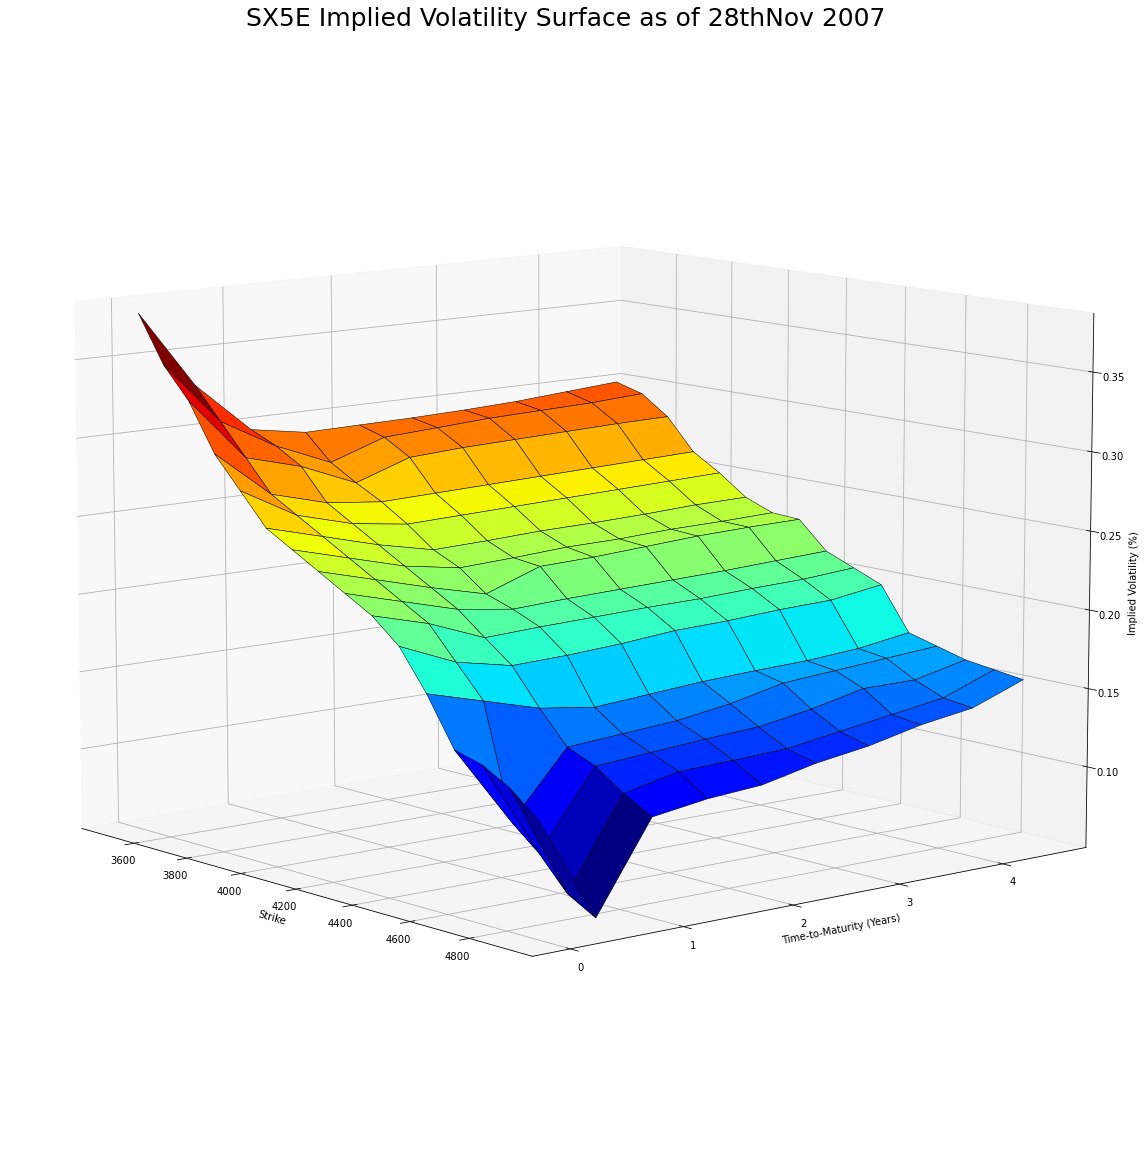

In [3]:
K = data.iloc[:,3].unique()
T = data.iloc[:,4].unique()
S = data.iloc[:,5].values

X, Y = np.meshgrid(K, T)

Z = S.reshape((K.shape[0], T.shape[0])).T

fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title('SX5E Implied Volatility Surface as of 28thNov 2007', fontdict={'fontsize': 25, 'fontweight': 'medium'})
ax.set_xlabel('Strike')
ax.set_ylabel('Time-to-Maturity (Years)')
ax.set_zlabel('Implied Volatility (%)')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='black', linewidth=0.5, antialiased=True)
ax.azim = -40
ax.dist = 10
ax.elev = 10

-----

In [4]:
S0 = data.iloc[0,0]
r = data.iloc[0,1]
c = data.iloc[0,2]

In [5]:
X_train = data.iloc[:,[3,4]].values
Y_train = data.iloc[:,[6]].values

mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)

In [6]:
class BSLayer(tf.keras.layers.Layer):
        
        def __init__(self, S0, r, c):
            super().__init__()
            self.S0 = S0
            self.r = r
            self.c = c
                
        def call(self, inputs): 
            K = tf.reshape(inputs[0][:,0], shape=(-1,1))
            T = tf.reshape(inputs[0][:,1], shape=(-1,1)) 
            volatility = inputs[1]
            
            d1 = (tf.math.log(self.S0/K) + (self.r-self.c+volatility**2/2)*T)/(volatility*tf.math.sqrt(T))
            Nd1 = 0.5*(1.+tf.math.erf(d1/tf.math.sqrt(2.))) 
                        
            d2 = d1 - volatility*tf.math.sqrt(T)
            Nd2 = 0.5*(1.+tf.math.erf(d2/tf.math.sqrt(2.)))  
            
            return self.S0*tf.math.exp(-self.c*T)*Nd1 - K*tf.math.exp(-self.r*T)*Nd2

In [7]:
def Model():
    f0 = tf.keras.layers.Lambda(lambda x: (x-mu)/sigma)
    f1 = tf.keras.layers.Dense(units=512,
                               activation='relu',
                               kernel_initializer='glorot_uniform',
                               bias_initializer='zeros')
    f2 = tf.keras.layers.Dropout(rate=0.1)
    f3 = tf.keras.layers.Dense(units=512,
                               activation='relu',
                               kernel_initializer='glorot_uniform',
                               bias_initializer='zeros')
    f4 = tf.keras.layers.Dropout(rate=0.1)
    f5 = tf.keras.layers.Dense(units=512,
                               activation='relu',
                               kernel_initializer='glorot_uniform',
                               bias_initializer='zeros')
    f6 = tf.keras.layers.Dropout(rate=0.1)
    f7 = tf.keras.layers.Dense(units=Y_train.shape[1],
                               activation='softplus',
                               kernel_initializer='glorot_uniform',
                               bias_initializer='zeros')
    f8 = BSLayer(S0=S0,
                 r=r,
                 c=c)
    x = tf.keras.Input(shape=X_train.shape[1])
    a0 = f0(x)
    a1 = f1(a0)
    a2 = f2(a1)
    a3 = f3(a2)
    a4 = f4(a3)
    a5 = f5(a4)
    a6 = f6(a5)
    y = f7(a6)
    z = f8([x, y])
    m = tf.keras.Model(x, z) 
    loss = loss = tf.keras.losses.MeanSquaredError()
    metric = tf.keras.metrics.MeanAbsoluteError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, 
                                         beta_1=0.9, 
                                         beta_2=0.999, 
                                         epsilon=1e-07)
    m.compile(loss=loss, 
              metrics=[metric], 
              optimizer=optimizer)
    m.summary()
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                     patience=2500,
                                                     min_delta=0.001,
                                                     factor=0.1, 
                                                     min_lr=0.00001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=5000,
                                                 min_delta=0.001)
    m.fit(X_train, 
          Y_train, 
          epochs=50000, 
          batch_size=64, 
          callbacks=[callback1, callback2], 
          verbose=True)
    model = tf.keras.Model(x, y) 
    return model, m

In [8]:
model, m = Model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 lambda (Lambda)                (None, 2)            0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 512)          1536        ['lambda[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['dense[0][0]']                  
                                                                                              

2023-12-20 14:57:40.107345: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 0s 2ms/step - loss: 759169.0625 - mean_absolute_error: 744.4197 - lr: 0.0010
Epoch 2/50000
3/3 [==============================] - 0s 2ms/step - loss: 80206.1406 - mean_absolute_error: 209.5016 - lr: 0.0010
Epoch 3/50000
3/3 [==============================] - 0s 3ms/step - loss: 91209.9531 - mean_absolute_error: 247.5483 - lr: 0.0010
Epoch 4/50000
3/3 [==============================] - 0s 3ms/step - loss: 108791.6875 - mean_absolute_error: 279.1249 - lr: 0.0010
Epoch 5/50000
3/3 [==============================] - 0s 3ms/step - loss: 114640.9375 - mean_absolute_error: 288.6425 - lr: 0.0010
Epoch 6/50000
3/3 [==============================] - 0s 3ms/step - loss: 117644.2031 - mean_absolute_error: 293.2438 - lr: 0.0010
Epoch 7/50000
3/3 [==============================] - 0s 3ms/step - loss: 117562.8984 - mean_absolute_error: 292.0907 - lr: 0.0010
Epoch 8/50000
3/3 [==============================] - 0s 3ms/step - loss: 116978.8594 - mean_absolute_error

3/3 [==============================] - 0s 3ms/step - loss: 1669.1656 - mean_absolute_error: 31.2229 - lr: 0.0010
Epoch 65/50000
3/3 [==============================] - 0s 3ms/step - loss: 2132.0273 - mean_absolute_error: 34.9186 - lr: 0.0010
Epoch 66/50000
3/3 [==============================] - 0s 3ms/step - loss: 1632.0354 - mean_absolute_error: 29.7041 - lr: 0.0010
Epoch 67/50000
3/3 [==============================] - 0s 3ms/step - loss: 2063.7559 - mean_absolute_error: 32.0922 - lr: 0.0010
Epoch 68/50000
3/3 [==============================] - 0s 3ms/step - loss: 1569.8678 - mean_absolute_error: 28.4384 - lr: 0.0010
Epoch 69/50000
3/3 [==============================] - 0s 3ms/step - loss: 2030.6680 - mean_absolute_error: 32.0085 - lr: 0.0010
Epoch 70/50000
3/3 [==============================] - 0s 3ms/step - loss: 1696.4707 - mean_absolute_error: 30.0087 - lr: 0.0010
Epoch 71/50000
3/3 [==============================] - 0s 3ms/step - loss: 1543.6368 - mean_absolute_error: 27.9610 - lr

Epoch 128/50000
3/3 [==============================] - 0s 3ms/step - loss: 824.4100 - mean_absolute_error: 21.4688 - lr: 0.0010
Epoch 129/50000
3/3 [==============================] - 0s 3ms/step - loss: 969.5707 - mean_absolute_error: 22.1505 - lr: 0.0010
Epoch 130/50000
3/3 [==============================] - 0s 3ms/step - loss: 986.0802 - mean_absolute_error: 22.4406 - lr: 0.0010
Epoch 131/50000
3/3 [==============================] - 0s 3ms/step - loss: 1043.5203 - mean_absolute_error: 21.9574 - lr: 0.0010
Epoch 132/50000
3/3 [==============================] - 0s 3ms/step - loss: 973.2233 - mean_absolute_error: 22.8604 - lr: 0.0010
Epoch 133/50000
3/3 [==============================] - 0s 3ms/step - loss: 1341.3513 - mean_absolute_error: 25.3060 - lr: 0.0010
Epoch 134/50000
3/3 [==============================] - 0s 3ms/step - loss: 1053.3689 - mean_absolute_error: 23.6746 - lr: 0.0010
Epoch 135/50000
3/3 [==============================] - 0s 3ms/step - loss: 1293.9293 - mean_absolute_

3/3 [==============================] - 0s 3ms/step - loss: 900.5879 - mean_absolute_error: 22.4750 - lr: 0.0010
Epoch 192/50000
3/3 [==============================] - 0s 4ms/step - loss: 943.4168 - mean_absolute_error: 22.1538 - lr: 0.0010
Epoch 193/50000
3/3 [==============================] - 0s 3ms/step - loss: 967.2556 - mean_absolute_error: 23.0222 - lr: 0.0010
Epoch 194/50000
3/3 [==============================] - 0s 3ms/step - loss: 894.5107 - mean_absolute_error: 21.5785 - lr: 0.0010
Epoch 195/50000
3/3 [==============================] - 0s 3ms/step - loss: 1079.7469 - mean_absolute_error: 23.9267 - lr: 0.0010
Epoch 196/50000
3/3 [==============================] - 0s 3ms/step - loss: 1144.3864 - mean_absolute_error: 24.8055 - lr: 0.0010
Epoch 197/50000
3/3 [==============================] - 0s 3ms/step - loss: 904.7433 - mean_absolute_error: 23.8188 - lr: 0.0010
Epoch 198/50000
3/3 [==============================] - 0s 3ms/step - loss: 1057.1251 - mean_absolute_error: 24.3132 - 

3/3 [==============================] - 0s 3ms/step - loss: 772.1709 - mean_absolute_error: 19.6884 - lr: 0.0010
Epoch 256/50000
3/3 [==============================] - 0s 3ms/step - loss: 852.0697 - mean_absolute_error: 21.1870 - lr: 0.0010
Epoch 257/50000
3/3 [==============================] - 0s 3ms/step - loss: 775.6173 - mean_absolute_error: 19.7450 - lr: 0.0010
Epoch 258/50000
3/3 [==============================] - 0s 3ms/step - loss: 724.2860 - mean_absolute_error: 20.4682 - lr: 0.0010
Epoch 259/50000
3/3 [==============================] - 0s 3ms/step - loss: 1100.9135 - mean_absolute_error: 22.8003 - lr: 0.0010
Epoch 260/50000
3/3 [==============================] - 0s 3ms/step - loss: 1010.5719 - mean_absolute_error: 23.8100 - lr: 0.0010
Epoch 261/50000
3/3 [==============================] - 0s 3ms/step - loss: 820.1260 - mean_absolute_error: 21.3592 - lr: 0.0010
Epoch 262/50000
3/3 [==============================] - 0s 3ms/step - loss: 635.9981 - mean_absolute_error: 18.8369 - l

3/3 [==============================] - 0s 3ms/step - loss: 825.6403 - mean_absolute_error: 20.5129 - lr: 0.0010
Epoch 320/50000
3/3 [==============================] - 0s 3ms/step - loss: 610.5486 - mean_absolute_error: 17.7675 - lr: 0.0010
Epoch 321/50000
3/3 [==============================] - 0s 3ms/step - loss: 755.9836 - mean_absolute_error: 19.0484 - lr: 0.0010
Epoch 322/50000
3/3 [==============================] - 0s 3ms/step - loss: 794.3344 - mean_absolute_error: 21.1122 - lr: 0.0010
Epoch 323/50000
3/3 [==============================] - 0s 3ms/step - loss: 729.2435 - mean_absolute_error: 19.3012 - lr: 0.0010
Epoch 324/50000
3/3 [==============================] - 0s 3ms/step - loss: 648.0660 - mean_absolute_error: 18.8569 - lr: 0.0010
Epoch 325/50000
3/3 [==============================] - 0s 3ms/step - loss: 668.3338 - mean_absolute_error: 18.3254 - lr: 0.0010
Epoch 326/50000
3/3 [==============================] - 0s 3ms/step - loss: 613.6931 - mean_absolute_error: 18.3255 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 556.0033 - mean_absolute_error: 16.4221 - lr: 0.0010
Epoch 384/50000
3/3 [==============================] - 0s 3ms/step - loss: 629.6340 - mean_absolute_error: 18.0829 - lr: 0.0010
Epoch 385/50000
3/3 [==============================] - 0s 3ms/step - loss: 548.0851 - mean_absolute_error: 16.9959 - lr: 0.0010
Epoch 386/50000
3/3 [==============================] - 0s 3ms/step - loss: 581.4194 - mean_absolute_error: 18.2460 - lr: 0.0010
Epoch 387/50000
3/3 [==============================] - 0s 3ms/step - loss: 565.5545 - mean_absolute_error: 17.9521 - lr: 0.0010
Epoch 388/50000
3/3 [==============================] - 0s 3ms/step - loss: 542.5400 - mean_absolute_error: 17.0840 - lr: 0.0010
Epoch 389/50000
3/3 [==============================] - 0s 3ms/step - loss: 500.4886 - mean_absolute_error: 15.6899 - lr: 0.0010
Epoch 390/50000
3/3 [==============================] - 0s 3ms/step - loss: 562.1198 - mean_absolute_error: 16.6805 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 502.1393 - mean_absolute_error: 16.1823 - lr: 0.0010
Epoch 448/50000
3/3 [==============================] - 0s 3ms/step - loss: 543.6740 - mean_absolute_error: 16.5453 - lr: 0.0010
Epoch 449/50000
3/3 [==============================] - 0s 3ms/step - loss: 492.0247 - mean_absolute_error: 16.0469 - lr: 0.0010
Epoch 450/50000
3/3 [==============================] - 0s 3ms/step - loss: 419.7520 - mean_absolute_error: 15.0890 - lr: 0.0010
Epoch 451/50000
3/3 [==============================] - 0s 3ms/step - loss: 503.2633 - mean_absolute_error: 17.1324 - lr: 0.0010
Epoch 452/50000
3/3 [==============================] - 0s 3ms/step - loss: 448.8431 - mean_absolute_error: 15.8171 - lr: 0.0010
Epoch 453/50000
3/3 [==============================] - 0s 3ms/step - loss: 493.8879 - mean_absolute_error: 16.4137 - lr: 0.0010
Epoch 454/50000
3/3 [==============================] - 0s 3ms/step - loss: 539.3794 - mean_absolute_error: 16.0800 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 545.6833 - mean_absolute_error: 16.7839 - lr: 0.0010
Epoch 512/50000
3/3 [==============================] - 0s 3ms/step - loss: 440.8040 - mean_absolute_error: 14.8054 - lr: 0.0010
Epoch 513/50000
3/3 [==============================] - 0s 3ms/step - loss: 464.3817 - mean_absolute_error: 16.6242 - lr: 0.0010
Epoch 514/50000
3/3 [==============================] - 0s 3ms/step - loss: 497.6208 - mean_absolute_error: 16.4064 - lr: 0.0010
Epoch 515/50000
3/3 [==============================] - 0s 3ms/step - loss: 321.1577 - mean_absolute_error: 12.9125 - lr: 0.0010
Epoch 516/50000
3/3 [==============================] - 0s 3ms/step - loss: 404.1432 - mean_absolute_error: 14.8378 - lr: 0.0010
Epoch 517/50000
3/3 [==============================] - 0s 3ms/step - loss: 445.8787 - mean_absolute_error: 15.4919 - lr: 0.0010
Epoch 518/50000
3/3 [==============================] - 0s 3ms/step - loss: 452.7066 - mean_absolute_error: 15.9368 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 388.5633 - mean_absolute_error: 14.2781 - lr: 0.0010
Epoch 576/50000
3/3 [==============================] - 0s 3ms/step - loss: 400.4809 - mean_absolute_error: 14.6231 - lr: 0.0010
Epoch 577/50000
3/3 [==============================] - 0s 3ms/step - loss: 423.2968 - mean_absolute_error: 15.2687 - lr: 0.0010
Epoch 578/50000
3/3 [==============================] - 0s 3ms/step - loss: 437.8667 - mean_absolute_error: 14.6200 - lr: 0.0010
Epoch 579/50000
3/3 [==============================] - 0s 3ms/step - loss: 347.8738 - mean_absolute_error: 13.2991 - lr: 0.0010
Epoch 580/50000
3/3 [==============================] - 0s 3ms/step - loss: 305.9736 - mean_absolute_error: 12.3119 - lr: 0.0010
Epoch 581/50000
3/3 [==============================] - 0s 3ms/step - loss: 310.2613 - mean_absolute_error: 12.3978 - lr: 0.0010
Epoch 582/50000
3/3 [==============================] - 0s 3ms/step - loss: 415.0433 - mean_absolute_error: 14.3927 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 353.3232 - mean_absolute_error: 13.6840 - lr: 0.0010
Epoch 640/50000
3/3 [==============================] - 0s 3ms/step - loss: 331.7659 - mean_absolute_error: 13.1059 - lr: 0.0010
Epoch 641/50000
3/3 [==============================] - 0s 3ms/step - loss: 415.8554 - mean_absolute_error: 14.5227 - lr: 0.0010
Epoch 642/50000
3/3 [==============================] - 0s 3ms/step - loss: 490.3111 - mean_absolute_error: 16.3136 - lr: 0.0010
Epoch 643/50000
3/3 [==============================] - 0s 3ms/step - loss: 367.3287 - mean_absolute_error: 14.4289 - lr: 0.0010
Epoch 644/50000
3/3 [==============================] - 0s 3ms/step - loss: 407.8000 - mean_absolute_error: 14.8386 - lr: 0.0010
Epoch 645/50000
3/3 [==============================] - 0s 3ms/step - loss: 374.4792 - mean_absolute_error: 14.2997 - lr: 0.0010
Epoch 646/50000
3/3 [==============================] - 0s 3ms/step - loss: 368.0558 - mean_absolute_error: 13.9938 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 494.2109 - mean_absolute_error: 16.5339 - lr: 0.0010
Epoch 704/50000
3/3 [==============================] - 0s 3ms/step - loss: 485.2063 - mean_absolute_error: 15.6851 - lr: 0.0010
Epoch 705/50000
3/3 [==============================] - 0s 3ms/step - loss: 425.0771 - mean_absolute_error: 14.5810 - lr: 0.0010
Epoch 706/50000
3/3 [==============================] - 0s 3ms/step - loss: 307.5526 - mean_absolute_error: 12.6136 - lr: 0.0010
Epoch 707/50000
3/3 [==============================] - 0s 3ms/step - loss: 347.8294 - mean_absolute_error: 13.3628 - lr: 0.0010
Epoch 708/50000
3/3 [==============================] - 0s 3ms/step - loss: 294.2227 - mean_absolute_error: 12.8337 - lr: 0.0010
Epoch 709/50000
3/3 [==============================] - 0s 3ms/step - loss: 367.7753 - mean_absolute_error: 13.7728 - lr: 0.0010
Epoch 710/50000
3/3 [==============================] - 0s 3ms/step - loss: 305.2652 - mean_absolute_error: 12.4576 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 322.1244 - mean_absolute_error: 12.8552 - lr: 0.0010
Epoch 768/50000
3/3 [==============================] - 0s 3ms/step - loss: 345.5466 - mean_absolute_error: 13.2126 - lr: 0.0010
Epoch 769/50000
3/3 [==============================] - 0s 3ms/step - loss: 325.3087 - mean_absolute_error: 13.4676 - lr: 0.0010
Epoch 770/50000
3/3 [==============================] - 0s 3ms/step - loss: 412.9727 - mean_absolute_error: 13.6370 - lr: 0.0010
Epoch 771/50000
3/3 [==============================] - 0s 3ms/step - loss: 548.6812 - mean_absolute_error: 17.1058 - lr: 0.0010
Epoch 772/50000
3/3 [==============================] - 0s 3ms/step - loss: 390.3773 - mean_absolute_error: 14.4920 - lr: 0.0010
Epoch 773/50000
3/3 [==============================] - 0s 3ms/step - loss: 360.5289 - mean_absolute_error: 13.6434 - lr: 0.0010
Epoch 774/50000
3/3 [==============================] - 0s 3ms/step - loss: 351.6089 - mean_absolute_error: 13.4380 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 312.3749 - mean_absolute_error: 12.7591 - lr: 0.0010
Epoch 832/50000
3/3 [==============================] - 0s 3ms/step - loss: 337.1622 - mean_absolute_error: 13.1607 - lr: 0.0010
Epoch 833/50000
3/3 [==============================] - 0s 3ms/step - loss: 273.3115 - mean_absolute_error: 11.6717 - lr: 0.0010
Epoch 834/50000
3/3 [==============================] - 0s 3ms/step - loss: 294.5427 - mean_absolute_error: 11.4227 - lr: 0.0010
Epoch 835/50000
3/3 [==============================] - 0s 3ms/step - loss: 311.3925 - mean_absolute_error: 12.3620 - lr: 0.0010
Epoch 836/50000
3/3 [==============================] - 0s 3ms/step - loss: 257.8453 - mean_absolute_error: 11.7927 - lr: 0.0010
Epoch 837/50000
3/3 [==============================] - 0s 3ms/step - loss: 484.9355 - mean_absolute_error: 15.2947 - lr: 0.0010
Epoch 838/50000
3/3 [==============================] - 0s 3ms/step - loss: 324.9044 - mean_absolute_error: 13.4769 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 231.8199 - mean_absolute_error: 10.8151 - lr: 0.0010
Epoch 896/50000
3/3 [==============================] - 0s 3ms/step - loss: 268.1624 - mean_absolute_error: 12.1326 - lr: 0.0010
Epoch 897/50000
3/3 [==============================] - 0s 3ms/step - loss: 371.4269 - mean_absolute_error: 13.5444 - lr: 0.0010
Epoch 898/50000
3/3 [==============================] - 0s 3ms/step - loss: 226.2955 - mean_absolute_error: 10.7505 - lr: 0.0010
Epoch 899/50000
3/3 [==============================] - 0s 3ms/step - loss: 261.6032 - mean_absolute_error: 11.7514 - lr: 0.0010
Epoch 900/50000
3/3 [==============================] - 0s 3ms/step - loss: 279.2038 - mean_absolute_error: 12.2040 - lr: 0.0010
Epoch 901/50000
3/3 [==============================] - 0s 3ms/step - loss: 341.0994 - mean_absolute_error: 13.1415 - lr: 0.0010
Epoch 902/50000
3/3 [==============================] - 0s 3ms/step - loss: 275.9152 - mean_absolute_error: 11.9998 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 324.9936 - mean_absolute_error: 13.6712 - lr: 0.0010
Epoch 960/50000
3/3 [==============================] - 0s 3ms/step - loss: 392.2707 - mean_absolute_error: 13.9479 - lr: 0.0010
Epoch 961/50000
3/3 [==============================] - 0s 3ms/step - loss: 235.9915 - mean_absolute_error: 11.1606 - lr: 0.0010
Epoch 962/50000
3/3 [==============================] - 0s 3ms/step - loss: 291.0058 - mean_absolute_error: 12.7008 - lr: 0.0010
Epoch 963/50000
3/3 [==============================] - 0s 3ms/step - loss: 247.5519 - mean_absolute_error: 11.2501 - lr: 0.0010
Epoch 964/50000
3/3 [==============================] - 0s 3ms/step - loss: 304.7664 - mean_absolute_error: 12.5092 - lr: 0.0010
Epoch 965/50000
3/3 [==============================] - 0s 3ms/step - loss: 330.8190 - mean_absolute_error: 12.5788 - lr: 0.0010
Epoch 966/50000
3/3 [==============================] - 0s 3ms/step - loss: 197.9203 - mean_absolute_error: 10.1951 - lr:

Epoch 1023/50000
3/3 [==============================] - 0s 3ms/step - loss: 317.2513 - mean_absolute_error: 12.9500 - lr: 0.0010
Epoch 1024/50000
3/3 [==============================] - 0s 3ms/step - loss: 235.4310 - mean_absolute_error: 11.2102 - lr: 0.0010
Epoch 1025/50000
3/3 [==============================] - 0s 3ms/step - loss: 213.4456 - mean_absolute_error: 10.8738 - lr: 0.0010
Epoch 1026/50000
3/3 [==============================] - 0s 3ms/step - loss: 263.3600 - mean_absolute_error: 11.8533 - lr: 0.0010
Epoch 1027/50000
3/3 [==============================] - 0s 3ms/step - loss: 313.2923 - mean_absolute_error: 12.6546 - lr: 0.0010
Epoch 1028/50000
3/3 [==============================] - 0s 3ms/step - loss: 256.1615 - mean_absolute_error: 11.1782 - lr: 0.0010
Epoch 1029/50000
3/3 [==============================] - 0s 3ms/step - loss: 262.0920 - mean_absolute_error: 11.4513 - lr: 0.0010
Epoch 1030/50000
3/3 [==============================] - 0s 3ms/step - loss: 350.1286 - mean_absol

3/3 [==============================] - 0s 3ms/step - loss: 210.9557 - mean_absolute_error: 10.2814 - lr: 0.0010
Epoch 1087/50000
3/3 [==============================] - 0s 3ms/step - loss: 187.6334 - mean_absolute_error: 10.0135 - lr: 0.0010
Epoch 1088/50000
3/3 [==============================] - 0s 3ms/step - loss: 323.8289 - mean_absolute_error: 12.9918 - lr: 0.0010
Epoch 1089/50000
3/3 [==============================] - 0s 3ms/step - loss: 250.8372 - mean_absolute_error: 11.2304 - lr: 0.0010
Epoch 1090/50000
3/3 [==============================] - 0s 3ms/step - loss: 280.8418 - mean_absolute_error: 12.0672 - lr: 0.0010
Epoch 1091/50000
3/3 [==============================] - 0s 3ms/step - loss: 245.0610 - mean_absolute_error: 11.6576 - lr: 0.0010
Epoch 1092/50000
3/3 [==============================] - 0s 3ms/step - loss: 182.3315 - mean_absolute_error: 9.9201 - lr: 0.0010
Epoch 1093/50000
3/3 [==============================] - 0s 3ms/step - loss: 231.8705 - mean_absolute_error: 11.5204

3/3 [==============================] - 0s 3ms/step - loss: 249.3662 - mean_absolute_error: 10.9075 - lr: 0.0010
Epoch 1150/50000
3/3 [==============================] - 0s 3ms/step - loss: 242.3349 - mean_absolute_error: 11.8559 - lr: 0.0010
Epoch 1151/50000
3/3 [==============================] - 0s 3ms/step - loss: 278.3814 - mean_absolute_error: 11.9294 - lr: 0.0010
Epoch 1152/50000
3/3 [==============================] - 0s 3ms/step - loss: 266.6537 - mean_absolute_error: 11.7823 - lr: 0.0010
Epoch 1153/50000
3/3 [==============================] - 0s 4ms/step - loss: 287.6280 - mean_absolute_error: 11.7350 - lr: 0.0010
Epoch 1154/50000
3/3 [==============================] - 0s 3ms/step - loss: 211.6602 - mean_absolute_error: 10.5549 - lr: 0.0010
Epoch 1155/50000
3/3 [==============================] - 0s 3ms/step - loss: 298.3672 - mean_absolute_error: 12.2988 - lr: 0.0010
Epoch 1156/50000
3/3 [==============================] - 0s 3ms/step - loss: 355.5102 - mean_absolute_error: 13.862

3/3 [==============================] - 0s 3ms/step - loss: 279.0521 - mean_absolute_error: 11.4569 - lr: 0.0010
Epoch 1213/50000
3/3 [==============================] - 0s 3ms/step - loss: 290.5596 - mean_absolute_error: 12.3464 - lr: 0.0010
Epoch 1214/50000
3/3 [==============================] - 0s 3ms/step - loss: 344.4269 - mean_absolute_error: 13.3410 - lr: 0.0010
Epoch 1215/50000
3/3 [==============================] - 0s 3ms/step - loss: 332.1465 - mean_absolute_error: 12.9848 - lr: 0.0010
Epoch 1216/50000
3/3 [==============================] - 0s 3ms/step - loss: 364.6868 - mean_absolute_error: 12.9421 - lr: 0.0010
Epoch 1217/50000
3/3 [==============================] - 0s 3ms/step - loss: 316.8554 - mean_absolute_error: 13.2949 - lr: 0.0010
Epoch 1218/50000
3/3 [==============================] - 0s 3ms/step - loss: 311.6165 - mean_absolute_error: 12.7485 - lr: 0.0010
Epoch 1219/50000
3/3 [==============================] - 0s 3ms/step - loss: 240.3360 - mean_absolute_error: 10.865

3/3 [==============================] - 0s 3ms/step - loss: 265.5103 - mean_absolute_error: 12.0457 - lr: 0.0010
Epoch 1276/50000
3/3 [==============================] - 0s 3ms/step - loss: 248.4688 - mean_absolute_error: 11.6938 - lr: 0.0010
Epoch 1277/50000
3/3 [==============================] - 0s 3ms/step - loss: 248.2557 - mean_absolute_error: 11.4321 - lr: 0.0010
Epoch 1278/50000
3/3 [==============================] - 0s 3ms/step - loss: 185.2847 - mean_absolute_error: 10.2538 - lr: 0.0010
Epoch 1279/50000
3/3 [==============================] - 0s 3ms/step - loss: 316.8572 - mean_absolute_error: 13.0794 - lr: 0.0010
Epoch 1280/50000
3/3 [==============================] - 0s 3ms/step - loss: 274.5312 - mean_absolute_error: 11.7818 - lr: 0.0010
Epoch 1281/50000
3/3 [==============================] - 0s 3ms/step - loss: 220.7043 - mean_absolute_error: 10.8182 - lr: 0.0010
Epoch 1282/50000
3/3 [==============================] - 0s 3ms/step - loss: 318.5114 - mean_absolute_error: 12.132

3/3 [==============================] - 0s 3ms/step - loss: 252.6915 - mean_absolute_error: 10.9941 - lr: 0.0010
Epoch 1339/50000
3/3 [==============================] - 0s 3ms/step - loss: 270.9503 - mean_absolute_error: 11.7509 - lr: 0.0010
Epoch 1340/50000
3/3 [==============================] - 0s 3ms/step - loss: 274.1419 - mean_absolute_error: 11.9639 - lr: 0.0010
Epoch 1341/50000
3/3 [==============================] - 0s 3ms/step - loss: 243.8601 - mean_absolute_error: 11.4312 - lr: 0.0010
Epoch 1342/50000
3/3 [==============================] - 0s 3ms/step - loss: 260.1225 - mean_absolute_error: 11.3795 - lr: 0.0010
Epoch 1343/50000
3/3 [==============================] - 0s 3ms/step - loss: 259.2481 - mean_absolute_error: 11.4348 - lr: 0.0010
Epoch 1344/50000
3/3 [==============================] - 0s 3ms/step - loss: 272.8272 - mean_absolute_error: 12.3313 - lr: 0.0010
Epoch 1345/50000
3/3 [==============================] - 0s 3ms/step - loss: 243.4352 - mean_absolute_error: 11.209

3/3 [==============================] - 0s 3ms/step - loss: 323.9321 - mean_absolute_error: 13.4532 - lr: 0.0010
Epoch 1402/50000
3/3 [==============================] - 0s 3ms/step - loss: 339.5808 - mean_absolute_error: 12.6436 - lr: 0.0010
Epoch 1403/50000
3/3 [==============================] - 0s 3ms/step - loss: 258.3752 - mean_absolute_error: 11.1125 - lr: 0.0010
Epoch 1404/50000
3/3 [==============================] - 0s 3ms/step - loss: 255.4606 - mean_absolute_error: 11.5512 - lr: 0.0010
Epoch 1405/50000
3/3 [==============================] - 0s 3ms/step - loss: 266.1814 - mean_absolute_error: 10.9903 - lr: 0.0010
Epoch 1406/50000
3/3 [==============================] - 0s 3ms/step - loss: 268.2989 - mean_absolute_error: 11.9379 - lr: 0.0010
Epoch 1407/50000
3/3 [==============================] - 0s 3ms/step - loss: 195.6300 - mean_absolute_error: 9.9278 - lr: 0.0010
Epoch 1408/50000
3/3 [==============================] - 0s 3ms/step - loss: 184.5589 - mean_absolute_error: 9.8453 

3/3 [==============================] - 0s 3ms/step - loss: 231.7307 - mean_absolute_error: 11.2830 - lr: 0.0010
Epoch 1465/50000
3/3 [==============================] - 0s 3ms/step - loss: 224.4267 - mean_absolute_error: 10.7757 - lr: 0.0010
Epoch 1466/50000
3/3 [==============================] - 0s 3ms/step - loss: 183.6982 - mean_absolute_error: 10.4100 - lr: 0.0010
Epoch 1467/50000
3/3 [==============================] - 0s 3ms/step - loss: 298.2888 - mean_absolute_error: 11.5476 - lr: 0.0010
Epoch 1468/50000
3/3 [==============================] - 0s 3ms/step - loss: 230.7211 - mean_absolute_error: 11.1090 - lr: 0.0010
Epoch 1469/50000
3/3 [==============================] - 0s 3ms/step - loss: 290.6136 - mean_absolute_error: 12.3254 - lr: 0.0010
Epoch 1470/50000
3/3 [==============================] - 0s 3ms/step - loss: 172.0168 - mean_absolute_error: 10.2943 - lr: 0.0010
Epoch 1471/50000
3/3 [==============================] - 0s 3ms/step - loss: 193.3642 - mean_absolute_error: 10.293

3/3 [==============================] - 0s 3ms/step - loss: 215.2801 - mean_absolute_error: 10.9634 - lr: 0.0010
Epoch 1528/50000
3/3 [==============================] - 0s 3ms/step - loss: 280.4091 - mean_absolute_error: 12.3122 - lr: 0.0010
Epoch 1529/50000
3/3 [==============================] - 0s 3ms/step - loss: 235.6883 - mean_absolute_error: 11.3135 - lr: 0.0010
Epoch 1530/50000
3/3 [==============================] - 0s 3ms/step - loss: 234.0107 - mean_absolute_error: 11.4859 - lr: 0.0010
Epoch 1531/50000
3/3 [==============================] - 0s 3ms/step - loss: 217.8691 - mean_absolute_error: 10.1483 - lr: 0.0010
Epoch 1532/50000
3/3 [==============================] - 0s 3ms/step - loss: 286.7107 - mean_absolute_error: 12.3498 - lr: 0.0010
Epoch 1533/50000
3/3 [==============================] - 0s 3ms/step - loss: 259.2684 - mean_absolute_error: 11.3513 - lr: 0.0010
Epoch 1534/50000
3/3 [==============================] - 0s 3ms/step - loss: 211.7956 - mean_absolute_error: 10.878

3/3 [==============================] - 0s 3ms/step - loss: 305.4959 - mean_absolute_error: 12.3789 - lr: 0.0010
Epoch 1591/50000
3/3 [==============================] - 0s 3ms/step - loss: 357.1262 - mean_absolute_error: 13.4248 - lr: 0.0010
Epoch 1592/50000
3/3 [==============================] - 0s 3ms/step - loss: 291.5418 - mean_absolute_error: 13.1440 - lr: 0.0010
Epoch 1593/50000
3/3 [==============================] - 0s 3ms/step - loss: 265.1589 - mean_absolute_error: 11.5687 - lr: 0.0010
Epoch 1594/50000
3/3 [==============================] - 0s 3ms/step - loss: 289.3409 - mean_absolute_error: 12.0641 - lr: 0.0010
Epoch 1595/50000
3/3 [==============================] - 0s 3ms/step - loss: 223.8205 - mean_absolute_error: 10.7205 - lr: 0.0010
Epoch 1596/50000
3/3 [==============================] - 0s 3ms/step - loss: 295.2020 - mean_absolute_error: 12.5563 - lr: 0.0010
Epoch 1597/50000
3/3 [==============================] - 0s 3ms/step - loss: 226.8130 - mean_absolute_error: 10.955

3/3 [==============================] - 0s 3ms/step - loss: 253.5511 - mean_absolute_error: 11.5793 - lr: 0.0010
Epoch 1654/50000
3/3 [==============================] - 0s 3ms/step - loss: 289.9990 - mean_absolute_error: 11.4528 - lr: 0.0010
Epoch 1655/50000
3/3 [==============================] - 0s 3ms/step - loss: 224.6799 - mean_absolute_error: 10.4578 - lr: 0.0010
Epoch 1656/50000
3/3 [==============================] - 0s 3ms/step - loss: 265.0447 - mean_absolute_error: 12.1764 - lr: 0.0010
Epoch 1657/50000
3/3 [==============================] - 0s 3ms/step - loss: 203.0954 - mean_absolute_error: 9.7771 - lr: 0.0010
Epoch 1658/50000
3/3 [==============================] - 0s 3ms/step - loss: 183.4615 - mean_absolute_error: 10.3117 - lr: 0.0010
Epoch 1659/50000
3/3 [==============================] - 0s 3ms/step - loss: 195.0141 - mean_absolute_error: 9.6075 - lr: 0.0010
Epoch 1660/50000
3/3 [==============================] - 0s 3ms/step - loss: 247.5096 - mean_absolute_error: 11.8195 

3/3 [==============================] - 0s 3ms/step - loss: 209.4899 - mean_absolute_error: 10.9496 - lr: 0.0010
Epoch 1717/50000
3/3 [==============================] - 0s 3ms/step - loss: 238.1247 - mean_absolute_error: 11.3950 - lr: 0.0010
Epoch 1718/50000
3/3 [==============================] - 0s 3ms/step - loss: 191.8452 - mean_absolute_error: 9.9975 - lr: 0.0010
Epoch 1719/50000
3/3 [==============================] - 0s 3ms/step - loss: 228.8790 - mean_absolute_error: 10.8823 - lr: 0.0010
Epoch 1720/50000
3/3 [==============================] - 0s 3ms/step - loss: 197.8483 - mean_absolute_error: 10.2935 - lr: 0.0010
Epoch 1721/50000
3/3 [==============================] - 0s 3ms/step - loss: 169.4097 - mean_absolute_error: 9.8539 - lr: 0.0010
Epoch 1722/50000
3/3 [==============================] - 0s 3ms/step - loss: 212.5602 - mean_absolute_error: 10.4636 - lr: 0.0010
Epoch 1723/50000
3/3 [==============================] - 0s 3ms/step - loss: 239.9434 - mean_absolute_error: 11.0330 

3/3 [==============================] - 0s 3ms/step - loss: 214.8436 - mean_absolute_error: 10.4684 - lr: 0.0010
Epoch 1780/50000
3/3 [==============================] - 0s 3ms/step - loss: 214.5864 - mean_absolute_error: 10.7643 - lr: 0.0010
Epoch 1781/50000
3/3 [==============================] - 0s 3ms/step - loss: 223.9640 - mean_absolute_error: 10.8923 - lr: 0.0010
Epoch 1782/50000
3/3 [==============================] - 0s 3ms/step - loss: 191.8185 - mean_absolute_error: 9.7480 - lr: 0.0010
Epoch 1783/50000
3/3 [==============================] - 0s 3ms/step - loss: 216.3932 - mean_absolute_error: 10.6938 - lr: 0.0010
Epoch 1784/50000
3/3 [==============================] - 0s 3ms/step - loss: 211.4584 - mean_absolute_error: 10.4984 - lr: 0.0010
Epoch 1785/50000
3/3 [==============================] - 0s 3ms/step - loss: 210.4354 - mean_absolute_error: 10.4609 - lr: 0.0010
Epoch 1786/50000
3/3 [==============================] - 0s 3ms/step - loss: 254.2365 - mean_absolute_error: 11.8189

3/3 [==============================] - 0s 3ms/step - loss: 208.1295 - mean_absolute_error: 10.5633 - lr: 0.0010
Epoch 1843/50000
3/3 [==============================] - 0s 3ms/step - loss: 182.2679 - mean_absolute_error: 10.0913 - lr: 0.0010
Epoch 1844/50000
3/3 [==============================] - 0s 3ms/step - loss: 293.5229 - mean_absolute_error: 12.8269 - lr: 0.0010
Epoch 1845/50000
3/3 [==============================] - 0s 3ms/step - loss: 237.8438 - mean_absolute_error: 11.1062 - lr: 0.0010
Epoch 1846/50000
3/3 [==============================] - 0s 3ms/step - loss: 227.6731 - mean_absolute_error: 11.2311 - lr: 0.0010
Epoch 1847/50000
3/3 [==============================] - 0s 3ms/step - loss: 244.9459 - mean_absolute_error: 11.4003 - lr: 0.0010
Epoch 1848/50000
3/3 [==============================] - 0s 3ms/step - loss: 202.9364 - mean_absolute_error: 10.6339 - lr: 0.0010
Epoch 1849/50000
3/3 [==============================] - 0s 3ms/step - loss: 194.8495 - mean_absolute_error: 10.457

3/3 [==============================] - 0s 3ms/step - loss: 207.0165 - mean_absolute_error: 10.2298 - lr: 0.0010
Epoch 1906/50000
3/3 [==============================] - 0s 3ms/step - loss: 280.7018 - mean_absolute_error: 11.8959 - lr: 0.0010
Epoch 1907/50000
3/3 [==============================] - 0s 3ms/step - loss: 169.1177 - mean_absolute_error: 9.2695 - lr: 0.0010
Epoch 1908/50000
3/3 [==============================] - 0s 3ms/step - loss: 212.6240 - mean_absolute_error: 10.5473 - lr: 0.0010
Epoch 1909/50000
3/3 [==============================] - 0s 3ms/step - loss: 197.1061 - mean_absolute_error: 10.3133 - lr: 0.0010
Epoch 1910/50000
3/3 [==============================] - 0s 3ms/step - loss: 213.7959 - mean_absolute_error: 10.2712 - lr: 0.0010
Epoch 1911/50000
3/3 [==============================] - 0s 3ms/step - loss: 256.4003 - mean_absolute_error: 11.1966 - lr: 0.0010
Epoch 1912/50000
3/3 [==============================] - 0s 3ms/step - loss: 253.2154 - mean_absolute_error: 11.1954

3/3 [==============================] - 0s 3ms/step - loss: 253.1469 - mean_absolute_error: 11.7157 - lr: 0.0010
Epoch 1969/50000
3/3 [==============================] - 0s 3ms/step - loss: 258.7426 - mean_absolute_error: 12.3990 - lr: 0.0010
Epoch 1970/50000
3/3 [==============================] - 0s 3ms/step - loss: 208.6734 - mean_absolute_error: 10.6872 - lr: 0.0010
Epoch 1971/50000
3/3 [==============================] - 0s 3ms/step - loss: 228.0651 - mean_absolute_error: 10.8737 - lr: 0.0010
Epoch 1972/50000
3/3 [==============================] - 0s 3ms/step - loss: 248.5608 - mean_absolute_error: 11.0849 - lr: 0.0010
Epoch 1973/50000
3/3 [==============================] - 0s 3ms/step - loss: 184.1480 - mean_absolute_error: 9.7798 - lr: 0.0010
Epoch 1974/50000
3/3 [==============================] - 0s 3ms/step - loss: 212.4386 - mean_absolute_error: 10.4778 - lr: 0.0010
Epoch 1975/50000
3/3 [==============================] - 0s 3ms/step - loss: 184.5124 - mean_absolute_error: 10.0090

3/3 [==============================] - 0s 3ms/step - loss: 199.9848 - mean_absolute_error: 10.2753 - lr: 0.0010
Epoch 2032/50000
3/3 [==============================] - 0s 3ms/step - loss: 170.8378 - mean_absolute_error: 9.5793 - lr: 0.0010
Epoch 2033/50000
3/3 [==============================] - 0s 3ms/step - loss: 187.6390 - mean_absolute_error: 10.1459 - lr: 0.0010
Epoch 2034/50000
3/3 [==============================] - 0s 3ms/step - loss: 179.0099 - mean_absolute_error: 9.4726 - lr: 0.0010
Epoch 2035/50000
3/3 [==============================] - 0s 3ms/step - loss: 191.2486 - mean_absolute_error: 10.0266 - lr: 0.0010
Epoch 2036/50000
3/3 [==============================] - 0s 3ms/step - loss: 245.9989 - mean_absolute_error: 11.5374 - lr: 0.0010
Epoch 2037/50000
3/3 [==============================] - 0s 3ms/step - loss: 226.0612 - mean_absolute_error: 10.8627 - lr: 0.0010
Epoch 2038/50000
3/3 [==============================] - 0s 3ms/step - loss: 225.2425 - mean_absolute_error: 10.9913 

3/3 [==============================] - 0s 3ms/step - loss: 154.9184 - mean_absolute_error: 9.2569 - lr: 0.0010
Epoch 2095/50000
3/3 [==============================] - 0s 3ms/step - loss: 147.3705 - mean_absolute_error: 9.3108 - lr: 0.0010
Epoch 2096/50000
3/3 [==============================] - 0s 3ms/step - loss: 193.6709 - mean_absolute_error: 9.9751 - lr: 0.0010
Epoch 2097/50000
3/3 [==============================] - 0s 3ms/step - loss: 223.1173 - mean_absolute_error: 11.1508 - lr: 0.0010
Epoch 2098/50000
3/3 [==============================] - 0s 3ms/step - loss: 215.9496 - mean_absolute_error: 10.4841 - lr: 0.0010
Epoch 2099/50000
3/3 [==============================] - 0s 3ms/step - loss: 238.8060 - mean_absolute_error: 11.4914 - lr: 0.0010
Epoch 2100/50000
3/3 [==============================] - 0s 4ms/step - loss: 173.4767 - mean_absolute_error: 9.6150 - lr: 0.0010
Epoch 2101/50000
3/3 [==============================] - 0s 3ms/step - loss: 253.3927 - mean_absolute_error: 11.3546 - 

3/3 [==============================] - 0s 3ms/step - loss: 205.7388 - mean_absolute_error: 10.6321 - lr: 0.0010
Epoch 2158/50000
3/3 [==============================] - 0s 3ms/step - loss: 204.8603 - mean_absolute_error: 10.7170 - lr: 0.0010
Epoch 2159/50000
3/3 [==============================] - 0s 3ms/step - loss: 271.2975 - mean_absolute_error: 11.9186 - lr: 0.0010
Epoch 2160/50000
3/3 [==============================] - 0s 3ms/step - loss: 174.9173 - mean_absolute_error: 9.6316 - lr: 0.0010
Epoch 2161/50000
3/3 [==============================] - 0s 3ms/step - loss: 187.8492 - mean_absolute_error: 9.8137 - lr: 0.0010
Epoch 2162/50000
3/3 [==============================] - 0s 3ms/step - loss: 216.7637 - mean_absolute_error: 10.4394 - lr: 0.0010
Epoch 2163/50000
3/3 [==============================] - 0s 3ms/step - loss: 246.7078 - mean_absolute_error: 11.1527 - lr: 0.0010
Epoch 2164/50000
3/3 [==============================] - 0s 3ms/step - loss: 229.5509 - mean_absolute_error: 11.4540 

3/3 [==============================] - 0s 3ms/step - loss: 258.5648 - mean_absolute_error: 11.4748 - lr: 0.0010
Epoch 2221/50000
3/3 [==============================] - 0s 5ms/step - loss: 221.6633 - mean_absolute_error: 10.2405 - lr: 0.0010
Epoch 2222/50000
3/3 [==============================] - 0s 3ms/step - loss: 204.0182 - mean_absolute_error: 10.5305 - lr: 0.0010
Epoch 2223/50000
3/3 [==============================] - 0s 3ms/step - loss: 211.1772 - mean_absolute_error: 10.3768 - lr: 0.0010
Epoch 2224/50000
3/3 [==============================] - 0s 3ms/step - loss: 208.2323 - mean_absolute_error: 10.3855 - lr: 0.0010
Epoch 2225/50000
3/3 [==============================] - 0s 3ms/step - loss: 204.6744 - mean_absolute_error: 10.6095 - lr: 0.0010
Epoch 2226/50000
3/3 [==============================] - 0s 3ms/step - loss: 253.2418 - mean_absolute_error: 11.2640 - lr: 0.0010
Epoch 2227/50000
3/3 [==============================] - 0s 3ms/step - loss: 251.7415 - mean_absolute_error: 12.078

3/3 [==============================] - 0s 3ms/step - loss: 247.9799 - mean_absolute_error: 11.3220 - lr: 0.0010
Epoch 2284/50000
3/3 [==============================] - 0s 3ms/step - loss: 187.9089 - mean_absolute_error: 9.9864 - lr: 0.0010
Epoch 2285/50000
3/3 [==============================] - 0s 3ms/step - loss: 196.5423 - mean_absolute_error: 10.0946 - lr: 0.0010
Epoch 2286/50000
3/3 [==============================] - 0s 3ms/step - loss: 216.6459 - mean_absolute_error: 10.6967 - lr: 0.0010
Epoch 2287/50000
3/3 [==============================] - 0s 3ms/step - loss: 196.5910 - mean_absolute_error: 10.6637 - lr: 0.0010
Epoch 2288/50000
3/3 [==============================] - 0s 3ms/step - loss: 196.4914 - mean_absolute_error: 10.2041 - lr: 0.0010
Epoch 2289/50000
3/3 [==============================] - 0s 3ms/step - loss: 193.0886 - mean_absolute_error: 9.9903 - lr: 0.0010
Epoch 2290/50000
3/3 [==============================] - 0s 3ms/step - loss: 265.8670 - mean_absolute_error: 11.8988 

3/3 [==============================] - 0s 4ms/step - loss: 153.2490 - mean_absolute_error: 9.1100 - lr: 0.0010
Epoch 2347/50000
3/3 [==============================] - 0s 3ms/step - loss: 242.0188 - mean_absolute_error: 11.4219 - lr: 0.0010
Epoch 2348/50000
3/3 [==============================] - 0s 3ms/step - loss: 181.9155 - mean_absolute_error: 9.8065 - lr: 0.0010
Epoch 2349/50000
3/3 [==============================] - 0s 3ms/step - loss: 206.4453 - mean_absolute_error: 10.3820 - lr: 0.0010
Epoch 2350/50000
3/3 [==============================] - 0s 3ms/step - loss: 282.2477 - mean_absolute_error: 11.8266 - lr: 0.0010
Epoch 2351/50000
3/3 [==============================] - 0s 3ms/step - loss: 192.3098 - mean_absolute_error: 9.9162 - lr: 0.0010
Epoch 2352/50000
3/3 [==============================] - 0s 3ms/step - loss: 267.0521 - mean_absolute_error: 11.6472 - lr: 0.0010
Epoch 2353/50000
3/3 [==============================] - 0s 3ms/step - loss: 163.9577 - mean_absolute_error: 9.5571 - 

3/3 [==============================] - 0s 3ms/step - loss: 192.3814 - mean_absolute_error: 10.0096 - lr: 0.0010
Epoch 2410/50000
3/3 [==============================] - 0s 3ms/step - loss: 192.8416 - mean_absolute_error: 10.3312 - lr: 0.0010
Epoch 2411/50000
3/3 [==============================] - 0s 3ms/step - loss: 184.1753 - mean_absolute_error: 9.4040 - lr: 0.0010
Epoch 2412/50000
3/3 [==============================] - 0s 3ms/step - loss: 174.4937 - mean_absolute_error: 9.7150 - lr: 0.0010
Epoch 2413/50000
3/3 [==============================] - 0s 3ms/step - loss: 200.9170 - mean_absolute_error: 10.5263 - lr: 0.0010
Epoch 2414/50000
3/3 [==============================] - 0s 3ms/step - loss: 219.6761 - mean_absolute_error: 10.3583 - lr: 0.0010
Epoch 2415/50000
3/3 [==============================] - 0s 3ms/step - loss: 189.3152 - mean_absolute_error: 10.3305 - lr: 0.0010
Epoch 2416/50000
3/3 [==============================] - 0s 3ms/step - loss: 220.7449 - mean_absolute_error: 10.5856 

3/3 [==============================] - 0s 3ms/step - loss: 186.6974 - mean_absolute_error: 9.7404 - lr: 0.0010
Epoch 2473/50000
3/3 [==============================] - 0s 3ms/step - loss: 227.9555 - mean_absolute_error: 11.3057 - lr: 0.0010
Epoch 2474/50000
3/3 [==============================] - 0s 3ms/step - loss: 230.9663 - mean_absolute_error: 10.7530 - lr: 0.0010
Epoch 2475/50000
3/3 [==============================] - 0s 3ms/step - loss: 182.4362 - mean_absolute_error: 10.2660 - lr: 0.0010
Epoch 2476/50000
3/3 [==============================] - 0s 3ms/step - loss: 193.4070 - mean_absolute_error: 10.0965 - lr: 0.0010
Epoch 2477/50000
3/3 [==============================] - 0s 3ms/step - loss: 204.8026 - mean_absolute_error: 9.8687 - lr: 0.0010
Epoch 2478/50000
3/3 [==============================] - 0s 3ms/step - loss: 220.7185 - mean_absolute_error: 10.1753 - lr: 0.0010
Epoch 2479/50000
3/3 [==============================] - 0s 3ms/step - loss: 164.9266 - mean_absolute_error: 9.1177 -

Epoch 2536/50000
3/3 [==============================] - 0s 3ms/step - loss: 179.1606 - mean_absolute_error: 9.7844 - lr: 0.0010
Epoch 2537/50000
3/3 [==============================] - 0s 3ms/step - loss: 258.8834 - mean_absolute_error: 11.1202 - lr: 0.0010
Epoch 2538/50000
3/3 [==============================] - 0s 3ms/step - loss: 207.1667 - mean_absolute_error: 10.4265 - lr: 0.0010
Epoch 2539/50000
3/3 [==============================] - 0s 3ms/step - loss: 157.5875 - mean_absolute_error: 9.2021 - lr: 0.0010
Epoch 2540/50000
3/3 [==============================] - 0s 3ms/step - loss: 169.9487 - mean_absolute_error: 8.8161 - lr: 0.0010
Epoch 2541/50000
3/3 [==============================] - 0s 3ms/step - loss: 205.6624 - mean_absolute_error: 10.8946 - lr: 0.0010
Epoch 2542/50000
3/3 [==============================] - 0s 3ms/step - loss: 170.1530 - mean_absolute_error: 9.2567 - lr: 0.0010
Epoch 2543/50000
3/3 [==============================] - 0s 3ms/step - loss: 214.9463 - mean_absolute_

3/3 [==============================] - 0s 3ms/step - loss: 214.2837 - mean_absolute_error: 10.6607 - lr: 0.0010
Epoch 2600/50000
3/3 [==============================] - 0s 3ms/step - loss: 240.2010 - mean_absolute_error: 11.6790 - lr: 0.0010
Epoch 2601/50000
3/3 [==============================] - 0s 3ms/step - loss: 177.7334 - mean_absolute_error: 9.5052 - lr: 0.0010
Epoch 2602/50000
3/3 [==============================] - 0s 3ms/step - loss: 197.1590 - mean_absolute_error: 10.1918 - lr: 0.0010
Epoch 2603/50000
3/3 [==============================] - 0s 3ms/step - loss: 148.6712 - mean_absolute_error: 8.4846 - lr: 0.0010
Epoch 2604/50000
3/3 [==============================] - 0s 3ms/step - loss: 164.3977 - mean_absolute_error: 9.2190 - lr: 0.0010
Epoch 2605/50000
3/3 [==============================] - 0s 3ms/step - loss: 198.2640 - mean_absolute_error: 10.5862 - lr: 0.0010
Epoch 2606/50000
3/3 [==============================] - 0s 3ms/step - loss: 174.7419 - mean_absolute_error: 9.7347 - 

3/3 [==============================] - 0s 3ms/step - loss: 210.3532 - mean_absolute_error: 11.1705 - lr: 0.0010
Epoch 2663/50000
3/3 [==============================] - 0s 3ms/step - loss: 244.9215 - mean_absolute_error: 10.8595 - lr: 0.0010
Epoch 2664/50000
3/3 [==============================] - 0s 3ms/step - loss: 175.4554 - mean_absolute_error: 10.0446 - lr: 0.0010
Epoch 2665/50000
3/3 [==============================] - 0s 3ms/step - loss: 176.3902 - mean_absolute_error: 9.7346 - lr: 0.0010
Epoch 2666/50000
3/3 [==============================] - 0s 3ms/step - loss: 188.5494 - mean_absolute_error: 10.3961 - lr: 0.0010
Epoch 2667/50000
3/3 [==============================] - 0s 3ms/step - loss: 254.8192 - mean_absolute_error: 11.4299 - lr: 0.0010
Epoch 2668/50000
3/3 [==============================] - 0s 3ms/step - loss: 228.2688 - mean_absolute_error: 11.0398 - lr: 0.0010
Epoch 2669/50000
3/3 [==============================] - 0s 3ms/step - loss: 187.9126 - mean_absolute_error: 9.7503 

Epoch 2726/50000
3/3 [==============================] - 0s 3ms/step - loss: 250.5219 - mean_absolute_error: 11.8116 - lr: 0.0010
Epoch 2727/50000
3/3 [==============================] - 0s 3ms/step - loss: 234.0226 - mean_absolute_error: 10.5323 - lr: 0.0010
Epoch 2728/50000
3/3 [==============================] - 0s 3ms/step - loss: 214.2430 - mean_absolute_error: 10.6040 - lr: 0.0010
Epoch 2729/50000
3/3 [==============================] - 0s 3ms/step - loss: 232.6607 - mean_absolute_error: 10.9512 - lr: 0.0010
Epoch 2730/50000
3/3 [==============================] - 0s 3ms/step - loss: 242.1308 - mean_absolute_error: 11.0676 - lr: 0.0010
Epoch 2731/50000
3/3 [==============================] - 0s 3ms/step - loss: 157.9475 - mean_absolute_error: 9.0805 - lr: 0.0010
Epoch 2732/50000
3/3 [==============================] - 0s 3ms/step - loss: 125.0108 - mean_absolute_error: 8.2437 - lr: 0.0010
Epoch 2733/50000
3/3 [==============================] - 0s 3ms/step - loss: 181.6475 - mean_absolut

3/3 [==============================] - 0s 3ms/step - loss: 174.4159 - mean_absolute_error: 9.8383 - lr: 0.0010
Epoch 2790/50000
3/3 [==============================] - 0s 3ms/step - loss: 231.4876 - mean_absolute_error: 11.3646 - lr: 0.0010
Epoch 2791/50000
3/3 [==============================] - 0s 3ms/step - loss: 236.2777 - mean_absolute_error: 10.7119 - lr: 0.0010
Epoch 2792/50000
3/3 [==============================] - 0s 3ms/step - loss: 199.3366 - mean_absolute_error: 10.0384 - lr: 0.0010
Epoch 2793/50000
3/3 [==============================] - 0s 3ms/step - loss: 208.6551 - mean_absolute_error: 9.8432 - lr: 0.0010
Epoch 2794/50000
3/3 [==============================] - 0s 3ms/step - loss: 180.2516 - mean_absolute_error: 10.2664 - lr: 0.0010
Epoch 2795/50000
3/3 [==============================] - 0s 3ms/step - loss: 188.7129 - mean_absolute_error: 10.1531 - lr: 0.0010
Epoch 2796/50000
3/3 [==============================] - 0s 3ms/step - loss: 188.2528 - mean_absolute_error: 9.9732 -

3/3 [==============================] - 0s 3ms/step - loss: 181.0573 - mean_absolute_error: 10.1048 - lr: 0.0010
Epoch 2853/50000
3/3 [==============================] - 0s 3ms/step - loss: 170.0268 - mean_absolute_error: 9.5628 - lr: 0.0010
Epoch 2854/50000
3/3 [==============================] - 0s 3ms/step - loss: 148.2652 - mean_absolute_error: 8.4618 - lr: 0.0010
Epoch 2855/50000
3/3 [==============================] - 0s 3ms/step - loss: 189.4292 - mean_absolute_error: 10.2522 - lr: 0.0010
Epoch 2856/50000
3/3 [==============================] - 0s 3ms/step - loss: 196.7438 - mean_absolute_error: 10.4572 - lr: 0.0010
Epoch 2857/50000
3/3 [==============================] - 0s 3ms/step - loss: 212.3763 - mean_absolute_error: 10.2021 - lr: 0.0010
Epoch 2858/50000
3/3 [==============================] - 0s 3ms/step - loss: 246.3313 - mean_absolute_error: 11.7198 - lr: 0.0010
Epoch 2859/50000
3/3 [==============================] - 0s 3ms/step - loss: 173.3324 - mean_absolute_error: 9.5011 -

Epoch 2916/50000
3/3 [==============================] - 0s 3ms/step - loss: 196.6579 - mean_absolute_error: 10.6057 - lr: 0.0010
Epoch 2917/50000
3/3 [==============================] - 0s 3ms/step - loss: 171.6806 - mean_absolute_error: 9.4555 - lr: 0.0010
Epoch 2918/50000
3/3 [==============================] - 0s 3ms/step - loss: 184.1562 - mean_absolute_error: 9.8147 - lr: 0.0010
Epoch 2919/50000
3/3 [==============================] - 0s 3ms/step - loss: 159.0295 - mean_absolute_error: 9.2936 - lr: 0.0010
Epoch 2920/50000
3/3 [==============================] - 0s 3ms/step - loss: 163.6946 - mean_absolute_error: 9.2462 - lr: 0.0010
Epoch 2921/50000
3/3 [==============================] - 0s 3ms/step - loss: 176.8240 - mean_absolute_error: 9.8156 - lr: 0.0010
Epoch 2922/50000
3/3 [==============================] - 0s 3ms/step - loss: 188.8842 - mean_absolute_error: 10.1338 - lr: 0.0010
Epoch 2923/50000
3/3 [==============================] - 0s 3ms/step - loss: 243.6202 - mean_absolute_e

3/3 [==============================] - 0s 3ms/step - loss: 196.3739 - mean_absolute_error: 9.8851 - lr: 0.0010
Epoch 2980/50000
3/3 [==============================] - 0s 3ms/step - loss: 224.9715 - mean_absolute_error: 10.9834 - lr: 0.0010
Epoch 2981/50000
3/3 [==============================] - 0s 3ms/step - loss: 271.2245 - mean_absolute_error: 11.3607 - lr: 0.0010
Epoch 2982/50000
3/3 [==============================] - 0s 3ms/step - loss: 209.3804 - mean_absolute_error: 10.6860 - lr: 0.0010
Epoch 2983/50000
3/3 [==============================] - 0s 3ms/step - loss: 198.1534 - mean_absolute_error: 10.6371 - lr: 0.0010
Epoch 2984/50000
3/3 [==============================] - 0s 3ms/step - loss: 230.5160 - mean_absolute_error: 11.0717 - lr: 0.0010
Epoch 2985/50000
3/3 [==============================] - 0s 3ms/step - loss: 141.2690 - mean_absolute_error: 8.5498 - lr: 0.0010
Epoch 2986/50000
3/3 [==============================] - 0s 3ms/step - loss: 144.7074 - mean_absolute_error: 8.7501 -

Epoch 3043/50000
3/3 [==============================] - 0s 3ms/step - loss: 182.6185 - mean_absolute_error: 9.9425 - lr: 0.0010
Epoch 3044/50000
3/3 [==============================] - 0s 3ms/step - loss: 171.4482 - mean_absolute_error: 9.9710 - lr: 0.0010
Epoch 3045/50000
3/3 [==============================] - 0s 3ms/step - loss: 187.4922 - mean_absolute_error: 10.0390 - lr: 0.0010
Epoch 3046/50000
3/3 [==============================] - 0s 3ms/step - loss: 234.4704 - mean_absolute_error: 11.5826 - lr: 0.0010
Epoch 3047/50000
3/3 [==============================] - 0s 3ms/step - loss: 195.5261 - mean_absolute_error: 9.7385 - lr: 0.0010
Epoch 3048/50000
3/3 [==============================] - 0s 3ms/step - loss: 175.8969 - mean_absolute_error: 9.8669 - lr: 0.0010
Epoch 3049/50000
3/3 [==============================] - 0s 3ms/step - loss: 195.6179 - mean_absolute_error: 10.4601 - lr: 0.0010
Epoch 3050/50000
3/3 [==============================] - 0s 3ms/step - loss: 190.2166 - mean_absolute_

Epoch 3107/50000
3/3 [==============================] - 0s 3ms/step - loss: 171.3471 - mean_absolute_error: 8.8692 - lr: 0.0010
Epoch 3108/50000
3/3 [==============================] - 0s 3ms/step - loss: 196.3450 - mean_absolute_error: 9.9517 - lr: 0.0010
Epoch 3109/50000
3/3 [==============================] - 0s 3ms/step - loss: 175.2264 - mean_absolute_error: 9.6688 - lr: 0.0010
Epoch 3110/50000
3/3 [==============================] - 0s 3ms/step - loss: 156.3702 - mean_absolute_error: 9.2323 - lr: 0.0010
Epoch 3111/50000
3/3 [==============================] - 0s 3ms/step - loss: 139.7125 - mean_absolute_error: 8.6344 - lr: 0.0010
Epoch 3112/50000
3/3 [==============================] - 0s 3ms/step - loss: 143.6051 - mean_absolute_error: 8.7649 - lr: 0.0010
Epoch 3113/50000
3/3 [==============================] - 0s 3ms/step - loss: 163.3132 - mean_absolute_error: 9.5232 - lr: 0.0010
Epoch 3114/50000
3/3 [==============================] - 0s 3ms/step - loss: 192.5427 - mean_absolute_err

3/3 [==============================] - 0s 3ms/step - loss: 227.0781 - mean_absolute_error: 11.4803 - lr: 0.0010
Epoch 3171/50000
3/3 [==============================] - 0s 3ms/step - loss: 185.3136 - mean_absolute_error: 9.3596 - lr: 0.0010
Epoch 3172/50000
3/3 [==============================] - 0s 3ms/step - loss: 179.1028 - mean_absolute_error: 9.4676 - lr: 0.0010
Epoch 3173/50000
3/3 [==============================] - 0s 3ms/step - loss: 208.3936 - mean_absolute_error: 10.3909 - lr: 0.0010
Epoch 3174/50000
3/3 [==============================] - 0s 3ms/step - loss: 173.9731 - mean_absolute_error: 9.5986 - lr: 0.0010
Epoch 3175/50000
3/3 [==============================] - 0s 3ms/step - loss: 179.4261 - mean_absolute_error: 9.6180 - lr: 0.0010
Epoch 3176/50000
3/3 [==============================] - 0s 3ms/step - loss: 187.6497 - mean_absolute_error: 9.2804 - lr: 0.0010
Epoch 3177/50000
3/3 [==============================] - 0s 3ms/step - loss: 164.5302 - mean_absolute_error: 9.0631 - lr

3/3 [==============================] - 0s 3ms/step - loss: 164.4909 - mean_absolute_error: 9.1275 - lr: 0.0010
Epoch 3235/50000
3/3 [==============================] - 0s 3ms/step - loss: 146.7335 - mean_absolute_error: 9.3204 - lr: 0.0010
Epoch 3236/50000
3/3 [==============================] - 0s 3ms/step - loss: 171.4968 - mean_absolute_error: 9.3606 - lr: 0.0010
Epoch 3237/50000
3/3 [==============================] - 0s 3ms/step - loss: 212.9804 - mean_absolute_error: 10.5246 - lr: 0.0010
Epoch 3238/50000
3/3 [==============================] - 0s 3ms/step - loss: 160.4266 - mean_absolute_error: 9.5347 - lr: 0.0010
Epoch 3239/50000
3/3 [==============================] - 0s 3ms/step - loss: 178.7672 - mean_absolute_error: 9.5474 - lr: 0.0010
Epoch 3240/50000
3/3 [==============================] - 0s 3ms/step - loss: 201.4053 - mean_absolute_error: 10.4068 - lr: 0.0010
Epoch 3241/50000
3/3 [==============================] - 0s 3ms/step - loss: 179.9128 - mean_absolute_error: 10.0091 - l

3/3 [==============================] - 0s 3ms/step - loss: 190.3653 - mean_absolute_error: 10.6357 - lr: 0.0010
Epoch 3299/50000
3/3 [==============================] - 0s 3ms/step - loss: 195.1833 - mean_absolute_error: 9.3543 - lr: 0.0010
Epoch 3300/50000
3/3 [==============================] - 0s 3ms/step - loss: 169.7500 - mean_absolute_error: 9.5296 - lr: 0.0010
Epoch 3301/50000
3/3 [==============================] - 0s 3ms/step - loss: 174.5538 - mean_absolute_error: 9.5213 - lr: 0.0010
Epoch 3302/50000
3/3 [==============================] - 0s 3ms/step - loss: 147.9067 - mean_absolute_error: 8.5959 - lr: 0.0010
Epoch 3303/50000
3/3 [==============================] - 0s 3ms/step - loss: 152.1297 - mean_absolute_error: 9.0376 - lr: 0.0010
Epoch 3304/50000
3/3 [==============================] - 0s 3ms/step - loss: 222.7154 - mean_absolute_error: 11.2779 - lr: 0.0010
Epoch 3305/50000
3/3 [==============================] - 0s 3ms/step - loss: 132.3511 - mean_absolute_error: 8.2740 - lr

3/3 [==============================] - 0s 3ms/step - loss: 263.3930 - mean_absolute_error: 12.0488 - lr: 0.0010
Epoch 3363/50000
3/3 [==============================] - 0s 3ms/step - loss: 235.9509 - mean_absolute_error: 10.4759 - lr: 0.0010
Epoch 3364/50000
3/3 [==============================] - 0s 3ms/step - loss: 203.8887 - mean_absolute_error: 10.4145 - lr: 0.0010
Epoch 3365/50000
3/3 [==============================] - 0s 3ms/step - loss: 215.5318 - mean_absolute_error: 10.3009 - lr: 0.0010
Epoch 3366/50000
3/3 [==============================] - 0s 3ms/step - loss: 199.4314 - mean_absolute_error: 10.4867 - lr: 0.0010
Epoch 3367/50000
3/3 [==============================] - 0s 3ms/step - loss: 184.3974 - mean_absolute_error: 9.8186 - lr: 0.0010
Epoch 3368/50000
3/3 [==============================] - 0s 3ms/step - loss: 133.6259 - mean_absolute_error: 8.3179 - lr: 0.0010
Epoch 3369/50000
3/3 [==============================] - 0s 3ms/step - loss: 134.6051 - mean_absolute_error: 8.5866 -

3/3 [==============================] - 0s 3ms/step - loss: 151.7760 - mean_absolute_error: 9.0371 - lr: 0.0010
Epoch 3427/50000
3/3 [==============================] - 0s 3ms/step - loss: 145.6535 - mean_absolute_error: 9.1196 - lr: 0.0010
Epoch 3428/50000
3/3 [==============================] - 0s 3ms/step - loss: 158.0716 - mean_absolute_error: 9.1433 - lr: 0.0010
Epoch 3429/50000
3/3 [==============================] - 0s 3ms/step - loss: 176.4305 - mean_absolute_error: 9.0297 - lr: 0.0010
Epoch 3430/50000
3/3 [==============================] - 0s 3ms/step - loss: 176.5508 - mean_absolute_error: 9.8240 - lr: 0.0010
Epoch 3431/50000
3/3 [==============================] - 0s 3ms/step - loss: 168.2823 - mean_absolute_error: 9.5017 - lr: 0.0010
Epoch 3432/50000
3/3 [==============================] - 0s 3ms/step - loss: 181.9151 - mean_absolute_error: 9.5373 - lr: 0.0010
Epoch 3433/50000
3/3 [==============================] - 0s 3ms/step - loss: 120.8863 - mean_absolute_error: 7.9073 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 169.6079 - mean_absolute_error: 9.1551 - lr: 0.0010
Epoch 3491/50000
3/3 [==============================] - 0s 3ms/step - loss: 178.6863 - mean_absolute_error: 9.7048 - lr: 0.0010
Epoch 3492/50000
3/3 [==============================] - 0s 3ms/step - loss: 164.7195 - mean_absolute_error: 9.1890 - lr: 0.0010
Epoch 3493/50000
3/3 [==============================] - 0s 3ms/step - loss: 174.3904 - mean_absolute_error: 9.8082 - lr: 0.0010
Epoch 3494/50000
3/3 [==============================] - 0s 3ms/step - loss: 170.6039 - mean_absolute_error: 9.0929 - lr: 0.0010
Epoch 3495/50000
3/3 [==============================] - 0s 3ms/step - loss: 160.2489 - mean_absolute_error: 9.4876 - lr: 0.0010
Epoch 3496/50000
3/3 [==============================] - 0s 3ms/step - loss: 185.2099 - mean_absolute_error: 9.7796 - lr: 0.0010
Epoch 3497/50000
3/3 [==============================] - 0s 3ms/step - loss: 228.1184 - mean_absolute_error: 10.3969 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 127.1144 - mean_absolute_error: 7.9440 - lr: 0.0010
Epoch 3555/50000
3/3 [==============================] - 0s 3ms/step - loss: 177.9595 - mean_absolute_error: 9.1807 - lr: 0.0010
Epoch 3556/50000
3/3 [==============================] - 0s 3ms/step - loss: 164.8795 - mean_absolute_error: 9.0050 - lr: 0.0010
Epoch 3557/50000
3/3 [==============================] - 0s 3ms/step - loss: 124.5751 - mean_absolute_error: 8.3170 - lr: 0.0010
Epoch 3558/50000
3/3 [==============================] - 0s 3ms/step - loss: 155.8439 - mean_absolute_error: 9.2619 - lr: 0.0010
Epoch 3559/50000
3/3 [==============================] - 0s 3ms/step - loss: 128.8019 - mean_absolute_error: 7.7611 - lr: 0.0010
Epoch 3560/50000
3/3 [==============================] - 0s 3ms/step - loss: 140.7486 - mean_absolute_error: 8.7610 - lr: 0.0010
Epoch 3561/50000
3/3 [==============================] - 0s 3ms/step - loss: 124.1289 - mean_absolute_error: 8.0101 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 108.1897 - mean_absolute_error: 7.6003 - lr: 0.0010
Epoch 3619/50000
3/3 [==============================] - 0s 3ms/step - loss: 114.9812 - mean_absolute_error: 7.8610 - lr: 0.0010
Epoch 3620/50000
3/3 [==============================] - 0s 3ms/step - loss: 134.9552 - mean_absolute_error: 8.4268 - lr: 0.0010
Epoch 3621/50000
3/3 [==============================] - 0s 3ms/step - loss: 174.8761 - mean_absolute_error: 9.5481 - lr: 0.0010
Epoch 3622/50000
3/3 [==============================] - 0s 3ms/step - loss: 174.7569 - mean_absolute_error: 9.4270 - lr: 0.0010
Epoch 3623/50000
3/3 [==============================] - 0s 3ms/step - loss: 145.7939 - mean_absolute_error: 8.4096 - lr: 0.0010
Epoch 3624/50000
3/3 [==============================] - 0s 3ms/step - loss: 116.9573 - mean_absolute_error: 7.7413 - lr: 0.0010
Epoch 3625/50000
3/3 [==============================] - 0s 3ms/step - loss: 145.2257 - mean_absolute_error: 8.8996 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 149.6035 - mean_absolute_error: 8.6319 - lr: 0.0010
Epoch 3683/50000
3/3 [==============================] - 0s 3ms/step - loss: 128.8911 - mean_absolute_error: 8.4455 - lr: 0.0010
Epoch 3684/50000
3/3 [==============================] - 0s 3ms/step - loss: 132.5148 - mean_absolute_error: 8.6757 - lr: 0.0010
Epoch 3685/50000
3/3 [==============================] - 0s 3ms/step - loss: 119.3196 - mean_absolute_error: 8.3169 - lr: 0.0010
Epoch 3686/50000
3/3 [==============================] - 0s 3ms/step - loss: 139.0098 - mean_absolute_error: 8.7836 - lr: 0.0010
Epoch 3687/50000
3/3 [==============================] - 0s 3ms/step - loss: 182.3816 - mean_absolute_error: 9.1071 - lr: 0.0010
Epoch 3688/50000
3/3 [==============================] - 0s 3ms/step - loss: 134.6380 - mean_absolute_error: 8.4322 - lr: 0.0010
Epoch 3689/50000
3/3 [==============================] - 0s 3ms/step - loss: 116.2645 - mean_absolute_error: 7.8103 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 138.1066 - mean_absolute_error: 8.6570 - lr: 0.0010
Epoch 3747/50000
3/3 [==============================] - 0s 3ms/step - loss: 164.9318 - mean_absolute_error: 9.3791 - lr: 0.0010
Epoch 3748/50000
3/3 [==============================] - 0s 3ms/step - loss: 109.4734 - mean_absolute_error: 7.9489 - lr: 0.0010
Epoch 3749/50000
3/3 [==============================] - 0s 3ms/step - loss: 138.3883 - mean_absolute_error: 8.6270 - lr: 0.0010
Epoch 3750/50000
3/3 [==============================] - 0s 3ms/step - loss: 161.9305 - mean_absolute_error: 8.6968 - lr: 0.0010
Epoch 3751/50000
3/3 [==============================] - 0s 3ms/step - loss: 143.5901 - mean_absolute_error: 9.2421 - lr: 0.0010
Epoch 3752/50000
3/3 [==============================] - 0s 3ms/step - loss: 136.2100 - mean_absolute_error: 8.2634 - lr: 0.0010
Epoch 3753/50000
3/3 [==============================] - 0s 3ms/step - loss: 165.8264 - mean_absolute_error: 9.6812 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 156.5982 - mean_absolute_error: 9.0595 - lr: 0.0010
Epoch 3811/50000
3/3 [==============================] - 0s 3ms/step - loss: 160.4653 - mean_absolute_error: 9.1041 - lr: 0.0010
Epoch 3812/50000
3/3 [==============================] - 0s 3ms/step - loss: 135.7968 - mean_absolute_error: 8.4092 - lr: 0.0010
Epoch 3813/50000
3/3 [==============================] - 0s 3ms/step - loss: 196.5722 - mean_absolute_error: 9.8556 - lr: 0.0010
Epoch 3814/50000
3/3 [==============================] - 0s 3ms/step - loss: 170.5035 - mean_absolute_error: 9.3090 - lr: 0.0010
Epoch 3815/50000
3/3 [==============================] - 0s 3ms/step - loss: 170.9385 - mean_absolute_error: 9.8739 - lr: 0.0010
Epoch 3816/50000
3/3 [==============================] - 0s 3ms/step - loss: 188.3117 - mean_absolute_error: 9.8890 - lr: 0.0010
Epoch 3817/50000
3/3 [==============================] - 0s 3ms/step - loss: 133.4016 - mean_absolute_error: 8.4183 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 137.5044 - mean_absolute_error: 8.1776 - lr: 0.0010
Epoch 3875/50000
3/3 [==============================] - 0s 3ms/step - loss: 141.1788 - mean_absolute_error: 8.1673 - lr: 0.0010
Epoch 3876/50000
3/3 [==============================] - 0s 3ms/step - loss: 139.4244 - mean_absolute_error: 8.7061 - lr: 0.0010
Epoch 3877/50000
3/3 [==============================] - 0s 3ms/step - loss: 173.9398 - mean_absolute_error: 9.1118 - lr: 0.0010
Epoch 3878/50000
3/3 [==============================] - 0s 3ms/step - loss: 129.6152 - mean_absolute_error: 8.3876 - lr: 0.0010
Epoch 3879/50000
3/3 [==============================] - 0s 3ms/step - loss: 128.9725 - mean_absolute_error: 8.3170 - lr: 0.0010
Epoch 3880/50000
3/3 [==============================] - 0s 3ms/step - loss: 155.0338 - mean_absolute_error: 8.6674 - lr: 0.0010
Epoch 3881/50000
3/3 [==============================] - 0s 3ms/step - loss: 168.5946 - mean_absolute_error: 9.6394 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 106.5227 - mean_absolute_error: 7.2442 - lr: 0.0010
Epoch 3939/50000
3/3 [==============================] - 0s 3ms/step - loss: 138.4091 - mean_absolute_error: 8.4315 - lr: 0.0010
Epoch 3940/50000
3/3 [==============================] - 0s 3ms/step - loss: 157.7282 - mean_absolute_error: 9.3800 - lr: 0.0010
Epoch 3941/50000
3/3 [==============================] - 0s 3ms/step - loss: 134.1177 - mean_absolute_error: 8.5130 - lr: 0.0010
Epoch 3942/50000
3/3 [==============================] - 0s 3ms/step - loss: 168.5112 - mean_absolute_error: 9.4632 - lr: 0.0010
Epoch 3943/50000
3/3 [==============================] - 0s 3ms/step - loss: 182.9078 - mean_absolute_error: 9.4362 - lr: 0.0010
Epoch 3944/50000
3/3 [==============================] - 0s 3ms/step - loss: 200.6254 - mean_absolute_error: 9.8825 - lr: 0.0010
Epoch 3945/50000
3/3 [==============================] - 0s 3ms/step - loss: 177.0965 - mean_absolute_error: 10.2173 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 141.5144 - mean_absolute_error: 8.5758 - lr: 0.0010
Epoch 4003/50000
3/3 [==============================] - 0s 3ms/step - loss: 141.5928 - mean_absolute_error: 8.7710 - lr: 0.0010
Epoch 4004/50000
3/3 [==============================] - 0s 3ms/step - loss: 129.2890 - mean_absolute_error: 8.2572 - lr: 0.0010
Epoch 4005/50000
3/3 [==============================] - 0s 3ms/step - loss: 122.1629 - mean_absolute_error: 8.0039 - lr: 0.0010
Epoch 4006/50000
3/3 [==============================] - 0s 3ms/step - loss: 101.7681 - mean_absolute_error: 7.4545 - lr: 0.0010
Epoch 4007/50000
3/3 [==============================] - 0s 3ms/step - loss: 108.7334 - mean_absolute_error: 7.7271 - lr: 0.0010
Epoch 4008/50000
3/3 [==============================] - 0s 3ms/step - loss: 127.3227 - mean_absolute_error: 7.9744 - lr: 0.0010
Epoch 4009/50000
3/3 [==============================] - 0s 3ms/step - loss: 112.3999 - mean_absolute_error: 7.6701 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 140.7839 - mean_absolute_error: 8.3866 - lr: 0.0010
Epoch 4067/50000
3/3 [==============================] - 0s 3ms/step - loss: 112.0788 - mean_absolute_error: 7.6685 - lr: 0.0010
Epoch 4068/50000
3/3 [==============================] - 0s 3ms/step - loss: 169.1692 - mean_absolute_error: 9.0756 - lr: 0.0010
Epoch 4069/50000
3/3 [==============================] - 0s 3ms/step - loss: 216.2572 - mean_absolute_error: 10.6333 - lr: 0.0010
Epoch 4070/50000
3/3 [==============================] - 0s 3ms/step - loss: 174.8712 - mean_absolute_error: 9.3014 - lr: 0.0010
Epoch 4071/50000
3/3 [==============================] - 0s 3ms/step - loss: 112.8541 - mean_absolute_error: 7.9363 - lr: 0.0010
Epoch 4072/50000
3/3 [==============================] - 0s 3ms/step - loss: 145.4518 - mean_absolute_error: 8.8293 - lr: 0.0010
Epoch 4073/50000
3/3 [==============================] - 0s 3ms/step - loss: 179.1721 - mean_absolute_error: 9.1276 - lr:

3/3 [==============================] - 0s 3ms/step - loss: 107.8734 - mean_absolute_error: 7.3947 - lr: 0.0010
Epoch 4131/50000
3/3 [==============================] - 0s 3ms/step - loss: 138.2536 - mean_absolute_error: 8.5330 - lr: 0.0010
Epoch 4132/50000
3/3 [==============================] - 0s 3ms/step - loss: 129.2216 - mean_absolute_error: 8.0875 - lr: 0.0010
Epoch 4133/50000
3/3 [==============================] - 0s 3ms/step - loss: 164.8993 - mean_absolute_error: 9.2754 - lr: 0.0010
Epoch 4134/50000
3/3 [==============================] - 0s 3ms/step - loss: 136.8912 - mean_absolute_error: 8.6748 - lr: 0.0010
Epoch 4135/50000
3/3 [==============================] - 0s 3ms/step - loss: 94.4279 - mean_absolute_error: 7.4996 - lr: 0.0010
Epoch 4136/50000
3/3 [==============================] - 0s 3ms/step - loss: 137.7027 - mean_absolute_error: 8.5052 - lr: 0.0010
Epoch 4137/50000
3/3 [==============================] - 0s 3ms/step - loss: 197.4076 - mean_absolute_error: 9.3298 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 187.8738 - mean_absolute_error: 9.1565 - lr: 0.0010
Epoch 4195/50000
3/3 [==============================] - 0s 3ms/step - loss: 169.6496 - mean_absolute_error: 8.8289 - lr: 0.0010
Epoch 4196/50000
3/3 [==============================] - 0s 3ms/step - loss: 149.0316 - mean_absolute_error: 9.0848 - lr: 0.0010
Epoch 4197/50000
3/3 [==============================] - 0s 3ms/step - loss: 146.4723 - mean_absolute_error: 8.9475 - lr: 0.0010
Epoch 4198/50000
3/3 [==============================] - 0s 3ms/step - loss: 149.1667 - mean_absolute_error: 9.2282 - lr: 0.0010
Epoch 4199/50000
3/3 [==============================] - 0s 3ms/step - loss: 155.3235 - mean_absolute_error: 8.6744 - lr: 0.0010
Epoch 4200/50000
3/3 [==============================] - 0s 3ms/step - loss: 159.8188 - mean_absolute_error: 8.9820 - lr: 0.0010
Epoch 4201/50000
3/3 [==============================] - 0s 3ms/step - loss: 129.8755 - mean_absolute_error: 8.3860 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 142.7507 - mean_absolute_error: 8.4186 - lr: 0.0010
Epoch 4259/50000
3/3 [==============================] - 0s 4ms/step - loss: 145.4108 - mean_absolute_error: 8.5653 - lr: 0.0010
Epoch 4260/50000
3/3 [==============================] - 0s 3ms/step - loss: 120.4015 - mean_absolute_error: 7.9373 - lr: 0.0010
Epoch 4261/50000
3/3 [==============================] - 0s 3ms/step - loss: 144.0796 - mean_absolute_error: 8.4748 - lr: 0.0010
Epoch 4262/50000
3/3 [==============================] - 0s 3ms/step - loss: 146.4741 - mean_absolute_error: 8.5650 - lr: 0.0010
Epoch 4263/50000
3/3 [==============================] - 0s 3ms/step - loss: 183.1449 - mean_absolute_error: 9.3508 - lr: 0.0010
Epoch 4264/50000
3/3 [==============================] - 0s 3ms/step - loss: 145.0876 - mean_absolute_error: 8.7124 - lr: 0.0010
Epoch 4265/50000
3/3 [==============================] - 0s 3ms/step - loss: 160.0844 - mean_absolute_error: 8.9493 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 116.1059 - mean_absolute_error: 7.9165 - lr: 0.0010
Epoch 4323/50000
3/3 [==============================] - 0s 3ms/step - loss: 111.0312 - mean_absolute_error: 7.4480 - lr: 0.0010
Epoch 4324/50000
3/3 [==============================] - 0s 3ms/step - loss: 123.0097 - mean_absolute_error: 7.8781 - lr: 0.0010
Epoch 4325/50000
3/3 [==============================] - 0s 3ms/step - loss: 92.8044 - mean_absolute_error: 6.8830 - lr: 0.0010
Epoch 4326/50000
3/3 [==============================] - 0s 3ms/step - loss: 129.4787 - mean_absolute_error: 7.9095 - lr: 0.0010
Epoch 4327/50000
3/3 [==============================] - 0s 3ms/step - loss: 118.4168 - mean_absolute_error: 7.8497 - lr: 0.0010
Epoch 4328/50000
3/3 [==============================] - 0s 3ms/step - loss: 136.4115 - mean_absolute_error: 8.3687 - lr: 0.0010
Epoch 4329/50000
3/3 [==============================] - 0s 3ms/step - loss: 121.5561 - mean_absolute_error: 7.8607 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 150.3311 - mean_absolute_error: 8.8736 - lr: 0.0010
Epoch 4387/50000
3/3 [==============================] - 0s 3ms/step - loss: 129.9504 - mean_absolute_error: 8.3774 - lr: 0.0010
Epoch 4388/50000
3/3 [==============================] - 0s 3ms/step - loss: 155.3316 - mean_absolute_error: 8.6129 - lr: 0.0010
Epoch 4389/50000
3/3 [==============================] - 0s 3ms/step - loss: 108.8626 - mean_absolute_error: 7.3736 - lr: 0.0010
Epoch 4390/50000
3/3 [==============================] - 0s 3ms/step - loss: 142.2711 - mean_absolute_error: 8.7101 - lr: 0.0010
Epoch 4391/50000
3/3 [==============================] - 0s 3ms/step - loss: 106.4884 - mean_absolute_error: 7.6797 - lr: 0.0010
Epoch 4392/50000
3/3 [==============================] - 0s 3ms/step - loss: 105.0061 - mean_absolute_error: 7.7103 - lr: 0.0010
Epoch 4393/50000
3/3 [==============================] - 0s 3ms/step - loss: 127.4563 - mean_absolute_error: 8.3714 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 111.7251 - mean_absolute_error: 7.7119 - lr: 0.0010
Epoch 4451/50000
3/3 [==============================] - 0s 3ms/step - loss: 108.2865 - mean_absolute_error: 7.4562 - lr: 0.0010
Epoch 4452/50000
3/3 [==============================] - 0s 3ms/step - loss: 167.9134 - mean_absolute_error: 8.8201 - lr: 0.0010
Epoch 4453/50000
3/3 [==============================] - 0s 3ms/step - loss: 91.0369 - mean_absolute_error: 6.9017 - lr: 0.0010
Epoch 4454/50000
3/3 [==============================] - 0s 3ms/step - loss: 145.8808 - mean_absolute_error: 8.3690 - lr: 0.0010
Epoch 4455/50000
3/3 [==============================] - 0s 3ms/step - loss: 112.4476 - mean_absolute_error: 7.6965 - lr: 0.0010
Epoch 4456/50000
3/3 [==============================] - 0s 3ms/step - loss: 180.8981 - mean_absolute_error: 9.9675 - lr: 0.0010
Epoch 4457/50000
3/3 [==============================] - 0s 3ms/step - loss: 122.9763 - mean_absolute_error: 7.7675 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 135.9804 - mean_absolute_error: 8.0514 - lr: 0.0010
Epoch 4515/50000
3/3 [==============================] - 0s 3ms/step - loss: 96.8600 - mean_absolute_error: 7.1389 - lr: 0.0010
Epoch 4516/50000
3/3 [==============================] - 0s 3ms/step - loss: 129.9567 - mean_absolute_error: 8.0656 - lr: 0.0010
Epoch 4517/50000
3/3 [==============================] - 0s 3ms/step - loss: 117.1741 - mean_absolute_error: 7.5794 - lr: 0.0010
Epoch 4518/50000
3/3 [==============================] - 0s 3ms/step - loss: 136.2389 - mean_absolute_error: 8.0152 - lr: 0.0010
Epoch 4519/50000
3/3 [==============================] - 0s 3ms/step - loss: 126.5869 - mean_absolute_error: 8.3758 - lr: 0.0010
Epoch 4520/50000
3/3 [==============================] - 0s 3ms/step - loss: 126.7457 - mean_absolute_error: 8.2690 - lr: 0.0010
Epoch 4521/50000
3/3 [==============================] - 0s 3ms/step - loss: 145.3704 - mean_absolute_error: 8.5992 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 172.5900 - mean_absolute_error: 9.5200 - lr: 0.0010
Epoch 4579/50000
3/3 [==============================] - 0s 3ms/step - loss: 149.6948 - mean_absolute_error: 8.6365 - lr: 0.0010
Epoch 4580/50000
3/3 [==============================] - 0s 3ms/step - loss: 203.1685 - mean_absolute_error: 10.3376 - lr: 0.0010
Epoch 4581/50000
3/3 [==============================] - 0s 3ms/step - loss: 201.9467 - mean_absolute_error: 10.4550 - lr: 0.0010
Epoch 4582/50000
3/3 [==============================] - 0s 3ms/step - loss: 151.5222 - mean_absolute_error: 8.6152 - lr: 0.0010
Epoch 4583/50000
3/3 [==============================] - 0s 3ms/step - loss: 163.7670 - mean_absolute_error: 9.0804 - lr: 0.0010
Epoch 4584/50000
3/3 [==============================] - 0s 3ms/step - loss: 154.8140 - mean_absolute_error: 9.1393 - lr: 0.0010
Epoch 4585/50000
3/3 [==============================] - 0s 3ms/step - loss: 140.8734 - mean_absolute_error: 8.8493 - lr

3/3 [==============================] - 0s 3ms/step - loss: 126.9454 - mean_absolute_error: 7.9304 - lr: 0.0010
Epoch 4643/50000
3/3 [==============================] - 0s 3ms/step - loss: 138.8226 - mean_absolute_error: 8.6603 - lr: 0.0010
Epoch 4644/50000
3/3 [==============================] - 0s 3ms/step - loss: 121.3601 - mean_absolute_error: 7.8445 - lr: 0.0010
Epoch 4645/50000
3/3 [==============================] - 0s 3ms/step - loss: 118.6201 - mean_absolute_error: 7.7593 - lr: 0.0010
Epoch 4646/50000
3/3 [==============================] - 0s 3ms/step - loss: 112.5138 - mean_absolute_error: 7.7625 - lr: 0.0010
Epoch 4647/50000
3/3 [==============================] - 0s 3ms/step - loss: 100.5116 - mean_absolute_error: 6.9703 - lr: 0.0010
Epoch 4648/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.0695 - mean_absolute_error: 6.9076 - lr: 0.0010
Epoch 4649/50000
3/3 [==============================] - 0s 3ms/step - loss: 106.1136 - mean_absolute_error: 7.2395 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 167.5867 - mean_absolute_error: 8.6398 - lr: 0.0010
Epoch 4707/50000
3/3 [==============================] - 0s 3ms/step - loss: 132.0606 - mean_absolute_error: 7.9932 - lr: 0.0010
Epoch 4708/50000
3/3 [==============================] - 0s 3ms/step - loss: 155.3736 - mean_absolute_error: 9.2896 - lr: 0.0010
Epoch 4709/50000
3/3 [==============================] - 0s 3ms/step - loss: 124.3750 - mean_absolute_error: 7.9910 - lr: 0.0010
Epoch 4710/50000
3/3 [==============================] - 0s 3ms/step - loss: 127.6991 - mean_absolute_error: 8.1143 - lr: 0.0010
Epoch 4711/50000
3/3 [==============================] - 0s 3ms/step - loss: 117.1642 - mean_absolute_error: 7.7150 - lr: 0.0010
Epoch 4712/50000
3/3 [==============================] - 0s 3ms/step - loss: 159.6522 - mean_absolute_error: 8.1070 - lr: 0.0010
Epoch 4713/50000
3/3 [==============================] - 0s 3ms/step - loss: 149.1833 - mean_absolute_error: 8.1510 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 124.7036 - mean_absolute_error: 8.2330 - lr: 0.0010
Epoch 4771/50000
3/3 [==============================] - 0s 3ms/step - loss: 133.4239 - mean_absolute_error: 8.0133 - lr: 0.0010
Epoch 4772/50000
3/3 [==============================] - 0s 3ms/step - loss: 130.9530 - mean_absolute_error: 8.3152 - lr: 0.0010
Epoch 4773/50000
3/3 [==============================] - 0s 3ms/step - loss: 137.7000 - mean_absolute_error: 7.9006 - lr: 0.0010
Epoch 4774/50000
3/3 [==============================] - 0s 3ms/step - loss: 94.3529 - mean_absolute_error: 7.0666 - lr: 0.0010
Epoch 4775/50000
3/3 [==============================] - 0s 3ms/step - loss: 110.0576 - mean_absolute_error: 7.8365 - lr: 0.0010
Epoch 4776/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.1271 - mean_absolute_error: 7.1350 - lr: 0.0010
Epoch 4777/50000
3/3 [==============================] - 0s 3ms/step - loss: 100.8301 - mean_absolute_error: 7.4311 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 111.5358 - mean_absolute_error: 7.3837 - lr: 0.0010
Epoch 4835/50000
3/3 [==============================] - 0s 4ms/step - loss: 118.7232 - mean_absolute_error: 7.7949 - lr: 0.0010
Epoch 4836/50000
3/3 [==============================] - 0s 3ms/step - loss: 144.1845 - mean_absolute_error: 8.5679 - lr: 0.0010
Epoch 4837/50000
3/3 [==============================] - 0s 3ms/step - loss: 151.3232 - mean_absolute_error: 8.6184 - lr: 0.0010
Epoch 4838/50000
3/3 [==============================] - 0s 3ms/step - loss: 116.5750 - mean_absolute_error: 7.7192 - lr: 0.0010
Epoch 4839/50000
3/3 [==============================] - 0s 3ms/step - loss: 77.7917 - mean_absolute_error: 6.3885 - lr: 0.0010
Epoch 4840/50000
3/3 [==============================] - 0s 3ms/step - loss: 113.0420 - mean_absolute_error: 7.7982 - lr: 0.0010
Epoch 4841/50000
3/3 [==============================] - 0s 3ms/step - loss: 113.7241 - mean_absolute_error: 7.9272 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 99.7714 - mean_absolute_error: 7.2423 - lr: 0.0010
Epoch 4899/50000
3/3 [==============================] - 0s 3ms/step - loss: 110.7277 - mean_absolute_error: 7.5080 - lr: 0.0010
Epoch 4900/50000
3/3 [==============================] - 0s 3ms/step - loss: 110.4004 - mean_absolute_error: 7.7423 - lr: 0.0010
Epoch 4901/50000
3/3 [==============================] - 0s 3ms/step - loss: 119.4887 - mean_absolute_error: 8.1706 - lr: 0.0010
Epoch 4902/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.4794 - mean_absolute_error: 6.7649 - lr: 0.0010
Epoch 4903/50000
3/3 [==============================] - 0s 3ms/step - loss: 87.8339 - mean_absolute_error: 7.0226 - lr: 0.0010
Epoch 4904/50000
3/3 [==============================] - 0s 3ms/step - loss: 127.8543 - mean_absolute_error: 7.5083 - lr: 0.0010
Epoch 4905/50000
3/3 [==============================] - 0s 3ms/step - loss: 144.6397 - mean_absolute_error: 8.1666 - lr: 0.0

3/3 [==============================] - 0s 3ms/step - loss: 88.4680 - mean_absolute_error: 7.1957 - lr: 0.0010
Epoch 4963/50000
3/3 [==============================] - 0s 3ms/step - loss: 100.8579 - mean_absolute_error: 7.2500 - lr: 0.0010
Epoch 4964/50000
3/3 [==============================] - 0s 3ms/step - loss: 87.1507 - mean_absolute_error: 7.0640 - lr: 0.0010
Epoch 4965/50000
3/3 [==============================] - 0s 3ms/step - loss: 99.6615 - mean_absolute_error: 7.1293 - lr: 0.0010
Epoch 4966/50000
3/3 [==============================] - 0s 3ms/step - loss: 112.9431 - mean_absolute_error: 8.0911 - lr: 0.0010
Epoch 4967/50000
3/3 [==============================] - 0s 3ms/step - loss: 136.0820 - mean_absolute_error: 8.6652 - lr: 0.0010
Epoch 4968/50000
3/3 [==============================] - 0s 3ms/step - loss: 135.8506 - mean_absolute_error: 8.2651 - lr: 0.0010
Epoch 4969/50000
3/3 [==============================] - 0s 3ms/step - loss: 123.9182 - mean_absolute_error: 8.1354 - lr: 0.0

3/3 [==============================] - 0s 3ms/step - loss: 137.1908 - mean_absolute_error: 8.2155 - lr: 0.0010
Epoch 5027/50000
3/3 [==============================] - 0s 3ms/step - loss: 145.9576 - mean_absolute_error: 8.7453 - lr: 0.0010
Epoch 5028/50000
3/3 [==============================] - 0s 3ms/step - loss: 158.0451 - mean_absolute_error: 9.1881 - lr: 0.0010
Epoch 5029/50000
3/3 [==============================] - 0s 3ms/step - loss: 118.7432 - mean_absolute_error: 7.8962 - lr: 0.0010
Epoch 5030/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.9452 - mean_absolute_error: 7.6769 - lr: 0.0010
Epoch 5031/50000
3/3 [==============================] - 0s 3ms/step - loss: 124.6766 - mean_absolute_error: 8.1127 - lr: 0.0010
Epoch 5032/50000
3/3 [==============================] - 0s 3ms/step - loss: 109.5212 - mean_absolute_error: 7.6246 - lr: 0.0010
Epoch 5033/50000
3/3 [==============================] - 0s 3ms/step - loss: 112.5906 - mean_absolute_error: 7.8199 - lr: 

3/3 [==============================] - 0s 3ms/step - loss: 151.1133 - mean_absolute_error: 8.2599 - lr: 0.0010
Epoch 5091/50000
3/3 [==============================] - 0s 3ms/step - loss: 123.8704 - mean_absolute_error: 8.2153 - lr: 0.0010
Epoch 5092/50000
3/3 [==============================] - 0s 3ms/step - loss: 84.3307 - mean_absolute_error: 6.8465 - lr: 0.0010
Epoch 5093/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.1739 - mean_absolute_error: 7.1013 - lr: 0.0010
Epoch 5094/50000
3/3 [==============================] - 0s 3ms/step - loss: 94.4674 - mean_absolute_error: 7.1080 - lr: 0.0010
Epoch 5095/50000
3/3 [==============================] - 0s 3ms/step - loss: 106.9114 - mean_absolute_error: 7.0719 - lr: 0.0010
Epoch 5096/50000
3/3 [==============================] - 0s 3ms/step - loss: 93.8059 - mean_absolute_error: 6.9693 - lr: 0.0010
Epoch 5097/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.4605 - mean_absolute_error: 7.5322 - lr: 0.0

3/3 [==============================] - 0s 3ms/step - loss: 92.4621 - mean_absolute_error: 7.2952 - lr: 0.0010
Epoch 5155/50000
3/3 [==============================] - 0s 3ms/step - loss: 161.5019 - mean_absolute_error: 8.4661 - lr: 0.0010
Epoch 5156/50000
3/3 [==============================] - 0s 3ms/step - loss: 119.3798 - mean_absolute_error: 7.7646 - lr: 0.0010
Epoch 5157/50000
3/3 [==============================] - 0s 3ms/step - loss: 85.9168 - mean_absolute_error: 7.0969 - lr: 0.0010
Epoch 5158/50000
3/3 [==============================] - 0s 3ms/step - loss: 144.2914 - mean_absolute_error: 8.5252 - lr: 0.0010
Epoch 5159/50000
3/3 [==============================] - 0s 3ms/step - loss: 119.6311 - mean_absolute_error: 8.1140 - lr: 0.0010
Epoch 5160/50000
3/3 [==============================] - 0s 3ms/step - loss: 108.1511 - mean_absolute_error: 7.5589 - lr: 0.0010
Epoch 5161/50000
3/3 [==============================] - 0s 3ms/step - loss: 85.8017 - mean_absolute_error: 6.7095 - lr: 0.0

3/3 [==============================] - 0s 3ms/step - loss: 80.8200 - mean_absolute_error: 6.3777 - lr: 0.0010
Epoch 5219/50000
3/3 [==============================] - 0s 3ms/step - loss: 159.7569 - mean_absolute_error: 9.3980 - lr: 0.0010
Epoch 5220/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.7195 - mean_absolute_error: 7.5116 - lr: 0.0010
Epoch 5221/50000
3/3 [==============================] - 0s 3ms/step - loss: 123.9746 - mean_absolute_error: 8.0765 - lr: 0.0010
Epoch 5222/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.0603 - mean_absolute_error: 6.4677 - lr: 0.0010
Epoch 5223/50000
3/3 [==============================] - 0s 3ms/step - loss: 120.1499 - mean_absolute_error: 8.1233 - lr: 0.0010
Epoch 5224/50000
3/3 [==============================] - 0s 3ms/step - loss: 104.1215 - mean_absolute_error: 7.7489 - lr: 0.0010
Epoch 5225/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.8344 - mean_absolute_error: 7.5452 - lr: 0.

3/3 [==============================] - 0s 3ms/step - loss: 146.5656 - mean_absolute_error: 8.8584 - lr: 0.0010
Epoch 5283/50000
3/3 [==============================] - 0s 3ms/step - loss: 96.0872 - mean_absolute_error: 7.3317 - lr: 0.0010
Epoch 5284/50000
3/3 [==============================] - 0s 3ms/step - loss: 121.6182 - mean_absolute_error: 8.0166 - lr: 0.0010
Epoch 5285/50000
3/3 [==============================] - 0s 3ms/step - loss: 140.7704 - mean_absolute_error: 8.6401 - lr: 0.0010
Epoch 5286/50000
3/3 [==============================] - 0s 3ms/step - loss: 102.9373 - mean_absolute_error: 7.3506 - lr: 0.0010
Epoch 5287/50000
3/3 [==============================] - 0s 3ms/step - loss: 124.6499 - mean_absolute_error: 8.1057 - lr: 0.0010
Epoch 5288/50000
3/3 [==============================] - 0s 3ms/step - loss: 95.1837 - mean_absolute_error: 7.2623 - lr: 0.0010
Epoch 5289/50000
3/3 [==============================] - 0s 3ms/step - loss: 89.7062 - mean_absolute_error: 6.9566 - lr: 0.0

3/3 [==============================] - 0s 3ms/step - loss: 107.2775 - mean_absolute_error: 7.4186 - lr: 0.0010
Epoch 5347/50000
3/3 [==============================] - 0s 3ms/step - loss: 85.0551 - mean_absolute_error: 6.5902 - lr: 0.0010
Epoch 5348/50000
3/3 [==============================] - 0s 3ms/step - loss: 122.4492 - mean_absolute_error: 7.8445 - lr: 0.0010
Epoch 5349/50000
3/3 [==============================] - 0s 3ms/step - loss: 121.0391 - mean_absolute_error: 7.0200 - lr: 0.0010
Epoch 5350/50000
3/3 [==============================] - 0s 3ms/step - loss: 105.3081 - mean_absolute_error: 7.3324 - lr: 0.0010
Epoch 5351/50000
3/3 [==============================] - 0s 3ms/step - loss: 71.8141 - mean_absolute_error: 5.7450 - lr: 0.0010
Epoch 5352/50000
3/3 [==============================] - 0s 3ms/step - loss: 106.8110 - mean_absolute_error: 7.2726 - lr: 0.0010
Epoch 5353/50000
3/3 [==============================] - 0s 3ms/step - loss: 123.9033 - mean_absolute_error: 8.2914 - lr: 0.

3/3 [==============================] - 0s 3ms/step - loss: 84.4989 - mean_absolute_error: 6.8540 - lr: 0.0010
Epoch 5411/50000
3/3 [==============================] - 0s 3ms/step - loss: 82.4140 - mean_absolute_error: 6.3429 - lr: 0.0010
Epoch 5412/50000
3/3 [==============================] - 0s 3ms/step - loss: 89.0363 - mean_absolute_error: 7.0173 - lr: 0.0010
Epoch 5413/50000
3/3 [==============================] - 0s 3ms/step - loss: 98.6744 - mean_absolute_error: 7.1857 - lr: 0.0010
Epoch 5414/50000
3/3 [==============================] - 0s 3ms/step - loss: 108.4758 - mean_absolute_error: 7.6253 - lr: 0.0010
Epoch 5415/50000
3/3 [==============================] - 0s 3ms/step - loss: 97.7594 - mean_absolute_error: 7.0981 - lr: 0.0010
Epoch 5416/50000
3/3 [==============================] - 0s 3ms/step - loss: 74.4472 - mean_absolute_error: 6.2685 - lr: 0.0010
Epoch 5417/50000
3/3 [==============================] - 0s 3ms/step - loss: 108.4421 - mean_absolute_error: 7.6969 - lr: 0.0010

3/3 [==============================] - 0s 3ms/step - loss: 114.7156 - mean_absolute_error: 7.4844 - lr: 0.0010
Epoch 5475/50000
3/3 [==============================] - 0s 3ms/step - loss: 119.3685 - mean_absolute_error: 8.2216 - lr: 0.0010
Epoch 5476/50000
3/3 [==============================] - 0s 3ms/step - loss: 99.8911 - mean_absolute_error: 7.3970 - lr: 0.0010
Epoch 5477/50000
3/3 [==============================] - 0s 3ms/step - loss: 109.7337 - mean_absolute_error: 7.8153 - lr: 0.0010
Epoch 5478/50000
3/3 [==============================] - 0s 3ms/step - loss: 99.3193 - mean_absolute_error: 6.7415 - lr: 0.0010
Epoch 5479/50000
3/3 [==============================] - 0s 3ms/step - loss: 104.6057 - mean_absolute_error: 7.3277 - lr: 0.0010
Epoch 5480/50000
3/3 [==============================] - 0s 3ms/step - loss: 96.3619 - mean_absolute_error: 7.3018 - lr: 0.0010
Epoch 5481/50000
3/3 [==============================] - 0s 3ms/step - loss: 111.1488 - mean_absolute_error: 7.6030 - lr: 0.0

3/3 [==============================] - 0s 3ms/step - loss: 85.2695 - mean_absolute_error: 6.8319 - lr: 0.0010
Epoch 5539/50000
3/3 [==============================] - 0s 3ms/step - loss: 90.1682 - mean_absolute_error: 6.6724 - lr: 0.0010
Epoch 5540/50000
3/3 [==============================] - 0s 3ms/step - loss: 74.6853 - mean_absolute_error: 6.5519 - lr: 0.0010
Epoch 5541/50000
3/3 [==============================] - 0s 3ms/step - loss: 104.7494 - mean_absolute_error: 7.2490 - lr: 0.0010
Epoch 5542/50000
3/3 [==============================] - 0s 3ms/step - loss: 96.7332 - mean_absolute_error: 6.5468 - lr: 0.0010
Epoch 5543/50000
3/3 [==============================] - 0s 3ms/step - loss: 77.9677 - mean_absolute_error: 6.6150 - lr: 0.0010
Epoch 5544/50000
3/3 [==============================] - 0s 3ms/step - loss: 79.9971 - mean_absolute_error: 6.3085 - lr: 0.0010
Epoch 5545/50000
3/3 [==============================] - 0s 3ms/step - loss: 93.2789 - mean_absolute_error: 7.0773 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 79.9086 - mean_absolute_error: 6.4107 - lr: 0.0010
Epoch 5603/50000
3/3 [==============================] - 0s 3ms/step - loss: 68.8321 - mean_absolute_error: 6.0133 - lr: 0.0010
Epoch 5604/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.5708 - mean_absolute_error: 5.7917 - lr: 0.0010
Epoch 5605/50000
3/3 [==============================] - 0s 3ms/step - loss: 94.6311 - mean_absolute_error: 7.1395 - lr: 0.0010
Epoch 5606/50000
3/3 [==============================] - 0s 3ms/step - loss: 105.2978 - mean_absolute_error: 7.3071 - lr: 0.0010
Epoch 5607/50000
3/3 [==============================] - 0s 3ms/step - loss: 96.9046 - mean_absolute_error: 6.8982 - lr: 0.0010
Epoch 5608/50000
3/3 [==============================] - 0s 3ms/step - loss: 81.0213 - mean_absolute_error: 6.3378 - lr: 0.0010
Epoch 5609/50000
3/3 [==============================] - 0s 3ms/step - loss: 101.2372 - mean_absolute_error: 7.1872 - lr: 0.0010

3/3 [==============================] - 0s 3ms/step - loss: 87.7781 - mean_absolute_error: 6.6715 - lr: 0.0010
Epoch 5667/50000
3/3 [==============================] - 0s 3ms/step - loss: 105.0810 - mean_absolute_error: 6.8694 - lr: 0.0010
Epoch 5668/50000
3/3 [==============================] - 0s 3ms/step - loss: 99.2002 - mean_absolute_error: 7.1390 - lr: 0.0010
Epoch 5669/50000
3/3 [==============================] - 0s 3ms/step - loss: 93.7964 - mean_absolute_error: 7.1243 - lr: 0.0010
Epoch 5670/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.0242 - mean_absolute_error: 5.8917 - lr: 0.0010
Epoch 5671/50000
3/3 [==============================] - 0s 3ms/step - loss: 104.4203 - mean_absolute_error: 7.1588 - lr: 0.0010
Epoch 5672/50000
3/3 [==============================] - 0s 3ms/step - loss: 153.0341 - mean_absolute_error: 8.6789 - lr: 0.0010
Epoch 5673/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.8323 - mean_absolute_error: 6.8314 - lr: 0.001

3/3 [==============================] - 0s 3ms/step - loss: 97.9384 - mean_absolute_error: 7.1330 - lr: 0.0010
Epoch 5731/50000
3/3 [==============================] - 0s 3ms/step - loss: 101.2605 - mean_absolute_error: 7.1881 - lr: 0.0010
Epoch 5732/50000
3/3 [==============================] - 0s 3ms/step - loss: 98.6886 - mean_absolute_error: 6.9012 - lr: 0.0010
Epoch 5733/50000
3/3 [==============================] - 0s 3ms/step - loss: 95.0070 - mean_absolute_error: 7.1134 - lr: 0.0010
Epoch 5734/50000
3/3 [==============================] - 0s 3ms/step - loss: 90.4590 - mean_absolute_error: 6.7774 - lr: 0.0010
Epoch 5735/50000
3/3 [==============================] - 0s 3ms/step - loss: 90.0025 - mean_absolute_error: 6.8315 - lr: 0.0010
Epoch 5736/50000
3/3 [==============================] - 0s 3ms/step - loss: 100.6263 - mean_absolute_error: 6.9189 - lr: 0.0010
Epoch 5737/50000
3/3 [==============================] - 0s 3ms/step - loss: 135.0207 - mean_absolute_error: 8.0829 - lr: 0.001

3/3 [==============================] - 0s 3ms/step - loss: 106.2200 - mean_absolute_error: 7.5819 - lr: 0.0010
Epoch 5795/50000
3/3 [==============================] - 0s 3ms/step - loss: 79.1711 - mean_absolute_error: 6.4735 - lr: 0.0010
Epoch 5796/50000
3/3 [==============================] - 0s 3ms/step - loss: 105.4780 - mean_absolute_error: 7.4201 - lr: 0.0010
Epoch 5797/50000
3/3 [==============================] - 0s 3ms/step - loss: 99.2135 - mean_absolute_error: 7.2616 - lr: 0.0010
Epoch 5798/50000
3/3 [==============================] - 0s 3ms/step - loss: 104.0354 - mean_absolute_error: 7.0489 - lr: 0.0010
Epoch 5799/50000
3/3 [==============================] - 0s 3ms/step - loss: 90.1479 - mean_absolute_error: 6.7222 - lr: 0.0010
Epoch 5800/50000
3/3 [==============================] - 0s 3ms/step - loss: 93.6107 - mean_absolute_error: 6.3856 - lr: 0.0010
Epoch 5801/50000
3/3 [==============================] - 0s 3ms/step - loss: 87.6095 - mean_absolute_error: 6.4495 - lr: 0.001

3/3 [==============================] - 0s 3ms/step - loss: 81.4752 - mean_absolute_error: 6.4795 - lr: 0.0010
Epoch 5859/50000
3/3 [==============================] - 0s 3ms/step - loss: 101.3524 - mean_absolute_error: 6.7880 - lr: 0.0010
Epoch 5860/50000
3/3 [==============================] - 0s 3ms/step - loss: 64.5542 - mean_absolute_error: 5.5579 - lr: 0.0010
Epoch 5861/50000
3/3 [==============================] - 0s 3ms/step - loss: 87.0953 - mean_absolute_error: 6.4034 - lr: 0.0010
Epoch 5862/50000
3/3 [==============================] - 0s 3ms/step - loss: 98.0463 - mean_absolute_error: 7.1449 - lr: 0.0010
Epoch 5863/50000
3/3 [==============================] - 0s 3ms/step - loss: 80.8322 - mean_absolute_error: 6.5232 - lr: 0.0010
Epoch 5864/50000
3/3 [==============================] - 0s 3ms/step - loss: 68.6610 - mean_absolute_error: 6.1117 - lr: 0.0010
Epoch 5865/50000
3/3 [==============================] - 0s 3ms/step - loss: 75.7808 - mean_absolute_error: 6.1171 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 76.2161 - mean_absolute_error: 6.2350 - lr: 0.0010
Epoch 5923/50000
3/3 [==============================] - 0s 3ms/step - loss: 107.6259 - mean_absolute_error: 7.5349 - lr: 0.0010
Epoch 5924/50000
3/3 [==============================] - 0s 5ms/step - loss: 94.9712 - mean_absolute_error: 6.9030 - lr: 0.0010
Epoch 5925/50000
3/3 [==============================] - 0s 3ms/step - loss: 111.2652 - mean_absolute_error: 7.3851 - lr: 0.0010
Epoch 5926/50000
3/3 [==============================] - 0s 3ms/step - loss: 102.4643 - mean_absolute_error: 7.3639 - lr: 0.0010
Epoch 5927/50000
3/3 [==============================] - 0s 3ms/step - loss: 75.3132 - mean_absolute_error: 6.0998 - lr: 0.0010
Epoch 5928/50000
3/3 [==============================] - 0s 3ms/step - loss: 126.9620 - mean_absolute_error: 7.8043 - lr: 0.0010
Epoch 5929/50000
3/3 [==============================] - 0s 3ms/step - loss: 91.5816 - mean_absolute_error: 6.4459 - lr: 0.00

3/3 [==============================] - 0s 3ms/step - loss: 80.2195 - mean_absolute_error: 6.0535 - lr: 0.0010
Epoch 5987/50000
3/3 [==============================] - 0s 3ms/step - loss: 99.1883 - mean_absolute_error: 7.1600 - lr: 0.0010
Epoch 5988/50000
3/3 [==============================] - 0s 3ms/step - loss: 86.8594 - mean_absolute_error: 6.6639 - lr: 0.0010
Epoch 5989/50000
3/3 [==============================] - 0s 3ms/step - loss: 81.0267 - mean_absolute_error: 6.1640 - lr: 0.0010
Epoch 5990/50000
3/3 [==============================] - 0s 3ms/step - loss: 87.5278 - mean_absolute_error: 6.7479 - lr: 0.0010
Epoch 5991/50000
3/3 [==============================] - 0s 3ms/step - loss: 96.9523 - mean_absolute_error: 7.1325 - lr: 0.0010
Epoch 5992/50000
3/3 [==============================] - 0s 3ms/step - loss: 111.6347 - mean_absolute_error: 7.1830 - lr: 0.0010
Epoch 5993/50000
3/3 [==============================] - 0s 3ms/step - loss: 81.2310 - mean_absolute_error: 6.4478 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 68.2269 - mean_absolute_error: 5.8229 - lr: 0.0010
Epoch 6051/50000
3/3 [==============================] - 0s 3ms/step - loss: 106.7419 - mean_absolute_error: 7.2956 - lr: 0.0010
Epoch 6052/50000
3/3 [==============================] - 0s 3ms/step - loss: 71.7129 - mean_absolute_error: 5.7267 - lr: 0.0010
Epoch 6053/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.8897 - mean_absolute_error: 6.6651 - lr: 0.0010
Epoch 6054/50000
3/3 [==============================] - 0s 3ms/step - loss: 88.6341 - mean_absolute_error: 6.4281 - lr: 0.0010
Epoch 6055/50000
3/3 [==============================] - 0s 3ms/step - loss: 72.4921 - mean_absolute_error: 6.1649 - lr: 0.0010
Epoch 6056/50000
3/3 [==============================] - 0s 3ms/step - loss: 84.2846 - mean_absolute_error: 6.6687 - lr: 0.0010
Epoch 6057/50000
3/3 [==============================] - 0s 3ms/step - loss: 76.8286 - mean_absolute_error: 6.4989 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 79.5166 - mean_absolute_error: 6.3301 - lr: 0.0010
Epoch 6115/50000
3/3 [==============================] - 0s 3ms/step - loss: 90.1120 - mean_absolute_error: 6.8154 - lr: 0.0010
Epoch 6116/50000
3/3 [==============================] - 0s 3ms/step - loss: 71.0005 - mean_absolute_error: 6.2248 - lr: 0.0010
Epoch 6117/50000
3/3 [==============================] - 0s 3ms/step - loss: 91.6798 - mean_absolute_error: 6.8503 - lr: 0.0010
Epoch 6118/50000
3/3 [==============================] - 0s 3ms/step - loss: 69.2845 - mean_absolute_error: 5.9642 - lr: 0.0010
Epoch 6119/50000
3/3 [==============================] - 0s 3ms/step - loss: 95.2250 - mean_absolute_error: 6.9199 - lr: 0.0010
Epoch 6120/50000
3/3 [==============================] - 0s 3ms/step - loss: 110.6856 - mean_absolute_error: 7.1372 - lr: 0.0010
Epoch 6121/50000
3/3 [==============================] - 0s 3ms/step - loss: 107.4428 - mean_absolute_error: 7.2566 - lr: 0.0010

3/3 [==============================] - 0s 3ms/step - loss: 85.2525 - mean_absolute_error: 6.7384 - lr: 0.0010
Epoch 6179/50000
3/3 [==============================] - 0s 3ms/step - loss: 82.8263 - mean_absolute_error: 6.5415 - lr: 0.0010
Epoch 6180/50000
3/3 [==============================] - 0s 3ms/step - loss: 94.3345 - mean_absolute_error: 6.5070 - lr: 0.0010
Epoch 6181/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.7532 - mean_absolute_error: 5.6358 - lr: 0.0010
Epoch 6182/50000
3/3 [==============================] - 0s 3ms/step - loss: 73.2800 - mean_absolute_error: 6.1459 - lr: 0.0010
Epoch 6183/50000
3/3 [==============================] - 0s 3ms/step - loss: 70.0871 - mean_absolute_error: 6.2382 - lr: 0.0010
Epoch 6184/50000
3/3 [==============================] - 0s 3ms/step - loss: 88.8661 - mean_absolute_error: 7.0600 - lr: 0.0010
Epoch 6185/50000
3/3 [==============================] - 0s 3ms/step - loss: 69.4284 - mean_absolute_error: 6.0919 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 88.8006 - mean_absolute_error: 6.6574 - lr: 0.0010
Epoch 6243/50000
3/3 [==============================] - 0s 3ms/step - loss: 88.9115 - mean_absolute_error: 6.6795 - lr: 0.0010
Epoch 6244/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.4715 - mean_absolute_error: 7.1814 - lr: 0.0010
Epoch 6245/50000
3/3 [==============================] - 0s 3ms/step - loss: 118.9843 - mean_absolute_error: 6.5523 - lr: 0.0010
Epoch 6246/50000
3/3 [==============================] - 0s 3ms/step - loss: 80.0893 - mean_absolute_error: 6.2686 - lr: 0.0010
Epoch 6247/50000
3/3 [==============================] - 0s 3ms/step - loss: 85.3941 - mean_absolute_error: 6.4870 - lr: 0.0010
Epoch 6248/50000
3/3 [==============================] - 0s 3ms/step - loss: 118.3819 - mean_absolute_error: 7.8453 - lr: 0.0010
Epoch 6249/50000
3/3 [==============================] - 0s 3ms/step - loss: 78.3912 - mean_absolute_error: 6.3709 - lr: 0.001

3/3 [==============================] - 0s 3ms/step - loss: 95.2502 - mean_absolute_error: 7.0019 - lr: 0.0010
Epoch 6307/50000
3/3 [==============================] - 0s 3ms/step - loss: 67.1795 - mean_absolute_error: 6.1618 - lr: 0.0010
Epoch 6308/50000
3/3 [==============================] - 0s 3ms/step - loss: 105.8818 - mean_absolute_error: 7.4328 - lr: 0.0010
Epoch 6309/50000
3/3 [==============================] - 0s 3ms/step - loss: 87.8799 - mean_absolute_error: 6.7610 - lr: 0.0010
Epoch 6310/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.9657 - mean_absolute_error: 6.5682 - lr: 0.0010
Epoch 6311/50000
3/3 [==============================] - 0s 3ms/step - loss: 78.1477 - mean_absolute_error: 6.0094 - lr: 0.0010
Epoch 6312/50000
3/3 [==============================] - 0s 3ms/step - loss: 86.8078 - mean_absolute_error: 6.6229 - lr: 0.0010
Epoch 6313/50000
3/3 [==============================] - 0s 3ms/step - loss: 81.6645 - mean_absolute_error: 6.2240 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 84.1817 - mean_absolute_error: 6.4813 - lr: 0.0010
Epoch 6371/50000
3/3 [==============================] - 0s 4ms/step - loss: 68.8682 - mean_absolute_error: 5.9215 - lr: 0.0010
Epoch 6372/50000
3/3 [==============================] - 0s 3ms/step - loss: 102.9132 - mean_absolute_error: 7.1325 - lr: 0.0010
Epoch 6373/50000
3/3 [==============================] - 0s 3ms/step - loss: 109.4166 - mean_absolute_error: 7.3812 - lr: 0.0010
Epoch 6374/50000
3/3 [==============================] - 0s 3ms/step - loss: 124.1643 - mean_absolute_error: 7.8705 - lr: 0.0010
Epoch 6375/50000
3/3 [==============================] - 0s 3ms/step - loss: 90.6306 - mean_absolute_error: 6.4951 - lr: 0.0010
Epoch 6376/50000
3/3 [==============================] - 0s 3ms/step - loss: 110.5784 - mean_absolute_error: 7.7276 - lr: 0.0010
Epoch 6377/50000
3/3 [==============================] - 0s 3ms/step - loss: 132.8070 - mean_absolute_error: 8.6412 - lr: 0.0

3/3 [==============================] - 0s 3ms/step - loss: 96.9979 - mean_absolute_error: 6.8771 - lr: 0.0010
Epoch 6435/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.1883 - mean_absolute_error: 6.5976 - lr: 0.0010
Epoch 6436/50000
3/3 [==============================] - 0s 3ms/step - loss: 81.7554 - mean_absolute_error: 6.3179 - lr: 0.0010
Epoch 6437/50000
3/3 [==============================] - 0s 3ms/step - loss: 88.5567 - mean_absolute_error: 6.6152 - lr: 0.0010
Epoch 6438/50000
3/3 [==============================] - 0s 3ms/step - loss: 103.6949 - mean_absolute_error: 6.2531 - lr: 0.0010
Epoch 6439/50000
3/3 [==============================] - 0s 3ms/step - loss: 78.3329 - mean_absolute_error: 6.3058 - lr: 0.0010
Epoch 6440/50000
3/3 [==============================] - 0s 3ms/step - loss: 70.8093 - mean_absolute_error: 5.9665 - lr: 0.0010
Epoch 6441/50000
3/3 [==============================] - 0s 3ms/step - loss: 87.9531 - mean_absolute_error: 6.7586 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 107.1881 - mean_absolute_error: 7.3763 - lr: 0.0010
Epoch 6499/50000
3/3 [==============================] - 0s 3ms/step - loss: 86.1736 - mean_absolute_error: 6.5724 - lr: 0.0010
Epoch 6500/50000
3/3 [==============================] - 0s 3ms/step - loss: 96.5691 - mean_absolute_error: 6.8717 - lr: 0.0010
Epoch 6501/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.2370 - mean_absolute_error: 6.4821 - lr: 0.0010
Epoch 6502/50000
3/3 [==============================] - 0s 3ms/step - loss: 95.3791 - mean_absolute_error: 6.5180 - lr: 0.0010
Epoch 6503/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.5768 - mean_absolute_error: 6.2127 - lr: 0.0010
Epoch 6504/50000
3/3 [==============================] - 0s 3ms/step - loss: 84.3956 - mean_absolute_error: 6.1919 - lr: 0.0010
Epoch 6505/50000
3/3 [==============================] - 0s 3ms/step - loss: 86.6071 - mean_absolute_error: 6.6102 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 86.1370 - mean_absolute_error: 6.2282 - lr: 0.0010
Epoch 6563/50000
3/3 [==============================] - 0s 3ms/step - loss: 78.5403 - mean_absolute_error: 6.4234 - lr: 0.0010
Epoch 6564/50000
3/3 [==============================] - 0s 3ms/step - loss: 89.3344 - mean_absolute_error: 6.6827 - lr: 0.0010
Epoch 6565/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.1041 - mean_absolute_error: 6.3446 - lr: 0.0010
Epoch 6566/50000
3/3 [==============================] - 0s 3ms/step - loss: 70.3580 - mean_absolute_error: 5.7809 - lr: 0.0010
Epoch 6567/50000
3/3 [==============================] - 0s 3ms/step - loss: 102.7063 - mean_absolute_error: 6.9382 - lr: 0.0010
Epoch 6568/50000
3/3 [==============================] - 0s 3ms/step - loss: 73.0265 - mean_absolute_error: 6.0091 - lr: 0.0010
Epoch 6569/50000
3/3 [==============================] - 0s 3ms/step - loss: 94.9394 - mean_absolute_error: 6.4852 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 75.7370 - mean_absolute_error: 5.9964 - lr: 0.0010
Epoch 6627/50000
3/3 [==============================] - 0s 3ms/step - loss: 81.5373 - mean_absolute_error: 6.6146 - lr: 0.0010
Epoch 6628/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.3269 - mean_absolute_error: 5.4523 - lr: 0.0010
Epoch 6629/50000
3/3 [==============================] - 0s 3ms/step - loss: 63.4800 - mean_absolute_error: 5.8537 - lr: 0.0010
Epoch 6630/50000
3/3 [==============================] - 0s 3ms/step - loss: 65.1807 - mean_absolute_error: 6.0789 - lr: 0.0010
Epoch 6631/50000
3/3 [==============================] - 0s 3ms/step - loss: 106.1598 - mean_absolute_error: 6.6290 - lr: 0.0010
Epoch 6632/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.4024 - mean_absolute_error: 5.6471 - lr: 0.0010
Epoch 6633/50000
3/3 [==============================] - 0s 3ms/step - loss: 74.5986 - mean_absolute_error: 6.0276 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 65.3272 - mean_absolute_error: 5.6721 - lr: 0.0010
Epoch 6691/50000
3/3 [==============================] - 0s 3ms/step - loss: 56.4771 - mean_absolute_error: 5.4416 - lr: 0.0010
Epoch 6692/50000
3/3 [==============================] - 0s 3ms/step - loss: 65.1342 - mean_absolute_error: 5.8422 - lr: 0.0010
Epoch 6693/50000
3/3 [==============================] - 0s 3ms/step - loss: 74.0500 - mean_absolute_error: 6.1422 - lr: 0.0010
Epoch 6694/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.5995 - mean_absolute_error: 5.5528 - lr: 0.0010
Epoch 6695/50000
3/3 [==============================] - 0s 3ms/step - loss: 63.7670 - mean_absolute_error: 5.6031 - lr: 0.0010
Epoch 6696/50000
3/3 [==============================] - 0s 3ms/step - loss: 63.9144 - mean_absolute_error: 5.9997 - lr: 0.0010
Epoch 6697/50000
3/3 [==============================] - 0s 3ms/step - loss: 65.1095 - mean_absolute_error: 5.9524 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 71.9842 - mean_absolute_error: 5.9049 - lr: 0.0010
Epoch 6755/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.5477 - mean_absolute_error: 5.5671 - lr: 0.0010
Epoch 6756/50000
3/3 [==============================] - 0s 3ms/step - loss: 69.2954 - mean_absolute_error: 5.8495 - lr: 0.0010
Epoch 6757/50000
3/3 [==============================] - 0s 3ms/step - loss: 83.3468 - mean_absolute_error: 6.3677 - lr: 0.0010
Epoch 6758/50000
3/3 [==============================] - 0s 3ms/step - loss: 68.6991 - mean_absolute_error: 5.6515 - lr: 0.0010
Epoch 6759/50000
3/3 [==============================] - 0s 3ms/step - loss: 88.5872 - mean_absolute_error: 6.6770 - lr: 0.0010
Epoch 6760/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.7629 - mean_absolute_error: 5.0460 - lr: 0.0010
Epoch 6761/50000
3/3 [==============================] - 0s 3ms/step - loss: 61.8543 - mean_absolute_error: 5.7006 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 72.2576 - mean_absolute_error: 5.8039 - lr: 0.0010
Epoch 6819/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.6661 - mean_absolute_error: 4.7074 - lr: 0.0010
Epoch 6820/50000
3/3 [==============================] - 0s 3ms/step - loss: 68.4165 - mean_absolute_error: 6.2833 - lr: 0.0010
Epoch 6821/50000
3/3 [==============================] - 0s 3ms/step - loss: 72.3348 - mean_absolute_error: 5.8507 - lr: 0.0010
Epoch 6822/50000
3/3 [==============================] - 0s 3ms/step - loss: 85.6718 - mean_absolute_error: 6.6778 - lr: 0.0010
Epoch 6823/50000
3/3 [==============================] - 0s 3ms/step - loss: 79.4976 - mean_absolute_error: 6.4031 - lr: 0.0010
Epoch 6824/50000
3/3 [==============================] - 0s 3ms/step - loss: 82.4028 - mean_absolute_error: 6.5811 - lr: 0.0010
Epoch 6825/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.7872 - mean_absolute_error: 5.6470 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 71.5171 - mean_absolute_error: 5.7947 - lr: 0.0010
Epoch 6883/50000
3/3 [==============================] - 0s 3ms/step - loss: 65.2133 - mean_absolute_error: 5.7422 - lr: 0.0010
Epoch 6884/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.1315 - mean_absolute_error: 4.6552 - lr: 0.0010
Epoch 6885/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.7359 - mean_absolute_error: 5.6152 - lr: 0.0010
Epoch 6886/50000
3/3 [==============================] - 0s 3ms/step - loss: 76.7035 - mean_absolute_error: 6.2211 - lr: 0.0010
Epoch 6887/50000
3/3 [==============================] - 0s 3ms/step - loss: 97.1807 - mean_absolute_error: 7.1979 - lr: 0.0010
Epoch 6888/50000
3/3 [==============================] - 0s 3ms/step - loss: 53.7102 - mean_absolute_error: 5.2732 - lr: 0.0010
Epoch 6889/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.7060 - mean_absolute_error: 5.3184 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 60.8583 - mean_absolute_error: 5.7190 - lr: 0.0010
Epoch 6947/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.6897 - mean_absolute_error: 4.9015 - lr: 0.0010
Epoch 6948/50000
3/3 [==============================] - 0s 3ms/step - loss: 77.2185 - mean_absolute_error: 6.4092 - lr: 0.0010
Epoch 6949/50000
3/3 [==============================] - 0s 3ms/step - loss: 70.1788 - mean_absolute_error: 5.9699 - lr: 0.0010
Epoch 6950/50000
3/3 [==============================] - 0s 3ms/step - loss: 65.7401 - mean_absolute_error: 5.5622 - lr: 0.0010
Epoch 6951/50000
3/3 [==============================] - 0s 3ms/step - loss: 59.3957 - mean_absolute_error: 5.5853 - lr: 0.0010
Epoch 6952/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.7970 - mean_absolute_error: 5.2331 - lr: 0.0010
Epoch 6953/50000
3/3 [==============================] - 0s 3ms/step - loss: 75.6154 - mean_absolute_error: 6.1495 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 59.4335 - mean_absolute_error: 5.6184 - lr: 0.0010
Epoch 7011/50000
3/3 [==============================] - 0s 3ms/step - loss: 60.5748 - mean_absolute_error: 5.3626 - lr: 0.0010
Epoch 7012/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.0486 - mean_absolute_error: 5.6054 - lr: 0.0010
Epoch 7013/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.1023 - mean_absolute_error: 5.9025 - lr: 0.0010
Epoch 7014/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.2293 - mean_absolute_error: 5.3054 - lr: 0.0010
Epoch 7015/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.8417 - mean_absolute_error: 5.1029 - lr: 0.0010
Epoch 7016/50000
3/3 [==============================] - 0s 3ms/step - loss: 66.9148 - mean_absolute_error: 5.8059 - lr: 0.0010
Epoch 7017/50000
3/3 [==============================] - 0s 3ms/step - loss: 58.3546 - mean_absolute_error: 5.4495 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 70.2636 - mean_absolute_error: 6.0305 - lr: 0.0010
Epoch 7075/50000
3/3 [==============================] - 0s 3ms/step - loss: 73.9529 - mean_absolute_error: 6.3430 - lr: 0.0010
Epoch 7076/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.6020 - mean_absolute_error: 5.5069 - lr: 0.0010
Epoch 7077/50000
3/3 [==============================] - 0s 3ms/step - loss: 88.4233 - mean_absolute_error: 6.9172 - lr: 0.0010
Epoch 7078/50000
3/3 [==============================] - 0s 3ms/step - loss: 101.6806 - mean_absolute_error: 7.3481 - lr: 0.0010
Epoch 7079/50000
3/3 [==============================] - 0s 3ms/step - loss: 68.6315 - mean_absolute_error: 5.9133 - lr: 0.0010
Epoch 7080/50000
3/3 [==============================] - 0s 3ms/step - loss: 71.0906 - mean_absolute_error: 5.3310 - lr: 0.0010
Epoch 7081/50000
3/3 [==============================] - 0s 3ms/step - loss: 79.9916 - mean_absolute_error: 6.1717 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 75.7480 - mean_absolute_error: 6.1931 - lr: 0.0010
Epoch 7139/50000
3/3 [==============================] - 0s 3ms/step - loss: 71.9920 - mean_absolute_error: 6.0170 - lr: 0.0010
Epoch 7140/50000
3/3 [==============================] - 0s 3ms/step - loss: 78.0772 - mean_absolute_error: 6.3178 - lr: 0.0010
Epoch 7141/50000
3/3 [==============================] - 0s 3ms/step - loss: 61.5517 - mean_absolute_error: 5.5299 - lr: 0.0010
Epoch 7142/50000
3/3 [==============================] - 0s 3ms/step - loss: 64.0894 - mean_absolute_error: 5.5361 - lr: 0.0010
Epoch 7143/50000
3/3 [==============================] - 0s 3ms/step - loss: 61.9800 - mean_absolute_error: 5.8169 - lr: 0.0010
Epoch 7144/50000
3/3 [==============================] - 0s 3ms/step - loss: 63.6820 - mean_absolute_error: 5.4671 - lr: 0.0010
Epoch 7145/50000
3/3 [==============================] - 0s 3ms/step - loss: 77.1584 - mean_absolute_error: 6.1160 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 52.4419 - mean_absolute_error: 5.2315 - lr: 0.0010
Epoch 7203/50000
3/3 [==============================] - 0s 3ms/step - loss: 53.8807 - mean_absolute_error: 5.1787 - lr: 0.0010
Epoch 7204/50000
3/3 [==============================] - 0s 3ms/step - loss: 67.0278 - mean_absolute_error: 5.8497 - lr: 0.0010
Epoch 7205/50000
3/3 [==============================] - 0s 3ms/step - loss: 68.2079 - mean_absolute_error: 5.6228 - lr: 0.0010
Epoch 7206/50000
3/3 [==============================] - 0s 3ms/step - loss: 67.9684 - mean_absolute_error: 5.8473 - lr: 0.0010
Epoch 7207/50000
3/3 [==============================] - 0s 3ms/step - loss: 66.2666 - mean_absolute_error: 5.5716 - lr: 0.0010
Epoch 7208/50000
3/3 [==============================] - 0s 3ms/step - loss: 58.4799 - mean_absolute_error: 5.6762 - lr: 0.0010
Epoch 7209/50000
3/3 [==============================] - 0s 3ms/step - loss: 67.2621 - mean_absolute_error: 5.6425 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 56.1129 - mean_absolute_error: 5.4572 - lr: 0.0010
Epoch 7267/50000
3/3 [==============================] - 0s 3ms/step - loss: 52.2286 - mean_absolute_error: 4.9577 - lr: 0.0010
Epoch 7268/50000
3/3 [==============================] - 0s 5ms/step - loss: 54.2773 - mean_absolute_error: 5.2128 - lr: 0.0010
Epoch 7269/50000
3/3 [==============================] - 0s 3ms/step - loss: 66.3425 - mean_absolute_error: 6.1042 - lr: 0.0010
Epoch 7270/50000
3/3 [==============================] - 0s 3ms/step - loss: 63.4222 - mean_absolute_error: 5.6154 - lr: 0.0010
Epoch 7271/50000
3/3 [==============================] - 0s 3ms/step - loss: 107.3976 - mean_absolute_error: 5.5716 - lr: 0.0010
Epoch 7272/50000
3/3 [==============================] - 0s 3ms/step - loss: 67.1859 - mean_absolute_error: 5.7460 - lr: 0.0010
Epoch 7273/50000
3/3 [==============================] - 0s 3ms/step - loss: 67.6319 - mean_absolute_error: 5.7717 - lr: 0.0010


3/3 [==============================] - 0s 3ms/step - loss: 69.7918 - mean_absolute_error: 5.7733 - lr: 0.0010
Epoch 7331/50000
3/3 [==============================] - 0s 3ms/step - loss: 91.6862 - mean_absolute_error: 7.0284 - lr: 0.0010
Epoch 7332/50000
3/3 [==============================] - 0s 3ms/step - loss: 98.7501 - mean_absolute_error: 6.6425 - lr: 0.0010
Epoch 7333/50000
3/3 [==============================] - 0s 3ms/step - loss: 85.7258 - mean_absolute_error: 6.3273 - lr: 0.0010
Epoch 7334/50000
3/3 [==============================] - 0s 3ms/step - loss: 79.0587 - mean_absolute_error: 6.1320 - lr: 0.0010
Epoch 7335/50000
3/3 [==============================] - 0s 3ms/step - loss: 71.6503 - mean_absolute_error: 6.1834 - lr: 0.0010
Epoch 7336/50000
3/3 [==============================] - 0s 3ms/step - loss: 98.8953 - mean_absolute_error: 6.7320 - lr: 0.0010
Epoch 7337/50000
3/3 [==============================] - 0s 3ms/step - loss: 59.1433 - mean_absolute_error: 5.5826 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 66.9424 - mean_absolute_error: 5.6305 - lr: 0.0010
Epoch 7395/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.4701 - mean_absolute_error: 5.2793 - lr: 0.0010
Epoch 7396/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.9981 - mean_absolute_error: 5.4018 - lr: 0.0010
Epoch 7397/50000
3/3 [==============================] - 0s 3ms/step - loss: 65.4332 - mean_absolute_error: 5.5376 - lr: 0.0010
Epoch 7398/50000
3/3 [==============================] - 0s 3ms/step - loss: 77.0407 - mean_absolute_error: 6.0182 - lr: 0.0010
Epoch 7399/50000
3/3 [==============================] - 0s 3ms/step - loss: 66.6650 - mean_absolute_error: 5.4113 - lr: 0.0010
Epoch 7400/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.2115 - mean_absolute_error: 5.5838 - lr: 0.0010
Epoch 7401/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.2824 - mean_absolute_error: 5.3405 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 57.2118 - mean_absolute_error: 5.4097 - lr: 0.0010
Epoch 7459/50000
3/3 [==============================] - 0s 3ms/step - loss: 87.9815 - mean_absolute_error: 6.0586 - lr: 0.0010
Epoch 7460/50000
3/3 [==============================] - 0s 3ms/step - loss: 91.5719 - mean_absolute_error: 6.2740 - lr: 0.0010
Epoch 7461/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.8520 - mean_absolute_error: 5.2887 - lr: 0.0010
Epoch 7462/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.6224 - mean_absolute_error: 4.8755 - lr: 0.0010
Epoch 7463/50000
3/3 [==============================] - 0s 3ms/step - loss: 71.6955 - mean_absolute_error: 5.8122 - lr: 0.0010
Epoch 7464/50000
3/3 [==============================] - 0s 3ms/step - loss: 58.9296 - mean_absolute_error: 5.3696 - lr: 0.0010
Epoch 7465/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.9290 - mean_absolute_error: 5.0239 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 60.3370 - mean_absolute_error: 5.5650 - lr: 0.0010
Epoch 7523/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.5077 - mean_absolute_error: 4.8262 - lr: 0.0010
Epoch 7524/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.2841 - mean_absolute_error: 5.0402 - lr: 0.0010
Epoch 7525/50000
3/3 [==============================] - 0s 3ms/step - loss: 61.0175 - mean_absolute_error: 5.1177 - lr: 0.0010
Epoch 7526/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.2446 - mean_absolute_error: 5.3551 - lr: 0.0010
Epoch 7527/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.6444 - mean_absolute_error: 4.7886 - lr: 0.0010
Epoch 7528/50000
3/3 [==============================] - 0s 3ms/step - loss: 53.0125 - mean_absolute_error: 5.0908 - lr: 0.0010
Epoch 7529/50000
3/3 [==============================] - 0s 4ms/step - loss: 55.1108 - mean_absolute_error: 5.2384 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 79.7000 - mean_absolute_error: 6.3550 - lr: 0.0010
Epoch 7587/50000
3/3 [==============================] - 0s 3ms/step - loss: 73.1025 - mean_absolute_error: 6.2911 - lr: 0.0010
Epoch 7588/50000
3/3 [==============================] - 0s 3ms/step - loss: 65.4436 - mean_absolute_error: 5.6648 - lr: 0.0010
Epoch 7589/50000
3/3 [==============================] - 0s 3ms/step - loss: 66.8408 - mean_absolute_error: 5.7902 - lr: 0.0010
Epoch 7590/50000
3/3 [==============================] - 0s 3ms/step - loss: 60.3529 - mean_absolute_error: 5.5192 - lr: 0.0010
Epoch 7591/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.9533 - mean_absolute_error: 5.6229 - lr: 0.0010
Epoch 7592/50000
3/3 [==============================] - 0s 3ms/step - loss: 56.0134 - mean_absolute_error: 5.4236 - lr: 0.0010
Epoch 7593/50000
3/3 [==============================] - 0s 3ms/step - loss: 60.6832 - mean_absolute_error: 5.6030 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 54.1332 - mean_absolute_error: 5.2926 - lr: 0.0010
Epoch 7651/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.9714 - mean_absolute_error: 5.4301 - lr: 0.0010
Epoch 7652/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.0017 - mean_absolute_error: 5.0383 - lr: 0.0010
Epoch 7653/50000
3/3 [==============================] - 0s 3ms/step - loss: 52.7366 - mean_absolute_error: 5.2493 - lr: 0.0010
Epoch 7654/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.7947 - mean_absolute_error: 5.4769 - lr: 0.0010
Epoch 7655/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.6661 - mean_absolute_error: 5.1420 - lr: 0.0010
Epoch 7656/50000
3/3 [==============================] - 0s 3ms/step - loss: 65.1973 - mean_absolute_error: 5.1733 - lr: 0.0010
Epoch 7657/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.3047 - mean_absolute_error: 4.7287 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 58.6896 - mean_absolute_error: 5.5224 - lr: 0.0010
Epoch 7715/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.2274 - mean_absolute_error: 5.1486 - lr: 0.0010
Epoch 7716/50000
3/3 [==============================] - 0s 3ms/step - loss: 64.4920 - mean_absolute_error: 5.3380 - lr: 0.0010
Epoch 7717/50000
3/3 [==============================] - 0s 3ms/step - loss: 69.5798 - mean_absolute_error: 5.3171 - lr: 0.0010
Epoch 7718/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.7437 - mean_absolute_error: 4.9918 - lr: 0.0010
Epoch 7719/50000
3/3 [==============================] - 0s 3ms/step - loss: 53.7439 - mean_absolute_error: 4.9372 - lr: 0.0010
Epoch 7720/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.1423 - mean_absolute_error: 5.1745 - lr: 0.0010
Epoch 7721/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.7857 - mean_absolute_error: 4.8645 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 93.0864 - mean_absolute_error: 6.6555 - lr: 0.0010
Epoch 7779/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.7590 - mean_absolute_error: 5.2714 - lr: 0.0010
Epoch 7780/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.1612 - mean_absolute_error: 4.7277 - lr: 0.0010
Epoch 7781/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.0467 - mean_absolute_error: 5.0581 - lr: 0.0010
Epoch 7782/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.1530 - mean_absolute_error: 4.9996 - lr: 0.0010
Epoch 7783/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.6012 - mean_absolute_error: 5.0646 - lr: 0.0010
Epoch 7784/50000
3/3 [==============================] - 0s 3ms/step - loss: 69.3247 - mean_absolute_error: 5.8556 - lr: 0.0010
Epoch 7785/50000
3/3 [==============================] - 0s 3ms/step - loss: 63.3320 - mean_absolute_error: 5.6008 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 51.3207 - mean_absolute_error: 4.8993 - lr: 0.0010
Epoch 7843/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.3633 - mean_absolute_error: 5.5850 - lr: 0.0010
Epoch 7844/50000
3/3 [==============================] - 0s 3ms/step - loss: 52.1293 - mean_absolute_error: 4.9070 - lr: 0.0010
Epoch 7845/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.0275 - mean_absolute_error: 4.8855 - lr: 0.0010
Epoch 7846/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.7905 - mean_absolute_error: 5.0304 - lr: 0.0010
Epoch 7847/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.0172 - mean_absolute_error: 4.9820 - lr: 0.0010
Epoch 7848/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.5232 - mean_absolute_error: 4.7424 - lr: 0.0010
Epoch 7849/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.1557 - mean_absolute_error: 5.0817 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 54.8787 - mean_absolute_error: 5.2981 - lr: 0.0010
Epoch 7907/50000
3/3 [==============================] - 0s 3ms/step - loss: 66.1957 - mean_absolute_error: 5.8581 - lr: 0.0010
Epoch 7908/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.7795 - mean_absolute_error: 4.9069 - lr: 0.0010
Epoch 7909/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.9753 - mean_absolute_error: 4.6204 - lr: 0.0010
Epoch 7910/50000
3/3 [==============================] - 0s 3ms/step - loss: 69.6277 - mean_absolute_error: 5.6372 - lr: 0.0010
Epoch 7911/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.4536 - mean_absolute_error: 4.9380 - lr: 0.0010
Epoch 7912/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.5214 - mean_absolute_error: 4.6763 - lr: 0.0010
Epoch 7913/50000
3/3 [==============================] - 0s 3ms/step - loss: 59.5449 - mean_absolute_error: 5.4095 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 67.2855 - mean_absolute_error: 5.5558 - lr: 0.0010
Epoch 7971/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.5613 - mean_absolute_error: 5.3236 - lr: 0.0010
Epoch 7972/50000
3/3 [==============================] - 0s 4ms/step - loss: 52.9068 - mean_absolute_error: 5.2222 - lr: 0.0010
Epoch 7973/50000
3/3 [==============================] - 0s 3ms/step - loss: 63.0832 - mean_absolute_error: 5.7544 - lr: 0.0010
Epoch 7974/50000
3/3 [==============================] - 0s 3ms/step - loss: 52.4591 - mean_absolute_error: 4.8863 - lr: 0.0010
Epoch 7975/50000
3/3 [==============================] - 0s 3ms/step - loss: 58.4227 - mean_absolute_error: 5.5474 - lr: 0.0010
Epoch 7976/50000
3/3 [==============================] - 0s 3ms/step - loss: 56.7137 - mean_absolute_error: 5.4712 - lr: 0.0010
Epoch 7977/50000
3/3 [==============================] - 0s 3ms/step - loss: 56.3018 - mean_absolute_error: 5.3913 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 48.0838 - mean_absolute_error: 4.9850 - lr: 0.0010
Epoch 8035/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.5672 - mean_absolute_error: 4.4824 - lr: 0.0010
Epoch 8036/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.3376 - mean_absolute_error: 5.0448 - lr: 0.0010
Epoch 8037/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.0172 - mean_absolute_error: 4.8541 - lr: 0.0010
Epoch 8038/50000
3/3 [==============================] - 0s 3ms/step - loss: 63.2708 - mean_absolute_error: 5.5449 - lr: 0.0010
Epoch 8039/50000
3/3 [==============================] - 0s 3ms/step - loss: 61.7724 - mean_absolute_error: 5.5228 - lr: 0.0010
Epoch 8040/50000
3/3 [==============================] - 0s 3ms/step - loss: 124.0868 - mean_absolute_error: 7.3372 - lr: 0.0010
Epoch 8041/50000
3/3 [==============================] - 0s 3ms/step - loss: 111.0336 - mean_absolute_error: 8.1576 - lr: 0.0010

3/3 [==============================] - 0s 3ms/step - loss: 41.6508 - mean_absolute_error: 4.8007 - lr: 0.0010
Epoch 8099/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.1765 - mean_absolute_error: 5.2851 - lr: 0.0010
Epoch 8100/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.3947 - mean_absolute_error: 4.5528 - lr: 0.0010
Epoch 8101/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.5390 - mean_absolute_error: 4.9987 - lr: 0.0010
Epoch 8102/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.5819 - mean_absolute_error: 4.7520 - lr: 0.0010
Epoch 8103/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.7154 - mean_absolute_error: 4.8264 - lr: 0.0010
Epoch 8104/50000
3/3 [==============================] - 0s 3ms/step - loss: 58.7976 - mean_absolute_error: 5.5473 - lr: 0.0010
Epoch 8105/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.8708 - mean_absolute_error: 5.4579 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 44.5551 - mean_absolute_error: 4.4759 - lr: 0.0010
Epoch 8163/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.7049 - mean_absolute_error: 4.9466 - lr: 0.0010
Epoch 8164/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.3920 - mean_absolute_error: 5.3926 - lr: 0.0010
Epoch 8165/50000
3/3 [==============================] - 0s 3ms/step - loss: 68.0553 - mean_absolute_error: 5.4348 - lr: 0.0010
Epoch 8166/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.0265 - mean_absolute_error: 5.2725 - lr: 0.0010
Epoch 8167/50000
3/3 [==============================] - 0s 3ms/step - loss: 94.5422 - mean_absolute_error: 6.6936 - lr: 0.0010
Epoch 8168/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.8783 - mean_absolute_error: 5.4919 - lr: 0.0010
Epoch 8169/50000
3/3 [==============================] - 0s 3ms/step - loss: 69.1029 - mean_absolute_error: 5.7151 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 49.5799 - mean_absolute_error: 5.2119 - lr: 0.0010
Epoch 8227/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.2747 - mean_absolute_error: 4.2856 - lr: 0.0010
Epoch 8228/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.7981 - mean_absolute_error: 4.6306 - lr: 0.0010
Epoch 8229/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.0610 - mean_absolute_error: 4.4651 - lr: 0.0010
Epoch 8230/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.1323 - mean_absolute_error: 4.8966 - lr: 0.0010
Epoch 8231/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.8483 - mean_absolute_error: 4.5349 - lr: 0.0010
Epoch 8232/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.6992 - mean_absolute_error: 4.4067 - lr: 0.0010
Epoch 8233/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.4813 - mean_absolute_error: 4.6968 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 44.4752 - mean_absolute_error: 4.7222 - lr: 0.0010
Epoch 8291/50000
3/3 [==============================] - 0s 3ms/step - loss: 53.1455 - mean_absolute_error: 5.2468 - lr: 0.0010
Epoch 8292/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.6602 - mean_absolute_error: 5.7028 - lr: 0.0010
Epoch 8293/50000
3/3 [==============================] - 0s 3ms/step - loss: 58.0491 - mean_absolute_error: 5.0568 - lr: 0.0010
Epoch 8294/50000
3/3 [==============================] - 0s 3ms/step - loss: 52.2343 - mean_absolute_error: 4.9205 - lr: 0.0010
Epoch 8295/50000
3/3 [==============================] - 0s 3ms/step - loss: 52.9352 - mean_absolute_error: 4.9006 - lr: 0.0010
Epoch 8296/50000
3/3 [==============================] - 0s 3ms/step - loss: 75.4254 - mean_absolute_error: 6.1145 - lr: 0.0010
Epoch 8297/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.0172 - mean_absolute_error: 4.9998 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 47.1460 - mean_absolute_error: 5.0276 - lr: 0.0010
Epoch 8355/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.2444 - mean_absolute_error: 4.6898 - lr: 0.0010
Epoch 8356/50000
3/3 [==============================] - 0s 3ms/step - loss: 59.3930 - mean_absolute_error: 5.3020 - lr: 0.0010
Epoch 8357/50000
3/3 [==============================] - 0s 3ms/step - loss: 77.0997 - mean_absolute_error: 5.7183 - lr: 0.0010
Epoch 8358/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.2556 - mean_absolute_error: 4.5982 - lr: 0.0010
Epoch 8359/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.0743 - mean_absolute_error: 4.7337 - lr: 0.0010
Epoch 8360/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.3847 - mean_absolute_error: 4.6688 - lr: 0.0010
Epoch 8361/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.8841 - mean_absolute_error: 3.9658 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 41.6943 - mean_absolute_error: 4.3693 - lr: 0.0010
Epoch 8419/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.9805 - mean_absolute_error: 4.2807 - lr: 0.0010
Epoch 8420/50000
3/3 [==============================] - 0s 3ms/step - loss: 48.9749 - mean_absolute_error: 4.3029 - lr: 0.0010
Epoch 8421/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.3431 - mean_absolute_error: 4.5586 - lr: 0.0010
Epoch 8422/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.1412 - mean_absolute_error: 4.8226 - lr: 0.0010
Epoch 8423/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.8096 - mean_absolute_error: 4.6235 - lr: 0.0010
Epoch 8424/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.0386 - mean_absolute_error: 4.9383 - lr: 0.0010
Epoch 8425/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.3438 - mean_absolute_error: 4.8645 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 45.8061 - mean_absolute_error: 4.5804 - lr: 0.0010
Epoch 8483/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.6243 - mean_absolute_error: 4.2670 - lr: 0.0010
Epoch 8484/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.1990 - mean_absolute_error: 4.8741 - lr: 0.0010
Epoch 8485/50000
3/3 [==============================] - 0s 3ms/step - loss: 69.0747 - mean_absolute_error: 5.7444 - lr: 0.0010
Epoch 8486/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.3862 - mean_absolute_error: 4.8073 - lr: 0.0010
Epoch 8487/50000
3/3 [==============================] - 0s 3ms/step - loss: 57.9767 - mean_absolute_error: 5.0520 - lr: 0.0010
Epoch 8488/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.0209 - mean_absolute_error: 4.9442 - lr: 0.0010
Epoch 8489/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.1389 - mean_absolute_error: 4.3413 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 38.1531 - mean_absolute_error: 4.2668 - lr: 0.0010
Epoch 8547/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.9315 - mean_absolute_error: 5.2548 - lr: 0.0010
Epoch 8548/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.2538 - mean_absolute_error: 4.3004 - lr: 0.0010
Epoch 8549/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.5604 - mean_absolute_error: 5.0923 - lr: 0.0010
Epoch 8550/50000
3/3 [==============================] - 0s 3ms/step - loss: 59.1289 - mean_absolute_error: 4.8266 - lr: 0.0010
Epoch 8551/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.5357 - mean_absolute_error: 4.8930 - lr: 0.0010
Epoch 8552/50000
3/3 [==============================] - 0s 3ms/step - loss: 53.7181 - mean_absolute_error: 5.2651 - lr: 0.0010
Epoch 8553/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.3145 - mean_absolute_error: 4.5855 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 53.5231 - mean_absolute_error: 4.9847 - lr: 0.0010
Epoch 8611/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.2255 - mean_absolute_error: 4.5414 - lr: 0.0010
Epoch 8612/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.0165 - mean_absolute_error: 4.4375 - lr: 0.0010
Epoch 8613/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.3374 - mean_absolute_error: 4.4747 - lr: 0.0010
Epoch 8614/50000
3/3 [==============================] - 0s 3ms/step - loss: 62.3654 - mean_absolute_error: 5.4203 - lr: 0.0010
Epoch 8615/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.7944 - mean_absolute_error: 5.1478 - lr: 0.0010
Epoch 8616/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.1741 - mean_absolute_error: 4.6178 - lr: 0.0010
Epoch 8617/50000
3/3 [==============================] - 0s 3ms/step - loss: 61.1434 - mean_absolute_error: 5.6477 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 43.5280 - mean_absolute_error: 4.6017 - lr: 0.0010
Epoch 8675/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.4634 - mean_absolute_error: 4.7790 - lr: 0.0010
Epoch 8676/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.5400 - mean_absolute_error: 4.2263 - lr: 0.0010
Epoch 8677/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.9191 - mean_absolute_error: 4.3290 - lr: 0.0010
Epoch 8678/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.7718 - mean_absolute_error: 3.8749 - lr: 0.0010
Epoch 8679/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.8210 - mean_absolute_error: 4.1058 - lr: 0.0010
Epoch 8680/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.5193 - mean_absolute_error: 4.0191 - lr: 0.0010
Epoch 8681/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.4779 - mean_absolute_error: 3.8050 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 44.5841 - mean_absolute_error: 4.6029 - lr: 0.0010
Epoch 8739/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.4494 - mean_absolute_error: 4.5763 - lr: 0.0010
Epoch 8740/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.0616 - mean_absolute_error: 4.6248 - lr: 0.0010
Epoch 8741/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.5275 - mean_absolute_error: 4.1087 - lr: 0.0010
Epoch 8742/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4973 - mean_absolute_error: 3.8793 - lr: 0.0010
Epoch 8743/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.6921 - mean_absolute_error: 4.0352 - lr: 0.0010
Epoch 8744/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.0008 - mean_absolute_error: 4.6356 - lr: 0.0010
Epoch 8745/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.8865 - mean_absolute_error: 4.6536 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 31.8904 - mean_absolute_error: 4.0752 - lr: 0.0010
Epoch 8803/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.1129 - mean_absolute_error: 3.7509 - lr: 0.0010
Epoch 8804/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.4218 - mean_absolute_error: 4.0556 - lr: 0.0010
Epoch 8805/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.9571 - mean_absolute_error: 4.2240 - lr: 0.0010
Epoch 8806/50000
3/3 [==============================] - 0s 3ms/step - loss: 58.0615 - mean_absolute_error: 5.6953 - lr: 0.0010
Epoch 8807/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.9742 - mean_absolute_error: 4.5592 - lr: 0.0010
Epoch 8808/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.4931 - mean_absolute_error: 4.5851 - lr: 0.0010
Epoch 8809/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.9599 - mean_absolute_error: 4.8899 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 65.9171 - mean_absolute_error: 5.5572 - lr: 0.0010
Epoch 8867/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.2058 - mean_absolute_error: 4.6051 - lr: 0.0010
Epoch 8868/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.2991 - mean_absolute_error: 4.9430 - lr: 0.0010
Epoch 8869/50000
3/3 [==============================] - 0s 3ms/step - loss: 60.9577 - mean_absolute_error: 5.4836 - lr: 0.0010
Epoch 8870/50000
3/3 [==============================] - 0s 3ms/step - loss: 82.1013 - mean_absolute_error: 6.3409 - lr: 0.0010
Epoch 8871/50000
3/3 [==============================] - 0s 3ms/step - loss: 73.4933 - mean_absolute_error: 5.7688 - lr: 0.0010
Epoch 8872/50000
3/3 [==============================] - 0s 3ms/step - loss: 96.4442 - mean_absolute_error: 5.9972 - lr: 0.0010
Epoch 8873/50000
3/3 [==============================] - 0s 3ms/step - loss: 71.8605 - mean_absolute_error: 5.4738 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 39.8322 - mean_absolute_error: 4.3134 - lr: 0.0010
Epoch 8931/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.4953 - mean_absolute_error: 3.8416 - lr: 0.0010
Epoch 8932/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.3168 - mean_absolute_error: 4.1511 - lr: 0.0010
Epoch 8933/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.2813 - mean_absolute_error: 4.5289 - lr: 0.0010
Epoch 8934/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.9029 - mean_absolute_error: 4.2848 - lr: 0.0010
Epoch 8935/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.1896 - mean_absolute_error: 3.4577 - lr: 0.0010
Epoch 8936/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.2143 - mean_absolute_error: 4.0490 - lr: 0.0010
Epoch 8937/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.2618 - mean_absolute_error: 4.5391 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 41.7749 - mean_absolute_error: 4.6688 - lr: 0.0010
Epoch 8995/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.4474 - mean_absolute_error: 3.7908 - lr: 0.0010
Epoch 8996/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.5092 - mean_absolute_error: 4.5479 - lr: 0.0010
Epoch 8997/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.7453 - mean_absolute_error: 4.2175 - lr: 0.0010
Epoch 8998/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.7044 - mean_absolute_error: 3.5567 - lr: 0.0010
Epoch 8999/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.5666 - mean_absolute_error: 4.0563 - lr: 0.0010
Epoch 9000/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.9385 - mean_absolute_error: 3.8339 - lr: 0.0010
Epoch 9001/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.6149 - mean_absolute_error: 4.3369 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 44.6543 - mean_absolute_error: 4.6091 - lr: 0.0010
Epoch 9059/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.6333 - mean_absolute_error: 4.6389 - lr: 0.0010
Epoch 9060/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.6155 - mean_absolute_error: 4.2440 - lr: 0.0010
Epoch 9061/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.9577 - mean_absolute_error: 4.4697 - lr: 0.0010
Epoch 9062/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.6910 - mean_absolute_error: 4.6218 - lr: 0.0010
Epoch 9063/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.7152 - mean_absolute_error: 4.0707 - lr: 0.0010
Epoch 9064/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.5342 - mean_absolute_error: 5.1035 - lr: 0.0010
Epoch 9065/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.7213 - mean_absolute_error: 4.4528 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 37.5938 - mean_absolute_error: 4.2132 - lr: 0.0010
Epoch 9123/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.1882 - mean_absolute_error: 3.8271 - lr: 0.0010
Epoch 9124/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.2524 - mean_absolute_error: 4.4153 - lr: 0.0010
Epoch 9125/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.0611 - mean_absolute_error: 4.7797 - lr: 0.0010
Epoch 9126/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.8586 - mean_absolute_error: 4.7621 - lr: 0.0010
Epoch 9127/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.9984 - mean_absolute_error: 4.1984 - lr: 0.0010
Epoch 9128/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.1804 - mean_absolute_error: 3.7470 - lr: 0.0010
Epoch 9129/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.3287 - mean_absolute_error: 4.5742 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 60.5876 - mean_absolute_error: 5.4850 - lr: 0.0010
Epoch 9187/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.7952 - mean_absolute_error: 5.0651 - lr: 0.0010
Epoch 9188/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.2789 - mean_absolute_error: 4.6920 - lr: 0.0010
Epoch 9189/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.3478 - mean_absolute_error: 4.6674 - lr: 0.0010
Epoch 9190/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.9851 - mean_absolute_error: 3.8048 - lr: 0.0010
Epoch 9191/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.9435 - mean_absolute_error: 4.3232 - lr: 0.0010
Epoch 9192/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.5860 - mean_absolute_error: 4.5769 - lr: 0.0010
Epoch 9193/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.5439 - mean_absolute_error: 4.1694 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 37.5899 - mean_absolute_error: 3.9880 - lr: 0.0010
Epoch 9251/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.1351 - mean_absolute_error: 3.9305 - lr: 0.0010
Epoch 9252/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.5545 - mean_absolute_error: 4.3941 - lr: 0.0010
Epoch 9253/50000
3/3 [==============================] - 0s 3ms/step - loss: 56.3322 - mean_absolute_error: 5.3214 - lr: 0.0010
Epoch 9254/50000
3/3 [==============================] - 0s 3ms/step - loss: 73.8137 - mean_absolute_error: 4.7300 - lr: 0.0010
Epoch 9255/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2853 - mean_absolute_error: 3.5611 - lr: 0.0010
Epoch 9256/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.6445 - mean_absolute_error: 3.8499 - lr: 0.0010
Epoch 9257/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.2780 - mean_absolute_error: 4.0034 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 29.2876 - mean_absolute_error: 4.0484 - lr: 0.0010
Epoch 9315/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.2676 - mean_absolute_error: 4.3467 - lr: 0.0010
Epoch 9316/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.8046 - mean_absolute_error: 4.3698 - lr: 0.0010
Epoch 9317/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.1879 - mean_absolute_error: 3.9886 - lr: 0.0010
Epoch 9318/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.7316 - mean_absolute_error: 3.8378 - lr: 0.0010
Epoch 9319/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.1769 - mean_absolute_error: 4.1743 - lr: 0.0010
Epoch 9320/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.4292 - mean_absolute_error: 3.8890 - lr: 0.0010
Epoch 9321/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.8362 - mean_absolute_error: 3.5464 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 25.8498 - mean_absolute_error: 3.6342 - lr: 0.0010
Epoch 9379/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.4014 - mean_absolute_error: 3.8917 - lr: 0.0010
Epoch 9380/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6009 - mean_absolute_error: 3.9140 - lr: 0.0010
Epoch 9381/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.9134 - mean_absolute_error: 3.9636 - lr: 0.0010
Epoch 9382/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.2943 - mean_absolute_error: 4.2913 - lr: 0.0010
Epoch 9383/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.5890 - mean_absolute_error: 4.3410 - lr: 0.0010
Epoch 9384/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.7809 - mean_absolute_error: 3.2612 - lr: 0.0010
Epoch 9385/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.2378 - mean_absolute_error: 3.9217 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 27.4298 - mean_absolute_error: 3.6478 - lr: 0.0010
Epoch 9443/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.1909 - mean_absolute_error: 4.4270 - lr: 0.0010
Epoch 9444/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.5682 - mean_absolute_error: 4.2617 - lr: 0.0010
Epoch 9445/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6792 - mean_absolute_error: 4.0628 - lr: 0.0010
Epoch 9446/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.5945 - mean_absolute_error: 3.7987 - lr: 0.0010
Epoch 9447/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.4028 - mean_absolute_error: 3.6207 - lr: 0.0010
Epoch 9448/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.1328 - mean_absolute_error: 3.8753 - lr: 0.0010
Epoch 9449/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.2527 - mean_absolute_error: 4.8247 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 34.8210 - mean_absolute_error: 3.9904 - lr: 0.0010
Epoch 9507/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.4589 - mean_absolute_error: 4.1216 - lr: 0.0010
Epoch 9508/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.5335 - mean_absolute_error: 3.9492 - lr: 0.0010
Epoch 9509/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.6874 - mean_absolute_error: 3.9552 - lr: 0.0010
Epoch 9510/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.9172 - mean_absolute_error: 4.7942 - lr: 0.0010
Epoch 9511/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0107 - mean_absolute_error: 3.7233 - lr: 0.0010
Epoch 9512/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.3804 - mean_absolute_error: 3.8885 - lr: 0.0010
Epoch 9513/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.0637 - mean_absolute_error: 4.8016 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 41.5457 - mean_absolute_error: 4.4681 - lr: 0.0010
Epoch 9571/50000
3/3 [==============================] - 0s 4ms/step - loss: 46.7022 - mean_absolute_error: 4.3890 - lr: 0.0010
Epoch 9572/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.8020 - mean_absolute_error: 4.0113 - lr: 0.0010
Epoch 9573/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3817 - mean_absolute_error: 3.1111 - lr: 0.0010
Epoch 9574/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0655 - mean_absolute_error: 3.2884 - lr: 0.0010
Epoch 9575/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7890 - mean_absolute_error: 3.2098 - lr: 0.0010
Epoch 9576/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.3706 - mean_absolute_error: 4.0230 - lr: 0.0010
Epoch 9577/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0451 - mean_absolute_error: 3.7040 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 24.9688 - mean_absolute_error: 3.5874 - lr: 0.0010
Epoch 9635/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.7902 - mean_absolute_error: 3.5438 - lr: 0.0010
Epoch 9636/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.4415 - mean_absolute_error: 3.3037 - lr: 0.0010
Epoch 9637/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.4052 - mean_absolute_error: 3.6520 - lr: 0.0010
Epoch 9638/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.6760 - mean_absolute_error: 4.0056 - lr: 0.0010
Epoch 9639/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.5981 - mean_absolute_error: 4.2975 - lr: 0.0010
Epoch 9640/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.3907 - mean_absolute_error: 4.6664 - lr: 0.0010
Epoch 9641/50000
3/3 [==============================] - 0s 3ms/step - loss: 48.0960 - mean_absolute_error: 4.5505 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 27.8053 - mean_absolute_error: 3.5278 - lr: 0.0010
Epoch 9699/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.8306 - mean_absolute_error: 3.5224 - lr: 0.0010
Epoch 9700/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4453 - mean_absolute_error: 3.9907 - lr: 0.0010
Epoch 9701/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.8984 - mean_absolute_error: 4.6004 - lr: 0.0010
Epoch 9702/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.7799 - mean_absolute_error: 3.5373 - lr: 0.0010
Epoch 9703/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4346 - mean_absolute_error: 3.7720 - lr: 0.0010
Epoch 9704/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0910 - mean_absolute_error: 3.6020 - lr: 0.0010
Epoch 9705/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3791 - mean_absolute_error: 3.0717 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 26.2177 - mean_absolute_error: 3.4112 - lr: 0.0010
Epoch 9763/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8169 - mean_absolute_error: 3.4501 - lr: 0.0010
Epoch 9764/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.8535 - mean_absolute_error: 4.0594 - lr: 0.0010
Epoch 9765/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.3005 - mean_absolute_error: 3.9277 - lr: 0.0010
Epoch 9766/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.9988 - mean_absolute_error: 3.7086 - lr: 0.0010
Epoch 9767/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.7490 - mean_absolute_error: 4.0552 - lr: 0.0010
Epoch 9768/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.7114 - mean_absolute_error: 3.4332 - lr: 0.0010
Epoch 9769/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7221 - mean_absolute_error: 3.3729 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 33.1805 - mean_absolute_error: 3.9012 - lr: 0.0010
Epoch 9827/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.5448 - mean_absolute_error: 3.4812 - lr: 0.0010
Epoch 9828/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2325 - mean_absolute_error: 3.4045 - lr: 0.0010
Epoch 9829/50000
3/3 [==============================] - 0s 4ms/step - loss: 27.4430 - mean_absolute_error: 3.4125 - lr: 0.0010
Epoch 9830/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1023 - mean_absolute_error: 3.2501 - lr: 0.0010
Epoch 9831/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.6351 - mean_absolute_error: 3.5817 - lr: 0.0010
Epoch 9832/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.9083 - mean_absolute_error: 4.7129 - lr: 0.0010
Epoch 9833/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.8317 - mean_absolute_error: 3.5453 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 42.1471 - mean_absolute_error: 4.2942 - lr: 0.0010
Epoch 9891/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.8722 - mean_absolute_error: 4.0632 - lr: 0.0010
Epoch 9892/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.8951 - mean_absolute_error: 3.6957 - lr: 0.0010
Epoch 9893/50000
3/3 [==============================] - 0s 3ms/step - loss: 58.2450 - mean_absolute_error: 4.2890 - lr: 0.0010
Epoch 9894/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.5004 - mean_absolute_error: 4.5659 - lr: 0.0010
Epoch 9895/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.3970 - mean_absolute_error: 3.8496 - lr: 0.0010
Epoch 9896/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.3629 - mean_absolute_error: 4.0664 - lr: 0.0010
Epoch 9897/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.7974 - mean_absolute_error: 4.0895 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 31.4887 - mean_absolute_error: 3.8208 - lr: 0.0010
Epoch 9955/50000
3/3 [==============================] - 0s 3ms/step - loss: 48.6625 - mean_absolute_error: 4.6765 - lr: 0.0010
Epoch 9956/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.9640 - mean_absolute_error: 3.8945 - lr: 0.0010
Epoch 9957/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.3462 - mean_absolute_error: 4.1441 - lr: 0.0010
Epoch 9958/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.4216 - mean_absolute_error: 4.8840 - lr: 0.0010
Epoch 9959/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.5690 - mean_absolute_error: 4.5939 - lr: 0.0010
Epoch 9960/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.4571 - mean_absolute_error: 4.4261 - lr: 0.0010
Epoch 9961/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.5993 - mean_absolute_error: 4.4990 - lr: 0.0010
E

3/3 [==============================] - 0s 3ms/step - loss: 32.1460 - mean_absolute_error: 3.5864 - lr: 0.0010
Epoch 10019/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.1409 - mean_absolute_error: 4.4426 - lr: 0.0010
Epoch 10020/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.7920 - mean_absolute_error: 4.2090 - lr: 0.0010
Epoch 10021/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.5152 - mean_absolute_error: 4.4496 - lr: 0.0010
Epoch 10022/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2527 - mean_absolute_error: 3.9269 - lr: 0.0010
Epoch 10023/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.6244 - mean_absolute_error: 4.0789 - lr: 0.0010
Epoch 10024/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2830 - mean_absolute_error: 3.9101 - lr: 0.0010
Epoch 10025/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.9898 - mean_absolute_error: 3.9013 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.4764 - mean_absolute_error: 3.5955 - lr: 0.0010
Epoch 10083/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.9590 - mean_absolute_error: 3.5360 - lr: 0.0010
Epoch 10084/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.2047 - mean_absolute_error: 3.3542 - lr: 0.0010
Epoch 10085/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2190 - mean_absolute_error: 3.2599 - lr: 0.0010
Epoch 10086/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.9741 - mean_absolute_error: 3.5466 - lr: 0.0010
Epoch 10087/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.2643 - mean_absolute_error: 3.5339 - lr: 0.0010
Epoch 10088/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.1132 - mean_absolute_error: 4.1413 - lr: 0.0010
Epoch 10089/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.7954 - mean_absolute_error: 3.0759 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.3197 - mean_absolute_error: 3.1848 - lr: 0.0010
Epoch 10147/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.1916 - mean_absolute_error: 3.5873 - lr: 0.0010
Epoch 10148/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.0018 - mean_absolute_error: 3.2947 - lr: 0.0010
Epoch 10149/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.1731 - mean_absolute_error: 3.6944 - lr: 0.0010
Epoch 10150/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.5633 - mean_absolute_error: 3.6558 - lr: 0.0010
Epoch 10151/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.0439 - mean_absolute_error: 3.4221 - lr: 0.0010
Epoch 10152/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.0964 - mean_absolute_error: 2.8931 - lr: 0.0010
Epoch 10153/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2691 - mean_absolute_error: 3.7218 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 30.7933 - mean_absolute_error: 3.9113 - lr: 0.0010
Epoch 10211/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2860 - mean_absolute_error: 3.6481 - lr: 0.0010
Epoch 10212/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.3714 - mean_absolute_error: 3.6216 - lr: 0.0010
Epoch 10213/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.8260 - mean_absolute_error: 3.8213 - lr: 0.0010
Epoch 10214/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3849 - mean_absolute_error: 3.7441 - lr: 0.0010
Epoch 10215/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.9505 - mean_absolute_error: 3.7852 - lr: 0.0010
Epoch 10216/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4991 - mean_absolute_error: 4.0372 - lr: 0.0010
Epoch 10217/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.7011 - mean_absolute_error: 3.9125 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 35.2450 - mean_absolute_error: 4.0669 - lr: 0.0010
Epoch 10275/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.5555 - mean_absolute_error: 4.7169 - lr: 0.0010
Epoch 10276/50000
3/3 [==============================] - 0s 4ms/step - loss: 87.7173 - mean_absolute_error: 4.6338 - lr: 0.0010
Epoch 10277/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.6752 - mean_absolute_error: 4.3557 - lr: 0.0010
Epoch 10278/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.2912 - mean_absolute_error: 4.0134 - lr: 0.0010
Epoch 10279/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.2679 - mean_absolute_error: 4.5425 - lr: 0.0010
Epoch 10280/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3616 - mean_absolute_error: 3.3730 - lr: 0.0010
Epoch 10281/50000
3/3 [==============================] - 0s 3ms/step - loss: 74.4818 - mean_absolute_error: 4.8289 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 44.9640 - mean_absolute_error: 4.1847 - lr: 0.0010
Epoch 10339/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.3620 - mean_absolute_error: 3.9044 - lr: 0.0010
Epoch 10340/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.7035 - mean_absolute_error: 3.9181 - lr: 0.0010
Epoch 10341/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.6862 - mean_absolute_error: 3.5742 - lr: 0.0010
Epoch 10342/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.6584 - mean_absolute_error: 4.6875 - lr: 0.0010
Epoch 10343/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.0270 - mean_absolute_error: 3.8166 - lr: 0.0010
Epoch 10344/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.0307 - mean_absolute_error: 3.8085 - lr: 0.0010
Epoch 10345/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.9383 - mean_absolute_error: 4.4519 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.3781 - mean_absolute_error: 3.7845 - lr: 0.0010
Epoch 10403/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.3105 - mean_absolute_error: 3.9548 - lr: 0.0010
Epoch 10404/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.5462 - mean_absolute_error: 3.9977 - lr: 0.0010
Epoch 10405/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.7094 - mean_absolute_error: 3.9463 - lr: 0.0010
Epoch 10406/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.5905 - mean_absolute_error: 4.0736 - lr: 0.0010
Epoch 10407/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3489 - mean_absolute_error: 3.3723 - lr: 0.0010
Epoch 10408/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1685 - mean_absolute_error: 3.4401 - lr: 0.0010
Epoch 10409/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.8310 - mean_absolute_error: 4.4827 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 17.7935 - mean_absolute_error: 3.1203 - lr: 0.0010
Epoch 10467/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.5056 - mean_absolute_error: 3.8657 - lr: 0.0010
Epoch 10468/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.8699 - mean_absolute_error: 3.7858 - lr: 0.0010
Epoch 10469/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0961 - mean_absolute_error: 3.4358 - lr: 0.0010
Epoch 10470/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.4656 - mean_absolute_error: 3.2294 - lr: 0.0010
Epoch 10471/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.8037 - mean_absolute_error: 4.0247 - lr: 0.0010
Epoch 10472/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.1866 - mean_absolute_error: 3.7829 - lr: 0.0010
Epoch 10473/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3173 - mean_absolute_error: 3.7273 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.9542 - mean_absolute_error: 3.7275 - lr: 0.0010
Epoch 10531/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.4720 - mean_absolute_error: 3.9105 - lr: 0.0010
Epoch 10532/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.8858 - mean_absolute_error: 3.5771 - lr: 0.0010
Epoch 10533/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.5821 - mean_absolute_error: 3.9145 - lr: 0.0010
Epoch 10534/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.9145 - mean_absolute_error: 3.5836 - lr: 0.0010
Epoch 10535/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.5093 - mean_absolute_error: 3.6841 - lr: 0.0010
Epoch 10536/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.4321 - mean_absolute_error: 3.9558 - lr: 0.0010
Epoch 10537/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.4132 - mean_absolute_error: 3.3485 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 31.3215 - mean_absolute_error: 3.8760 - lr: 0.0010
Epoch 10595/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.2117 - mean_absolute_error: 4.9214 - lr: 0.0010
Epoch 10596/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.4270 - mean_absolute_error: 3.9037 - lr: 0.0010
Epoch 10597/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.4435 - mean_absolute_error: 3.4573 - lr: 0.0010
Epoch 10598/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.2883 - mean_absolute_error: 4.2976 - lr: 0.0010
Epoch 10599/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4557 - mean_absolute_error: 3.0570 - lr: 0.0010
Epoch 10600/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.4356 - mean_absolute_error: 3.9167 - lr: 0.0010
Epoch 10601/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.5213 - mean_absolute_error: 4.2057 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 44.5529 - mean_absolute_error: 4.5673 - lr: 0.0010
Epoch 10659/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.9605 - mean_absolute_error: 3.9832 - lr: 0.0010
Epoch 10660/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.1166 - mean_absolute_error: 4.3705 - lr: 0.0010
Epoch 10661/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.6680 - mean_absolute_error: 4.3401 - lr: 0.0010
Epoch 10662/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.1516 - mean_absolute_error: 3.9445 - lr: 0.0010
Epoch 10663/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.8529 - mean_absolute_error: 3.6127 - lr: 0.0010
Epoch 10664/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.0946 - mean_absolute_error: 3.6818 - lr: 0.0010
Epoch 10665/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2797 - mean_absolute_error: 3.9093 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 33.5390 - mean_absolute_error: 3.8736 - lr: 0.0010
Epoch 10723/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.8606 - mean_absolute_error: 3.8742 - lr: 0.0010
Epoch 10724/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.6128 - mean_absolute_error: 4.0097 - lr: 0.0010
Epoch 10725/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3836 - mean_absolute_error: 3.7070 - lr: 0.0010
Epoch 10726/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.3976 - mean_absolute_error: 4.0556 - lr: 0.0010
Epoch 10727/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7218 - mean_absolute_error: 3.1635 - lr: 0.0010
Epoch 10728/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.6357 - mean_absolute_error: 3.9613 - lr: 0.0010
Epoch 10729/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.6633 - mean_absolute_error: 4.2283 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.5387 - mean_absolute_error: 3.5537 - lr: 0.0010
Epoch 10787/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2663 - mean_absolute_error: 3.6175 - lr: 0.0010
Epoch 10788/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.2155 - mean_absolute_error: 3.6015 - lr: 0.0010
Epoch 10789/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3768 - mean_absolute_error: 3.5830 - lr: 0.0010
Epoch 10790/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4143 - mean_absolute_error: 3.7464 - lr: 0.0010
Epoch 10791/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.8262 - mean_absolute_error: 4.2102 - lr: 0.0010
Epoch 10792/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0617 - mean_absolute_error: 3.4714 - lr: 0.0010
Epoch 10793/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.6227 - mean_absolute_error: 3.6086 - lr: 0

3/3 [==============================] - 0s 4ms/step - loss: 29.6804 - mean_absolute_error: 3.8868 - lr: 0.0010
Epoch 10851/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.0993 - mean_absolute_error: 4.2018 - lr: 0.0010
Epoch 10852/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.7256 - mean_absolute_error: 3.6313 - lr: 0.0010
Epoch 10853/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.8124 - mean_absolute_error: 3.4582 - lr: 0.0010
Epoch 10854/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.0200 - mean_absolute_error: 3.8321 - lr: 0.0010
Epoch 10855/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.5104 - mean_absolute_error: 3.3156 - lr: 0.0010
Epoch 10856/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.9944 - mean_absolute_error: 4.2288 - lr: 0.0010
Epoch 10857/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7207 - mean_absolute_error: 3.3024 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.9539 - mean_absolute_error: 3.6635 - lr: 0.0010
Epoch 10915/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.3131 - mean_absolute_error: 4.5073 - lr: 0.0010
Epoch 10916/50000
3/3 [==============================] - 0s 3ms/step - loss: 48.6146 - mean_absolute_error: 4.6314 - lr: 0.0010
Epoch 10917/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.1092 - mean_absolute_error: 4.2651 - lr: 0.0010
Epoch 10918/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.4652 - mean_absolute_error: 4.1766 - lr: 0.0010
Epoch 10919/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.2585 - mean_absolute_error: 3.8039 - lr: 0.0010
Epoch 10920/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.6731 - mean_absolute_error: 3.9397 - lr: 0.0010
Epoch 10921/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.0353 - mean_absolute_error: 4.4593 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 36.2738 - mean_absolute_error: 4.2364 - lr: 0.0010
Epoch 10979/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.2960 - mean_absolute_error: 4.1616 - lr: 0.0010
Epoch 10980/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.2602 - mean_absolute_error: 3.9204 - lr: 0.0010
Epoch 10981/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8380 - mean_absolute_error: 3.2480 - lr: 0.0010
Epoch 10982/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.5783 - mean_absolute_error: 3.3254 - lr: 0.0010
Epoch 10983/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3252 - mean_absolute_error: 3.4776 - lr: 0.0010
Epoch 10984/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3841 - mean_absolute_error: 3.5261 - lr: 0.0010
Epoch 10985/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2269 - mean_absolute_error: 3.3374 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 39.1838 - mean_absolute_error: 4.3150 - lr: 0.0010
Epoch 11043/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.3142 - mean_absolute_error: 4.0311 - lr: 0.0010
Epoch 11044/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.0127 - mean_absolute_error: 4.2002 - lr: 0.0010
Epoch 11045/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.2997 - mean_absolute_error: 4.0771 - lr: 0.0010
Epoch 11046/50000
3/3 [==============================] - 0s 3ms/step - loss: 53.3815 - mean_absolute_error: 5.4203 - lr: 0.0010
Epoch 11047/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.9001 - mean_absolute_error: 3.9142 - lr: 0.0010
Epoch 11048/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4609 - mean_absolute_error: 3.8825 - lr: 0.0010
Epoch 11049/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.5669 - mean_absolute_error: 3.4570 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 31.4470 - mean_absolute_error: 3.7088 - lr: 0.0010
Epoch 11107/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2076 - mean_absolute_error: 3.6286 - lr: 0.0010
Epoch 11108/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.1575 - mean_absolute_error: 3.6490 - lr: 0.0010
Epoch 11109/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.7235 - mean_absolute_error: 3.3914 - lr: 0.0010
Epoch 11110/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.3478 - mean_absolute_error: 4.0728 - lr: 0.0010
Epoch 11111/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.9711 - mean_absolute_error: 4.3855 - lr: 0.0010
Epoch 11112/50000
3/3 [==============================] - 0s 3ms/step - loss: 47.1491 - mean_absolute_error: 4.7851 - lr: 0.0010
Epoch 11113/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4223 - mean_absolute_error: 4.0454 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.8309 - mean_absolute_error: 3.6219 - lr: 0.0010
Epoch 11171/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.1003 - mean_absolute_error: 3.8121 - lr: 0.0010
Epoch 11172/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9273 - mean_absolute_error: 3.1592 - lr: 0.0010
Epoch 11173/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.5859 - mean_absolute_error: 4.0544 - lr: 0.0010
Epoch 11174/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.2285 - mean_absolute_error: 4.2708 - lr: 0.0010
Epoch 11175/50000
3/3 [==============================] - 0s 5ms/step - loss: 50.8600 - mean_absolute_error: 4.4367 - lr: 0.0010
Epoch 11176/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.7658 - mean_absolute_error: 4.4703 - lr: 0.0010
Epoch 11177/50000
3/3 [==============================] - 0s 3ms/step - loss: 68.7760 - mean_absolute_error: 5.4401 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 37.7342 - mean_absolute_error: 4.0686 - lr: 0.0010
Epoch 11235/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.7580 - mean_absolute_error: 3.6563 - lr: 0.0010
Epoch 11236/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.6852 - mean_absolute_error: 3.6349 - lr: 0.0010
Epoch 11237/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.7988 - mean_absolute_error: 3.5277 - lr: 0.0010
Epoch 11238/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.4431 - mean_absolute_error: 3.6044 - lr: 0.0010
Epoch 11239/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.7892 - mean_absolute_error: 4.0482 - lr: 0.0010
Epoch 11240/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.1084 - mean_absolute_error: 3.6897 - lr: 0.0010
Epoch 11241/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.1643 - mean_absolute_error: 3.2272 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 34.0942 - mean_absolute_error: 3.8475 - lr: 0.0010
Epoch 11299/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.3597 - mean_absolute_error: 3.2983 - lr: 0.0010
Epoch 11300/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.6103 - mean_absolute_error: 3.6240 - lr: 0.0010
Epoch 11301/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0646 - mean_absolute_error: 3.5471 - lr: 0.0010
Epoch 11302/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.0117 - mean_absolute_error: 3.6410 - lr: 0.0010
Epoch 11303/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.9721 - mean_absolute_error: 3.5711 - lr: 0.0010
Epoch 11304/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9526 - mean_absolute_error: 3.2302 - lr: 0.0010
Epoch 11305/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2380 - mean_absolute_error: 3.3539 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.4161 - mean_absolute_error: 3.6784 - lr: 0.0010
Epoch 11363/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.9584 - mean_absolute_error: 3.6015 - lr: 0.0010
Epoch 11364/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.0114 - mean_absolute_error: 4.0606 - lr: 0.0010
Epoch 11365/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5952 - mean_absolute_error: 3.2297 - lr: 0.0010
Epoch 11366/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9929 - mean_absolute_error: 3.3426 - lr: 0.0010
Epoch 11367/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.6506 - mean_absolute_error: 3.5570 - lr: 0.0010
Epoch 11368/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.6421 - mean_absolute_error: 3.3324 - lr: 0.0010
Epoch 11369/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2048 - mean_absolute_error: 3.2528 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 33.9955 - mean_absolute_error: 3.8898 - lr: 0.0010
Epoch 11427/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4710 - mean_absolute_error: 3.5723 - lr: 0.0010
Epoch 11428/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.4014 - mean_absolute_error: 3.6652 - lr: 0.0010
Epoch 11429/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4912 - mean_absolute_error: 3.6790 - lr: 0.0010
Epoch 11430/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0917 - mean_absolute_error: 3.6250 - lr: 0.0010
Epoch 11431/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.8805 - mean_absolute_error: 3.4964 - lr: 0.0010
Epoch 11432/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.1627 - mean_absolute_error: 3.7768 - lr: 0.0010
Epoch 11433/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.5800 - mean_absolute_error: 3.6500 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.4013 - mean_absolute_error: 3.6861 - lr: 0.0010
Epoch 11491/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9690 - mean_absolute_error: 3.3360 - lr: 0.0010
Epoch 11492/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.9228 - mean_absolute_error: 4.1246 - lr: 0.0010
Epoch 11493/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.9652 - mean_absolute_error: 3.8748 - lr: 0.0010
Epoch 11494/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1150 - mean_absolute_error: 3.6276 - lr: 0.0010
Epoch 11495/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.9245 - mean_absolute_error: 3.9529 - lr: 0.0010
Epoch 11496/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.0244 - mean_absolute_error: 4.3330 - lr: 0.0010
Epoch 11497/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3260 - mean_absolute_error: 3.4907 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 18.6942 - mean_absolute_error: 3.0148 - lr: 0.0010
Epoch 11555/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.0468 - mean_absolute_error: 3.6603 - lr: 0.0010
Epoch 11556/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.2660 - mean_absolute_error: 4.0923 - lr: 0.0010
Epoch 11557/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.2909 - mean_absolute_error: 3.8174 - lr: 0.0010
Epoch 11558/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.9131 - mean_absolute_error: 3.5222 - lr: 0.0010
Epoch 11559/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0205 - mean_absolute_error: 3.4269 - lr: 0.0010
Epoch 11560/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.2242 - mean_absolute_error: 3.4840 - lr: 0.0010
Epoch 11561/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0872 - mean_absolute_error: 3.4031 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 35.3868 - mean_absolute_error: 3.9750 - lr: 0.0010
Epoch 11619/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.4073 - mean_absolute_error: 4.1444 - lr: 0.0010
Epoch 11620/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.6790 - mean_absolute_error: 4.1100 - lr: 0.0010
Epoch 11621/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.0972 - mean_absolute_error: 3.7336 - lr: 0.0010
Epoch 11622/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.5828 - mean_absolute_error: 4.2732 - lr: 0.0010
Epoch 11623/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.3916 - mean_absolute_error: 4.1362 - lr: 0.0010
Epoch 11624/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3207 - mean_absolute_error: 3.5548 - lr: 0.0010
Epoch 11625/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.1888 - mean_absolute_error: 4.0771 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.6276 - mean_absolute_error: 3.6968 - lr: 0.0010
Epoch 11683/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7520 - mean_absolute_error: 3.1449 - lr: 0.0010
Epoch 11684/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6856 - mean_absolute_error: 3.1376 - lr: 0.0010
Epoch 11685/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6168 - mean_absolute_error: 3.7390 - lr: 0.0010
Epoch 11686/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9044 - mean_absolute_error: 3.1298 - lr: 0.0010
Epoch 11687/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.5521 - mean_absolute_error: 3.6035 - lr: 0.0010
Epoch 11688/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0588 - mean_absolute_error: 3.4321 - lr: 0.0010
Epoch 11689/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.6415 - mean_absolute_error: 3.9935 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.2288 - mean_absolute_error: 3.5502 - lr: 0.0010
Epoch 11747/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0551 - mean_absolute_error: 3.7451 - lr: 0.0010
Epoch 11748/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.2688 - mean_absolute_error: 3.9280 - lr: 0.0010
Epoch 11749/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0385 - mean_absolute_error: 3.5489 - lr: 0.0010
Epoch 11750/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2991 - mean_absolute_error: 3.8260 - lr: 0.0010
Epoch 11751/50000
3/3 [==============================] - 0s 4ms/step - loss: 22.1306 - mean_absolute_error: 3.3830 - lr: 0.0010
Epoch 11752/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.5663 - mean_absolute_error: 3.6297 - lr: 0.0010
Epoch 11753/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.8064 - mean_absolute_error: 3.7269 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.6901 - mean_absolute_error: 3.6251 - lr: 0.0010
Epoch 11811/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.3343 - mean_absolute_error: 4.3929 - lr: 0.0010
Epoch 11812/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.8251 - mean_absolute_error: 3.6054 - lr: 0.0010
Epoch 11813/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.9905 - mean_absolute_error: 3.9190 - lr: 0.0010
Epoch 11814/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.7450 - mean_absolute_error: 4.0598 - lr: 0.0010
Epoch 11815/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.7449 - mean_absolute_error: 4.2251 - lr: 0.0010
Epoch 11816/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.8096 - mean_absolute_error: 3.3983 - lr: 0.0010
Epoch 11817/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.1013 - mean_absolute_error: 3.8817 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 31.8856 - mean_absolute_error: 4.0183 - lr: 0.0010
Epoch 11875/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.0493 - mean_absolute_error: 3.8929 - lr: 0.0010
Epoch 11876/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.1129 - mean_absolute_error: 3.9915 - lr: 0.0010
Epoch 11877/50000
3/3 [==============================] - 0s 4ms/step - loss: 27.3382 - mean_absolute_error: 3.6799 - lr: 0.0010
Epoch 11878/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3018 - mean_absolute_error: 3.7669 - lr: 0.0010
Epoch 11879/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8975 - mean_absolute_error: 3.6008 - lr: 0.0010
Epoch 11880/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.1560 - mean_absolute_error: 3.7470 - lr: 0.0010
Epoch 11881/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.1262 - mean_absolute_error: 3.5191 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 34.5749 - mean_absolute_error: 4.1132 - lr: 0.0010
Epoch 11939/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.3782 - mean_absolute_error: 4.3225 - lr: 0.0010
Epoch 11940/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6176 - mean_absolute_error: 3.6668 - lr: 0.0010
Epoch 11941/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.9651 - mean_absolute_error: 3.9667 - lr: 0.0010
Epoch 11942/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.2323 - mean_absolute_error: 4.0185 - lr: 0.0010
Epoch 11943/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2759 - mean_absolute_error: 3.8909 - lr: 0.0010
Epoch 11944/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.1316 - mean_absolute_error: 3.7467 - lr: 0.0010
Epoch 11945/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0487 - mean_absolute_error: 3.5542 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 35.8171 - mean_absolute_error: 3.9051 - lr: 0.0010
Epoch 12003/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.6226 - mean_absolute_error: 3.4429 - lr: 0.0010
Epoch 12004/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3706 - mean_absolute_error: 3.1576 - lr: 0.0010
Epoch 12005/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.7755 - mean_absolute_error: 3.7540 - lr: 0.0010
Epoch 12006/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.0697 - mean_absolute_error: 3.6978 - lr: 0.0010
Epoch 12007/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5185 - mean_absolute_error: 3.2323 - lr: 0.0010
Epoch 12008/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.3895 - mean_absolute_error: 3.9899 - lr: 0.0010
Epoch 12009/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.0823 - mean_absolute_error: 4.1098 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 39.3585 - mean_absolute_error: 4.3074 - lr: 0.0010
Epoch 12067/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0901 - mean_absolute_error: 3.6687 - lr: 0.0010
Epoch 12068/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.2198 - mean_absolute_error: 3.5420 - lr: 0.0010
Epoch 12069/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.8110 - mean_absolute_error: 3.1291 - lr: 0.0010
Epoch 12070/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.7151 - mean_absolute_error: 3.7319 - lr: 0.0010
Epoch 12071/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.8999 - mean_absolute_error: 3.8920 - lr: 0.0010
Epoch 12072/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9172 - mean_absolute_error: 3.1702 - lr: 0.0010
Epoch 12073/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8706 - mean_absolute_error: 3.4644 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 32.2134 - mean_absolute_error: 3.9124 - lr: 0.0010
Epoch 12131/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.1969 - mean_absolute_error: 3.8410 - lr: 0.0010
Epoch 12132/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.5759 - mean_absolute_error: 3.9961 - lr: 0.0010
Epoch 12133/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4449 - mean_absolute_error: 3.6808 - lr: 0.0010
Epoch 12134/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8837 - mean_absolute_error: 3.4059 - lr: 0.0010
Epoch 12135/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.2764 - mean_absolute_error: 3.7686 - lr: 0.0010
Epoch 12136/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.6435 - mean_absolute_error: 3.8610 - lr: 0.0010
Epoch 12137/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.0720 - mean_absolute_error: 4.4474 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 33.5529 - mean_absolute_error: 3.9745 - lr: 0.0010
Epoch 12195/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.5384 - mean_absolute_error: 4.0698 - lr: 0.0010
Epoch 12196/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.8978 - mean_absolute_error: 3.8496 - lr: 0.0010
Epoch 12197/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.2132 - mean_absolute_error: 4.0453 - lr: 0.0010
Epoch 12198/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3183 - mean_absolute_error: 3.7173 - lr: 0.0010
Epoch 12199/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.9454 - mean_absolute_error: 4.6834 - lr: 0.0010
Epoch 12200/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.8670 - mean_absolute_error: 4.1783 - lr: 0.0010
Epoch 12201/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.9031 - mean_absolute_error: 3.4314 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.7527 - mean_absolute_error: 3.5547 - lr: 0.0010
Epoch 12259/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2859 - mean_absolute_error: 3.3353 - lr: 0.0010
Epoch 12260/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.1335 - mean_absolute_error: 3.6876 - lr: 0.0010
Epoch 12261/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.2534 - mean_absolute_error: 3.7263 - lr: 0.0010
Epoch 12262/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2271 - mean_absolute_error: 3.3388 - lr: 0.0010
Epoch 12263/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.7558 - mean_absolute_error: 3.9074 - lr: 0.0010
Epoch 12264/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.5980 - mean_absolute_error: 3.8281 - lr: 0.0010
Epoch 12265/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.6131 - mean_absolute_error: 3.5477 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 31.6017 - mean_absolute_error: 3.8548 - lr: 0.0010
Epoch 12323/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2223 - mean_absolute_error: 3.8793 - lr: 0.0010
Epoch 12324/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.7023 - mean_absolute_error: 3.7302 - lr: 0.0010
Epoch 12325/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6177 - mean_absolute_error: 3.6245 - lr: 0.0010
Epoch 12326/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.5904 - mean_absolute_error: 3.6303 - lr: 0.0010
Epoch 12327/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0822 - mean_absolute_error: 3.3352 - lr: 0.0010
Epoch 12328/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.1552 - mean_absolute_error: 4.1599 - lr: 0.0010
Epoch 12329/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0099 - mean_absolute_error: 3.6201 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.1646 - mean_absolute_error: 3.8096 - lr: 0.0010
Epoch 12387/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3825 - mean_absolute_error: 3.8213 - lr: 0.0010
Epoch 12388/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.0449 - mean_absolute_error: 3.8179 - lr: 0.0010
Epoch 12389/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.6291 - mean_absolute_error: 3.1240 - lr: 0.0010
Epoch 12390/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.7620 - mean_absolute_error: 3.6031 - lr: 0.0010
Epoch 12391/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9403 - mean_absolute_error: 3.1089 - lr: 0.0010
Epoch 12392/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.2347 - mean_absolute_error: 3.8477 - lr: 0.0010
Epoch 12393/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4111 - mean_absolute_error: 3.9481 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 43.8870 - mean_absolute_error: 3.9411 - lr: 0.0010
Epoch 12451/50000
3/3 [==============================] - 0s 5ms/step - loss: 27.2826 - mean_absolute_error: 3.5998 - lr: 0.0010
Epoch 12452/50000
3/3 [==============================] - 0s 4ms/step - loss: 25.7282 - mean_absolute_error: 3.2930 - lr: 0.0010
Epoch 12453/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.1048 - mean_absolute_error: 3.2049 - lr: 0.0010
Epoch 12454/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.5398 - mean_absolute_error: 3.6209 - lr: 0.0010
Epoch 12455/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.9898 - mean_absolute_error: 3.6435 - lr: 0.0010
Epoch 12456/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6634 - mean_absolute_error: 3.1977 - lr: 0.0010
Epoch 12457/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.0263 - mean_absolute_error: 3.7949 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.9508 - mean_absolute_error: 3.5895 - lr: 0.0010
Epoch 12515/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9889 - mean_absolute_error: 3.1258 - lr: 0.0010
Epoch 12516/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.9348 - mean_absolute_error: 3.8666 - lr: 0.0010
Epoch 12517/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.1546 - mean_absolute_error: 3.8844 - lr: 0.0010
Epoch 12518/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.3159 - mean_absolute_error: 3.5743 - lr: 0.0010
Epoch 12519/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.0980 - mean_absolute_error: 3.9417 - lr: 0.0010
Epoch 12520/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.5593 - mean_absolute_error: 3.3249 - lr: 0.0010
Epoch 12521/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.4624 - mean_absolute_error: 3.3255 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.9470 - mean_absolute_error: 3.6017 - lr: 0.0010
Epoch 12579/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.3706 - mean_absolute_error: 3.7923 - lr: 0.0010
Epoch 12580/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.2780 - mean_absolute_error: 3.1342 - lr: 0.0010
Epoch 12581/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.8932 - mean_absolute_error: 4.0749 - lr: 0.0010
Epoch 12582/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5688 - mean_absolute_error: 3.2728 - lr: 0.0010
Epoch 12583/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.8279 - mean_absolute_error: 3.3192 - lr: 0.0010
Epoch 12584/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.2500 - mean_absolute_error: 3.8253 - lr: 0.0010
Epoch 12585/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8753 - mean_absolute_error: 3.3676 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 20.4081 - mean_absolute_error: 3.0949 - lr: 0.0010
Epoch 12643/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.5779 - mean_absolute_error: 3.7445 - lr: 0.0010
Epoch 12644/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.7663 - mean_absolute_error: 3.5917 - lr: 0.0010
Epoch 12645/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.0533 - mean_absolute_error: 3.7591 - lr: 0.0010
Epoch 12646/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.2394 - mean_absolute_error: 3.6552 - lr: 0.0010
Epoch 12647/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1478 - mean_absolute_error: 3.3935 - lr: 0.0010
Epoch 12648/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0959 - mean_absolute_error: 3.7078 - lr: 0.0010
Epoch 12649/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.4992 - mean_absolute_error: 3.6058 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.3706 - mean_absolute_error: 3.4444 - lr: 0.0010
Epoch 12707/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5500 - mean_absolute_error: 3.2940 - lr: 0.0010
Epoch 12708/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.4676 - mean_absolute_error: 4.0810 - lr: 0.0010
Epoch 12709/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.3986 - mean_absolute_error: 3.9908 - lr: 0.0010
Epoch 12710/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4857 - mean_absolute_error: 4.0769 - lr: 0.0010
Epoch 12711/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7566 - mean_absolute_error: 3.3876 - lr: 0.0010
Epoch 12712/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.9348 - mean_absolute_error: 4.1501 - lr: 0.0010
Epoch 12713/50000
3/3 [==============================] - 0s 3ms/step - loss: 59.2030 - mean_absolute_error: 5.2459 - lr: 0

3/3 [==============================] - 0s 5ms/step - loss: 21.6587 - mean_absolute_error: 3.1861 - lr: 0.0010
Epoch 12771/50000
3/3 [==============================] - 0s 4ms/step - loss: 23.9345 - mean_absolute_error: 3.2405 - lr: 0.0010
Epoch 12772/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.2900 - mean_absolute_error: 3.2370 - lr: 0.0010
Epoch 12773/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7590 - mean_absolute_error: 3.3970 - lr: 0.0010
Epoch 12774/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1031 - mean_absolute_error: 3.3331 - lr: 0.0010
Epoch 12775/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.6585 - mean_absolute_error: 4.2377 - lr: 0.0010
Epoch 12776/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.0788 - mean_absolute_error: 4.0144 - lr: 0.0010
Epoch 12777/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.5712 - mean_absolute_error: 3.8847 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 32.7557 - mean_absolute_error: 3.9358 - lr: 0.0010
Epoch 12835/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1439 - mean_absolute_error: 3.4205 - lr: 0.0010
Epoch 12836/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.5882 - mean_absolute_error: 3.8506 - lr: 0.0010
Epoch 12837/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7549 - mean_absolute_error: 3.4050 - lr: 0.0010
Epoch 12838/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6520 - mean_absolute_error: 3.3405 - lr: 0.0010
Epoch 12839/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.6279 - mean_absolute_error: 3.5735 - lr: 0.0010
Epoch 12840/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7625 - mean_absolute_error: 3.1479 - lr: 0.0010
Epoch 12841/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.4143 - mean_absolute_error: 3.6653 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 20.2001 - mean_absolute_error: 3.1891 - lr: 0.0010
Epoch 12899/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.7663 - mean_absolute_error: 3.0629 - lr: 0.0010
Epoch 12900/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.2046 - mean_absolute_error: 3.0660 - lr: 0.0010
Epoch 12901/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5443 - mean_absolute_error: 3.2808 - lr: 0.0010
Epoch 12902/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.7863 - mean_absolute_error: 3.7608 - lr: 0.0010
Epoch 12903/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3945 - mean_absolute_error: 3.5743 - lr: 0.0010
Epoch 12904/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.4309 - mean_absolute_error: 3.5000 - lr: 0.0010
Epoch 12905/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8527 - mean_absolute_error: 3.5184 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 20.5107 - mean_absolute_error: 3.0879 - lr: 0.0010
Epoch 12963/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.1893 - mean_absolute_error: 3.8653 - lr: 0.0010
Epoch 12964/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6539 - mean_absolute_error: 3.7090 - lr: 0.0010
Epoch 12965/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.6557 - mean_absolute_error: 3.8371 - lr: 0.0010
Epoch 12966/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6409 - mean_absolute_error: 3.6098 - lr: 0.0010
Epoch 12967/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.2542 - mean_absolute_error: 3.7707 - lr: 0.0010
Epoch 12968/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.2201 - mean_absolute_error: 3.9067 - lr: 0.0010
Epoch 12969/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8093 - mean_absolute_error: 3.5735 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 23.9789 - mean_absolute_error: 3.4923 - lr: 0.0010
Epoch 13027/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.6927 - mean_absolute_error: 3.5319 - lr: 0.0010
Epoch 13028/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.8899 - mean_absolute_error: 3.6129 - lr: 0.0010
Epoch 13029/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.4102 - mean_absolute_error: 3.7544 - lr: 0.0010
Epoch 13030/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.5662 - mean_absolute_error: 4.0367 - lr: 0.0010
Epoch 13031/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.8342 - mean_absolute_error: 3.8713 - lr: 0.0010
Epoch 13032/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.3323 - mean_absolute_error: 3.8631 - lr: 0.0010
Epoch 13033/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8012 - mean_absolute_error: 3.4949 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 30.7648 - mean_absolute_error: 3.8517 - lr: 0.0010
Epoch 13091/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.4043 - mean_absolute_error: 3.6005 - lr: 0.0010
Epoch 13092/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7486 - mean_absolute_error: 3.5173 - lr: 0.0010
Epoch 13093/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.9832 - mean_absolute_error: 3.4909 - lr: 0.0010
Epoch 13094/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8990 - mean_absolute_error: 3.3848 - lr: 0.0010
Epoch 13095/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0252 - mean_absolute_error: 3.4563 - lr: 0.0010
Epoch 13096/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9046 - mean_absolute_error: 3.2620 - lr: 0.0010
Epoch 13097/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4677 - mean_absolute_error: 3.3672 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.6830 - mean_absolute_error: 3.6296 - lr: 0.0010
Epoch 13155/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.6863 - mean_absolute_error: 3.3670 - lr: 0.0010
Epoch 13156/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.2978 - mean_absolute_error: 3.8690 - lr: 0.0010
Epoch 13157/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1086 - mean_absolute_error: 3.0055 - lr: 0.0010
Epoch 13158/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9369 - mean_absolute_error: 3.3215 - lr: 0.0010
Epoch 13159/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6568 - mean_absolute_error: 3.5615 - lr: 0.0010
Epoch 13160/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4786 - mean_absolute_error: 3.5077 - lr: 0.0010
Epoch 13161/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.0182 - mean_absolute_error: 3.9017 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.4141 - mean_absolute_error: 3.8721 - lr: 0.0010
Epoch 13219/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3507 - mean_absolute_error: 3.4677 - lr: 0.0010
Epoch 13220/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.2846 - mean_absolute_error: 3.9461 - lr: 0.0010
Epoch 13221/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.7570 - mean_absolute_error: 3.7978 - lr: 0.0010
Epoch 13222/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.8547 - mean_absolute_error: 3.8514 - lr: 0.0010
Epoch 13223/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.8636 - mean_absolute_error: 3.4572 - lr: 0.0010
Epoch 13224/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.7161 - mean_absolute_error: 3.7191 - lr: 0.0010
Epoch 13225/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.9170 - mean_absolute_error: 3.4186 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 46.3283 - mean_absolute_error: 4.4836 - lr: 0.0010
Epoch 13283/50000
3/3 [==============================] - 0s 3ms/step - loss: 59.1089 - mean_absolute_error: 4.5900 - lr: 0.0010
Epoch 13284/50000
3/3 [==============================] - 0s 4ms/step - loss: 50.8983 - mean_absolute_error: 4.5214 - lr: 0.0010
Epoch 13285/50000
3/3 [==============================] - 0s 3ms/step - loss: 64.8107 - mean_absolute_error: 5.3041 - lr: 0.0010
Epoch 13286/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.3797 - mean_absolute_error: 4.3207 - lr: 0.0010
Epoch 13287/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.4356 - mean_absolute_error: 4.3426 - lr: 0.0010
Epoch 13288/50000
3/3 [==============================] - 0s 3ms/step - loss: 53.2149 - mean_absolute_error: 4.7029 - lr: 0.0010
Epoch 13289/50000
3/3 [==============================] - 0s 3ms/step - loss: 84.2856 - mean_absolute_error: 6.2506 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 33.0151 - mean_absolute_error: 3.7333 - lr: 0.0010
Epoch 13347/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.1665 - mean_absolute_error: 3.6354 - lr: 0.0010
Epoch 13348/50000
3/3 [==============================] - 0s 5ms/step - loss: 33.2663 - mean_absolute_error: 4.0760 - lr: 0.0010
Epoch 13349/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2420 - mean_absolute_error: 3.6869 - lr: 0.0010
Epoch 13350/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4853 - mean_absolute_error: 3.4803 - lr: 0.0010
Epoch 13351/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.5589 - mean_absolute_error: 3.8698 - lr: 0.0010
Epoch 13352/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.9059 - mean_absolute_error: 3.6391 - lr: 0.0010
Epoch 13353/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.1018 - mean_absolute_error: 3.7303 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 22.6401 - mean_absolute_error: 3.4075 - lr: 0.0010
Epoch 13411/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.4464 - mean_absolute_error: 3.7162 - lr: 0.0010
Epoch 13412/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9771 - mean_absolute_error: 3.2114 - lr: 0.0010
Epoch 13413/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.9966 - mean_absolute_error: 3.7571 - lr: 0.0010
Epoch 13414/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6886 - mean_absolute_error: 3.4173 - lr: 0.0010
Epoch 13415/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5823 - mean_absolute_error: 2.9906 - lr: 0.0010
Epoch 13416/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4750 - mean_absolute_error: 3.0149 - lr: 0.0010
Epoch 13417/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2778 - mean_absolute_error: 2.8210 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 24.2882 - mean_absolute_error: 3.3042 - lr: 0.0010
Epoch 13475/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0325 - mean_absolute_error: 3.7465 - lr: 0.0010
Epoch 13476/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.7822 - mean_absolute_error: 4.2134 - lr: 0.0010
Epoch 13477/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.9962 - mean_absolute_error: 4.0037 - lr: 0.0010
Epoch 13478/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.0545 - mean_absolute_error: 3.9828 - lr: 0.0010
Epoch 13479/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.8378 - mean_absolute_error: 4.3351 - lr: 0.0010
Epoch 13480/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.0323 - mean_absolute_error: 3.8172 - lr: 0.0010
Epoch 13481/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.5264 - mean_absolute_error: 3.9639 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.7587 - mean_absolute_error: 3.7840 - lr: 0.0010
Epoch 13539/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3862 - mean_absolute_error: 3.0462 - lr: 0.0010
Epoch 13540/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.9830 - mean_absolute_error: 3.4461 - lr: 0.0010
Epoch 13541/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0204 - mean_absolute_error: 3.4034 - lr: 0.0010
Epoch 13542/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0875 - mean_absolute_error: 3.1782 - lr: 0.0010
Epoch 13543/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.1660 - mean_absolute_error: 3.6423 - lr: 0.0010
Epoch 13544/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2889 - mean_absolute_error: 3.4846 - lr: 0.0010
Epoch 13545/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.5234 - mean_absolute_error: 3.4582 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 30.5552 - mean_absolute_error: 3.5403 - lr: 0.0010
Epoch 13603/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.8455 - mean_absolute_error: 3.3447 - lr: 0.0010
Epoch 13604/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5160 - mean_absolute_error: 3.1655 - lr: 0.0010
Epoch 13605/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0199 - mean_absolute_error: 3.3566 - lr: 0.0010
Epoch 13606/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0154 - mean_absolute_error: 3.6603 - lr: 0.0010
Epoch 13607/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.4243 - mean_absolute_error: 4.0362 - lr: 0.0010
Epoch 13608/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2887 - mean_absolute_error: 3.9732 - lr: 0.0010
Epoch 13609/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0664 - mean_absolute_error: 3.5264 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.6795 - mean_absolute_error: 3.5419 - lr: 0.0010
Epoch 13667/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.6598 - mean_absolute_error: 3.3949 - lr: 0.0010
Epoch 13668/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3116 - mean_absolute_error: 3.0416 - lr: 0.0010
Epoch 13669/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4235 - mean_absolute_error: 3.6788 - lr: 0.0010
Epoch 13670/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2030 - mean_absolute_error: 3.5363 - lr: 0.0010
Epoch 13671/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.7806 - mean_absolute_error: 3.2469 - lr: 0.0010
Epoch 13672/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8601 - mean_absolute_error: 3.2205 - lr: 0.0010
Epoch 13673/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5299 - mean_absolute_error: 3.2908 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.5940 - mean_absolute_error: 3.9552 - lr: 0.0010
Epoch 13731/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.9752 - mean_absolute_error: 3.8659 - lr: 0.0010
Epoch 13732/50000
3/3 [==============================] - 0s 4ms/step - loss: 30.5143 - mean_absolute_error: 3.6532 - lr: 0.0010
Epoch 13733/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.0115 - mean_absolute_error: 3.3110 - lr: 0.0010
Epoch 13734/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.4219 - mean_absolute_error: 3.8494 - lr: 0.0010
Epoch 13735/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.4727 - mean_absolute_error: 3.6736 - lr: 0.0010
Epoch 13736/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.8412 - mean_absolute_error: 3.8543 - lr: 0.0010
Epoch 13737/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1301 - mean_absolute_error: 2.9266 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 34.7376 - mean_absolute_error: 4.2188 - lr: 0.0010
Epoch 13795/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9258 - mean_absolute_error: 3.3314 - lr: 0.0010
Epoch 13796/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4013 - mean_absolute_error: 4.0201 - lr: 0.0010
Epoch 13797/50000
3/3 [==============================] - 0s 3ms/step - loss: 54.0343 - mean_absolute_error: 4.3170 - lr: 0.0010
Epoch 13798/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.0441 - mean_absolute_error: 4.1914 - lr: 0.0010
Epoch 13799/50000
3/3 [==============================] - 0s 3ms/step - loss: 86.3663 - mean_absolute_error: 4.1247 - lr: 0.0010
Epoch 13800/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.1171 - mean_absolute_error: 3.4686 - lr: 0.0010
Epoch 13801/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.0233 - mean_absolute_error: 3.8645 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.8420 - mean_absolute_error: 3.5582 - lr: 0.0010
Epoch 13859/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2024 - mean_absolute_error: 3.5376 - lr: 0.0010
Epoch 13860/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.5363 - mean_absolute_error: 3.8692 - lr: 0.0010
Epoch 13861/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.3012 - mean_absolute_error: 4.9013 - lr: 0.0010
Epoch 13862/50000
3/3 [==============================] - 0s 3ms/step - loss: 55.4149 - mean_absolute_error: 5.1280 - lr: 0.0010
Epoch 13863/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.4050 - mean_absolute_error: 4.5382 - lr: 0.0010
Epoch 13864/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.9251 - mean_absolute_error: 4.0574 - lr: 0.0010
Epoch 13865/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2499 - mean_absolute_error: 3.8767 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 31.4498 - mean_absolute_error: 3.7857 - lr: 0.0010
Epoch 13923/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.0642 - mean_absolute_error: 3.6663 - lr: 0.0010
Epoch 13924/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7925 - mean_absolute_error: 3.1670 - lr: 0.0010
Epoch 13925/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.1275 - mean_absolute_error: 3.8110 - lr: 0.0010
Epoch 13926/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3063 - mean_absolute_error: 3.5086 - lr: 0.0010
Epoch 13927/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3772 - mean_absolute_error: 3.1326 - lr: 0.0010
Epoch 13928/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4408 - mean_absolute_error: 3.9947 - lr: 0.0010
Epoch 13929/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.1823 - mean_absolute_error: 3.9259 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 30.4835 - mean_absolute_error: 4.0239 - lr: 0.0010
Epoch 13987/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.1030 - mean_absolute_error: 4.0150 - lr: 0.0010
Epoch 13988/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.9378 - mean_absolute_error: 3.5746 - lr: 0.0010
Epoch 13989/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.0774 - mean_absolute_error: 4.2849 - lr: 0.0010
Epoch 13990/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.8267 - mean_absolute_error: 4.1986 - lr: 0.0010
Epoch 13991/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.9931 - mean_absolute_error: 4.0675 - lr: 0.0010
Epoch 13992/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.5419 - mean_absolute_error: 3.9353 - lr: 0.0010
Epoch 13993/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4071 - mean_absolute_error: 3.7025 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.5560 - mean_absolute_error: 3.6071 - lr: 0.0010
Epoch 14051/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3548 - mean_absolute_error: 3.4874 - lr: 0.0010
Epoch 14052/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.7741 - mean_absolute_error: 3.8509 - lr: 0.0010
Epoch 14053/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.3200 - mean_absolute_error: 4.0907 - lr: 0.0010
Epoch 14054/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.1553 - mean_absolute_error: 3.5604 - lr: 0.0010
Epoch 14055/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.3638 - mean_absolute_error: 3.8208 - lr: 0.0010
Epoch 14056/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.0647 - mean_absolute_error: 4.0178 - lr: 0.0010
Epoch 14057/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.6689 - mean_absolute_error: 3.9096 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 23.1259 - mean_absolute_error: 3.3921 - lr: 0.0010
Epoch 14115/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.6107 - mean_absolute_error: 3.2499 - lr: 0.0010
Epoch 14116/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2866 - mean_absolute_error: 3.9126 - lr: 0.0010
Epoch 14117/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.7363 - mean_absolute_error: 3.5981 - lr: 0.0010
Epoch 14118/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.2998 - mean_absolute_error: 3.7441 - lr: 0.0010
Epoch 14119/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.8421 - mean_absolute_error: 3.4665 - lr: 0.0010
Epoch 14120/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.7073 - mean_absolute_error: 3.6646 - lr: 0.0010
Epoch 14121/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.5865 - mean_absolute_error: 3.4549 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.8084 - mean_absolute_error: 3.6151 - lr: 0.0010
Epoch 14179/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.0552 - mean_absolute_error: 3.2789 - lr: 0.0010
Epoch 14180/50000
3/3 [==============================] - 0s 5ms/step - loss: 35.1684 - mean_absolute_error: 3.8839 - lr: 0.0010
Epoch 14181/50000
3/3 [==============================] - 0s 4ms/step - loss: 29.0421 - mean_absolute_error: 3.7880 - lr: 0.0010
Epoch 14182/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.7417 - mean_absolute_error: 3.8296 - lr: 0.0010
Epoch 14183/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.8931 - mean_absolute_error: 4.2570 - lr: 0.0010
Epoch 14184/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.1292 - mean_absolute_error: 4.0649 - lr: 0.0010
Epoch 14185/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.5800 - mean_absolute_error: 4.1180 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 22.3040 - mean_absolute_error: 3.3541 - lr: 0.0010
Epoch 14243/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.5188 - mean_absolute_error: 4.3124 - lr: 0.0010
Epoch 14244/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4481 - mean_absolute_error: 3.7172 - lr: 0.0010
Epoch 14245/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.7464 - mean_absolute_error: 4.7866 - lr: 0.0010
Epoch 14246/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.2310 - mean_absolute_error: 4.3464 - lr: 0.0010
Epoch 14247/50000
3/3 [==============================] - 0s 3ms/step - loss: 48.0743 - mean_absolute_error: 4.3769 - lr: 0.0010
Epoch 14248/50000
3/3 [==============================] - 0s 3ms/step - loss: 48.6679 - mean_absolute_error: 4.4884 - lr: 0.0010
Epoch 14249/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.2653 - mean_absolute_error: 4.4312 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.6420 - mean_absolute_error: 3.5120 - lr: 0.0010
Epoch 14307/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.5108 - mean_absolute_error: 3.5746 - lr: 0.0010
Epoch 14308/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.7397 - mean_absolute_error: 4.1624 - lr: 0.0010
Epoch 14309/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.8411 - mean_absolute_error: 3.7282 - lr: 0.0010
Epoch 14310/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1453 - mean_absolute_error: 3.3820 - lr: 0.0010
Epoch 14311/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3817 - mean_absolute_error: 3.4720 - lr: 0.0010
Epoch 14312/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3431 - mean_absolute_error: 3.1728 - lr: 0.0010
Epoch 14313/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.6905 - mean_absolute_error: 3.8899 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 20.4894 - mean_absolute_error: 3.0477 - lr: 0.0010
Epoch 14371/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0259 - mean_absolute_error: 3.6852 - lr: 0.0010
Epoch 14372/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.2640 - mean_absolute_error: 3.5076 - lr: 0.0010
Epoch 14373/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5712 - mean_absolute_error: 3.1743 - lr: 0.0010
Epoch 14374/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.0325 - mean_absolute_error: 3.3244 - lr: 0.0010
Epoch 14375/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4481 - mean_absolute_error: 3.2129 - lr: 0.0010
Epoch 14376/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.1189 - mean_absolute_error: 3.3775 - lr: 0.0010
Epoch 14377/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6906 - mean_absolute_error: 3.3661 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.3172 - mean_absolute_error: 3.6834 - lr: 0.0010
Epoch 14435/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7081 - mean_absolute_error: 3.3057 - lr: 0.0010
Epoch 14436/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0719 - mean_absolute_error: 3.5868 - lr: 0.0010
Epoch 14437/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.9528 - mean_absolute_error: 3.9437 - lr: 0.0010
Epoch 14438/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.1055 - mean_absolute_error: 3.1370 - lr: 0.0010
Epoch 14439/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2785 - mean_absolute_error: 3.9289 - lr: 0.0010
Epoch 14440/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.8798 - mean_absolute_error: 4.2167 - lr: 0.0010
Epoch 14441/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.1929 - mean_absolute_error: 3.4653 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 36.7114 - mean_absolute_error: 3.9751 - lr: 0.0010
Epoch 14499/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.5826 - mean_absolute_error: 3.6070 - lr: 0.0010
Epoch 14500/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.7679 - mean_absolute_error: 3.4168 - lr: 0.0010
Epoch 14501/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9061 - mean_absolute_error: 3.2531 - lr: 0.0010
Epoch 14502/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.4686 - mean_absolute_error: 3.5813 - lr: 0.0010
Epoch 14503/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.3228 - mean_absolute_error: 3.9630 - lr: 0.0010
Epoch 14504/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8966 - mean_absolute_error: 3.3599 - lr: 0.0010
Epoch 14505/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.5646 - mean_absolute_error: 3.7865 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.4603 - mean_absolute_error: 3.3979 - lr: 0.0010
Epoch 14563/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.4657 - mean_absolute_error: 3.6397 - lr: 0.0010
Epoch 14564/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.1301 - mean_absolute_error: 3.5693 - lr: 0.0010
Epoch 14565/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3780 - mean_absolute_error: 3.1618 - lr: 0.0010
Epoch 14566/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.9463 - mean_absolute_error: 3.4743 - lr: 0.0010
Epoch 14567/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9925 - mean_absolute_error: 3.2286 - lr: 0.0010
Epoch 14568/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.9358 - mean_absolute_error: 3.4305 - lr: 0.0010
Epoch 14569/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0107 - mean_absolute_error: 3.3735 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 46.0664 - mean_absolute_error: 4.1482 - lr: 0.0010
Epoch 14627/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.8909 - mean_absolute_error: 3.9894 - lr: 0.0010
Epoch 14628/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.5435 - mean_absolute_error: 3.8536 - lr: 0.0010
Epoch 14629/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.1997 - mean_absolute_error: 3.5374 - lr: 0.0010
Epoch 14630/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4987 - mean_absolute_error: 3.8078 - lr: 0.0010
Epoch 14631/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.0202 - mean_absolute_error: 4.1355 - lr: 0.0010
Epoch 14632/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.7731 - mean_absolute_error: 4.0171 - lr: 0.0010
Epoch 14633/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.0389 - mean_absolute_error: 3.7584 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 36.6366 - mean_absolute_error: 4.1290 - lr: 0.0010
Epoch 14691/50000
3/3 [==============================] - 0s 3ms/step - loss: 43.4495 - mean_absolute_error: 4.3785 - lr: 0.0010
Epoch 14692/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.5478 - mean_absolute_error: 4.6578 - lr: 0.0010
Epoch 14693/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.8143 - mean_absolute_error: 4.6677 - lr: 0.0010
Epoch 14694/50000
3/3 [==============================] - 0s 3ms/step - loss: 39.8351 - mean_absolute_error: 4.2709 - lr: 0.0010
Epoch 14695/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.3433 - mean_absolute_error: 4.9335 - lr: 0.0010
Epoch 14696/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6015 - mean_absolute_error: 3.6214 - lr: 0.0010
Epoch 14697/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.0226 - mean_absolute_error: 3.7975 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.7241 - mean_absolute_error: 3.5408 - lr: 0.0010
Epoch 14755/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1694 - mean_absolute_error: 3.2374 - lr: 0.0010
Epoch 14756/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.1960 - mean_absolute_error: 3.2841 - lr: 0.0010
Epoch 14757/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.7245 - mean_absolute_error: 3.1393 - lr: 0.0010
Epoch 14758/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0174 - mean_absolute_error: 3.0983 - lr: 0.0010
Epoch 14759/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4106 - mean_absolute_error: 3.5538 - lr: 0.0010
Epoch 14760/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2763 - mean_absolute_error: 3.3598 - lr: 0.0010
Epoch 14761/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9101 - mean_absolute_error: 2.9180 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.9030 - mean_absolute_error: 3.6283 - lr: 0.0010
Epoch 14819/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.8026 - mean_absolute_error: 3.7522 - lr: 0.0010
Epoch 14820/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.4528 - mean_absolute_error: 3.5774 - lr: 0.0010
Epoch 14821/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.1041 - mean_absolute_error: 3.2715 - lr: 0.0010
Epoch 14822/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0917 - mean_absolute_error: 3.4088 - lr: 0.0010
Epoch 14823/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0477 - mean_absolute_error: 3.3889 - lr: 0.0010
Epoch 14824/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.9624 - mean_absolute_error: 3.5239 - lr: 0.0010
Epoch 14825/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.6055 - mean_absolute_error: 3.5186 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 20.2726 - mean_absolute_error: 3.1316 - lr: 0.0010
Epoch 14883/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5129 - mean_absolute_error: 3.1111 - lr: 0.0010
Epoch 14884/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.3717 - mean_absolute_error: 3.6224 - lr: 0.0010
Epoch 14885/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.6331 - mean_absolute_error: 3.1223 - lr: 0.0010
Epoch 14886/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.2322 - mean_absolute_error: 3.4748 - lr: 0.0010
Epoch 14887/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.7238 - mean_absolute_error: 3.3418 - lr: 0.0010
Epoch 14888/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.7976 - mean_absolute_error: 3.3139 - lr: 0.0010
Epoch 14889/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.2170 - mean_absolute_error: 3.6693 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 33.7820 - mean_absolute_error: 4.2275 - lr: 0.0010
Epoch 14947/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0016 - mean_absolute_error: 3.6833 - lr: 0.0010
Epoch 14948/50000
3/3 [==============================] - 0s 4ms/step - loss: 32.5087 - mean_absolute_error: 3.8462 - lr: 0.0010
Epoch 14949/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7635 - mean_absolute_error: 3.2850 - lr: 0.0010
Epoch 14950/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.2348 - mean_absolute_error: 4.2740 - lr: 0.0010
Epoch 14951/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.5601 - mean_absolute_error: 3.6597 - lr: 0.0010
Epoch 14952/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.4667 - mean_absolute_error: 4.1705 - lr: 0.0010
Epoch 14953/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.9428 - mean_absolute_error: 3.6856 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.2328 - mean_absolute_error: 3.5998 - lr: 0.0010
Epoch 15011/50000
3/3 [==============================] - 0s 3ms/step - loss: 48.1511 - mean_absolute_error: 4.3214 - lr: 0.0010
Epoch 15012/50000
3/3 [==============================] - 0s 5ms/step - loss: 29.3110 - mean_absolute_error: 3.8848 - lr: 0.0010
Epoch 15013/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.8373 - mean_absolute_error: 3.6651 - lr: 0.0010
Epoch 15014/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9933 - mean_absolute_error: 3.4597 - lr: 0.0010
Epoch 15015/50000
3/3 [==============================] - 0s 3ms/step - loss: 61.3736 - mean_absolute_error: 5.0673 - lr: 0.0010
Epoch 15016/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.7548 - mean_absolute_error: 4.7877 - lr: 0.0010
Epoch 15017/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.8022 - mean_absolute_error: 3.7327 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 30.0904 - mean_absolute_error: 3.8827 - lr: 0.0010
Epoch 15075/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.8820 - mean_absolute_error: 3.3016 - lr: 0.0010
Epoch 15076/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2239 - mean_absolute_error: 3.3430 - lr: 0.0010
Epoch 15077/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.6585 - mean_absolute_error: 3.5441 - lr: 0.0010
Epoch 15078/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.0034 - mean_absolute_error: 3.3887 - lr: 0.0010
Epoch 15079/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8664 - mean_absolute_error: 3.6298 - lr: 0.0010
Epoch 15080/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.7306 - mean_absolute_error: 4.1216 - lr: 0.0010
Epoch 15081/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.7387 - mean_absolute_error: 3.7088 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 35.1730 - mean_absolute_error: 3.8122 - lr: 0.0010
Epoch 15139/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.6093 - mean_absolute_error: 3.7610 - lr: 0.0010
Epoch 15140/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.5747 - mean_absolute_error: 3.5214 - lr: 0.0010
Epoch 15141/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.5893 - mean_absolute_error: 4.2323 - lr: 0.0010
Epoch 15142/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.0756 - mean_absolute_error: 4.2637 - lr: 0.0010
Epoch 15143/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2869 - mean_absolute_error: 3.5971 - lr: 0.0010
Epoch 15144/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.5465 - mean_absolute_error: 3.5193 - lr: 0.0010
Epoch 15145/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3826 - mean_absolute_error: 3.8629 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 23.0586 - mean_absolute_error: 3.3792 - lr: 0.0010
Epoch 15203/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3799 - mean_absolute_error: 3.0708 - lr: 0.0010
Epoch 15204/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2273 - mean_absolute_error: 2.8922 - lr: 0.0010
Epoch 15205/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.0307 - mean_absolute_error: 3.5923 - lr: 0.0010
Epoch 15206/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.9877 - mean_absolute_error: 3.4947 - lr: 0.0010
Epoch 15207/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1110 - mean_absolute_error: 3.1595 - lr: 0.0010
Epoch 15208/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4870 - mean_absolute_error: 3.5369 - lr: 0.0010
Epoch 15209/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4396 - mean_absolute_error: 3.0957 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.7864 - mean_absolute_error: 3.3870 - lr: 0.0010
Epoch 15267/50000
3/3 [==============================] - 0s 5ms/step - loss: 17.4881 - mean_absolute_error: 3.0067 - lr: 0.0010
Epoch 15268/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2915 - mean_absolute_error: 3.4628 - lr: 0.0010
Epoch 15269/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5436 - mean_absolute_error: 3.2833 - lr: 0.0010
Epoch 15270/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0008 - mean_absolute_error: 3.3081 - lr: 0.0010
Epoch 15271/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0248 - mean_absolute_error: 3.4155 - lr: 0.0010
Epoch 15272/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.8062 - mean_absolute_error: 3.4316 - lr: 0.0010
Epoch 15273/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4637 - mean_absolute_error: 2.9938 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 33.9503 - mean_absolute_error: 4.1006 - lr: 0.0010
Epoch 15331/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4527 - mean_absolute_error: 3.9482 - lr: 0.0010
Epoch 15332/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.7915 - mean_absolute_error: 3.7921 - lr: 0.0010
Epoch 15333/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3720 - mean_absolute_error: 3.4904 - lr: 0.0010
Epoch 15334/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.7527 - mean_absolute_error: 4.1347 - lr: 0.0010
Epoch 15335/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.5655 - mean_absolute_error: 3.7310 - lr: 0.0010
Epoch 15336/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5113 - mean_absolute_error: 3.3028 - lr: 0.0010
Epoch 15337/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.3738 - mean_absolute_error: 3.5917 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 18.8201 - mean_absolute_error: 2.9695 - lr: 0.0010
Epoch 15395/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8623 - mean_absolute_error: 3.5797 - lr: 0.0010
Epoch 15396/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.9309 - mean_absolute_error: 3.7635 - lr: 0.0010
Epoch 15397/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3883 - mean_absolute_error: 3.5670 - lr: 0.0010
Epoch 15398/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8617 - mean_absolute_error: 3.4153 - lr: 0.0010
Epoch 15399/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8634 - mean_absolute_error: 3.3346 - lr: 0.0010
Epoch 15400/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.1742 - mean_absolute_error: 3.7136 - lr: 0.0010
Epoch 15401/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2702 - mean_absolute_error: 3.2666 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.8301 - mean_absolute_error: 3.5180 - lr: 0.0010
Epoch 15459/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3833 - mean_absolute_error: 3.3498 - lr: 0.0010
Epoch 15460/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.5129 - mean_absolute_error: 3.3940 - lr: 0.0010
Epoch 15461/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.4787 - mean_absolute_error: 3.9160 - lr: 0.0010
Epoch 15462/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3241 - mean_absolute_error: 3.5124 - lr: 0.0010
Epoch 15463/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.3910 - mean_absolute_error: 3.4640 - lr: 0.0010
Epoch 15464/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.9924 - mean_absolute_error: 4.0123 - lr: 0.0010
Epoch 15465/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.7464 - mean_absolute_error: 3.7174 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.0096 - mean_absolute_error: 3.3438 - lr: 0.0010
Epoch 15523/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.6734 - mean_absolute_error: 3.6048 - lr: 0.0010
Epoch 15524/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.5236 - mean_absolute_error: 3.6270 - lr: 0.0010
Epoch 15525/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6684 - mean_absolute_error: 3.7187 - lr: 0.0010
Epoch 15526/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.5757 - mean_absolute_error: 3.8239 - lr: 0.0010
Epoch 15527/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.3271 - mean_absolute_error: 3.4398 - lr: 0.0010
Epoch 15528/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0095 - mean_absolute_error: 3.4854 - lr: 0.0010
Epoch 15529/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3861 - mean_absolute_error: 3.2739 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 38.1537 - mean_absolute_error: 4.3825 - lr: 0.0010
Epoch 15587/50000
3/3 [==============================] - 0s 3ms/step - loss: 46.2656 - mean_absolute_error: 4.7118 - lr: 0.0010
Epoch 15588/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3620 - mean_absolute_error: 3.4283 - lr: 0.0010
Epoch 15589/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.0893 - mean_absolute_error: 4.6159 - lr: 0.0010
Epoch 15590/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.0566 - mean_absolute_error: 4.0282 - lr: 0.0010
Epoch 15591/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.6704 - mean_absolute_error: 3.9045 - lr: 0.0010
Epoch 15592/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.4178 - mean_absolute_error: 3.8400 - lr: 0.0010
Epoch 15593/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3275 - mean_absolute_error: 3.4670 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 24.2645 - mean_absolute_error: 3.5276 - lr: 0.0010
Epoch 15651/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.5805 - mean_absolute_error: 3.6233 - lr: 0.0010
Epoch 15652/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.2802 - mean_absolute_error: 3.3531 - lr: 0.0010
Epoch 15653/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.2860 - mean_absolute_error: 3.6999 - lr: 0.0010
Epoch 15654/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.1075 - mean_absolute_error: 3.6847 - lr: 0.0010
Epoch 15655/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.9862 - mean_absolute_error: 3.7878 - lr: 0.0010
Epoch 15656/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.8140 - mean_absolute_error: 3.8075 - lr: 0.0010
Epoch 15657/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.8380 - mean_absolute_error: 3.7621 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 26.9064 - mean_absolute_error: 3.2475 - lr: 0.0010
Epoch 15715/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.0152 - mean_absolute_error: 4.1381 - lr: 0.0010
Epoch 15716/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.4382 - mean_absolute_error: 4.2335 - lr: 0.0010
Epoch 15717/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.6361 - mean_absolute_error: 3.3216 - lr: 0.0010
Epoch 15718/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.2631 - mean_absolute_error: 3.9228 - lr: 0.0010
Epoch 15719/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.7069 - mean_absolute_error: 4.2094 - lr: 0.0010
Epoch 15720/50000
3/3 [==============================] - 0s 3ms/step - loss: 38.3604 - mean_absolute_error: 4.3060 - lr: 0.0010
Epoch 15721/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.6218 - mean_absolute_error: 3.4168 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 47.0323 - mean_absolute_error: 4.7925 - lr: 0.0010
Epoch 15779/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.4079 - mean_absolute_error: 4.8320 - lr: 0.0010
Epoch 15780/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.9211 - mean_absolute_error: 4.1138 - lr: 0.0010
Epoch 15781/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.9305 - mean_absolute_error: 3.6678 - lr: 0.0010
Epoch 15782/50000
3/3 [==============================] - 0s 3ms/step - loss: 49.0242 - mean_absolute_error: 4.8774 - lr: 0.0010
Epoch 15783/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.6417 - mean_absolute_error: 4.3195 - lr: 0.0010
Epoch 15784/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.0793 - mean_absolute_error: 3.3954 - lr: 0.0010
Epoch 15785/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0046 - mean_absolute_error: 3.4559 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.2039 - mean_absolute_error: 3.4767 - lr: 0.0010
Epoch 15843/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0779 - mean_absolute_error: 2.9021 - lr: 0.0010
Epoch 15844/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2493 - mean_absolute_error: 3.1048 - lr: 0.0010
Epoch 15845/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9267 - mean_absolute_error: 3.0533 - lr: 0.0010
Epoch 15846/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.9222 - mean_absolute_error: 3.4521 - lr: 0.0010
Epoch 15847/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.7115 - mean_absolute_error: 3.9300 - lr: 0.0010
Epoch 15848/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.1248 - mean_absolute_error: 3.9666 - lr: 0.0010
Epoch 15849/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.3058 - mean_absolute_error: 3.6174 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.9289 - mean_absolute_error: 3.5738 - lr: 0.0010
Epoch 15907/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.3610 - mean_absolute_error: 4.0387 - lr: 0.0010
Epoch 15908/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.9073 - mean_absolute_error: 3.7303 - lr: 0.0010
Epoch 15909/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.0400 - mean_absolute_error: 3.7531 - lr: 0.0010
Epoch 15910/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.7538 - mean_absolute_error: 3.2874 - lr: 0.0010
Epoch 15911/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3165 - mean_absolute_error: 3.3615 - lr: 0.0010
Epoch 15912/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0269 - mean_absolute_error: 3.6006 - lr: 0.0010
Epoch 15913/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.6945 - mean_absolute_error: 3.2633 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 34.2644 - mean_absolute_error: 4.0583 - lr: 0.0010
Epoch 15971/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4984 - mean_absolute_error: 3.2934 - lr: 0.0010
Epoch 15972/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.9353 - mean_absolute_error: 3.4663 - lr: 0.0010
Epoch 15973/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.1445 - mean_absolute_error: 3.4852 - lr: 0.0010
Epoch 15974/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.2851 - mean_absolute_error: 4.0343 - lr: 0.0010
Epoch 15975/50000
3/3 [==============================] - 0s 3ms/step - loss: 51.7117 - mean_absolute_error: 4.7820 - lr: 0.0010
Epoch 15976/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2596 - mean_absolute_error: 3.8682 - lr: 0.0010
Epoch 15977/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.2286 - mean_absolute_error: 3.7714 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.9423 - mean_absolute_error: 3.5248 - lr: 0.0010
Epoch 16035/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.9195 - mean_absolute_error: 3.7126 - lr: 0.0010
Epoch 16036/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8857 - mean_absolute_error: 3.1209 - lr: 0.0010
Epoch 16037/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.3452 - mean_absolute_error: 3.3639 - lr: 0.0010
Epoch 16038/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.9360 - mean_absolute_error: 3.3681 - lr: 0.0010
Epoch 16039/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2473 - mean_absolute_error: 3.1516 - lr: 0.0010
Epoch 16040/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0409 - mean_absolute_error: 3.1307 - lr: 0.0010
Epoch 16041/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3850 - mean_absolute_error: 3.2851 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 23.3171 - mean_absolute_error: 3.5022 - lr: 0.0010
Epoch 16099/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5372 - mean_absolute_error: 3.4646 - lr: 0.0010
Epoch 16100/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.7221 - mean_absolute_error: 3.4256 - lr: 0.0010
Epoch 16101/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.7567 - mean_absolute_error: 3.2348 - lr: 0.0010
Epoch 16102/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3854 - mean_absolute_error: 3.6213 - lr: 0.0010
Epoch 16103/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2120 - mean_absolute_error: 3.6009 - lr: 0.0010
Epoch 16104/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2497 - mean_absolute_error: 3.5286 - lr: 0.0010
Epoch 16105/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.2338 - mean_absolute_error: 4.1349 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.9080 - mean_absolute_error: 3.6317 - lr: 0.0010
Epoch 16163/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6633 - mean_absolute_error: 3.7512 - lr: 0.0010
Epoch 16164/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.5853 - mean_absolute_error: 3.7487 - lr: 0.0010
Epoch 16165/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3401 - mean_absolute_error: 3.7028 - lr: 0.0010
Epoch 16166/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4601 - mean_absolute_error: 3.0482 - lr: 0.0010
Epoch 16167/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9915 - mean_absolute_error: 3.2192 - lr: 0.0010
Epoch 16168/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2524 - mean_absolute_error: 3.2518 - lr: 0.0010
Epoch 16169/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.3739 - mean_absolute_error: 3.4102 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.7765 - mean_absolute_error: 3.8237 - lr: 0.0010
Epoch 16227/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.1694 - mean_absolute_error: 3.5612 - lr: 0.0010
Epoch 16228/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.5307 - mean_absolute_error: 3.7216 - lr: 0.0010
Epoch 16229/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0428 - mean_absolute_error: 3.6449 - lr: 0.0010
Epoch 16230/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.9168 - mean_absolute_error: 3.7757 - lr: 0.0010
Epoch 16231/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.7303 - mean_absolute_error: 3.8199 - lr: 0.0010
Epoch 16232/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6567 - mean_absolute_error: 3.8980 - lr: 0.0010
Epoch 16233/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.3952 - mean_absolute_error: 4.2443 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 23.1864 - mean_absolute_error: 3.3499 - lr: 0.0010
Epoch 16291/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8240 - mean_absolute_error: 3.3479 - lr: 0.0010
Epoch 16292/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.2412 - mean_absolute_error: 3.3662 - lr: 0.0010
Epoch 16293/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2613 - mean_absolute_error: 3.4837 - lr: 0.0010
Epoch 16294/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.0003 - mean_absolute_error: 3.7285 - lr: 0.0010
Epoch 16295/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.1554 - mean_absolute_error: 3.8457 - lr: 0.0010
Epoch 16296/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.8186 - mean_absolute_error: 3.7206 - lr: 0.0010
Epoch 16297/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.5877 - mean_absolute_error: 3.7091 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 42.9580 - mean_absolute_error: 4.3618 - lr: 0.0010
Epoch 16355/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.6279 - mean_absolute_error: 4.5540 - lr: 0.0010
Epoch 16356/50000
3/3 [==============================] - 0s 3ms/step - loss: 41.9609 - mean_absolute_error: 4.5785 - lr: 0.0010
Epoch 16357/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.6330 - mean_absolute_error: 4.1634 - lr: 0.0010
Epoch 16358/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.7154 - mean_absolute_error: 3.9957 - lr: 0.0010
Epoch 16359/50000
3/3 [==============================] - 0s 3ms/step - loss: 42.0147 - mean_absolute_error: 4.1137 - lr: 0.0010
Epoch 16360/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.7414 - mean_absolute_error: 4.1490 - lr: 0.0010
Epoch 16361/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.0216 - mean_absolute_error: 3.9104 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 15.8633 - mean_absolute_error: 2.8000 - lr: 0.0010
Epoch 16419/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.6164 - mean_absolute_error: 3.5637 - lr: 0.0010
Epoch 16420/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.1160 - mean_absolute_error: 3.5184 - lr: 0.0010
Epoch 16421/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1114 - mean_absolute_error: 3.2466 - lr: 0.0010
Epoch 16422/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.0306 - mean_absolute_error: 3.7431 - lr: 0.0010
Epoch 16423/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.9297 - mean_absolute_error: 3.8588 - lr: 0.0010
Epoch 16424/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5950 - mean_absolute_error: 3.4461 - lr: 0.0010
Epoch 16425/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.8941 - mean_absolute_error: 3.4592 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.8266 - mean_absolute_error: 3.3901 - lr: 0.0010
Epoch 16483/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0148 - mean_absolute_error: 3.6764 - lr: 0.0010
Epoch 16484/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.6760 - mean_absolute_error: 3.7585 - lr: 0.0010
Epoch 16485/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.5478 - mean_absolute_error: 3.4801 - lr: 0.0010
Epoch 16486/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.6317 - mean_absolute_error: 3.3609 - lr: 0.0010
Epoch 16487/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.2284 - mean_absolute_error: 4.0014 - lr: 0.0010
Epoch 16488/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3390 - mean_absolute_error: 3.5374 - lr: 0.0010
Epoch 16489/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7832 - mean_absolute_error: 3.0561 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 24.0315 - mean_absolute_error: 3.2199 - lr: 0.0010
Epoch 16547/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.2745 - mean_absolute_error: 3.1745 - lr: 0.0010
Epoch 16548/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.6610 - mean_absolute_error: 3.3854 - lr: 0.0010
Epoch 16549/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3918 - mean_absolute_error: 3.0022 - lr: 0.0010
Epoch 16550/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1170 - mean_absolute_error: 3.1174 - lr: 0.0010
Epoch 16551/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.1485 - mean_absolute_error: 3.3413 - lr: 0.0010
Epoch 16552/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9397 - mean_absolute_error: 2.9918 - lr: 0.0010
Epoch 16553/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4020 - mean_absolute_error: 3.8008 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 24.7739 - mean_absolute_error: 3.5906 - lr: 0.0010
Epoch 16611/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.7534 - mean_absolute_error: 3.5148 - lr: 0.0010
Epoch 16612/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.5773 - mean_absolute_error: 3.2936 - lr: 0.0010
Epoch 16613/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.6757 - mean_absolute_error: 3.6486 - lr: 0.0010
Epoch 16614/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.6125 - mean_absolute_error: 4.1668 - lr: 0.0010
Epoch 16615/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.5091 - mean_absolute_error: 4.1479 - lr: 0.0010
Epoch 16616/50000
3/3 [==============================] - 0s 4ms/step - loss: 33.0252 - mean_absolute_error: 3.6985 - lr: 0.0010
Epoch 16617/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.8650 - mean_absolute_error: 3.3781 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 18.6292 - mean_absolute_error: 2.9219 - lr: 0.0010
Epoch 16675/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9540 - mean_absolute_error: 3.4294 - lr: 0.0010
Epoch 16676/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4365 - mean_absolute_error: 3.2667 - lr: 0.0010
Epoch 16677/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8359 - mean_absolute_error: 3.1682 - lr: 0.0010
Epoch 16678/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.5777 - mean_absolute_error: 3.2367 - lr: 0.0010
Epoch 16679/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.6704 - mean_absolute_error: 3.6562 - lr: 0.0010
Epoch 16680/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.9115 - mean_absolute_error: 3.5987 - lr: 0.0010
Epoch 16681/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.1323 - mean_absolute_error: 3.6704 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 31.0312 - mean_absolute_error: 3.7679 - lr: 0.0010
Epoch 16739/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.7315 - mean_absolute_error: 3.5942 - lr: 0.0010
Epoch 16740/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8086 - mean_absolute_error: 3.6370 - lr: 0.0010
Epoch 16741/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.4409 - mean_absolute_error: 3.3520 - lr: 0.0010
Epoch 16742/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4780 - mean_absolute_error: 3.8073 - lr: 0.0010
Epoch 16743/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4108 - mean_absolute_error: 3.5175 - lr: 0.0010
Epoch 16744/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.8623 - mean_absolute_error: 3.8000 - lr: 0.0010
Epoch 16745/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.5829 - mean_absolute_error: 3.3655 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 25.1432 - mean_absolute_error: 3.5064 - lr: 0.0010
Epoch 16803/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.9228 - mean_absolute_error: 3.6592 - lr: 0.0010
Epoch 16804/50000
3/3 [==============================] - 0s 4ms/step - loss: 31.0915 - mean_absolute_error: 3.6994 - lr: 0.0010
Epoch 16805/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.3874 - mean_absolute_error: 3.4897 - lr: 0.0010
Epoch 16806/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.8898 - mean_absolute_error: 3.5584 - lr: 0.0010
Epoch 16807/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2917 - mean_absolute_error: 3.7793 - lr: 0.0010
Epoch 16808/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.8085 - mean_absolute_error: 3.4848 - lr: 0.0010
Epoch 16809/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.7533 - mean_absolute_error: 3.4117 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 34.6389 - mean_absolute_error: 4.0062 - lr: 0.0010
Epoch 16867/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.4235 - mean_absolute_error: 3.8250 - lr: 0.0010
Epoch 16868/50000
3/3 [==============================] - 0s 4ms/step - loss: 35.1006 - mean_absolute_error: 4.2736 - lr: 0.0010
Epoch 16869/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2600 - mean_absolute_error: 3.1738 - lr: 0.0010
Epoch 16870/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.8188 - mean_absolute_error: 3.5643 - lr: 0.0010
Epoch 16871/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4996 - mean_absolute_error: 3.0517 - lr: 0.0010
Epoch 16872/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.4808 - mean_absolute_error: 3.4487 - lr: 0.0010
Epoch 16873/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.1741 - mean_absolute_error: 3.5016 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.5438 - mean_absolute_error: 3.6369 - lr: 0.0010
Epoch 16931/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.7638 - mean_absolute_error: 3.5781 - lr: 0.0010
Epoch 16932/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1447 - mean_absolute_error: 3.0308 - lr: 0.0010
Epoch 16933/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.0649 - mean_absolute_error: 3.6860 - lr: 0.0010
Epoch 16934/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.3393 - mean_absolute_error: 3.6462 - lr: 0.0010
Epoch 16935/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.4106 - mean_absolute_error: 3.7881 - lr: 0.0010
Epoch 16936/50000
3/3 [==============================] - 0s 4ms/step - loss: 21.6967 - mean_absolute_error: 3.0929 - lr: 0.0010
Epoch 16937/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.5302 - mean_absolute_error: 3.6306 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.9285 - mean_absolute_error: 3.6328 - lr: 0.0010
Epoch 16995/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0223 - mean_absolute_error: 3.3035 - lr: 0.0010
Epoch 16996/50000
3/3 [==============================] - 0s 4ms/step - loss: 27.0538 - mean_absolute_error: 3.5292 - lr: 0.0010
Epoch 16997/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9908 - mean_absolute_error: 3.3241 - lr: 0.0010
Epoch 16998/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.4323 - mean_absolute_error: 3.5726 - lr: 0.0010
Epoch 16999/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.4008 - mean_absolute_error: 3.3413 - lr: 0.0010
Epoch 17000/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.1703 - mean_absolute_error: 3.0890 - lr: 0.0010
Epoch 17001/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.2422 - mean_absolute_error: 3.2554 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.3434 - mean_absolute_error: 3.3551 - lr: 0.0010
Epoch 17059/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9400 - mean_absolute_error: 3.2168 - lr: 0.0010
Epoch 17060/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4665 - mean_absolute_error: 3.6450 - lr: 0.0010
Epoch 17061/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.7266 - mean_absolute_error: 4.0677 - lr: 0.0010
Epoch 17062/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6472 - mean_absolute_error: 3.5854 - lr: 0.0010
Epoch 17063/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0634 - mean_absolute_error: 3.5439 - lr: 0.0010
Epoch 17064/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.2970 - mean_absolute_error: 3.6233 - lr: 0.0010
Epoch 17065/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.6227 - mean_absolute_error: 4.0777 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.1498 - mean_absolute_error: 3.7984 - lr: 0.0010
Epoch 17123/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8300 - mean_absolute_error: 3.4839 - lr: 0.0010
Epoch 17124/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.6269 - mean_absolute_error: 3.7997 - lr: 0.0010
Epoch 17125/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0407 - mean_absolute_error: 3.3191 - lr: 0.0010
Epoch 17126/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8200 - mean_absolute_error: 3.2211 - lr: 0.0010
Epoch 17127/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.1046 - mean_absolute_error: 3.7900 - lr: 0.0010
Epoch 17128/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.8990 - mean_absolute_error: 3.5531 - lr: 0.0010
Epoch 17129/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.7109 - mean_absolute_error: 3.3957 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 23.8503 - mean_absolute_error: 3.6300 - lr: 0.0010
Epoch 17187/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.9795 - mean_absolute_error: 3.4334 - lr: 0.0010
Epoch 17188/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8067 - mean_absolute_error: 3.3429 - lr: 0.0010
Epoch 17189/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.8525 - mean_absolute_error: 3.4369 - lr: 0.0010
Epoch 17190/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9486 - mean_absolute_error: 3.1706 - lr: 0.0010
Epoch 17191/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.5989 - mean_absolute_error: 3.5939 - lr: 0.0010
Epoch 17192/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.6204 - mean_absolute_error: 3.8270 - lr: 0.0010
Epoch 17193/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.4692 - mean_absolute_error: 3.5290 - lr: 0

3/3 [==============================] - 0s 4ms/step - loss: 28.6598 - mean_absolute_error: 3.7204 - lr: 0.0010
Epoch 17251/50000
3/3 [==============================] - 0s 4ms/step - loss: 31.7798 - mean_absolute_error: 4.0086 - lr: 0.0010
Epoch 17252/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8890 - mean_absolute_error: 3.3848 - lr: 0.0010
Epoch 17253/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2279 - mean_absolute_error: 3.3405 - lr: 0.0010
Epoch 17254/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.1722 - mean_absolute_error: 3.5230 - lr: 0.0010
Epoch 17255/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.0901 - mean_absolute_error: 3.9272 - lr: 0.0010
Epoch 17256/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.8809 - mean_absolute_error: 3.6305 - lr: 0.0010
Epoch 17257/50000
3/3 [==============================] - 0s 4ms/step - loss: 37.9071 - mean_absolute_error: 3.9914 - lr: 0

3/3 [==============================] - 0s 4ms/step - loss: 35.1659 - mean_absolute_error: 3.9044 - lr: 0.0010
Epoch 17315/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4253 - mean_absolute_error: 3.6450 - lr: 0.0010
Epoch 17316/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2044 - mean_absolute_error: 3.6454 - lr: 0.0010
Epoch 17317/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.7292 - mean_absolute_error: 3.7678 - lr: 0.0010
Epoch 17318/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.0095 - mean_absolute_error: 3.9709 - lr: 0.0010
Epoch 17319/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.3338 - mean_absolute_error: 3.4459 - lr: 0.0010
Epoch 17320/50000
3/3 [==============================] - 0s 4ms/step - loss: 34.4561 - mean_absolute_error: 4.0086 - lr: 0.0010
Epoch 17321/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.7026 - mean_absolute_error: 3.7905 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 27.1497 - mean_absolute_error: 3.6174 - lr: 0.0010
Epoch 17379/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.9098 - mean_absolute_error: 3.8455 - lr: 0.0010
Epoch 17380/50000
3/3 [==============================] - 0s 3ms/step - loss: 40.3558 - mean_absolute_error: 4.3901 - lr: 0.0010
Epoch 17381/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.8108 - mean_absolute_error: 3.9288 - lr: 0.0010
Epoch 17382/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0552 - mean_absolute_error: 3.5663 - lr: 0.0010
Epoch 17383/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.9457 - mean_absolute_error: 3.2718 - lr: 0.0010
Epoch 17384/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.8720 - mean_absolute_error: 3.6842 - lr: 0.0010
Epoch 17385/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.0667 - mean_absolute_error: 3.4068 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 24.4349 - mean_absolute_error: 3.3842 - lr: 0.0010
Epoch 17443/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.8548 - mean_absolute_error: 3.6682 - lr: 0.0010
Epoch 17444/50000
3/3 [==============================] - 0s 4ms/step - loss: 23.8438 - mean_absolute_error: 3.4410 - lr: 0.0010
Epoch 17445/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5476 - mean_absolute_error: 3.2686 - lr: 0.0010
Epoch 17446/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.3914 - mean_absolute_error: 3.5221 - lr: 0.0010
Epoch 17447/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.5251 - mean_absolute_error: 3.3821 - lr: 0.0010
Epoch 17448/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.3274 - mean_absolute_error: 3.3815 - lr: 0.0010
Epoch 17449/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0239 - mean_absolute_error: 3.1168 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 28.9741 - mean_absolute_error: 3.9497 - lr: 0.0010
Epoch 17507/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.5489 - mean_absolute_error: 3.8901 - lr: 0.0010
Epoch 17508/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1213 - mean_absolute_error: 3.3071 - lr: 0.0010
Epoch 17509/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.5857 - mean_absolute_error: 3.5456 - lr: 0.0010
Epoch 17510/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.2096 - mean_absolute_error: 3.9670 - lr: 0.0010
Epoch 17511/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.7916 - mean_absolute_error: 3.6127 - lr: 0.0010
Epoch 17512/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.2075 - mean_absolute_error: 3.6212 - lr: 0.0010
Epoch 17513/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0460 - mean_absolute_error: 3.0388 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 30.7285 - mean_absolute_error: 3.8538 - lr: 0.0010
Epoch 17571/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.1752 - mean_absolute_error: 3.6766 - lr: 0.0010
Epoch 17572/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6663 - mean_absolute_error: 3.2503 - lr: 0.0010
Epoch 17573/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.4260 - mean_absolute_error: 3.3080 - lr: 0.0010
Epoch 17574/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5988 - mean_absolute_error: 3.0874 - lr: 0.0010
Epoch 17575/50000
3/3 [==============================] - 0s 3ms/step - loss: 37.7105 - mean_absolute_error: 4.0792 - lr: 0.0010
Epoch 17576/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4087 - mean_absolute_error: 3.1952 - lr: 0.0010
Epoch 17577/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.5922 - mean_absolute_error: 3.6874 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.3339 - mean_absolute_error: 3.6964 - lr: 0.0010
Epoch 17635/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.7140 - mean_absolute_error: 3.5764 - lr: 0.0010
Epoch 17636/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.0824 - mean_absolute_error: 3.3033 - lr: 0.0010
Epoch 17637/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.2886 - mean_absolute_error: 3.7205 - lr: 0.0010
Epoch 17638/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.1894 - mean_absolute_error: 3.5850 - lr: 0.0010
Epoch 17639/50000
3/3 [==============================] - 0s 3ms/step - loss: 44.3221 - mean_absolute_error: 4.6825 - lr: 0.0010
Epoch 17640/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.1899 - mean_absolute_error: 4.4163 - lr: 0.0010
Epoch 17641/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5426 - mean_absolute_error: 3.1543 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.6265 - mean_absolute_error: 3.9141 - lr: 0.0010
Epoch 17699/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.0482 - mean_absolute_error: 3.8629 - lr: 0.0010
Epoch 17700/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8216 - mean_absolute_error: 3.2847 - lr: 0.0010
Epoch 17701/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.7768 - mean_absolute_error: 3.5331 - lr: 0.0010
Epoch 17702/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.7591 - mean_absolute_error: 3.6437 - lr: 0.0010
Epoch 17703/50000
3/3 [==============================] - 0s 3ms/step - loss: 35.2711 - mean_absolute_error: 3.8231 - lr: 0.0010
Epoch 17704/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.5795 - mean_absolute_error: 3.6841 - lr: 0.0010
Epoch 17705/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.8329 - mean_absolute_error: 3.8115 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 40.3290 - mean_absolute_error: 4.0134 - lr: 0.0010
Epoch 17763/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.2695 - mean_absolute_error: 3.9362 - lr: 0.0010
Epoch 17764/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.8219 - mean_absolute_error: 3.2886 - lr: 0.0010
Epoch 17765/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.7122 - mean_absolute_error: 3.3678 - lr: 0.0010
Epoch 17766/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.8433 - mean_absolute_error: 3.8032 - lr: 0.0010
Epoch 17767/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.9400 - mean_absolute_error: 3.9688 - lr: 0.0010
Epoch 17768/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.5509 - mean_absolute_error: 3.1699 - lr: 0.0010
Epoch 17769/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.6310 - mean_absolute_error: 3.4520 - lr: 0

3/3 [==============================] - 0s 4ms/step - loss: 32.3150 - mean_absolute_error: 3.7123 - lr: 0.0010
Epoch 17827/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.0209 - mean_absolute_error: 3.3774 - lr: 0.0010
Epoch 17828/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.8140 - mean_absolute_error: 3.3691 - lr: 0.0010
Epoch 17829/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.4130 - mean_absolute_error: 3.3440 - lr: 0.0010
Epoch 17830/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3631 - mean_absolute_error: 3.8378 - lr: 0.0010
Epoch 17831/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.9445 - mean_absolute_error: 3.5800 - lr: 0.0010
Epoch 17832/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.5224 - mean_absolute_error: 3.5605 - lr: 0.0010
Epoch 17833/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.9939 - mean_absolute_error: 3.6211 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.4716 - mean_absolute_error: 3.5539 - lr: 0.0010
Epoch 17891/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.3704 - mean_absolute_error: 3.4880 - lr: 0.0010
Epoch 17892/50000
3/3 [==============================] - 0s 3ms/step - loss: 33.5722 - mean_absolute_error: 3.9727 - lr: 0.0010
Epoch 17893/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.8884 - mean_absolute_error: 3.6125 - lr: 0.0010
Epoch 17894/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.7995 - mean_absolute_error: 3.6938 - lr: 0.0010
Epoch 17895/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9655 - mean_absolute_error: 3.2513 - lr: 0.0010
Epoch 17896/50000
3/3 [==============================] - 0s 3ms/step - loss: 61.1943 - mean_absolute_error: 3.6118 - lr: 0.0010
Epoch 17897/50000
3/3 [==============================] - 0s 3ms/step - loss: 45.5307 - mean_absolute_error: 4.2931 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 21.9107 - mean_absolute_error: 3.2850 - lr: 0.0010
Epoch 17955/50000
3/3 [==============================] - 0s 3ms/step - loss: 36.1593 - mean_absolute_error: 3.8651 - lr: 0.0010
Epoch 17956/50000
3/3 [==============================] - 0s 3ms/step - loss: 30.4245 - mean_absolute_error: 3.8860 - lr: 0.0010
Epoch 17957/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.5272 - mean_absolute_error: 3.5699 - lr: 0.0010
Epoch 17958/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.2404 - mean_absolute_error: 3.6579 - lr: 0.0010
Epoch 17959/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.5229 - mean_absolute_error: 3.2474 - lr: 0.0010
Epoch 17960/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.2131 - mean_absolute_error: 3.6821 - lr: 0.0010
Epoch 17961/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.7769 - mean_absolute_error: 3.5029 - lr: 0

3/3 [==============================] - 0s 4ms/step - loss: 31.1862 - mean_absolute_error: 3.4590 - lr: 0.0010
Epoch 18019/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.1071 - mean_absolute_error: 3.4365 - lr: 0.0010
Epoch 18020/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5926 - mean_absolute_error: 3.2801 - lr: 0.0010
Epoch 18021/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.8113 - mean_absolute_error: 3.6484 - lr: 0.0010
Epoch 18022/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.8554 - mean_absolute_error: 3.6491 - lr: 0.0010
Epoch 18023/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9386 - mean_absolute_error: 3.2363 - lr: 0.0010
Epoch 18024/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.6619 - mean_absolute_error: 3.8645 - lr: 0.0010
Epoch 18025/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.3077 - mean_absolute_error: 3.5232 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 17.3362 - mean_absolute_error: 2.8248 - lr: 0.0010
Epoch 18083/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.1097 - mean_absolute_error: 3.2842 - lr: 0.0010
Epoch 18084/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.7949 - mean_absolute_error: 3.1988 - lr: 0.0010
Epoch 18085/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.6121 - mean_absolute_error: 3.2335 - lr: 0.0010
Epoch 18086/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.7743 - mean_absolute_error: 3.2640 - lr: 0.0010
Epoch 18087/50000
3/3 [==============================] - 0s 4ms/step - loss: 29.3652 - mean_absolute_error: 3.6062 - lr: 0.0010
Epoch 18088/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5082 - mean_absolute_error: 3.2488 - lr: 0.0010
Epoch 18089/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0634 - mean_absolute_error: 3.1027 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 29.4144 - mean_absolute_error: 3.6446 - lr: 0.0010
Epoch 18147/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.4887 - mean_absolute_error: 3.6937 - lr: 0.0010
Epoch 18148/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.5614 - mean_absolute_error: 3.7801 - lr: 0.0010
Epoch 18149/50000
3/3 [==============================] - 0s 3ms/step - loss: 34.5548 - mean_absolute_error: 3.6216 - lr: 0.0010
Epoch 18150/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.6396 - mean_absolute_error: 3.9805 - lr: 0.0010
Epoch 18151/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.0960 - mean_absolute_error: 3.9380 - lr: 0.0010
Epoch 18152/50000
3/3 [==============================] - 0s 3ms/step - loss: 31.9795 - mean_absolute_error: 3.6588 - lr: 0.0010
Epoch 18153/50000
3/3 [==============================] - 0s 3ms/step - loss: 29.2452 - mean_absolute_error: 3.7235 - lr: 0

3/3 [==============================] - 0s 3ms/step - loss: 31.1489 - mean_absolute_error: 3.4648 - lr: 0.0010
Epoch 18211/50000
3/3 [==============================] - 0s 4ms/step - loss: 27.8717 - mean_absolute_error: 3.8656 - lr: 0.0010
Epoch 18212/50000
3/3 [==============================] - 0s 3ms/step - loss: 32.1828 - mean_absolute_error: 3.7737 - lr: 0.0010
Epoch 18213/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.7292 - mean_absolute_error: 3.3474 - lr: 0.0010
Epoch 18214/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9368 - mean_absolute_error: 3.4704 - lr: 0.0010
Epoch 18215/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.9912 - mean_absolute_error: 3.6028 - lr: 0.0010
Epoch 18216/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3543 - mean_absolute_error: 2.9224 - lr: 0.0010
Epoch 18217/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1161 - mean_absolute_error: 3.4330 - lr: 0

Epoch 18273/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5537 - mean_absolute_error: 2.8942 - lr: 1.0000e-04
Epoch 18274/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.9881 - mean_absolute_error: 3.1669 - lr: 1.0000e-04
Epoch 18275/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6471 - mean_absolute_error: 2.7914 - lr: 1.0000e-04
Epoch 18276/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7000 - mean_absolute_error: 3.0514 - lr: 1.0000e-04
Epoch 18277/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7680 - mean_absolute_error: 2.8890 - lr: 1.0000e-04
Epoch 18278/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2067 - mean_absolute_error: 2.7808 - lr: 1.0000e-04
Epoch 18279/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9870 - mean_absolute_error: 2.9977 - lr: 1.0000e-04
Epoch 18280/50000
3/3 [==============================] - 0s 3ms/step - loss:

3/3 [==============================] - 0s 3ms/step - loss: 20.3929 - mean_absolute_error: 2.9977 - lr: 1.0000e-04
Epoch 18336/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8217 - mean_absolute_error: 2.9017 - lr: 1.0000e-04
Epoch 18337/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.3259 - mean_absolute_error: 2.7039 - lr: 1.0000e-04
Epoch 18338/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9383 - mean_absolute_error: 2.7758 - lr: 1.0000e-04
Epoch 18339/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4177 - mean_absolute_error: 2.9716 - lr: 1.0000e-04
Epoch 18340/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2448 - mean_absolute_error: 2.9403 - lr: 1.0000e-04
Epoch 18341/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9351 - mean_absolute_error: 2.6654 - lr: 1.0000e-04
Epoch 18342/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4163 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.8548 - mean_absolute_error: 2.7180 - lr: 1.0000e-04
Epoch 18398/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7401 - mean_absolute_error: 2.8790 - lr: 1.0000e-04
Epoch 18399/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4911 - mean_absolute_error: 2.5797 - lr: 1.0000e-04
Epoch 18400/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5593 - mean_absolute_error: 2.9453 - lr: 1.0000e-04
Epoch 18401/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.7070 - mean_absolute_error: 3.3336 - lr: 1.0000e-04
Epoch 18402/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2221 - mean_absolute_error: 2.9861 - lr: 1.0000e-04
Epoch 18403/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3200 - mean_absolute_error: 2.9959 - lr: 1.0000e-04
Epoch 18404/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2331 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.7384 - mean_absolute_error: 3.1025 - lr: 1.0000e-04
Epoch 18460/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4165 - mean_absolute_error: 3.0023 - lr: 1.0000e-04
Epoch 18461/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0244 - mean_absolute_error: 3.0921 - lr: 1.0000e-04
Epoch 18462/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.4395 - mean_absolute_error: 3.0019 - lr: 1.0000e-04
Epoch 18463/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6608 - mean_absolute_error: 3.1368 - lr: 1.0000e-04
Epoch 18464/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8432 - mean_absolute_error: 2.9347 - lr: 1.0000e-04
Epoch 18465/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.1829 - mean_absolute_error: 3.1959 - lr: 1.0000e-04
Epoch 18466/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9771 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 24.4171 - mean_absolute_error: 3.1140 - lr: 1.0000e-04
Epoch 18522/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0580 - mean_absolute_error: 2.8764 - lr: 1.0000e-04
Epoch 18523/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.6112 - mean_absolute_error: 3.3832 - lr: 1.0000e-04
Epoch 18524/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3001 - mean_absolute_error: 3.0120 - lr: 1.0000e-04
Epoch 18525/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9595 - mean_absolute_error: 2.5809 - lr: 1.0000e-04
Epoch 18526/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0468 - mean_absolute_error: 2.7667 - lr: 1.0000e-04
Epoch 18527/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7341 - mean_absolute_error: 2.5770 - lr: 1.0000e-04
Epoch 18528/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4323 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.7312 - mean_absolute_error: 2.9737 - lr: 1.0000e-04
Epoch 18584/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7765 - mean_absolute_error: 3.1624 - lr: 1.0000e-04
Epoch 18585/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6708 - mean_absolute_error: 3.0816 - lr: 1.0000e-04
Epoch 18586/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4477 - mean_absolute_error: 2.9024 - lr: 1.0000e-04
Epoch 18587/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.6260 - mean_absolute_error: 2.5172 - lr: 1.0000e-04
Epoch 18588/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.6899 - mean_absolute_error: 2.9438 - lr: 1.0000e-04
Epoch 18589/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.6732 - mean_absolute_error: 3.1221 - lr: 1.0000e-04
Epoch 18590/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.8221 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 33.0501 - mean_absolute_error: 2.9541 - lr: 1.0000e-04
Epoch 18646/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6814 - mean_absolute_error: 3.0468 - lr: 1.0000e-04
Epoch 18647/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.2482 - mean_absolute_error: 3.1139 - lr: 1.0000e-04
Epoch 18648/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0775 - mean_absolute_error: 2.9619 - lr: 1.0000e-04
Epoch 18649/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.6801 - mean_absolute_error: 3.2256 - lr: 1.0000e-04
Epoch 18650/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3682 - mean_absolute_error: 2.8083 - lr: 1.0000e-04
Epoch 18651/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8824 - mean_absolute_error: 2.7285 - lr: 1.0000e-04
Epoch 18652/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7647 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.2060 - mean_absolute_error: 2.9529 - lr: 1.0000e-04
Epoch 18708/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7049 - mean_absolute_error: 2.9154 - lr: 1.0000e-04
Epoch 18709/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.8005 - mean_absolute_error: 2.8215 - lr: 1.0000e-04
Epoch 18710/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.3948 - mean_absolute_error: 3.2934 - lr: 1.0000e-04
Epoch 18711/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7065 - mean_absolute_error: 2.6530 - lr: 1.0000e-04
Epoch 18712/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1531 - mean_absolute_error: 3.0819 - lr: 1.0000e-04
Epoch 18713/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6238 - mean_absolute_error: 2.9472 - lr: 1.0000e-04
Epoch 18714/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9924 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 22.1324 - mean_absolute_error: 2.9307 - lr: 1.0000e-04
Epoch 18770/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.5302 - mean_absolute_error: 2.8199 - lr: 1.0000e-04
Epoch 18771/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1203 - mean_absolute_error: 2.7377 - lr: 1.0000e-04
Epoch 18772/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6132 - mean_absolute_error: 2.9725 - lr: 1.0000e-04
Epoch 18773/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7382 - mean_absolute_error: 2.8557 - lr: 1.0000e-04
Epoch 18774/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.1246 - mean_absolute_error: 3.0970 - lr: 1.0000e-04
Epoch 18775/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8372 - mean_absolute_error: 2.9860 - lr: 1.0000e-04
Epoch 18776/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1173 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.4598 - mean_absolute_error: 2.9978 - lr: 1.0000e-04
Epoch 18832/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.9678 - mean_absolute_error: 3.3714 - lr: 1.0000e-04
Epoch 18833/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1842 - mean_absolute_error: 2.8754 - lr: 1.0000e-04
Epoch 18834/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9148 - mean_absolute_error: 2.8092 - lr: 1.0000e-04
Epoch 18835/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1401 - mean_absolute_error: 2.9114 - lr: 1.0000e-04
Epoch 18836/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5848 - mean_absolute_error: 3.0621 - lr: 1.0000e-04
Epoch 18837/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4902 - mean_absolute_error: 2.8053 - lr: 1.0000e-04
Epoch 18838/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4390 - mean_ab

3/3 [==============================] - 0s 5ms/step - loss: 14.3891 - mean_absolute_error: 2.6111 - lr: 1.0000e-04
Epoch 18894/50000
3/3 [==============================] - 0s 4ms/step - loss: 19.9794 - mean_absolute_error: 3.2550 - lr: 1.0000e-04
Epoch 18895/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5726 - mean_absolute_error: 3.1384 - lr: 1.0000e-04
Epoch 18896/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5639 - mean_absolute_error: 2.8250 - lr: 1.0000e-04
Epoch 18897/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.0964 - mean_absolute_error: 3.2323 - lr: 1.0000e-04
Epoch 18898/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0026 - mean_absolute_error: 2.7456 - lr: 1.0000e-04
Epoch 18899/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.8766 - mean_absolute_error: 2.7597 - lr: 1.0000e-04
Epoch 18900/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4669 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.3365 - mean_absolute_error: 2.5999 - lr: 1.0000e-04
Epoch 18956/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3238 - mean_absolute_error: 2.9706 - lr: 1.0000e-04
Epoch 18957/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7122 - mean_absolute_error: 2.3705 - lr: 1.0000e-04
Epoch 18958/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9169 - mean_absolute_error: 2.8901 - lr: 1.0000e-04
Epoch 18959/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.6465 - mean_absolute_error: 3.0401 - lr: 1.0000e-04
Epoch 18960/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0488 - mean_absolute_error: 3.0561 - lr: 1.0000e-04
Epoch 18961/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9393 - mean_absolute_error: 3.1885 - lr: 1.0000e-04
Epoch 18962/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5733 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 26.6352 - mean_absolute_error: 3.2839 - lr: 1.0000e-04
Epoch 19018/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4406 - mean_absolute_error: 2.7527 - lr: 1.0000e-04
Epoch 19019/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.2389 - mean_absolute_error: 3.2537 - lr: 1.0000e-04
Epoch 19020/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.6083 - mean_absolute_error: 3.1019 - lr: 1.0000e-04
Epoch 19021/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1284 - mean_absolute_error: 3.0368 - lr: 1.0000e-04
Epoch 19022/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0640 - mean_absolute_error: 2.9744 - lr: 1.0000e-04
Epoch 19023/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0423 - mean_absolute_error: 2.7524 - lr: 1.0000e-04
Epoch 19024/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.5146 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.6519 - mean_absolute_error: 2.9251 - lr: 1.0000e-04
Epoch 19080/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9242 - mean_absolute_error: 2.8512 - lr: 1.0000e-04
Epoch 19081/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0037 - mean_absolute_error: 2.9379 - lr: 1.0000e-04
Epoch 19082/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1564 - mean_absolute_error: 2.6310 - lr: 1.0000e-04
Epoch 19083/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1750 - mean_absolute_error: 2.5588 - lr: 1.0000e-04
Epoch 19084/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6106 - mean_absolute_error: 2.7222 - lr: 1.0000e-04
Epoch 19085/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0571 - mean_absolute_error: 2.6968 - lr: 1.0000e-04
Epoch 19086/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8024 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.1330 - mean_absolute_error: 2.6563 - lr: 1.0000e-04
Epoch 19142/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7985 - mean_absolute_error: 2.7556 - lr: 1.0000e-04
Epoch 19143/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4687 - mean_absolute_error: 2.9771 - lr: 1.0000e-04
Epoch 19144/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0588 - mean_absolute_error: 3.0823 - lr: 1.0000e-04
Epoch 19145/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0784 - mean_absolute_error: 3.0762 - lr: 1.0000e-04
Epoch 19146/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8256 - mean_absolute_error: 2.9130 - lr: 1.0000e-04
Epoch 19147/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1762 - mean_absolute_error: 2.7060 - lr: 1.0000e-04
Epoch 19148/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1424 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.8428 - mean_absolute_error: 3.1678 - lr: 1.0000e-04
Epoch 19204/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6106 - mean_absolute_error: 2.9651 - lr: 1.0000e-04
Epoch 19205/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6305 - mean_absolute_error: 2.9458 - lr: 1.0000e-04
Epoch 19206/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5206 - mean_absolute_error: 2.9750 - lr: 1.0000e-04
Epoch 19207/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1621 - mean_absolute_error: 2.5898 - lr: 1.0000e-04
Epoch 19208/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.0232 - mean_absolute_error: 3.2039 - lr: 1.0000e-04
Epoch 19209/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3037 - mean_absolute_error: 2.6677 - lr: 1.0000e-04
Epoch 19210/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9442 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.3965 - mean_absolute_error: 2.9175 - lr: 1.0000e-04
Epoch 19266/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1501 - mean_absolute_error: 2.7509 - lr: 1.0000e-04
Epoch 19267/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0058 - mean_absolute_error: 2.9827 - lr: 1.0000e-04
Epoch 19268/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4855 - mean_absolute_error: 2.9481 - lr: 1.0000e-04
Epoch 19269/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1200 - mean_absolute_error: 2.7032 - lr: 1.0000e-04
Epoch 19270/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8248 - mean_absolute_error: 3.0855 - lr: 1.0000e-04
Epoch 19271/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0514 - mean_absolute_error: 3.0962 - lr: 1.0000e-04
Epoch 19272/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1566 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.3125 - mean_absolute_error: 2.6143 - lr: 1.0000e-04
Epoch 19328/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6110 - mean_absolute_error: 2.8134 - lr: 1.0000e-04
Epoch 19329/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9318 - mean_absolute_error: 2.7324 - lr: 1.0000e-04
Epoch 19330/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1037 - mean_absolute_error: 2.7587 - lr: 1.0000e-04
Epoch 19331/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1087 - mean_absolute_error: 2.7618 - lr: 1.0000e-04
Epoch 19332/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8880 - mean_absolute_error: 2.4812 - lr: 1.0000e-04
Epoch 19333/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3510 - mean_absolute_error: 2.9229 - lr: 1.0000e-04
Epoch 19334/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7395 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.2345 - mean_absolute_error: 2.7849 - lr: 1.0000e-04
Epoch 19390/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7104 - mean_absolute_error: 2.9795 - lr: 1.0000e-04
Epoch 19391/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8238 - mean_absolute_error: 2.9618 - lr: 1.0000e-04
Epoch 19392/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6911 - mean_absolute_error: 2.9769 - lr: 1.0000e-04
Epoch 19393/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5027 - mean_absolute_error: 2.9929 - lr: 1.0000e-04
Epoch 19394/50000
3/3 [==============================] - 0s 3ms/step - loss: 28.0251 - mean_absolute_error: 3.2071 - lr: 1.0000e-04
Epoch 19395/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9589 - mean_absolute_error: 2.9222 - lr: 1.0000e-04
Epoch 19396/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0529 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.9647 - mean_absolute_error: 2.7941 - lr: 1.0000e-04
Epoch 19452/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0741 - mean_absolute_error: 2.9297 - lr: 1.0000e-04
Epoch 19453/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8522 - mean_absolute_error: 2.9161 - lr: 1.0000e-04
Epoch 19454/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5560 - mean_absolute_error: 2.7940 - lr: 1.0000e-04
Epoch 19455/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7104 - mean_absolute_error: 3.1192 - lr: 1.0000e-04
Epoch 19456/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9842 - mean_absolute_error: 2.9385 - lr: 1.0000e-04
Epoch 19457/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.7050 - mean_absolute_error: 2.3885 - lr: 1.0000e-04
Epoch 19458/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.5901 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.5114 - mean_absolute_error: 2.6945 - lr: 1.0000e-04
Epoch 19514/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9589 - mean_absolute_error: 2.7174 - lr: 1.0000e-04
Epoch 19515/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0539 - mean_absolute_error: 2.9782 - lr: 1.0000e-04
Epoch 19516/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0051 - mean_absolute_error: 2.6857 - lr: 1.0000e-04
Epoch 19517/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3568 - mean_absolute_error: 2.8234 - lr: 1.0000e-04
Epoch 19518/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2986 - mean_absolute_error: 3.0477 - lr: 1.0000e-04
Epoch 19519/50000
3/3 [==============================] - 0s 4ms/step - loss: 22.1402 - mean_absolute_error: 3.0931 - lr: 1.0000e-04
Epoch 19520/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6573 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.4249 - mean_absolute_error: 2.9176 - lr: 1.0000e-04
Epoch 19576/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9217 - mean_absolute_error: 2.7240 - lr: 1.0000e-04
Epoch 19577/50000
3/3 [==============================] - 0s 4ms/step - loss: 16.7656 - mean_absolute_error: 2.7773 - lr: 1.0000e-04
Epoch 19578/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4056 - mean_absolute_error: 3.1623 - lr: 1.0000e-04
Epoch 19579/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5499 - mean_absolute_error: 3.1511 - lr: 1.0000e-04
Epoch 19580/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8662 - mean_absolute_error: 3.2982 - lr: 1.0000e-04
Epoch 19581/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8517 - mean_absolute_error: 3.0281 - lr: 1.0000e-04
Epoch 19582/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5917 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 21.0608 - mean_absolute_error: 3.2478 - lr: 1.0000e-04
Epoch 19638/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.1083 - mean_absolute_error: 3.3456 - lr: 1.0000e-04
Epoch 19639/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7480 - mean_absolute_error: 2.6493 - lr: 1.0000e-04
Epoch 19640/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4118 - mean_absolute_error: 2.6376 - lr: 1.0000e-04
Epoch 19641/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2468 - mean_absolute_error: 2.7944 - lr: 1.0000e-04
Epoch 19642/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.3804 - mean_absolute_error: 3.1704 - lr: 1.0000e-04
Epoch 19643/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.8347 - mean_absolute_error: 2.9878 - lr: 1.0000e-04
Epoch 19644/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5645 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.0582 - mean_absolute_error: 2.9310 - lr: 1.0000e-04
Epoch 19700/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2813 - mean_absolute_error: 3.0674 - lr: 1.0000e-04
Epoch 19701/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7008 - mean_absolute_error: 2.9500 - lr: 1.0000e-04
Epoch 19702/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4426 - mean_absolute_error: 2.6464 - lr: 1.0000e-04
Epoch 19703/50000
3/3 [==============================] - 0s 6ms/step - loss: 20.8671 - mean_absolute_error: 2.8408 - lr: 1.0000e-04
Epoch 19704/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2832 - mean_absolute_error: 2.7074 - lr: 1.0000e-04
Epoch 19705/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7517 - mean_absolute_error: 3.1602 - lr: 1.0000e-04
Epoch 19706/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9859 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.4101 - mean_absolute_error: 2.6193 - lr: 1.0000e-04
Epoch 19762/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4173 - mean_absolute_error: 2.6341 - lr: 1.0000e-04
Epoch 19763/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5169 - mean_absolute_error: 2.7443 - lr: 1.0000e-04
Epoch 19764/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9248 - mean_absolute_error: 2.7927 - lr: 1.0000e-04
Epoch 19765/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0301 - mean_absolute_error: 2.6330 - lr: 1.0000e-04
Epoch 19766/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9186 - mean_absolute_error: 3.1773 - lr: 1.0000e-04
Epoch 19767/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0344 - mean_absolute_error: 2.7963 - lr: 1.0000e-04
Epoch 19768/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6101 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 14.2041 - mean_absolute_error: 2.6685 - lr: 1.0000e-04
Epoch 19824/50000
3/3 [==============================] - 0s 4ms/step - loss: 22.8840 - mean_absolute_error: 2.9559 - lr: 1.0000e-04
Epoch 19825/50000
3/3 [==============================] - 0s 4ms/step - loss: 22.9602 - mean_absolute_error: 3.2737 - lr: 1.0000e-04
Epoch 19826/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9591 - mean_absolute_error: 3.0743 - lr: 1.0000e-04
Epoch 19827/50000
3/3 [==============================] - 0s 4ms/step - loss: 19.5834 - mean_absolute_error: 2.9157 - lr: 1.0000e-04
Epoch 19828/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.1484 - mean_absolute_error: 2.9457 - lr: 1.0000e-04
Epoch 19829/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.2361 - mean_absolute_error: 3.2057 - lr: 1.0000e-04
Epoch 19830/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8847 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.4427 - mean_absolute_error: 2.8339 - lr: 1.0000e-04
Epoch 19886/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8901 - mean_absolute_error: 2.7802 - lr: 1.0000e-04
Epoch 19887/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4283 - mean_absolute_error: 2.6044 - lr: 1.0000e-04
Epoch 19888/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.1576 - mean_absolute_error: 2.4587 - lr: 1.0000e-04
Epoch 19889/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4673 - mean_absolute_error: 2.6913 - lr: 1.0000e-04
Epoch 19890/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8204 - mean_absolute_error: 2.5222 - lr: 1.0000e-04
Epoch 19891/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9348 - mean_absolute_error: 2.7587 - lr: 1.0000e-04
Epoch 19892/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7629 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.3691 - mean_absolute_error: 2.8544 - lr: 1.0000e-04
Epoch 19948/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.4242 - mean_absolute_error: 2.4471 - lr: 1.0000e-04
Epoch 19949/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4172 - mean_absolute_error: 2.5626 - lr: 1.0000e-04
Epoch 19950/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8448 - mean_absolute_error: 2.6704 - lr: 1.0000e-04
Epoch 19951/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6184 - mean_absolute_error: 2.8686 - lr: 1.0000e-04
Epoch 19952/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0015 - mean_absolute_error: 2.8216 - lr: 1.0000e-04
Epoch 19953/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5933 - mean_absolute_error: 3.1214 - lr: 1.0000e-04
Epoch 19954/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5818 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.3926 - mean_absolute_error: 2.9900 - lr: 1.0000e-04
Epoch 20010/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1423 - mean_absolute_error: 2.9331 - lr: 1.0000e-04
Epoch 20011/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4858 - mean_absolute_error: 2.9979 - lr: 1.0000e-04
Epoch 20012/50000
3/3 [==============================] - 0s 4ms/step - loss: 19.0840 - mean_absolute_error: 3.0633 - lr: 1.0000e-04
Epoch 20013/50000
3/3 [==============================] - 0s 4ms/step - loss: 20.8911 - mean_absolute_error: 3.0452 - lr: 1.0000e-04
Epoch 20014/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6806 - mean_absolute_error: 2.9201 - lr: 1.0000e-04
Epoch 20015/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5093 - mean_absolute_error: 2.9134 - lr: 1.0000e-04
Epoch 20016/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1659 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.4325 - mean_absolute_error: 3.1019 - lr: 1.0000e-04
Epoch 20072/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0252 - mean_absolute_error: 2.9575 - lr: 1.0000e-04
Epoch 20073/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1615 - mean_absolute_error: 3.0035 - lr: 1.0000e-04
Epoch 20074/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3900 - mean_absolute_error: 2.5687 - lr: 1.0000e-04
Epoch 20075/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3985 - mean_absolute_error: 2.9449 - lr: 1.0000e-04
Epoch 20076/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9847 - mean_absolute_error: 2.9360 - lr: 1.0000e-04
Epoch 20077/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1125 - mean_absolute_error: 2.7308 - lr: 1.0000e-04
Epoch 20078/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8804 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.7126 - mean_absolute_error: 2.8165 - lr: 1.0000e-04
Epoch 20134/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.7515 - mean_absolute_error: 3.3327 - lr: 1.0000e-04
Epoch 20135/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8653 - mean_absolute_error: 3.1104 - lr: 1.0000e-04
Epoch 20136/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4702 - mean_absolute_error: 2.7112 - lr: 1.0000e-04
Epoch 20137/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2781 - mean_absolute_error: 2.6003 - lr: 1.0000e-04
Epoch 20138/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9968 - mean_absolute_error: 2.9099 - lr: 1.0000e-04
Epoch 20139/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0339 - mean_absolute_error: 3.0017 - lr: 1.0000e-04
Epoch 20140/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3664 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.7894 - mean_absolute_error: 3.0187 - lr: 1.0000e-04
Epoch 20196/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1590 - mean_absolute_error: 2.9685 - lr: 1.0000e-04
Epoch 20197/50000
3/3 [==============================] - 0s 4ms/step - loss: 20.5681 - mean_absolute_error: 3.1149 - lr: 1.0000e-04
Epoch 20198/50000
3/3 [==============================] - 0s 4ms/step - loss: 18.2226 - mean_absolute_error: 2.8506 - lr: 1.0000e-04
Epoch 20199/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2722 - mean_absolute_error: 2.5320 - lr: 1.0000e-04
Epoch 20200/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3228 - mean_absolute_error: 2.8020 - lr: 1.0000e-04
Epoch 20201/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1439 - mean_absolute_error: 2.8224 - lr: 1.0000e-04
Epoch 20202/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5589 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.8517 - mean_absolute_error: 3.0303 - lr: 1.0000e-04
Epoch 20258/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0635 - mean_absolute_error: 2.8179 - lr: 1.0000e-04
Epoch 20259/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6359 - mean_absolute_error: 2.8407 - lr: 1.0000e-04
Epoch 20260/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.4349 - mean_absolute_error: 3.1166 - lr: 1.0000e-04
Epoch 20261/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8916 - mean_absolute_error: 2.5450 - lr: 1.0000e-04
Epoch 20262/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7465 - mean_absolute_error: 2.8621 - lr: 1.0000e-04
Epoch 20263/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7364 - mean_absolute_error: 3.2939 - lr: 1.0000e-04
Epoch 20264/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5473 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.0611 - mean_absolute_error: 2.8438 - lr: 1.0000e-04
Epoch 20320/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.1563 - mean_absolute_error: 3.3281 - lr: 1.0000e-04
Epoch 20321/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3091 - mean_absolute_error: 2.7590 - lr: 1.0000e-04
Epoch 20322/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.3709 - mean_absolute_error: 3.0695 - lr: 1.0000e-04
Epoch 20323/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.3858 - mean_absolute_error: 3.1463 - lr: 1.0000e-04
Epoch 20324/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9307 - mean_absolute_error: 2.8187 - lr: 1.0000e-04
Epoch 20325/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7660 - mean_absolute_error: 2.9288 - lr: 1.0000e-04
Epoch 20326/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4478 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.2184 - mean_absolute_error: 2.8170 - lr: 1.0000e-04
Epoch 20382/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7796 - mean_absolute_error: 3.0477 - lr: 1.0000e-04
Epoch 20383/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9314 - mean_absolute_error: 2.9014 - lr: 1.0000e-04
Epoch 20384/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0231 - mean_absolute_error: 3.0003 - lr: 1.0000e-04
Epoch 20385/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7481 - mean_absolute_error: 2.9791 - lr: 1.0000e-04
Epoch 20386/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4237 - mean_absolute_error: 2.9586 - lr: 1.0000e-04
Epoch 20387/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.8088 - mean_absolute_error: 2.9749 - lr: 1.0000e-04
Epoch 20388/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3856 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.9590 - mean_absolute_error: 2.6206 - lr: 1.0000e-04
Epoch 20444/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3104 - mean_absolute_error: 3.0413 - lr: 1.0000e-04
Epoch 20445/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4596 - mean_absolute_error: 2.9014 - lr: 1.0000e-04
Epoch 20446/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8215 - mean_absolute_error: 2.7195 - lr: 1.0000e-04
Epoch 20447/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4760 - mean_absolute_error: 3.1017 - lr: 1.0000e-04
Epoch 20448/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8158 - mean_absolute_error: 2.8543 - lr: 1.0000e-04
Epoch 20449/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2659 - mean_absolute_error: 2.7010 - lr: 1.0000e-04
Epoch 20450/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0739 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 20.5780 - mean_absolute_error: 3.0364 - lr: 1.0000e-04
Epoch 20506/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5784 - mean_absolute_error: 3.1057 - lr: 1.0000e-04
Epoch 20507/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9492 - mean_absolute_error: 3.1092 - lr: 1.0000e-04
Epoch 20508/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5141 - mean_absolute_error: 2.9230 - lr: 1.0000e-04
Epoch 20509/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9986 - mean_absolute_error: 2.8741 - lr: 1.0000e-04
Epoch 20510/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2952 - mean_absolute_error: 2.6324 - lr: 1.0000e-04
Epoch 20511/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7094 - mean_absolute_error: 2.9235 - lr: 1.0000e-04
Epoch 20512/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5256 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.7187 - mean_absolute_error: 2.8989 - lr: 1.0000e-04
Epoch 20568/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9812 - mean_absolute_error: 2.9350 - lr: 1.0000e-04
Epoch 20569/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0819 - mean_absolute_error: 2.7330 - lr: 1.0000e-04
Epoch 20570/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9412 - mean_absolute_error: 2.4163 - lr: 1.0000e-04
Epoch 20571/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0055 - mean_absolute_error: 3.2437 - lr: 1.0000e-04
Epoch 20572/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.7821 - mean_absolute_error: 2.9436 - lr: 1.0000e-04
Epoch 20573/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9824 - mean_absolute_error: 3.1206 - lr: 1.0000e-04
Epoch 20574/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4527 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 18.9774 - mean_absolute_error: 2.9182 - lr: 1.0000e-04
Epoch 20630/50000
3/3 [==============================] - 0s 4ms/step - loss: 21.9555 - mean_absolute_error: 2.9620 - lr: 1.0000e-04
Epoch 20631/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6477 - mean_absolute_error: 3.0949 - lr: 1.0000e-04
Epoch 20632/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3683 - mean_absolute_error: 3.1349 - lr: 1.0000e-04
Epoch 20633/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3473 - mean_absolute_error: 2.9595 - lr: 1.0000e-04
Epoch 20634/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5801 - mean_absolute_error: 2.8409 - lr: 1.0000e-04
Epoch 20635/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1135 - mean_absolute_error: 2.9171 - lr: 1.0000e-04
Epoch 20636/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7968 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.6163 - mean_absolute_error: 2.7107 - lr: 1.0000e-04
Epoch 20692/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9837 - mean_absolute_error: 2.6494 - lr: 1.0000e-04
Epoch 20693/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8813 - mean_absolute_error: 2.9686 - lr: 1.0000e-04
Epoch 20694/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8623 - mean_absolute_error: 3.1551 - lr: 1.0000e-04
Epoch 20695/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8690 - mean_absolute_error: 2.5985 - lr: 1.0000e-04
Epoch 20696/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4854 - mean_absolute_error: 2.6707 - lr: 1.0000e-04
Epoch 20697/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0536 - mean_absolute_error: 2.6285 - lr: 1.0000e-04
Epoch 20698/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1831 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.7727 - mean_absolute_error: 2.4821 - lr: 1.0000e-04
Epoch 20754/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2030 - mean_absolute_error: 2.7713 - lr: 1.0000e-04
Epoch 20755/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6385 - mean_absolute_error: 2.5972 - lr: 1.0000e-04
Epoch 20756/50000
3/3 [==============================] - 0s 4ms/step - loss: 17.6137 - mean_absolute_error: 2.7375 - lr: 1.0000e-04
Epoch 20757/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0010 - mean_absolute_error: 2.6226 - lr: 1.0000e-04
Epoch 20758/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3657 - mean_absolute_error: 3.0915 - lr: 1.0000e-04
Epoch 20759/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2314 - mean_absolute_error: 2.8232 - lr: 1.0000e-04
Epoch 20760/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5153 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.9039 - mean_absolute_error: 2.6740 - lr: 1.0000e-04
Epoch 20816/50000
3/3 [==============================] - 0s 5ms/step - loss: 12.3099 - mean_absolute_error: 2.5940 - lr: 1.0000e-04
Epoch 20817/50000
3/3 [==============================] - 0s 4ms/step - loss: 18.4800 - mean_absolute_error: 2.9499 - lr: 1.0000e-04
Epoch 20818/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0433 - mean_absolute_error: 2.6866 - lr: 1.0000e-04
Epoch 20819/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.3282 - mean_absolute_error: 2.2704 - lr: 1.0000e-04
Epoch 20820/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3025 - mean_absolute_error: 3.0694 - lr: 1.0000e-04
Epoch 20821/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8024 - mean_absolute_error: 2.9886 - lr: 1.0000e-04
Epoch 20822/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1893 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.7261 - mean_absolute_error: 3.0834 - lr: 1.0000e-04
Epoch 20878/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8354 - mean_absolute_error: 3.1636 - lr: 1.0000e-04
Epoch 20879/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.0340 - mean_absolute_error: 2.6357 - lr: 1.0000e-04
Epoch 20880/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1557 - mean_absolute_error: 2.8691 - lr: 1.0000e-04
Epoch 20881/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0899 - mean_absolute_error: 3.1217 - lr: 1.0000e-04
Epoch 20882/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6022 - mean_absolute_error: 3.0989 - lr: 1.0000e-04
Epoch 20883/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3430 - mean_absolute_error: 2.8320 - lr: 1.0000e-04
Epoch 20884/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0618 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 21.9089 - mean_absolute_error: 3.1580 - lr: 1.0000e-04
Epoch 20940/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2198 - mean_absolute_error: 2.7325 - lr: 1.0000e-04
Epoch 20941/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6191 - mean_absolute_error: 3.1007 - lr: 1.0000e-04
Epoch 20942/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9779 - mean_absolute_error: 3.0997 - lr: 1.0000e-04
Epoch 20943/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9566 - mean_absolute_error: 3.2635 - lr: 1.0000e-04
Epoch 20944/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8917 - mean_absolute_error: 3.0990 - lr: 1.0000e-04
Epoch 20945/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0889 - mean_absolute_error: 2.8260 - lr: 1.0000e-04
Epoch 20946/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7735 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.9553 - mean_absolute_error: 2.9534 - lr: 1.0000e-04
Epoch 21002/50000
3/3 [==============================] - 0s 4ms/step - loss: 20.4611 - mean_absolute_error: 3.1029 - lr: 1.0000e-04
Epoch 21003/50000
3/3 [==============================] - 0s 4ms/step - loss: 14.4765 - mean_absolute_error: 2.6769 - lr: 1.0000e-04
Epoch 21004/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1443 - mean_absolute_error: 2.7628 - lr: 1.0000e-04
Epoch 21005/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.2815 - mean_absolute_error: 2.9846 - lr: 1.0000e-04
Epoch 21006/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6813 - mean_absolute_error: 2.8217 - lr: 1.0000e-04
Epoch 21007/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.0286 - mean_absolute_error: 3.0774 - lr: 1.0000e-04
Epoch 21008/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2102 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.8436 - mean_absolute_error: 2.7784 - lr: 1.0000e-04
Epoch 21064/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3653 - mean_absolute_error: 2.5954 - lr: 1.0000e-04
Epoch 21065/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4583 - mean_absolute_error: 2.8411 - lr: 1.0000e-04
Epoch 21066/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8166 - mean_absolute_error: 3.1758 - lr: 1.0000e-04
Epoch 21067/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7024 - mean_absolute_error: 2.6541 - lr: 1.0000e-04
Epoch 21068/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3108 - mean_absolute_error: 2.7866 - lr: 1.0000e-04
Epoch 21069/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8694 - mean_absolute_error: 2.8115 - lr: 1.0000e-04
Epoch 21070/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7892 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.0957 - mean_absolute_error: 2.9404 - lr: 1.0000e-04
Epoch 21126/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6747 - mean_absolute_error: 3.0803 - lr: 1.0000e-04
Epoch 21127/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1822 - mean_absolute_error: 2.9528 - lr: 1.0000e-04
Epoch 21128/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4616 - mean_absolute_error: 3.0748 - lr: 1.0000e-04
Epoch 21129/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5206 - mean_absolute_error: 3.0067 - lr: 1.0000e-04
Epoch 21130/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9748 - mean_absolute_error: 2.8172 - lr: 1.0000e-04
Epoch 21131/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5667 - mean_absolute_error: 2.9243 - lr: 1.0000e-04
Epoch 21132/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1433 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.6843 - mean_absolute_error: 2.8661 - lr: 1.0000e-04
Epoch 21188/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4027 - mean_absolute_error: 2.7833 - lr: 1.0000e-04
Epoch 21189/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3231 - mean_absolute_error: 2.9020 - lr: 1.0000e-04
Epoch 21190/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.8458 - mean_absolute_error: 2.9269 - lr: 1.0000e-04
Epoch 21191/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2735 - mean_absolute_error: 2.8769 - lr: 1.0000e-04
Epoch 21192/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3221 - mean_absolute_error: 2.8955 - lr: 1.0000e-04
Epoch 21193/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6558 - mean_absolute_error: 2.6754 - lr: 1.0000e-04
Epoch 21194/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7763 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 25.9730 - mean_absolute_error: 3.1446 - lr: 1.0000e-04
Epoch 21250/50000
3/3 [==============================] - 0s 4ms/step - loss: 13.9937 - mean_absolute_error: 2.5848 - lr: 1.0000e-04
Epoch 21251/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0969 - mean_absolute_error: 2.7233 - lr: 1.0000e-04
Epoch 21252/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5197 - mean_absolute_error: 2.5555 - lr: 1.0000e-04
Epoch 21253/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1849 - mean_absolute_error: 2.6166 - lr: 1.0000e-04
Epoch 21254/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.0426 - mean_absolute_error: 3.3795 - lr: 1.0000e-04
Epoch 21255/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.7519 - mean_absolute_error: 3.3022 - lr: 1.0000e-04
Epoch 21256/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.6450 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.4475 - mean_absolute_error: 2.7981 - lr: 1.0000e-04
Epoch 21312/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6010 - mean_absolute_error: 2.9491 - lr: 1.0000e-04
Epoch 21313/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6202 - mean_absolute_error: 2.7666 - lr: 1.0000e-04
Epoch 21314/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8691 - mean_absolute_error: 2.7035 - lr: 1.0000e-04
Epoch 21315/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9795 - mean_absolute_error: 2.7620 - lr: 1.0000e-04
Epoch 21316/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0651 - mean_absolute_error: 2.8864 - lr: 1.0000e-04
Epoch 21317/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0834 - mean_absolute_error: 2.8387 - lr: 1.0000e-04
Epoch 21318/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3220 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.8765 - mean_absolute_error: 2.8319 - lr: 1.0000e-04
Epoch 21374/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9159 - mean_absolute_error: 3.2999 - lr: 1.0000e-04
Epoch 21375/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0972 - mean_absolute_error: 2.9822 - lr: 1.0000e-04
Epoch 21376/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9795 - mean_absolute_error: 3.1422 - lr: 1.0000e-04
Epoch 21377/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0014 - mean_absolute_error: 2.6551 - lr: 1.0000e-04
Epoch 21378/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0781 - mean_absolute_error: 2.9670 - lr: 1.0000e-04
Epoch 21379/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.1834 - mean_absolute_error: 2.4204 - lr: 1.0000e-04
Epoch 21380/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9728 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 14.4018 - mean_absolute_error: 2.7216 - lr: 1.0000e-04
Epoch 21436/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1703 - mean_absolute_error: 3.0168 - lr: 1.0000e-04
Epoch 21437/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1237 - mean_absolute_error: 2.8035 - lr: 1.0000e-04
Epoch 21438/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9114 - mean_absolute_error: 2.5789 - lr: 1.0000e-04
Epoch 21439/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2341 - mean_absolute_error: 2.5399 - lr: 1.0000e-04
Epoch 21440/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8825 - mean_absolute_error: 2.8218 - lr: 1.0000e-04
Epoch 21441/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6247 - mean_absolute_error: 2.9695 - lr: 1.0000e-04
Epoch 21442/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3877 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 13.3112 - mean_absolute_error: 2.5500 - lr: 1.0000e-04
Epoch 21498/50000
3/3 [==============================] - 0s 4ms/step - loss: 14.9848 - mean_absolute_error: 2.7570 - lr: 1.0000e-04
Epoch 21499/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.1540 - mean_absolute_error: 2.7329 - lr: 1.0000e-04
Epoch 21500/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7229 - mean_absolute_error: 3.0766 - lr: 1.0000e-04
Epoch 21501/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4481 - mean_absolute_error: 2.9805 - lr: 1.0000e-04
Epoch 21502/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4838 - mean_absolute_error: 2.6519 - lr: 1.0000e-04
Epoch 21503/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8323 - mean_absolute_error: 2.5873 - lr: 1.0000e-04
Epoch 21504/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.4637 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.4462 - mean_absolute_error: 3.0667 - lr: 1.0000e-04
Epoch 21560/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9961 - mean_absolute_error: 2.5357 - lr: 1.0000e-04
Epoch 21561/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1831 - mean_absolute_error: 3.0270 - lr: 1.0000e-04
Epoch 21562/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2655 - mean_absolute_error: 3.0143 - lr: 1.0000e-04
Epoch 21563/50000
3/3 [==============================] - 0s 4ms/step - loss: 23.4068 - mean_absolute_error: 3.2284 - lr: 1.0000e-04
Epoch 21564/50000
3/3 [==============================] - 0s 4ms/step - loss: 20.2367 - mean_absolute_error: 3.1393 - lr: 1.0000e-04
Epoch 21565/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5926 - mean_absolute_error: 2.7902 - lr: 1.0000e-04
Epoch 21566/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7389 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.4437 - mean_absolute_error: 2.6914 - lr: 1.0000e-04
Epoch 21622/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7769 - mean_absolute_error: 3.0361 - lr: 1.0000e-04
Epoch 21623/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5743 - mean_absolute_error: 3.0602 - lr: 1.0000e-04
Epoch 21624/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.8415 - mean_absolute_error: 3.1458 - lr: 1.0000e-04
Epoch 21625/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9237 - mean_absolute_error: 3.0052 - lr: 1.0000e-04
Epoch 21626/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0978 - mean_absolute_error: 2.8743 - lr: 1.0000e-04
Epoch 21627/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4835 - mean_absolute_error: 2.9496 - lr: 1.0000e-04
Epoch 21628/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3760 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.5943 - mean_absolute_error: 2.7637 - lr: 1.0000e-04
Epoch 21684/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1994 - mean_absolute_error: 2.6047 - lr: 1.0000e-04
Epoch 21685/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6633 - mean_absolute_error: 2.6282 - lr: 1.0000e-04
Epoch 21686/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7231 - mean_absolute_error: 3.1633 - lr: 1.0000e-04
Epoch 21687/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1233 - mean_absolute_error: 2.6198 - lr: 1.0000e-04
Epoch 21688/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6914 - mean_absolute_error: 3.0726 - lr: 1.0000e-04
Epoch 21689/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6657 - mean_absolute_error: 2.8630 - lr: 1.0000e-04
Epoch 21690/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7820 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 11.6540 - mean_absolute_error: 2.3207 - lr: 1.0000e-04
Epoch 21746/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1259 - mean_absolute_error: 2.8468 - lr: 1.0000e-04
Epoch 21747/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.6932 - mean_absolute_error: 3.1489 - lr: 1.0000e-04
Epoch 21748/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8863 - mean_absolute_error: 3.1014 - lr: 1.0000e-04
Epoch 21749/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3909 - mean_absolute_error: 2.6286 - lr: 1.0000e-04
Epoch 21750/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6302 - mean_absolute_error: 2.9335 - lr: 1.0000e-04
Epoch 21751/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0380 - mean_absolute_error: 2.3640 - lr: 1.0000e-04
Epoch 21752/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2021 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.6429 - mean_absolute_error: 2.8324 - lr: 1.0000e-04
Epoch 21808/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7166 - mean_absolute_error: 2.9746 - lr: 1.0000e-04
Epoch 21809/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1216 - mean_absolute_error: 2.8509 - lr: 1.0000e-04
Epoch 21810/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0635 - mean_absolute_error: 2.9583 - lr: 1.0000e-04
Epoch 21811/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8097 - mean_absolute_error: 3.1504 - lr: 1.0000e-04
Epoch 21812/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1961 - mean_absolute_error: 2.9840 - lr: 1.0000e-04
Epoch 21813/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9987 - mean_absolute_error: 2.8946 - lr: 1.0000e-04
Epoch 21814/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4038 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 25.7077 - mean_absolute_error: 3.2112 - lr: 1.0000e-04
Epoch 21870/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1721 - mean_absolute_error: 2.9179 - lr: 1.0000e-04
Epoch 21871/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7679 - mean_absolute_error: 2.8024 - lr: 1.0000e-04
Epoch 21872/50000
3/3 [==============================] - 0s 3ms/step - loss: 50.5062 - mean_absolute_error: 3.2557 - lr: 1.0000e-04
Epoch 21873/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2934 - mean_absolute_error: 2.9747 - lr: 1.0000e-04
Epoch 21874/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0665 - mean_absolute_error: 2.9184 - lr: 1.0000e-04
Epoch 21875/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3847 - mean_absolute_error: 3.3540 - lr: 1.0000e-04
Epoch 21876/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8769 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 22.0263 - mean_absolute_error: 3.1841 - lr: 1.0000e-04
Epoch 21932/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6822 - mean_absolute_error: 2.7942 - lr: 1.0000e-04
Epoch 21933/50000
3/3 [==============================] - 0s 4ms/step - loss: 19.5099 - mean_absolute_error: 2.9748 - lr: 1.0000e-04
Epoch 21934/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2808 - mean_absolute_error: 2.7827 - lr: 1.0000e-04
Epoch 21935/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2255 - mean_absolute_error: 2.9313 - lr: 1.0000e-04
Epoch 21936/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1020 - mean_absolute_error: 2.8840 - lr: 1.0000e-04
Epoch 21937/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7530 - mean_absolute_error: 3.0057 - lr: 1.0000e-04
Epoch 21938/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4212 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.2336 - mean_absolute_error: 2.7171 - lr: 1.0000e-04
Epoch 21994/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2669 - mean_absolute_error: 2.6518 - lr: 1.0000e-04
Epoch 21995/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3863 - mean_absolute_error: 2.6737 - lr: 1.0000e-04
Epoch 21996/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0215 - mean_absolute_error: 2.7955 - lr: 1.0000e-04
Epoch 21997/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5462 - mean_absolute_error: 3.1174 - lr: 1.0000e-04
Epoch 21998/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5286 - mean_absolute_error: 2.8456 - lr: 1.0000e-04
Epoch 21999/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9483 - mean_absolute_error: 2.6103 - lr: 1.0000e-04
Epoch 22000/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8086 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.8761 - mean_absolute_error: 2.6547 - lr: 1.0000e-04
Epoch 22056/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.8136 - mean_absolute_error: 2.8331 - lr: 1.0000e-04
Epoch 22057/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0224 - mean_absolute_error: 2.8199 - lr: 1.0000e-04
Epoch 22058/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4819 - mean_absolute_error: 3.1041 - lr: 1.0000e-04
Epoch 22059/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7137 - mean_absolute_error: 3.0155 - lr: 1.0000e-04
Epoch 22060/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.4963 - mean_absolute_error: 2.3887 - lr: 1.0000e-04
Epoch 22061/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0300 - mean_absolute_error: 2.6256 - lr: 1.0000e-04
Epoch 22062/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3492 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.5857 - mean_absolute_error: 2.7935 - lr: 1.0000e-04
Epoch 22118/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5180 - mean_absolute_error: 2.6842 - lr: 1.0000e-04
Epoch 22119/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1505 - mean_absolute_error: 2.7239 - lr: 1.0000e-04
Epoch 22120/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.2333 - mean_absolute_error: 3.1389 - lr: 1.0000e-04
Epoch 22121/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1755 - mean_absolute_error: 2.6988 - lr: 1.0000e-04
Epoch 22122/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6440 - mean_absolute_error: 2.9121 - lr: 1.0000e-04
Epoch 22123/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3932 - mean_absolute_error: 2.9876 - lr: 1.0000e-04
Epoch 22124/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7726 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.6237 - mean_absolute_error: 2.6006 - lr: 1.0000e-04
Epoch 22180/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1223 - mean_absolute_error: 2.8212 - lr: 1.0000e-04
Epoch 22181/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4705 - mean_absolute_error: 2.6701 - lr: 1.0000e-04
Epoch 22182/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3436 - mean_absolute_error: 2.7738 - lr: 1.0000e-04
Epoch 22183/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.8995 - mean_absolute_error: 2.9327 - lr: 1.0000e-04
Epoch 22184/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1220 - mean_absolute_error: 2.9971 - lr: 1.0000e-04
Epoch 22185/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0987 - mean_absolute_error: 2.7289 - lr: 1.0000e-04
Epoch 22186/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2390 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.3416 - mean_absolute_error: 3.0250 - lr: 1.0000e-04
Epoch 22242/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7096 - mean_absolute_error: 2.5866 - lr: 1.0000e-04
Epoch 22243/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2186 - mean_absolute_error: 2.6404 - lr: 1.0000e-04
Epoch 22244/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1845 - mean_absolute_error: 2.7532 - lr: 1.0000e-04
Epoch 22245/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9523 - mean_absolute_error: 2.5756 - lr: 1.0000e-04
Epoch 22246/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4483 - mean_absolute_error: 2.7276 - lr: 1.0000e-04
Epoch 22247/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.3718 - mean_absolute_error: 3.1578 - lr: 1.0000e-04
Epoch 22248/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.3786 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.5302 - mean_absolute_error: 2.5178 - lr: 1.0000e-04
Epoch 22304/50000
3/3 [==============================] - 0s 4ms/step - loss: 20.1895 - mean_absolute_error: 3.1349 - lr: 1.0000e-04
Epoch 22305/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0197 - mean_absolute_error: 2.7289 - lr: 1.0000e-04
Epoch 22306/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1391 - mean_absolute_error: 3.0103 - lr: 1.0000e-04
Epoch 22307/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7233 - mean_absolute_error: 2.6957 - lr: 1.0000e-04
Epoch 22308/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5719 - mean_absolute_error: 2.7165 - lr: 1.0000e-04
Epoch 22309/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2913 - mean_absolute_error: 3.0383 - lr: 1.0000e-04
Epoch 22310/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3526 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 11.6973 - mean_absolute_error: 2.4891 - lr: 1.0000e-04
Epoch 22366/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2352 - mean_absolute_error: 2.7188 - lr: 1.0000e-04
Epoch 22367/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7598 - mean_absolute_error: 3.1111 - lr: 1.0000e-04
Epoch 22368/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6147 - mean_absolute_error: 2.8968 - lr: 1.0000e-04
Epoch 22369/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8713 - mean_absolute_error: 2.7012 - lr: 1.0000e-04
Epoch 22370/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5328 - mean_absolute_error: 2.6059 - lr: 1.0000e-04
Epoch 22371/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.2226 - mean_absolute_error: 2.9873 - lr: 1.0000e-04
Epoch 22372/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5820 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.5746 - mean_absolute_error: 2.8982 - lr: 1.0000e-04
Epoch 22428/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7910 - mean_absolute_error: 2.8920 - lr: 1.0000e-04
Epoch 22429/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8333 - mean_absolute_error: 2.6305 - lr: 1.0000e-04
Epoch 22430/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9448 - mean_absolute_error: 3.0006 - lr: 1.0000e-04
Epoch 22431/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4876 - mean_absolute_error: 3.0324 - lr: 1.0000e-04
Epoch 22432/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2118 - mean_absolute_error: 2.8518 - lr: 1.0000e-04
Epoch 22433/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8320 - mean_absolute_error: 2.7509 - lr: 1.0000e-04
Epoch 22434/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4752 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.1479 - mean_absolute_error: 2.7833 - lr: 1.0000e-04
Epoch 22490/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.9444 - mean_absolute_error: 3.1842 - lr: 1.0000e-04
Epoch 22491/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5558 - mean_absolute_error: 3.0213 - lr: 1.0000e-04
Epoch 22492/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7172 - mean_absolute_error: 2.9927 - lr: 1.0000e-04
Epoch 22493/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7167 - mean_absolute_error: 3.0780 - lr: 1.0000e-04
Epoch 22494/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0848 - mean_absolute_error: 2.6664 - lr: 1.0000e-04
Epoch 22495/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8692 - mean_absolute_error: 2.8764 - lr: 1.0000e-04
Epoch 22496/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3331 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.9893 - mean_absolute_error: 2.8575 - lr: 1.0000e-04
Epoch 22552/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9668 - mean_absolute_error: 2.4590 - lr: 1.0000e-04
Epoch 22553/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1855 - mean_absolute_error: 2.6175 - lr: 1.0000e-04
Epoch 22554/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3940 - mean_absolute_error: 2.6940 - lr: 1.0000e-04
Epoch 22555/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0236 - mean_absolute_error: 3.0765 - lr: 1.0000e-04
Epoch 22556/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.2159 - mean_absolute_error: 3.1283 - lr: 1.0000e-04
Epoch 22557/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3264 - mean_absolute_error: 3.0021 - lr: 1.0000e-04
Epoch 22558/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0299 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.0697 - mean_absolute_error: 2.8385 - lr: 1.0000e-04
Epoch 22614/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7623 - mean_absolute_error: 3.1243 - lr: 1.0000e-04
Epoch 22615/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3994 - mean_absolute_error: 2.7031 - lr: 1.0000e-04
Epoch 22616/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3743 - mean_absolute_error: 2.6188 - lr: 1.0000e-04
Epoch 22617/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7599 - mean_absolute_error: 2.7376 - lr: 1.0000e-04
Epoch 22618/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8306 - mean_absolute_error: 2.7744 - lr: 1.0000e-04
Epoch 22619/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5500 - mean_absolute_error: 2.4902 - lr: 1.0000e-04
Epoch 22620/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5334 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.3615 - mean_absolute_error: 2.5729 - lr: 1.0000e-04
Epoch 22676/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1335 - mean_absolute_error: 2.7271 - lr: 1.0000e-04
Epoch 22677/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9156 - mean_absolute_error: 2.8443 - lr: 1.0000e-04
Epoch 22678/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8035 - mean_absolute_error: 3.0244 - lr: 1.0000e-04
Epoch 22679/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6466 - mean_absolute_error: 3.0740 - lr: 1.0000e-04
Epoch 22680/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3802 - mean_absolute_error: 3.2328 - lr: 1.0000e-04
Epoch 22681/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8678 - mean_absolute_error: 2.6359 - lr: 1.0000e-04
Epoch 22682/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3968 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.9188 - mean_absolute_error: 2.8861 - lr: 1.0000e-04
Epoch 22738/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0223 - mean_absolute_error: 2.7966 - lr: 1.0000e-04
Epoch 22739/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6118 - mean_absolute_error: 2.9666 - lr: 1.0000e-04
Epoch 22740/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5160 - mean_absolute_error: 2.6760 - lr: 1.0000e-04
Epoch 22741/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7153 - mean_absolute_error: 3.0041 - lr: 1.0000e-04
Epoch 22742/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5469 - mean_absolute_error: 3.1617 - lr: 1.0000e-04
Epoch 22743/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1307 - mean_absolute_error: 2.8583 - lr: 1.0000e-04
Epoch 22744/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5781 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.1980 - mean_absolute_error: 2.6658 - lr: 1.0000e-04
Epoch 22800/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3918 - mean_absolute_error: 2.8884 - lr: 1.0000e-04
Epoch 22801/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.7748 - mean_absolute_error: 2.8180 - lr: 1.0000e-04
Epoch 22802/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.8472 - mean_absolute_error: 2.4175 - lr: 1.0000e-04
Epoch 22803/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2752 - mean_absolute_error: 3.2360 - lr: 1.0000e-04
Epoch 22804/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0148 - mean_absolute_error: 2.9573 - lr: 1.0000e-04
Epoch 22805/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2023 - mean_absolute_error: 2.8519 - lr: 1.0000e-04
Epoch 22806/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7948 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.3283 - mean_absolute_error: 2.6531 - lr: 1.0000e-04
Epoch 22862/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5171 - mean_absolute_error: 2.5794 - lr: 1.0000e-04
Epoch 22863/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.2888 - mean_absolute_error: 3.0757 - lr: 1.0000e-04
Epoch 22864/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0085 - mean_absolute_error: 2.9032 - lr: 1.0000e-04
Epoch 22865/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.2317 - mean_absolute_error: 2.9630 - lr: 1.0000e-04
Epoch 22866/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9717 - mean_absolute_error: 2.5519 - lr: 1.0000e-04
Epoch 22867/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2501 - mean_absolute_error: 2.7417 - lr: 1.0000e-04
Epoch 22868/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2941 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.4291 - mean_absolute_error: 2.5355 - lr: 1.0000e-04
Epoch 22924/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.5290 - mean_absolute_error: 2.4269 - lr: 1.0000e-04
Epoch 22925/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6580 - mean_absolute_error: 3.0408 - lr: 1.0000e-04
Epoch 22926/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4412 - mean_absolute_error: 2.8470 - lr: 1.0000e-04
Epoch 22927/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5226 - mean_absolute_error: 2.7516 - lr: 1.0000e-04
Epoch 22928/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0597 - mean_absolute_error: 2.6785 - lr: 1.0000e-04
Epoch 22929/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8920 - mean_absolute_error: 3.1054 - lr: 1.0000e-04
Epoch 22930/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4377 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.2797 - mean_absolute_error: 2.4043 - lr: 1.0000e-04
Epoch 22986/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0992 - mean_absolute_error: 2.8566 - lr: 1.0000e-04
Epoch 22987/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1792 - mean_absolute_error: 2.9939 - lr: 1.0000e-04
Epoch 22988/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4326 - mean_absolute_error: 2.6841 - lr: 1.0000e-04
Epoch 22989/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2918 - mean_absolute_error: 2.8870 - lr: 1.0000e-04
Epoch 22990/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4109 - mean_absolute_error: 2.8772 - lr: 1.0000e-04
Epoch 22991/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4510 - mean_absolute_error: 2.6120 - lr: 1.0000e-04
Epoch 22992/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.2649 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.2970 - mean_absolute_error: 2.7517 - lr: 1.0000e-04
Epoch 23048/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2163 - mean_absolute_error: 2.8494 - lr: 1.0000e-04
Epoch 23049/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8800 - mean_absolute_error: 3.2054 - lr: 1.0000e-04
Epoch 23050/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5575 - mean_absolute_error: 2.7174 - lr: 1.0000e-04
Epoch 23051/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6987 - mean_absolute_error: 3.0010 - lr: 1.0000e-04
Epoch 23052/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9592 - mean_absolute_error: 2.8656 - lr: 1.0000e-04
Epoch 23053/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7656 - mean_absolute_error: 2.6430 - lr: 1.0000e-04
Epoch 23054/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8395 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.9620 - mean_absolute_error: 2.8775 - lr: 1.0000e-04
Epoch 23110/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5242 - mean_absolute_error: 2.6757 - lr: 1.0000e-04
Epoch 23111/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2921 - mean_absolute_error: 2.5724 - lr: 1.0000e-04
Epoch 23112/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3930 - mean_absolute_error: 2.7600 - lr: 1.0000e-04
Epoch 23113/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1764 - mean_absolute_error: 2.9187 - lr: 1.0000e-04
Epoch 23114/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1788 - mean_absolute_error: 2.7377 - lr: 1.0000e-04
Epoch 23115/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0701 - mean_absolute_error: 2.8580 - lr: 1.0000e-04
Epoch 23116/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4036 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.8261 - mean_absolute_error: 2.6840 - lr: 1.0000e-04
Epoch 23172/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5231 - mean_absolute_error: 2.7115 - lr: 1.0000e-04
Epoch 23173/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.4588 - mean_absolute_error: 3.1859 - lr: 1.0000e-04
Epoch 23174/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9506 - mean_absolute_error: 2.8377 - lr: 1.0000e-04
Epoch 23175/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5529 - mean_absolute_error: 3.0010 - lr: 1.0000e-04
Epoch 23176/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4541 - mean_absolute_error: 2.8284 - lr: 1.0000e-04
Epoch 23177/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0028 - mean_absolute_error: 2.5542 - lr: 1.0000e-04
Epoch 23178/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.1883 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.9408 - mean_absolute_error: 3.0319 - lr: 1.0000e-04
Epoch 23234/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1987 - mean_absolute_error: 2.7030 - lr: 1.0000e-04
Epoch 23235/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8236 - mean_absolute_error: 2.7795 - lr: 1.0000e-04
Epoch 23236/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4931 - mean_absolute_error: 2.9983 - lr: 1.0000e-04
Epoch 23237/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4417 - mean_absolute_error: 2.6957 - lr: 1.0000e-04
Epoch 23238/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8330 - mean_absolute_error: 2.7967 - lr: 1.0000e-04
Epoch 23239/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0513 - mean_absolute_error: 2.8099 - lr: 1.0000e-04
Epoch 23240/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0256 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.8585 - mean_absolute_error: 2.7683 - lr: 1.0000e-05
Epoch 23296/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9239 - mean_absolute_error: 2.6439 - lr: 1.0000e-05
Epoch 23297/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3286 - mean_absolute_error: 3.0120 - lr: 1.0000e-05
Epoch 23298/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5424 - mean_absolute_error: 2.5185 - lr: 1.0000e-05
Epoch 23299/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9666 - mean_absolute_error: 2.3861 - lr: 1.0000e-05
Epoch 23300/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6069 - mean_absolute_error: 2.8395 - lr: 1.0000e-05
Epoch 23301/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7209 - mean_absolute_error: 2.6535 - lr: 1.0000e-05
Epoch 23302/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1820 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 15.8453 - mean_absolute_error: 2.6165 - lr: 1.0000e-05
Epoch 23358/50000
3/3 [==============================] - 0s 4ms/step - loss: 16.7093 - mean_absolute_error: 2.8660 - lr: 1.0000e-05
Epoch 23359/50000
3/3 [==============================] - 0s 4ms/step - loss: 12.2399 - mean_absolute_error: 2.3979 - lr: 1.0000e-05
Epoch 23360/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6322 - mean_absolute_error: 2.7306 - lr: 1.0000e-05
Epoch 23361/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6535 - mean_absolute_error: 2.6706 - lr: 1.0000e-05
Epoch 23362/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8046 - mean_absolute_error: 2.4227 - lr: 1.0000e-05
Epoch 23363/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7400 - mean_absolute_error: 2.7730 - lr: 1.0000e-05
Epoch 23364/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8204 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.4313 - mean_absolute_error: 2.8881 - lr: 1.0000e-05
Epoch 23420/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9584 - mean_absolute_error: 3.0800 - lr: 1.0000e-05
Epoch 23421/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9445 - mean_absolute_error: 2.4585 - lr: 1.0000e-05
Epoch 23422/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2699 - mean_absolute_error: 2.6312 - lr: 1.0000e-05
Epoch 23423/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.8588 - mean_absolute_error: 2.7309 - lr: 1.0000e-05
Epoch 23424/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1902 - mean_absolute_error: 2.8238 - lr: 1.0000e-05
Epoch 23425/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2740 - mean_absolute_error: 2.6119 - lr: 1.0000e-05
Epoch 23426/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2390 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.5428 - mean_absolute_error: 3.0383 - lr: 1.0000e-05
Epoch 23482/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8670 - mean_absolute_error: 2.5706 - lr: 1.0000e-05
Epoch 23483/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5578 - mean_absolute_error: 3.1073 - lr: 1.0000e-05
Epoch 23484/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.3606 - mean_absolute_error: 2.4650 - lr: 1.0000e-05
Epoch 23485/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3633 - mean_absolute_error: 2.9426 - lr: 1.0000e-05
Epoch 23486/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7287 - mean_absolute_error: 2.7613 - lr: 1.0000e-05
Epoch 23487/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8272 - mean_absolute_error: 2.5507 - lr: 1.0000e-05
Epoch 23488/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.2861 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.1403 - mean_absolute_error: 2.6037 - lr: 1.0000e-05
Epoch 23544/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6967 - mean_absolute_error: 2.7879 - lr: 1.0000e-05
Epoch 23545/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6458 - mean_absolute_error: 2.8181 - lr: 1.0000e-05
Epoch 23546/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7709 - mean_absolute_error: 2.6697 - lr: 1.0000e-05
Epoch 23547/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3322 - mean_absolute_error: 2.9237 - lr: 1.0000e-05
Epoch 23548/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0955 - mean_absolute_error: 3.0696 - lr: 1.0000e-05
Epoch 23549/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8827 - mean_absolute_error: 2.6874 - lr: 1.0000e-05
Epoch 23550/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9586 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.4805 - mean_absolute_error: 2.8363 - lr: 1.0000e-05
Epoch 23606/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0621 - mean_absolute_error: 2.9663 - lr: 1.0000e-05
Epoch 23607/50000
3/3 [==============================] - 0s 4ms/step - loss: 16.6385 - mean_absolute_error: 2.7007 - lr: 1.0000e-05
Epoch 23608/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4191 - mean_absolute_error: 2.6317 - lr: 1.0000e-05
Epoch 23609/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0250 - mean_absolute_error: 2.7094 - lr: 1.0000e-05
Epoch 23610/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9426 - mean_absolute_error: 2.8486 - lr: 1.0000e-05
Epoch 23611/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8841 - mean_absolute_error: 2.7552 - lr: 1.0000e-05
Epoch 23612/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4458 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.8773 - mean_absolute_error: 2.7740 - lr: 1.0000e-05
Epoch 23668/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9852 - mean_absolute_error: 2.8731 - lr: 1.0000e-05
Epoch 23669/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3832 - mean_absolute_error: 2.8075 - lr: 1.0000e-05
Epoch 23670/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1848 - mean_absolute_error: 2.9519 - lr: 1.0000e-05
Epoch 23671/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.0559 - mean_absolute_error: 3.0611 - lr: 1.0000e-05
Epoch 23672/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.3169 - mean_absolute_error: 2.3856 - lr: 1.0000e-05
Epoch 23673/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0705 - mean_absolute_error: 2.6720 - lr: 1.0000e-05
Epoch 23674/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7296 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.4440 - mean_absolute_error: 2.3462 - lr: 1.0000e-05
Epoch 23730/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9454 - mean_absolute_error: 2.5923 - lr: 1.0000e-05
Epoch 23731/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6660 - mean_absolute_error: 2.8912 - lr: 1.0000e-05
Epoch 23732/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4965 - mean_absolute_error: 2.4789 - lr: 1.0000e-05
Epoch 23733/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7017 - mean_absolute_error: 3.0504 - lr: 1.0000e-05
Epoch 23734/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.4536 - mean_absolute_error: 2.3894 - lr: 1.0000e-05
Epoch 23735/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.8904 - mean_absolute_error: 2.3496 - lr: 1.0000e-05
Epoch 23736/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.6836 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 16.7485 - mean_absolute_error: 2.7538 - lr: 1.0000e-05
Epoch 23792/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.4623 - mean_absolute_error: 2.4306 - lr: 1.0000e-05
Epoch 23793/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7697 - mean_absolute_error: 2.8239 - lr: 1.0000e-05
Epoch 23794/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0937 - mean_absolute_error: 2.6926 - lr: 1.0000e-05
Epoch 23795/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7483 - mean_absolute_error: 2.8560 - lr: 1.0000e-05
Epoch 23796/50000
3/3 [==============================] - 0s 4ms/step - loss: 17.6425 - mean_absolute_error: 2.6199 - lr: 1.0000e-05
Epoch 23797/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4101 - mean_absolute_error: 2.5920 - lr: 1.0000e-05
Epoch 23798/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.1903 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.6981 - mean_absolute_error: 2.8247 - lr: 1.0000e-05
Epoch 23854/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9771 - mean_absolute_error: 3.0342 - lr: 1.0000e-05
Epoch 23855/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7702 - mean_absolute_error: 2.7562 - lr: 1.0000e-05
Epoch 23856/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8613 - mean_absolute_error: 2.6885 - lr: 1.0000e-05
Epoch 23857/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4368 - mean_absolute_error: 3.0919 - lr: 1.0000e-05
Epoch 23858/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.3032 - mean_absolute_error: 2.5928 - lr: 1.0000e-05
Epoch 23859/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7560 - mean_absolute_error: 3.0502 - lr: 1.0000e-05
Epoch 23860/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0414 - mean_ab

3/3 [==============================] - 0s 5ms/step - loss: 13.9682 - mean_absolute_error: 2.5988 - lr: 1.0000e-05
Epoch 23916/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0053 - mean_absolute_error: 2.9419 - lr: 1.0000e-05
Epoch 23917/50000
3/3 [==============================] - 0s 4ms/step - loss: 19.2994 - mean_absolute_error: 2.9449 - lr: 1.0000e-05
Epoch 23918/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0375 - mean_absolute_error: 2.9165 - lr: 1.0000e-05
Epoch 23919/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.8260 - mean_absolute_error: 3.0816 - lr: 1.0000e-05
Epoch 23920/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1077 - mean_absolute_error: 2.8883 - lr: 1.0000e-05
Epoch 23921/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9170 - mean_absolute_error: 2.8710 - lr: 1.0000e-05
Epoch 23922/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1747 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.3390 - mean_absolute_error: 3.0201 - lr: 1.0000e-05
Epoch 23978/50000
3/3 [==============================] - 0s 4ms/step - loss: 17.8177 - mean_absolute_error: 2.9028 - lr: 1.0000e-05
Epoch 23979/50000
3/3 [==============================] - 0s 4ms/step - loss: 16.2611 - mean_absolute_error: 2.8668 - lr: 1.0000e-05
Epoch 23980/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5456 - mean_absolute_error: 2.8270 - lr: 1.0000e-05
Epoch 23981/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.9024 - mean_absolute_error: 2.6696 - lr: 1.0000e-05
Epoch 23982/50000
3/3 [==============================] - 0s 4ms/step - loss: 13.6829 - mean_absolute_error: 2.4879 - lr: 1.0000e-05
Epoch 23983/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8858 - mean_absolute_error: 2.6734 - lr: 1.0000e-05
Epoch 23984/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.6391 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.3604 - mean_absolute_error: 2.6269 - lr: 1.0000e-05
Epoch 24040/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6088 - mean_absolute_error: 2.7493 - lr: 1.0000e-05
Epoch 24041/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9601 - mean_absolute_error: 2.9280 - lr: 1.0000e-05
Epoch 24042/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3053 - mean_absolute_error: 2.7719 - lr: 1.0000e-05
Epoch 24043/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4588 - mean_absolute_error: 2.9920 - lr: 1.0000e-05
Epoch 24044/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0082 - mean_absolute_error: 2.9235 - lr: 1.0000e-05
Epoch 24045/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5359 - mean_absolute_error: 2.5397 - lr: 1.0000e-05
Epoch 24046/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5042 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.6976 - mean_absolute_error: 2.8657 - lr: 1.0000e-05
Epoch 24102/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2394 - mean_absolute_error: 2.6709 - lr: 1.0000e-05
Epoch 24103/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0165 - mean_absolute_error: 2.8148 - lr: 1.0000e-05
Epoch 24104/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2034 - mean_absolute_error: 2.6089 - lr: 1.0000e-05
Epoch 24105/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0832 - mean_absolute_error: 2.7742 - lr: 1.0000e-05
Epoch 24106/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8530 - mean_absolute_error: 2.8676 - lr: 1.0000e-05
Epoch 24107/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6792 - mean_absolute_error: 2.5835 - lr: 1.0000e-05
Epoch 24108/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0335 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 21.4201 - mean_absolute_error: 3.0203 - lr: 1.0000e-05
Epoch 24164/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7349 - mean_absolute_error: 2.8337 - lr: 1.0000e-05
Epoch 24165/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2840 - mean_absolute_error: 2.6896 - lr: 1.0000e-05
Epoch 24166/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9445 - mean_absolute_error: 2.6806 - lr: 1.0000e-05
Epoch 24167/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8689 - mean_absolute_error: 2.9145 - lr: 1.0000e-05
Epoch 24168/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9176 - mean_absolute_error: 2.6801 - lr: 1.0000e-05
Epoch 24169/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6150 - mean_absolute_error: 2.7760 - lr: 1.0000e-05
Epoch 24170/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0545 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.0641 - mean_absolute_error: 2.6811 - lr: 1.0000e-05
Epoch 24226/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5315 - mean_absolute_error: 2.6795 - lr: 1.0000e-05
Epoch 24227/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6588 - mean_absolute_error: 2.8723 - lr: 1.0000e-05
Epoch 24228/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0234 - mean_absolute_error: 2.4351 - lr: 1.0000e-05
Epoch 24229/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7222 - mean_absolute_error: 2.6365 - lr: 1.0000e-05
Epoch 24230/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7951 - mean_absolute_error: 2.9064 - lr: 1.0000e-05
Epoch 24231/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.0596 - mean_absolute_error: 2.3947 - lr: 1.0000e-05
Epoch 24232/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2331 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 21.3865 - mean_absolute_error: 3.0315 - lr: 1.0000e-05
Epoch 24288/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8708 - mean_absolute_error: 2.9443 - lr: 1.0000e-05
Epoch 24289/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.1456 - mean_absolute_error: 2.7405 - lr: 1.0000e-05
Epoch 24290/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1967 - mean_absolute_error: 2.8525 - lr: 1.0000e-05
Epoch 24291/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1420 - mean_absolute_error: 2.7261 - lr: 1.0000e-05
Epoch 24292/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3720 - mean_absolute_error: 2.8604 - lr: 1.0000e-05
Epoch 24293/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3145 - mean_absolute_error: 2.6299 - lr: 1.0000e-05
Epoch 24294/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5414 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.8306 - mean_absolute_error: 2.8579 - lr: 1.0000e-05
Epoch 24350/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4682 - mean_absolute_error: 2.8979 - lr: 1.0000e-05
Epoch 24351/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5218 - mean_absolute_error: 2.8549 - lr: 1.0000e-05
Epoch 24352/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8905 - mean_absolute_error: 2.8996 - lr: 1.0000e-05
Epoch 24353/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5349 - mean_absolute_error: 2.7240 - lr: 1.0000e-05
Epoch 24354/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7940 - mean_absolute_error: 2.5704 - lr: 1.0000e-05
Epoch 24355/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9238 - mean_absolute_error: 2.9569 - lr: 1.0000e-05
Epoch 24356/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0569 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.4016 - mean_absolute_error: 2.6494 - lr: 1.0000e-05
Epoch 24412/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7181 - mean_absolute_error: 2.9180 - lr: 1.0000e-05
Epoch 24413/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3482 - mean_absolute_error: 3.1191 - lr: 1.0000e-05
Epoch 24414/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5678 - mean_absolute_error: 2.4130 - lr: 1.0000e-05
Epoch 24415/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8327 - mean_absolute_error: 2.8715 - lr: 1.0000e-05
Epoch 24416/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7118 - mean_absolute_error: 2.6322 - lr: 1.0000e-05
Epoch 24417/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8199 - mean_absolute_error: 3.0712 - lr: 1.0000e-05
Epoch 24418/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1836 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.5825 - mean_absolute_error: 2.8680 - lr: 1.0000e-05
Epoch 24474/50000
3/3 [==============================] - 0s 4ms/step - loss: 17.5695 - mean_absolute_error: 2.6127 - lr: 1.0000e-05
Epoch 24475/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3520 - mean_absolute_error: 2.6548 - lr: 1.0000e-05
Epoch 24476/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5483 - mean_absolute_error: 2.5488 - lr: 1.0000e-05
Epoch 24477/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4310 - mean_absolute_error: 2.6346 - lr: 1.0000e-05
Epoch 24478/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7140 - mean_absolute_error: 2.7946 - lr: 1.0000e-05
Epoch 24479/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6815 - mean_absolute_error: 2.7174 - lr: 1.0000e-05
Epoch 24480/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2462 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.5482 - mean_absolute_error: 2.9086 - lr: 1.0000e-05
Epoch 24536/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.2293 - mean_absolute_error: 3.0852 - lr: 1.0000e-05
Epoch 24537/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7204 - mean_absolute_error: 2.6432 - lr: 1.0000e-05
Epoch 24538/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0764 - mean_absolute_error: 2.6946 - lr: 1.0000e-05
Epoch 24539/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8004 - mean_absolute_error: 2.7451 - lr: 1.0000e-05
Epoch 24540/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4086 - mean_absolute_error: 2.5631 - lr: 1.0000e-05
Epoch 24541/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1912 - mean_absolute_error: 2.6665 - lr: 1.0000e-05
Epoch 24542/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7384 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 23.4557 - mean_absolute_error: 3.0210 - lr: 1.0000e-05
Epoch 24598/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4315 - mean_absolute_error: 2.9986 - lr: 1.0000e-05
Epoch 24599/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5614 - mean_absolute_error: 2.7505 - lr: 1.0000e-05
Epoch 24600/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3206 - mean_absolute_error: 3.0052 - lr: 1.0000e-05
Epoch 24601/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3164 - mean_absolute_error: 3.0953 - lr: 1.0000e-05
Epoch 24602/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4549 - mean_absolute_error: 2.8003 - lr: 1.0000e-05
Epoch 24603/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7308 - mean_absolute_error: 2.8101 - lr: 1.0000e-05
Epoch 24604/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0850 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 14.0752 - mean_absolute_error: 2.3763 - lr: 1.0000e-05
Epoch 24660/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3395 - mean_absolute_error: 3.0724 - lr: 1.0000e-05
Epoch 24661/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2379 - mean_absolute_error: 2.6405 - lr: 1.0000e-05
Epoch 24662/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0639 - mean_absolute_error: 2.8741 - lr: 1.0000e-05
Epoch 24663/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2514 - mean_absolute_error: 2.4973 - lr: 1.0000e-05
Epoch 24664/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9862 - mean_absolute_error: 2.8046 - lr: 1.0000e-05
Epoch 24665/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3674 - mean_absolute_error: 2.5518 - lr: 1.0000e-05
Epoch 24666/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9631 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.3348 - mean_absolute_error: 2.6131 - lr: 1.0000e-05
Epoch 24722/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.7889 - mean_absolute_error: 3.1786 - lr: 1.0000e-05
Epoch 24723/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0086 - mean_absolute_error: 2.9021 - lr: 1.0000e-05
Epoch 24724/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2220 - mean_absolute_error: 3.0660 - lr: 1.0000e-05
Epoch 24725/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2655 - mean_absolute_error: 2.8129 - lr: 1.0000e-05
Epoch 24726/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1516 - mean_absolute_error: 2.6651 - lr: 1.0000e-05
Epoch 24727/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2032 - mean_absolute_error: 2.7406 - lr: 1.0000e-05
Epoch 24728/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7252 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.4184 - mean_absolute_error: 2.8050 - lr: 1.0000e-05
Epoch 24784/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8657 - mean_absolute_error: 3.0418 - lr: 1.0000e-05
Epoch 24785/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.1537 - mean_absolute_error: 2.2321 - lr: 1.0000e-05
Epoch 24786/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8129 - mean_absolute_error: 2.8089 - lr: 1.0000e-05
Epoch 24787/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2629 - mean_absolute_error: 2.8022 - lr: 1.0000e-05
Epoch 24788/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4179 - mean_absolute_error: 2.7155 - lr: 1.0000e-05
Epoch 24789/50000
3/3 [==============================] - 0s 5ms/step - loss: 13.0728 - mean_absolute_error: 2.4333 - lr: 1.0000e-05
Epoch 24790/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9295 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.6238 - mean_absolute_error: 2.9073 - lr: 1.0000e-05
Epoch 24846/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2241 - mean_absolute_error: 2.9784 - lr: 1.0000e-05
Epoch 24847/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5534 - mean_absolute_error: 2.9149 - lr: 1.0000e-05
Epoch 24848/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9712 - mean_absolute_error: 3.0259 - lr: 1.0000e-05
Epoch 24849/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8542 - mean_absolute_error: 2.8401 - lr: 1.0000e-05
Epoch 24850/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8772 - mean_absolute_error: 3.0756 - lr: 1.0000e-05
Epoch 24851/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7676 - mean_absolute_error: 2.6816 - lr: 1.0000e-05
Epoch 24852/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7009 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.9014 - mean_absolute_error: 2.8970 - lr: 1.0000e-05
Epoch 24908/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1213 - mean_absolute_error: 2.7229 - lr: 1.0000e-05
Epoch 24909/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7608 - mean_absolute_error: 2.8798 - lr: 1.0000e-05
Epoch 24910/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8790 - mean_absolute_error: 2.6525 - lr: 1.0000e-05
Epoch 24911/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8353 - mean_absolute_error: 2.7371 - lr: 1.0000e-05
Epoch 24912/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5323 - mean_absolute_error: 2.8723 - lr: 1.0000e-05
Epoch 24913/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1547 - mean_absolute_error: 2.5842 - lr: 1.0000e-05
Epoch 24914/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.4717 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.8988 - mean_absolute_error: 2.8773 - lr: 1.0000e-05
Epoch 24970/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8142 - mean_absolute_error: 2.9344 - lr: 1.0000e-05
Epoch 24971/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7100 - mean_absolute_error: 2.8910 - lr: 1.0000e-05
Epoch 24972/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6129 - mean_absolute_error: 2.6209 - lr: 1.0000e-05
Epoch 24973/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5344 - mean_absolute_error: 2.7501 - lr: 1.0000e-05
Epoch 24974/50000
3/3 [==============================] - 0s 4ms/step - loss: 19.7771 - mean_absolute_error: 3.0847 - lr: 1.0000e-05
Epoch 24975/50000
3/3 [==============================] - 0s 4ms/step - loss: 24.2593 - mean_absolute_error: 3.0261 - lr: 1.0000e-05
Epoch 24976/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3154 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.9789 - mean_absolute_error: 2.6953 - lr: 1.0000e-05
Epoch 25032/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2117 - mean_absolute_error: 2.5399 - lr: 1.0000e-05
Epoch 25033/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.0637 - mean_absolute_error: 2.3337 - lr: 1.0000e-05
Epoch 25034/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7756 - mean_absolute_error: 2.9512 - lr: 1.0000e-05
Epoch 25035/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.3459 - mean_absolute_error: 2.4538 - lr: 1.0000e-05
Epoch 25036/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1367 - mean_absolute_error: 2.6940 - lr: 1.0000e-05
Epoch 25037/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7180 - mean_absolute_error: 2.6346 - lr: 1.0000e-05
Epoch 25038/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7829 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.3506 - mean_absolute_error: 2.7566 - lr: 1.0000e-05
Epoch 25094/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2531 - mean_absolute_error: 2.8644 - lr: 1.0000e-05
Epoch 25095/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5119 - mean_absolute_error: 2.8344 - lr: 1.0000e-05
Epoch 25096/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1733 - mean_absolute_error: 2.6789 - lr: 1.0000e-05
Epoch 25097/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6183 - mean_absolute_error: 3.1188 - lr: 1.0000e-05
Epoch 25098/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7055 - mean_absolute_error: 2.6337 - lr: 1.0000e-05
Epoch 25099/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5028 - mean_absolute_error: 2.7499 - lr: 1.0000e-05
Epoch 25100/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7286 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 28.8459 - mean_absolute_error: 3.3046 - lr: 1.0000e-05
Epoch 25156/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1675 - mean_absolute_error: 2.8988 - lr: 1.0000e-05
Epoch 25157/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3558 - mean_absolute_error: 2.8882 - lr: 1.0000e-05
Epoch 25158/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.6253 - mean_absolute_error: 2.5757 - lr: 1.0000e-05
Epoch 25159/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9670 - mean_absolute_error: 2.5493 - lr: 1.0000e-05
Epoch 25160/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8640 - mean_absolute_error: 2.9637 - lr: 1.0000e-05
Epoch 25161/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0918 - mean_absolute_error: 2.6572 - lr: 1.0000e-05
Epoch 25162/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0755 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.5882 - mean_absolute_error: 2.9021 - lr: 1.0000e-05
Epoch 25218/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6424 - mean_absolute_error: 2.9257 - lr: 1.0000e-05
Epoch 25219/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3533 - mean_absolute_error: 2.9396 - lr: 1.0000e-05
Epoch 25220/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3813 - mean_absolute_error: 2.8864 - lr: 1.0000e-05
Epoch 25221/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0977 - mean_absolute_error: 2.8804 - lr: 1.0000e-05
Epoch 25222/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7519 - mean_absolute_error: 2.6804 - lr: 1.0000e-05
Epoch 25223/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9118 - mean_absolute_error: 3.1422 - lr: 1.0000e-05
Epoch 25224/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1907 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.2756 - mean_absolute_error: 2.9453 - lr: 1.0000e-05
Epoch 25280/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6033 - mean_absolute_error: 2.6235 - lr: 1.0000e-05
Epoch 25281/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4036 - mean_absolute_error: 2.9377 - lr: 1.0000e-05
Epoch 25282/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0345 - mean_absolute_error: 2.5927 - lr: 1.0000e-05
Epoch 25283/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0243 - mean_absolute_error: 2.7693 - lr: 1.0000e-05
Epoch 25284/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3192 - mean_absolute_error: 2.9680 - lr: 1.0000e-05
Epoch 25285/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3165 - mean_absolute_error: 2.7986 - lr: 1.0000e-05
Epoch 25286/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4905 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.0378 - mean_absolute_error: 2.8133 - lr: 1.0000e-05
Epoch 25342/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1238 - mean_absolute_error: 2.6476 - lr: 1.0000e-05
Epoch 25343/50000
3/3 [==============================] - 0s 4ms/step - loss: 18.8648 - mean_absolute_error: 2.8944 - lr: 1.0000e-05
Epoch 25344/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4612 - mean_absolute_error: 2.7596 - lr: 1.0000e-05
Epoch 25345/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4524 - mean_absolute_error: 2.4401 - lr: 1.0000e-05
Epoch 25346/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4605 - mean_absolute_error: 2.7624 - lr: 1.0000e-05
Epoch 25347/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.6787 - mean_absolute_error: 2.4672 - lr: 1.0000e-05
Epoch 25348/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1044 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.4833 - mean_absolute_error: 2.7526 - lr: 1.0000e-05
Epoch 25404/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0765 - mean_absolute_error: 2.4716 - lr: 1.0000e-05
Epoch 25405/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8350 - mean_absolute_error: 3.0089 - lr: 1.0000e-05
Epoch 25406/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.7085 - mean_absolute_error: 2.3397 - lr: 1.0000e-05
Epoch 25407/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.1025 - mean_absolute_error: 2.4275 - lr: 1.0000e-05
Epoch 25408/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2666 - mean_absolute_error: 3.0253 - lr: 1.0000e-05
Epoch 25409/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5129 - mean_absolute_error: 2.5821 - lr: 1.0000e-05
Epoch 25410/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6278 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 16.5884 - mean_absolute_error: 2.7428 - lr: 1.0000e-05
Epoch 25466/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.8102 - mean_absolute_error: 2.7633 - lr: 1.0000e-05
Epoch 25467/50000
3/3 [==============================] - 0s 4ms/step - loss: 20.2572 - mean_absolute_error: 3.1052 - lr: 1.0000e-05
Epoch 25468/50000
3/3 [==============================] - 0s 4ms/step - loss: 14.7420 - mean_absolute_error: 2.4697 - lr: 1.0000e-05
Epoch 25469/50000
3/3 [==============================] - 0s 4ms/step - loss: 22.0674 - mean_absolute_error: 2.8631 - lr: 1.0000e-05
Epoch 25470/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8726 - mean_absolute_error: 2.7432 - lr: 1.0000e-05
Epoch 25471/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.5494 - mean_absolute_error: 2.3295 - lr: 1.0000e-05
Epoch 25472/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9639 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.9496 - mean_absolute_error: 3.0231 - lr: 1.0000e-05
Epoch 25528/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2037 - mean_absolute_error: 2.7738 - lr: 1.0000e-05
Epoch 25529/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6805 - mean_absolute_error: 2.9879 - lr: 1.0000e-05
Epoch 25530/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9403 - mean_absolute_error: 3.1168 - lr: 1.0000e-05
Epoch 25531/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4048 - mean_absolute_error: 2.6754 - lr: 1.0000e-05
Epoch 25532/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9007 - mean_absolute_error: 3.1278 - lr: 1.0000e-05
Epoch 25533/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9602 - mean_absolute_error: 2.7804 - lr: 1.0000e-05
Epoch 25534/50000
3/3 [==============================] - 0s 4ms/step - loss: 19.8773 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.2684 - mean_absolute_error: 2.6704 - lr: 1.0000e-05
Epoch 25590/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1067 - mean_absolute_error: 2.8702 - lr: 1.0000e-05
Epoch 25591/50000
3/3 [==============================] - 0s 4ms/step - loss: 17.2688 - mean_absolute_error: 2.7397 - lr: 1.0000e-05
Epoch 25592/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5329 - mean_absolute_error: 2.8957 - lr: 1.0000e-05
Epoch 25593/50000
3/3 [==============================] - 0s 4ms/step - loss: 14.6546 - mean_absolute_error: 2.7504 - lr: 1.0000e-05
Epoch 25594/50000
3/3 [==============================] - 0s 4ms/step - loss: 14.9397 - mean_absolute_error: 2.5761 - lr: 1.0000e-05
Epoch 25595/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1889 - mean_absolute_error: 2.7597 - lr: 1.0000e-05
Epoch 25596/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2636 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.2908 - mean_absolute_error: 2.9836 - lr: 1.0000e-05
Epoch 25652/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7812 - mean_absolute_error: 2.7722 - lr: 1.0000e-05
Epoch 25653/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2806 - mean_absolute_error: 2.7486 - lr: 1.0000e-05
Epoch 25654/50000
3/3 [==============================] - 0s 4ms/step - loss: 11.4615 - mean_absolute_error: 2.3048 - lr: 1.0000e-05
Epoch 25655/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.0799 - mean_absolute_error: 2.6309 - lr: 1.0000e-05
Epoch 25656/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3589 - mean_absolute_error: 2.9133 - lr: 1.0000e-05
Epoch 25657/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8233 - mean_absolute_error: 2.7415 - lr: 1.0000e-05
Epoch 25658/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9348 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.7787 - mean_absolute_error: 2.5937 - lr: 1.0000e-05
Epoch 25714/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5807 - mean_absolute_error: 2.9715 - lr: 1.0000e-05
Epoch 25715/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5087 - mean_absolute_error: 2.7343 - lr: 1.0000e-05
Epoch 25716/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9405 - mean_absolute_error: 2.7081 - lr: 1.0000e-05
Epoch 25717/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.6792 - mean_absolute_error: 2.5228 - lr: 1.0000e-05
Epoch 25718/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2925 - mean_absolute_error: 2.3624 - lr: 1.0000e-05
Epoch 25719/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4587 - mean_absolute_error: 2.9185 - lr: 1.0000e-05
Epoch 25720/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4646 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.2714 - mean_absolute_error: 3.0079 - lr: 1.0000e-05
Epoch 25776/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6484 - mean_absolute_error: 2.8367 - lr: 1.0000e-05
Epoch 25777/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7950 - mean_absolute_error: 2.9317 - lr: 1.0000e-05
Epoch 25778/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4384 - mean_absolute_error: 2.5711 - lr: 1.0000e-05
Epoch 25779/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0546 - mean_absolute_error: 3.0191 - lr: 1.0000e-05
Epoch 25780/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2101 - mean_absolute_error: 2.8240 - lr: 1.0000e-05
Epoch 25781/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3787 - mean_absolute_error: 2.6821 - lr: 1.0000e-05
Epoch 25782/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6911 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 29.9036 - mean_absolute_error: 3.2992 - lr: 1.0000e-05
Epoch 25838/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9477 - mean_absolute_error: 2.7505 - lr: 1.0000e-05
Epoch 25839/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5146 - mean_absolute_error: 2.6095 - lr: 1.0000e-05
Epoch 25840/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8271 - mean_absolute_error: 2.6199 - lr: 1.0000e-05
Epoch 25841/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.1008 - mean_absolute_error: 2.4828 - lr: 1.0000e-05
Epoch 25842/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4992 - mean_absolute_error: 2.6784 - lr: 1.0000e-05
Epoch 25843/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2962 - mean_absolute_error: 2.6411 - lr: 1.0000e-05
Epoch 25844/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5598 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 12.3705 - mean_absolute_error: 2.3786 - lr: 1.0000e-05
Epoch 25900/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.5570 - mean_absolute_error: 2.8249 - lr: 1.0000e-05
Epoch 25901/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9920 - mean_absolute_error: 2.8462 - lr: 1.0000e-05
Epoch 25902/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9498 - mean_absolute_error: 2.6186 - lr: 1.0000e-05
Epoch 25903/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9383 - mean_absolute_error: 2.7261 - lr: 1.0000e-05
Epoch 25904/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.0858 - mean_absolute_error: 3.1562 - lr: 1.0000e-05
Epoch 25905/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.6613 - mean_absolute_error: 2.6623 - lr: 1.0000e-05
Epoch 25906/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7201 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.0481 - mean_absolute_error: 2.8752 - lr: 1.0000e-05
Epoch 25962/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5835 - mean_absolute_error: 2.5720 - lr: 1.0000e-05
Epoch 25963/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5723 - mean_absolute_error: 2.6859 - lr: 1.0000e-05
Epoch 25964/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6388 - mean_absolute_error: 2.8487 - lr: 1.0000e-05
Epoch 25965/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.6080 - mean_absolute_error: 2.4253 - lr: 1.0000e-05
Epoch 25966/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.5102 - mean_absolute_error: 2.3208 - lr: 1.0000e-05
Epoch 25967/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.3818 - mean_absolute_error: 2.6192 - lr: 1.0000e-05
Epoch 25968/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6823 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.4736 - mean_absolute_error: 2.6661 - lr: 1.0000e-05
Epoch 26024/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9231 - mean_absolute_error: 2.8123 - lr: 1.0000e-05
Epoch 26025/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0248 - mean_absolute_error: 2.8474 - lr: 1.0000e-05
Epoch 26026/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9857 - mean_absolute_error: 2.8148 - lr: 1.0000e-05
Epoch 26027/50000
3/3 [==============================] - 0s 4ms/step - loss: 13.4447 - mean_absolute_error: 2.4839 - lr: 1.0000e-05
Epoch 26028/50000
3/3 [==============================] - 0s 4ms/step - loss: 16.4120 - mean_absolute_error: 2.8114 - lr: 1.0000e-05
Epoch 26029/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8160 - mean_absolute_error: 2.4736 - lr: 1.0000e-05
Epoch 26030/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7627 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 12.9339 - mean_absolute_error: 2.3766 - lr: 1.0000e-05
Epoch 26086/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3906 - mean_absolute_error: 3.1157 - lr: 1.0000e-05
Epoch 26087/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2335 - mean_absolute_error: 2.5994 - lr: 1.0000e-05
Epoch 26088/50000
3/3 [==============================] - 0s 4ms/step - loss: 19.9471 - mean_absolute_error: 2.9888 - lr: 1.0000e-05
Epoch 26089/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0549 - mean_absolute_error: 2.7703 - lr: 1.0000e-05
Epoch 26090/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7831 - mean_absolute_error: 2.6375 - lr: 1.0000e-05
Epoch 26091/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7032 - mean_absolute_error: 3.0194 - lr: 1.0000e-05
Epoch 26092/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8716 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 12.6802 - mean_absolute_error: 2.5489 - lr: 1.0000e-05
Epoch 26148/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8371 - mean_absolute_error: 2.6355 - lr: 1.0000e-05
Epoch 26149/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0883 - mean_absolute_error: 2.9167 - lr: 1.0000e-05
Epoch 26150/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3774 - mean_absolute_error: 2.8300 - lr: 1.0000e-05
Epoch 26151/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6360 - mean_absolute_error: 2.8432 - lr: 1.0000e-05
Epoch 26152/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4540 - mean_absolute_error: 2.6560 - lr: 1.0000e-05
Epoch 26153/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0967 - mean_absolute_error: 2.7082 - lr: 1.0000e-05
Epoch 26154/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3424 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.8402 - mean_absolute_error: 2.9027 - lr: 1.0000e-05
Epoch 26210/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1344 - mean_absolute_error: 2.8367 - lr: 1.0000e-05
Epoch 26211/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4952 - mean_absolute_error: 2.6997 - lr: 1.0000e-05
Epoch 26212/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2726 - mean_absolute_error: 2.8049 - lr: 1.0000e-05
Epoch 26213/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4983 - mean_absolute_error: 2.8811 - lr: 1.0000e-05
Epoch 26214/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.4653 - mean_absolute_error: 3.1258 - lr: 1.0000e-05
Epoch 26215/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4985 - mean_absolute_error: 3.0838 - lr: 1.0000e-05
Epoch 26216/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1585 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.5726 - mean_absolute_error: 2.6934 - lr: 1.0000e-05
Epoch 26272/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3754 - mean_absolute_error: 2.7831 - lr: 1.0000e-05
Epoch 26273/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4235 - mean_absolute_error: 2.6517 - lr: 1.0000e-05
Epoch 26274/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2827 - mean_absolute_error: 2.7307 - lr: 1.0000e-05
Epoch 26275/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7684 - mean_absolute_error: 2.6441 - lr: 1.0000e-05
Epoch 26276/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4628 - mean_absolute_error: 2.5387 - lr: 1.0000e-05
Epoch 26277/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7037 - mean_absolute_error: 2.7047 - lr: 1.0000e-05
Epoch 26278/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2791 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.4455 - mean_absolute_error: 3.0643 - lr: 1.0000e-05
Epoch 26334/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4929 - mean_absolute_error: 2.7786 - lr: 1.0000e-05
Epoch 26335/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2949 - mean_absolute_error: 2.5081 - lr: 1.0000e-05
Epoch 26336/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4630 - mean_absolute_error: 2.3773 - lr: 1.0000e-05
Epoch 26337/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8799 - mean_absolute_error: 2.4578 - lr: 1.0000e-05
Epoch 26338/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7466 - mean_absolute_error: 2.4915 - lr: 1.0000e-05
Epoch 26339/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7286 - mean_absolute_error: 2.7000 - lr: 1.0000e-05
Epoch 26340/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7498 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.7514 - mean_absolute_error: 2.6552 - lr: 1.0000e-05
Epoch 26396/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9625 - mean_absolute_error: 2.9505 - lr: 1.0000e-05
Epoch 26397/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9508 - mean_absolute_error: 3.2351 - lr: 1.0000e-05
Epoch 26398/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5135 - mean_absolute_error: 2.7725 - lr: 1.0000e-05
Epoch 26399/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2096 - mean_absolute_error: 2.6754 - lr: 1.0000e-05
Epoch 26400/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4947 - mean_absolute_error: 2.9248 - lr: 1.0000e-05
Epoch 26401/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7639 - mean_absolute_error: 2.7454 - lr: 1.0000e-05
Epoch 26402/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1487 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 25.6728 - mean_absolute_error: 3.0853 - lr: 1.0000e-05
Epoch 26458/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3539 - mean_absolute_error: 2.7227 - lr: 1.0000e-05
Epoch 26459/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1140 - mean_absolute_error: 2.4750 - lr: 1.0000e-05
Epoch 26460/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3119 - mean_absolute_error: 3.0577 - lr: 1.0000e-05
Epoch 26461/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1300 - mean_absolute_error: 2.7666 - lr: 1.0000e-05
Epoch 26462/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3005 - mean_absolute_error: 2.6922 - lr: 1.0000e-05
Epoch 26463/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.7811 - mean_absolute_error: 2.7854 - lr: 1.0000e-05
Epoch 26464/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1521 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 22.5069 - mean_absolute_error: 3.0716 - lr: 1.0000e-05
Epoch 26520/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9201 - mean_absolute_error: 2.9501 - lr: 1.0000e-05
Epoch 26521/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6720 - mean_absolute_error: 3.1240 - lr: 1.0000e-05
Epoch 26522/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4652 - mean_absolute_error: 2.7849 - lr: 1.0000e-05
Epoch 26523/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.0913 - mean_absolute_error: 3.0186 - lr: 1.0000e-05
Epoch 26524/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0638 - mean_absolute_error: 2.5497 - lr: 1.0000e-05
Epoch 26525/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1969 - mean_absolute_error: 2.6499 - lr: 1.0000e-05
Epoch 26526/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.3818 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.6732 - mean_absolute_error: 3.0477 - lr: 1.0000e-05
Epoch 26582/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8991 - mean_absolute_error: 2.5335 - lr: 1.0000e-05
Epoch 26583/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3175 - mean_absolute_error: 2.9576 - lr: 1.0000e-05
Epoch 26584/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7478 - mean_absolute_error: 2.7334 - lr: 1.0000e-05
Epoch 26585/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3172 - mean_absolute_error: 2.7868 - lr: 1.0000e-05
Epoch 26586/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.9659 - mean_absolute_error: 2.4519 - lr: 1.0000e-05
Epoch 26587/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6905 - mean_absolute_error: 2.8795 - lr: 1.0000e-05
Epoch 26588/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0234 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.4940 - mean_absolute_error: 2.8496 - lr: 1.0000e-05
Epoch 26644/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7702 - mean_absolute_error: 3.0682 - lr: 1.0000e-05
Epoch 26645/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7224 - mean_absolute_error: 2.8387 - lr: 1.0000e-05
Epoch 26646/50000
3/3 [==============================] - 0s 4ms/step - loss: 12.6740 - mean_absolute_error: 2.5849 - lr: 1.0000e-05
Epoch 26647/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6912 - mean_absolute_error: 2.6498 - lr: 1.0000e-05
Epoch 26648/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4573 - mean_absolute_error: 2.8501 - lr: 1.0000e-05
Epoch 26649/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5352 - mean_absolute_error: 2.9666 - lr: 1.0000e-05
Epoch 26650/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7743 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 23.3929 - mean_absolute_error: 3.2154 - lr: 1.0000e-05
Epoch 26706/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4875 - mean_absolute_error: 2.9090 - lr: 1.0000e-05
Epoch 26707/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8501 - mean_absolute_error: 2.6659 - lr: 1.0000e-05
Epoch 26708/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0140 - mean_absolute_error: 2.7356 - lr: 1.0000e-05
Epoch 26709/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3404 - mean_absolute_error: 2.6363 - lr: 1.0000e-05
Epoch 26710/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.7439 - mean_absolute_error: 2.4161 - lr: 1.0000e-05
Epoch 26711/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2794 - mean_absolute_error: 2.5274 - lr: 1.0000e-05
Epoch 26712/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4514 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.3575 - mean_absolute_error: 2.5745 - lr: 1.0000e-05
Epoch 26768/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2410 - mean_absolute_error: 2.4060 - lr: 1.0000e-05
Epoch 26769/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8704 - mean_absolute_error: 2.8877 - lr: 1.0000e-05
Epoch 26770/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0391 - mean_absolute_error: 2.9185 - lr: 1.0000e-05
Epoch 26771/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7089 - mean_absolute_error: 2.8404 - lr: 1.0000e-05
Epoch 26772/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4047 - mean_absolute_error: 2.8815 - lr: 1.0000e-05
Epoch 26773/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2913 - mean_absolute_error: 2.7910 - lr: 1.0000e-05
Epoch 26774/50000
3/3 [==============================] - 0s 3ms/step - loss: 10.4488 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 11.9806 - mean_absolute_error: 2.4485 - lr: 1.0000e-05
Epoch 26830/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5835 - mean_absolute_error: 2.8965 - lr: 1.0000e-05
Epoch 26831/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7382 - mean_absolute_error: 2.6800 - lr: 1.0000e-05
Epoch 26832/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4488 - mean_absolute_error: 2.9257 - lr: 1.0000e-05
Epoch 26833/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2292 - mean_absolute_error: 2.7111 - lr: 1.0000e-05
Epoch 26834/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6795 - mean_absolute_error: 2.8710 - lr: 1.0000e-05
Epoch 26835/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4386 - mean_absolute_error: 2.9738 - lr: 1.0000e-05
Epoch 26836/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7597 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.2701 - mean_absolute_error: 2.8113 - lr: 1.0000e-05
Epoch 26892/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7538 - mean_absolute_error: 2.8539 - lr: 1.0000e-05
Epoch 26893/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0715 - mean_absolute_error: 2.8874 - lr: 1.0000e-05
Epoch 26894/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7652 - mean_absolute_error: 2.6072 - lr: 1.0000e-05
Epoch 26895/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6287 - mean_absolute_error: 2.9323 - lr: 1.0000e-05
Epoch 26896/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2997 - mean_absolute_error: 2.6436 - lr: 1.0000e-05
Epoch 26897/50000
3/3 [==============================] - 0s 4ms/step - loss: 20.5298 - mean_absolute_error: 2.9572 - lr: 1.0000e-05
Epoch 26898/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7413 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.3371 - mean_absolute_error: 2.9281 - lr: 1.0000e-05
Epoch 26954/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7005 - mean_absolute_error: 2.6771 - lr: 1.0000e-05
Epoch 26955/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.6524 - mean_absolute_error: 2.4762 - lr: 1.0000e-05
Epoch 26956/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4121 - mean_absolute_error: 2.7734 - lr: 1.0000e-05
Epoch 26957/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7882 - mean_absolute_error: 2.9126 - lr: 1.0000e-05
Epoch 26958/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8024 - mean_absolute_error: 2.6931 - lr: 1.0000e-05
Epoch 26959/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0011 - mean_absolute_error: 2.6600 - lr: 1.0000e-05
Epoch 26960/50000
3/3 [==============================] - 0s 4ms/step - loss: 18.6612 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.6069 - mean_absolute_error: 2.6423 - lr: 1.0000e-05
Epoch 27016/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8734 - mean_absolute_error: 2.6568 - lr: 1.0000e-05
Epoch 27017/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5617 - mean_absolute_error: 2.7433 - lr: 1.0000e-05
Epoch 27018/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9217 - mean_absolute_error: 2.5333 - lr: 1.0000e-05
Epoch 27019/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3525 - mean_absolute_error: 2.7339 - lr: 1.0000e-05
Epoch 27020/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.6001 - mean_absolute_error: 2.4789 - lr: 1.0000e-05
Epoch 27021/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6633 - mean_absolute_error: 2.6417 - lr: 1.0000e-05
Epoch 27022/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.9231 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.1449 - mean_absolute_error: 2.7824 - lr: 1.0000e-05
Epoch 27078/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5529 - mean_absolute_error: 2.4234 - lr: 1.0000e-05
Epoch 27079/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3207 - mean_absolute_error: 3.0070 - lr: 1.0000e-05
Epoch 27080/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0800 - mean_absolute_error: 2.8280 - lr: 1.0000e-05
Epoch 27081/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2951 - mean_absolute_error: 2.8703 - lr: 1.0000e-05
Epoch 27082/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3886 - mean_absolute_error: 2.6297 - lr: 1.0000e-05
Epoch 27083/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8595 - mean_absolute_error: 2.7189 - lr: 1.0000e-05
Epoch 27084/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0849 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 23.2637 - mean_absolute_error: 3.2764 - lr: 1.0000e-05
Epoch 27140/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4284 - mean_absolute_error: 2.6499 - lr: 1.0000e-05
Epoch 27141/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5047 - mean_absolute_error: 3.2248 - lr: 1.0000e-05
Epoch 27142/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9239 - mean_absolute_error: 3.0030 - lr: 1.0000e-05
Epoch 27143/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1482 - mean_absolute_error: 2.7404 - lr: 1.0000e-05
Epoch 27144/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1887 - mean_absolute_error: 2.7889 - lr: 1.0000e-05
Epoch 27145/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3491 - mean_absolute_error: 3.0095 - lr: 1.0000e-05
Epoch 27146/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2363 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 13.4259 - mean_absolute_error: 2.4154 - lr: 1.0000e-05
Epoch 27202/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6161 - mean_absolute_error: 2.9654 - lr: 1.0000e-05
Epoch 27203/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9206 - mean_absolute_error: 2.7642 - lr: 1.0000e-05
Epoch 27204/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.7086 - mean_absolute_error: 2.5426 - lr: 1.0000e-05
Epoch 27205/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5444 - mean_absolute_error: 2.6080 - lr: 1.0000e-05
Epoch 27206/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.2627 - mean_absolute_error: 2.8403 - lr: 1.0000e-05
Epoch 27207/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1228 - mean_absolute_error: 2.7985 - lr: 1.0000e-05
Epoch 27208/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9772 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.6794 - mean_absolute_error: 2.5970 - lr: 1.0000e-05
Epoch 27264/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6889 - mean_absolute_error: 2.6431 - lr: 1.0000e-05
Epoch 27265/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9337 - mean_absolute_error: 2.5957 - lr: 1.0000e-05
Epoch 27266/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0867 - mean_absolute_error: 2.9893 - lr: 1.0000e-05
Epoch 27267/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4929 - mean_absolute_error: 2.9949 - lr: 1.0000e-05
Epoch 27268/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5192 - mean_absolute_error: 2.6743 - lr: 1.0000e-05
Epoch 27269/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7956 - mean_absolute_error: 2.7841 - lr: 1.0000e-05
Epoch 27270/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4621 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 21.5337 - mean_absolute_error: 3.1169 - lr: 1.0000e-05
Epoch 27326/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3652 - mean_absolute_error: 2.8785 - lr: 1.0000e-05
Epoch 27327/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2219 - mean_absolute_error: 2.8567 - lr: 1.0000e-05
Epoch 27328/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6579 - mean_absolute_error: 2.5258 - lr: 1.0000e-05
Epoch 27329/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5620 - mean_absolute_error: 2.6010 - lr: 1.0000e-05
Epoch 27330/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.4208 - mean_absolute_error: 2.5597 - lr: 1.0000e-05
Epoch 27331/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9648 - mean_absolute_error: 2.7430 - lr: 1.0000e-05
Epoch 27332/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5397 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.3983 - mean_absolute_error: 2.6391 - lr: 1.0000e-05
Epoch 27388/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1597 - mean_absolute_error: 2.9774 - lr: 1.0000e-05
Epoch 27389/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7143 - mean_absolute_error: 2.7136 - lr: 1.0000e-05
Epoch 27390/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6767 - mean_absolute_error: 2.6684 - lr: 1.0000e-05
Epoch 27391/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0865 - mean_absolute_error: 2.5577 - lr: 1.0000e-05
Epoch 27392/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4348 - mean_absolute_error: 2.5784 - lr: 1.0000e-05
Epoch 27393/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9932 - mean_absolute_error: 2.6360 - lr: 1.0000e-05
Epoch 27394/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1478 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 12.9374 - mean_absolute_error: 2.5004 - lr: 1.0000e-05
Epoch 27450/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5932 - mean_absolute_error: 2.9021 - lr: 1.0000e-05
Epoch 27451/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9865 - mean_absolute_error: 2.8540 - lr: 1.0000e-05
Epoch 27452/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5831 - mean_absolute_error: 2.5601 - lr: 1.0000e-05
Epoch 27453/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7000 - mean_absolute_error: 3.0762 - lr: 1.0000e-05
Epoch 27454/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3364 - mean_absolute_error: 2.6932 - lr: 1.0000e-05
Epoch 27455/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.3039 - mean_absolute_error: 3.1495 - lr: 1.0000e-05
Epoch 27456/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7124 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.7975 - mean_absolute_error: 2.5988 - lr: 1.0000e-05
Epoch 27512/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9609 - mean_absolute_error: 2.8745 - lr: 1.0000e-05
Epoch 27513/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4932 - mean_absolute_error: 2.9757 - lr: 1.0000e-05
Epoch 27514/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.1488 - mean_absolute_error: 2.3581 - lr: 1.0000e-05
Epoch 27515/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4032 - mean_absolute_error: 2.4766 - lr: 1.0000e-05
Epoch 27516/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8285 - mean_absolute_error: 3.1287 - lr: 1.0000e-05
Epoch 27517/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.4390 - mean_absolute_error: 2.4309 - lr: 1.0000e-05
Epoch 27518/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2203 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.9837 - mean_absolute_error: 3.1353 - lr: 1.0000e-05
Epoch 27574/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5794 - mean_absolute_error: 2.8518 - lr: 1.0000e-05
Epoch 27575/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5924 - mean_absolute_error: 2.6389 - lr: 1.0000e-05
Epoch 27576/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0819 - mean_absolute_error: 2.5082 - lr: 1.0000e-05
Epoch 27577/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6904 - mean_absolute_error: 2.4464 - lr: 1.0000e-05
Epoch 27578/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3866 - mean_absolute_error: 2.7620 - lr: 1.0000e-05
Epoch 27579/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1502 - mean_absolute_error: 2.5897 - lr: 1.0000e-05
Epoch 27580/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6974 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.0673 - mean_absolute_error: 2.9830 - lr: 1.0000e-05
Epoch 27636/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.1879 - mean_absolute_error: 2.5062 - lr: 1.0000e-05
Epoch 27637/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2686 - mean_absolute_error: 2.8856 - lr: 1.0000e-05
Epoch 27638/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3569 - mean_absolute_error: 2.6536 - lr: 1.0000e-05
Epoch 27639/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1922 - mean_absolute_error: 2.8463 - lr: 1.0000e-05
Epoch 27640/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2597 - mean_absolute_error: 2.5165 - lr: 1.0000e-05
Epoch 27641/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0219 - mean_absolute_error: 3.0664 - lr: 1.0000e-05
Epoch 27642/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5333 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.0805 - mean_absolute_error: 2.9558 - lr: 1.0000e-05
Epoch 27698/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.4189 - mean_absolute_error: 3.0542 - lr: 1.0000e-05
Epoch 27699/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4145 - mean_absolute_error: 2.6893 - lr: 1.0000e-05
Epoch 27700/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6839 - mean_absolute_error: 2.5366 - lr: 1.0000e-05
Epoch 27701/50000
3/3 [==============================] - 0s 3ms/step - loss: 9.5079 - mean_absolute_error: 2.2324 - lr: 1.0000e-05
Epoch 27702/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9969 - mean_absolute_error: 2.6653 - lr: 1.0000e-05
Epoch 27703/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1412 - mean_absolute_error: 2.7286 - lr: 1.0000e-05
Epoch 27704/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4152 - mean_abs

3/3 [==============================] - 0s 3ms/step - loss: 16.6501 - mean_absolute_error: 2.6368 - lr: 1.0000e-05
Epoch 27760/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8601 - mean_absolute_error: 2.9638 - lr: 1.0000e-05
Epoch 27761/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6687 - mean_absolute_error: 3.1490 - lr: 1.0000e-05
Epoch 27762/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7038 - mean_absolute_error: 3.1115 - lr: 1.0000e-05
Epoch 27763/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7294 - mean_absolute_error: 2.9700 - lr: 1.0000e-05
Epoch 27764/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1594 - mean_absolute_error: 2.6518 - lr: 1.0000e-05
Epoch 27765/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7164 - mean_absolute_error: 2.9802 - lr: 1.0000e-05
Epoch 27766/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8509 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.1876 - mean_absolute_error: 3.1020 - lr: 1.0000e-05
Epoch 27822/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7791 - mean_absolute_error: 2.7777 - lr: 1.0000e-05
Epoch 27823/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5994 - mean_absolute_error: 2.7379 - lr: 1.0000e-05
Epoch 27824/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8117 - mean_absolute_error: 2.4801 - lr: 1.0000e-05
Epoch 27825/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1834 - mean_absolute_error: 2.5601 - lr: 1.0000e-05
Epoch 27826/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4037 - mean_absolute_error: 2.7548 - lr: 1.0000e-05
Epoch 27827/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1130 - mean_absolute_error: 2.7414 - lr: 1.0000e-05
Epoch 27828/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5228 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.4339 - mean_absolute_error: 2.8499 - lr: 1.0000e-05
Epoch 27884/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.7202 - mean_absolute_error: 2.4308 - lr: 1.0000e-05
Epoch 27885/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4544 - mean_absolute_error: 2.8837 - lr: 1.0000e-05
Epoch 27886/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4959 - mean_absolute_error: 3.1435 - lr: 1.0000e-05
Epoch 27887/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5663 - mean_absolute_error: 3.0551 - lr: 1.0000e-05
Epoch 27888/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5424 - mean_absolute_error: 2.5636 - lr: 1.0000e-05
Epoch 27889/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4191 - mean_absolute_error: 2.6952 - lr: 1.0000e-05
Epoch 27890/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.4640 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.0893 - mean_absolute_error: 2.7516 - lr: 1.0000e-05
Epoch 27946/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7238 - mean_absolute_error: 2.6175 - lr: 1.0000e-05
Epoch 27947/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5534 - mean_absolute_error: 2.7432 - lr: 1.0000e-05
Epoch 27948/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.0949 - mean_absolute_error: 3.1159 - lr: 1.0000e-05
Epoch 27949/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.2072 - mean_absolute_error: 3.0505 - lr: 1.0000e-05
Epoch 27950/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0012 - mean_absolute_error: 2.6022 - lr: 1.0000e-05
Epoch 27951/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4478 - mean_absolute_error: 2.5823 - lr: 1.0000e-05
Epoch 27952/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5921 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 11.6300 - mean_absolute_error: 2.3700 - lr: 1.0000e-05
Epoch 28008/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4833 - mean_absolute_error: 2.5859 - lr: 1.0000e-05
Epoch 28009/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9411 - mean_absolute_error: 2.7731 - lr: 1.0000e-05
Epoch 28010/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8625 - mean_absolute_error: 2.9440 - lr: 1.0000e-05
Epoch 28011/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1532 - mean_absolute_error: 2.7709 - lr: 1.0000e-05
Epoch 28012/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8511 - mean_absolute_error: 2.8119 - lr: 1.0000e-05
Epoch 28013/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8653 - mean_absolute_error: 2.8172 - lr: 1.0000e-05
Epoch 28014/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.8026 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.6546 - mean_absolute_error: 2.7109 - lr: 1.0000e-05
Epoch 28070/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0474 - mean_absolute_error: 2.9158 - lr: 1.0000e-05
Epoch 28071/50000
3/3 [==============================] - 0s 3ms/step - loss: 10.9983 - mean_absolute_error: 2.2918 - lr: 1.0000e-05
Epoch 28072/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8370 - mean_absolute_error: 2.7901 - lr: 1.0000e-05
Epoch 28073/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3364 - mean_absolute_error: 2.6292 - lr: 1.0000e-05
Epoch 28074/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9540 - mean_absolute_error: 2.7153 - lr: 1.0000e-05
Epoch 28075/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0295 - mean_absolute_error: 2.5714 - lr: 1.0000e-05
Epoch 28076/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8776 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.1598 - mean_absolute_error: 2.6309 - lr: 1.0000e-05
Epoch 28132/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9735 - mean_absolute_error: 3.2058 - lr: 1.0000e-05
Epoch 28133/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3660 - mean_absolute_error: 2.8350 - lr: 1.0000e-05
Epoch 28134/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4532 - mean_absolute_error: 2.5553 - lr: 1.0000e-05
Epoch 28135/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2903 - mean_absolute_error: 2.7932 - lr: 1.0000e-05
Epoch 28136/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2016 - mean_absolute_error: 2.5357 - lr: 1.0000e-05
Epoch 28137/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1214 - mean_absolute_error: 2.8268 - lr: 1.0000e-05
Epoch 28138/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6276 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.6139 - mean_absolute_error: 2.9789 - lr: 1.0000e-05
Epoch 28194/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7491 - mean_absolute_error: 2.8255 - lr: 1.0000e-05
Epoch 28195/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1152 - mean_absolute_error: 2.5442 - lr: 1.0000e-05
Epoch 28196/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6153 - mean_absolute_error: 2.5238 - lr: 1.0000e-05
Epoch 28197/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9519 - mean_absolute_error: 2.8091 - lr: 1.0000e-05
Epoch 28198/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9114 - mean_absolute_error: 2.8528 - lr: 1.0000e-05
Epoch 28199/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4813 - mean_absolute_error: 2.5271 - lr: 1.0000e-05
Epoch 28200/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9774 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.8455 - mean_absolute_error: 2.8827 - lr: 1.0000e-05
Epoch 28256/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6092 - mean_absolute_error: 2.5971 - lr: 1.0000e-05
Epoch 28257/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.1744 - mean_absolute_error: 2.5932 - lr: 1.0000e-05
Epoch 28258/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2264 - mean_absolute_error: 2.4369 - lr: 1.0000e-05
Epoch 28259/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.8883 - mean_absolute_error: 2.8010 - lr: 1.0000e-05
Epoch 28260/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2898 - mean_absolute_error: 2.9980 - lr: 1.0000e-05
Epoch 28261/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2164 - mean_absolute_error: 2.6787 - lr: 1.0000e-05
Epoch 28262/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4854 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.6071 - mean_absolute_error: 2.8415 - lr: 1.0000e-05
Epoch 28318/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2482 - mean_absolute_error: 2.6720 - lr: 1.0000e-05
Epoch 28319/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8047 - mean_absolute_error: 2.7093 - lr: 1.0000e-05
Epoch 28320/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5142 - mean_absolute_error: 2.5146 - lr: 1.0000e-05
Epoch 28321/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2263 - mean_absolute_error: 2.6523 - lr: 1.0000e-05
Epoch 28322/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5171 - mean_absolute_error: 2.6215 - lr: 1.0000e-05
Epoch 28323/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0764 - mean_absolute_error: 2.9404 - lr: 1.0000e-05
Epoch 28324/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9548 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 11.8788 - mean_absolute_error: 2.4248 - lr: 1.0000e-05
Epoch 28380/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2037 - mean_absolute_error: 2.5564 - lr: 1.0000e-05
Epoch 28381/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3284 - mean_absolute_error: 2.8590 - lr: 1.0000e-05
Epoch 28382/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6988 - mean_absolute_error: 2.5576 - lr: 1.0000e-05
Epoch 28383/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4047 - mean_absolute_error: 2.4655 - lr: 1.0000e-05
Epoch 28384/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7647 - mean_absolute_error: 2.7063 - lr: 1.0000e-05
Epoch 28385/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3454 - mean_absolute_error: 2.9609 - lr: 1.0000e-05
Epoch 28386/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2489 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.9995 - mean_absolute_error: 2.8130 - lr: 1.0000e-05
Epoch 28442/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3568 - mean_absolute_error: 3.0579 - lr: 1.0000e-05
Epoch 28443/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7381 - mean_absolute_error: 2.7521 - lr: 1.0000e-05
Epoch 28444/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5305 - mean_absolute_error: 2.6756 - lr: 1.0000e-05
Epoch 28445/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6921 - mean_absolute_error: 2.4294 - lr: 1.0000e-05
Epoch 28446/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2271 - mean_absolute_error: 2.5629 - lr: 1.0000e-05
Epoch 28447/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2372 - mean_absolute_error: 2.7210 - lr: 1.0000e-05
Epoch 28448/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5427 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.7083 - mean_absolute_error: 2.6212 - lr: 1.0000e-05
Epoch 28504/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4187 - mean_absolute_error: 2.5851 - lr: 1.0000e-05
Epoch 28505/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2956 - mean_absolute_error: 2.8157 - lr: 1.0000e-05
Epoch 28506/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.3327 - mean_absolute_error: 3.3446 - lr: 1.0000e-05
Epoch 28507/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1023 - mean_absolute_error: 2.9120 - lr: 1.0000e-05
Epoch 28508/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6364 - mean_absolute_error: 2.6859 - lr: 1.0000e-05
Epoch 28509/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9537 - mean_absolute_error: 2.6278 - lr: 1.0000e-05
Epoch 28510/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.7387 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 22.7842 - mean_absolute_error: 2.9342 - lr: 1.0000e-05
Epoch 28566/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8962 - mean_absolute_error: 2.5677 - lr: 1.0000e-05
Epoch 28567/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5099 - mean_absolute_error: 2.6091 - lr: 1.0000e-05
Epoch 28568/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5075 - mean_absolute_error: 2.8252 - lr: 1.0000e-05
Epoch 28569/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.2692 - mean_absolute_error: 3.1100 - lr: 1.0000e-05
Epoch 28570/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6987 - mean_absolute_error: 2.8331 - lr: 1.0000e-05
Epoch 28571/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4648 - mean_absolute_error: 3.1610 - lr: 1.0000e-05
Epoch 28572/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5491 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.6600 - mean_absolute_error: 2.8958 - lr: 1.0000e-05
Epoch 28628/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5509 - mean_absolute_error: 2.3927 - lr: 1.0000e-05
Epoch 28629/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4436 - mean_absolute_error: 2.7157 - lr: 1.0000e-05
Epoch 28630/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5518 - mean_absolute_error: 2.7956 - lr: 1.0000e-05
Epoch 28631/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0965 - mean_absolute_error: 2.8347 - lr: 1.0000e-05
Epoch 28632/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2514 - mean_absolute_error: 2.5084 - lr: 1.0000e-05
Epoch 28633/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3396 - mean_absolute_error: 2.7540 - lr: 1.0000e-05
Epoch 28634/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.3907 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.9343 - mean_absolute_error: 2.7756 - lr: 1.0000e-05
Epoch 28690/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1962 - mean_absolute_error: 2.8838 - lr: 1.0000e-05
Epoch 28691/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2905 - mean_absolute_error: 2.4905 - lr: 1.0000e-05
Epoch 28692/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1753 - mean_absolute_error: 2.5982 - lr: 1.0000e-05
Epoch 28693/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3445 - mean_absolute_error: 2.5680 - lr: 1.0000e-05
Epoch 28694/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0953 - mean_absolute_error: 2.6407 - lr: 1.0000e-05
Epoch 28695/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2628 - mean_absolute_error: 2.7055 - lr: 1.0000e-05
Epoch 28696/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3279 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.1502 - mean_absolute_error: 2.8245 - lr: 1.0000e-05
Epoch 28752/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6072 - mean_absolute_error: 2.6800 - lr: 1.0000e-05
Epoch 28753/50000
3/3 [==============================] - 0s 4ms/step - loss: 18.7694 - mean_absolute_error: 3.0049 - lr: 1.0000e-05
Epoch 28754/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2736 - mean_absolute_error: 2.8943 - lr: 1.0000e-05
Epoch 28755/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9649 - mean_absolute_error: 2.7348 - lr: 1.0000e-05
Epoch 28756/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.0519 - mean_absolute_error: 3.0492 - lr: 1.0000e-05
Epoch 28757/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9283 - mean_absolute_error: 2.9237 - lr: 1.0000e-05
Epoch 28758/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.1845 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.6359 - mean_absolute_error: 2.5114 - lr: 1.0000e-05
Epoch 28814/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3262 - mean_absolute_error: 2.6474 - lr: 1.0000e-05
Epoch 28815/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3794 - mean_absolute_error: 2.6906 - lr: 1.0000e-05
Epoch 28816/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.9546 - mean_absolute_error: 2.7591 - lr: 1.0000e-05
Epoch 28817/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6771 - mean_absolute_error: 2.6256 - lr: 1.0000e-05
Epoch 28818/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6916 - mean_absolute_error: 2.7169 - lr: 1.0000e-05
Epoch 28819/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7431 - mean_absolute_error: 2.5361 - lr: 1.0000e-05
Epoch 28820/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7347 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.2628 - mean_absolute_error: 2.4247 - lr: 1.0000e-05
Epoch 28876/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3823 - mean_absolute_error: 2.6454 - lr: 1.0000e-05
Epoch 28877/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0997 - mean_absolute_error: 2.9607 - lr: 1.0000e-05
Epoch 28878/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5265 - mean_absolute_error: 2.9106 - lr: 1.0000e-05
Epoch 28879/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2322 - mean_absolute_error: 2.8238 - lr: 1.0000e-05
Epoch 28880/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1120 - mean_absolute_error: 2.8682 - lr: 1.0000e-05
Epoch 28881/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6413 - mean_absolute_error: 2.9544 - lr: 1.0000e-05
Epoch 28882/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7437 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.1301 - mean_absolute_error: 2.7279 - lr: 1.0000e-05
Epoch 28938/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6619 - mean_absolute_error: 2.8192 - lr: 1.0000e-05
Epoch 28939/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0977 - mean_absolute_error: 2.9780 - lr: 1.0000e-05
Epoch 28940/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.3629 - mean_absolute_error: 2.5033 - lr: 1.0000e-05
Epoch 28941/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9064 - mean_absolute_error: 2.9422 - lr: 1.0000e-05
Epoch 28942/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6467 - mean_absolute_error: 2.6846 - lr: 1.0000e-05
Epoch 28943/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3708 - mean_absolute_error: 2.5368 - lr: 1.0000e-05
Epoch 28944/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.6343 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.7490 - mean_absolute_error: 2.9545 - lr: 1.0000e-05
Epoch 29000/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0324 - mean_absolute_error: 2.8953 - lr: 1.0000e-05
Epoch 29001/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7461 - mean_absolute_error: 2.6332 - lr: 1.0000e-05
Epoch 29002/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8147 - mean_absolute_error: 2.5256 - lr: 1.0000e-05
Epoch 29003/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7310 - mean_absolute_error: 2.8291 - lr: 1.0000e-05
Epoch 29004/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1772 - mean_absolute_error: 2.8187 - lr: 1.0000e-05
Epoch 29005/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5225 - mean_absolute_error: 2.4705 - lr: 1.0000e-05
Epoch 29006/50000
3/3 [==============================] - 0s 3ms/step - loss: 10.7235 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.9517 - mean_absolute_error: 2.7549 - lr: 1.0000e-05
Epoch 29062/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7764 - mean_absolute_error: 2.7211 - lr: 1.0000e-05
Epoch 29063/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2003 - mean_absolute_error: 2.5785 - lr: 1.0000e-05
Epoch 29064/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7149 - mean_absolute_error: 2.9458 - lr: 1.0000e-05
Epoch 29065/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2834 - mean_absolute_error: 2.8007 - lr: 1.0000e-05
Epoch 29066/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4479 - mean_absolute_error: 2.8801 - lr: 1.0000e-05
Epoch 29067/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9007 - mean_absolute_error: 2.4115 - lr: 1.0000e-05
Epoch 29068/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6392 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.7286 - mean_absolute_error: 3.0593 - lr: 1.0000e-05
Epoch 29124/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3167 - mean_absolute_error: 2.6543 - lr: 1.0000e-05
Epoch 29125/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6114 - mean_absolute_error: 2.7544 - lr: 1.0000e-05
Epoch 29126/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.8963 - mean_absolute_error: 2.5308 - lr: 1.0000e-05
Epoch 29127/50000
3/3 [==============================] - 0s 4ms/step - loss: 12.5694 - mean_absolute_error: 2.4835 - lr: 1.0000e-05
Epoch 29128/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4586 - mean_absolute_error: 2.9832 - lr: 1.0000e-05
Epoch 29129/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.7334 - mean_absolute_error: 3.0630 - lr: 1.0000e-05
Epoch 29130/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3783 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 11.6685 - mean_absolute_error: 2.4044 - lr: 1.0000e-05
Epoch 29186/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.7173 - mean_absolute_error: 2.5400 - lr: 1.0000e-05
Epoch 29187/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1873 - mean_absolute_error: 2.9611 - lr: 1.0000e-05
Epoch 29188/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7624 - mean_absolute_error: 2.7223 - lr: 1.0000e-05
Epoch 29189/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.4047 - mean_absolute_error: 2.8935 - lr: 1.0000e-05
Epoch 29190/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9704 - mean_absolute_error: 2.7211 - lr: 1.0000e-05
Epoch 29191/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9108 - mean_absolute_error: 2.8506 - lr: 1.0000e-05
Epoch 29192/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.7057 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.3757 - mean_absolute_error: 3.0311 - lr: 1.0000e-05
Epoch 29248/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8681 - mean_absolute_error: 2.7836 - lr: 1.0000e-05
Epoch 29249/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6388 - mean_absolute_error: 2.5464 - lr: 1.0000e-05
Epoch 29250/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6036 - mean_absolute_error: 2.7859 - lr: 1.0000e-05
Epoch 29251/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6776 - mean_absolute_error: 2.7246 - lr: 1.0000e-05
Epoch 29252/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5104 - mean_absolute_error: 2.9781 - lr: 1.0000e-05
Epoch 29253/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5838 - mean_absolute_error: 2.5606 - lr: 1.0000e-05
Epoch 29254/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1374 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.0000 - mean_absolute_error: 2.8707 - lr: 1.0000e-05
Epoch 29310/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.1885 - mean_absolute_error: 2.5654 - lr: 1.0000e-05
Epoch 29311/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0073 - mean_absolute_error: 2.4545 - lr: 1.0000e-05
Epoch 29312/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.9633 - mean_absolute_error: 2.9854 - lr: 1.0000e-05
Epoch 29313/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7756 - mean_absolute_error: 2.6653 - lr: 1.0000e-05
Epoch 29314/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4314 - mean_absolute_error: 2.5548 - lr: 1.0000e-05
Epoch 29315/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3119 - mean_absolute_error: 2.5655 - lr: 1.0000e-05
Epoch 29316/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4948 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.6154 - mean_absolute_error: 2.4705 - lr: 1.0000e-05
Epoch 29372/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.9982 - mean_absolute_error: 3.0025 - lr: 1.0000e-05
Epoch 29373/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6427 - mean_absolute_error: 2.7876 - lr: 1.0000e-05
Epoch 29374/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4262 - mean_absolute_error: 2.7762 - lr: 1.0000e-05
Epoch 29375/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5117 - mean_absolute_error: 2.8130 - lr: 1.0000e-05
Epoch 29376/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3005 - mean_absolute_error: 2.7463 - lr: 1.0000e-05
Epoch 29377/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5091 - mean_absolute_error: 2.6218 - lr: 1.0000e-05
Epoch 29378/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5491 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.5875 - mean_absolute_error: 2.8598 - lr: 1.0000e-05
Epoch 29434/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.7696 - mean_absolute_error: 2.9768 - lr: 1.0000e-05
Epoch 29435/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9914 - mean_absolute_error: 2.8607 - lr: 1.0000e-05
Epoch 29436/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.3262 - mean_absolute_error: 2.9099 - lr: 1.0000e-05
Epoch 29437/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2863 - mean_absolute_error: 2.8624 - lr: 1.0000e-05
Epoch 29438/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.2041 - mean_absolute_error: 2.3887 - lr: 1.0000e-05
Epoch 29439/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.2187 - mean_absolute_error: 3.0146 - lr: 1.0000e-05
Epoch 29440/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.7840 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.1661 - mean_absolute_error: 3.0411 - lr: 1.0000e-05
Epoch 29496/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6908 - mean_absolute_error: 2.7793 - lr: 1.0000e-05
Epoch 29497/50000
3/3 [==============================] - 0s 3ms/step - loss: 9.4107 - mean_absolute_error: 2.1244 - lr: 1.0000e-05
Epoch 29498/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.3129 - mean_absolute_error: 2.3764 - lr: 1.0000e-05
Epoch 29499/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7633 - mean_absolute_error: 2.6734 - lr: 1.0000e-05
Epoch 29500/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2823 - mean_absolute_error: 2.8756 - lr: 1.0000e-05
Epoch 29501/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2045 - mean_absolute_error: 2.7039 - lr: 1.0000e-05
Epoch 29502/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3363 - mean_abs

3/3 [==============================] - 0s 3ms/step - loss: 13.9281 - mean_absolute_error: 2.5864 - lr: 1.0000e-05
Epoch 29558/50000
3/3 [==============================] - 0s 3ms/step - loss: 25.2654 - mean_absolute_error: 3.1913 - lr: 1.0000e-05
Epoch 29559/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1341 - mean_absolute_error: 2.7378 - lr: 1.0000e-05
Epoch 29560/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.4947 - mean_absolute_error: 2.3357 - lr: 1.0000e-05
Epoch 29561/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.6670 - mean_absolute_error: 2.9487 - lr: 1.0000e-05
Epoch 29562/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6607 - mean_absolute_error: 2.6652 - lr: 1.0000e-05
Epoch 29563/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.2271 - mean_absolute_error: 2.4974 - lr: 1.0000e-05
Epoch 29564/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.4699 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.2101 - mean_absolute_error: 2.5501 - lr: 1.0000e-05
Epoch 29620/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6874 - mean_absolute_error: 2.7128 - lr: 1.0000e-05
Epoch 29621/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8215 - mean_absolute_error: 2.6314 - lr: 1.0000e-05
Epoch 29622/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8992 - mean_absolute_error: 2.7669 - lr: 1.0000e-05
Epoch 29623/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3806 - mean_absolute_error: 2.6411 - lr: 1.0000e-05
Epoch 29624/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7237 - mean_absolute_error: 2.7676 - lr: 1.0000e-05
Epoch 29625/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2553 - mean_absolute_error: 2.9323 - lr: 1.0000e-05
Epoch 29626/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3108 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 11.5250 - mean_absolute_error: 2.2708 - lr: 1.0000e-05
Epoch 29682/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.6533 - mean_absolute_error: 2.6198 - lr: 1.0000e-05
Epoch 29683/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2141 - mean_absolute_error: 2.6829 - lr: 1.0000e-05
Epoch 29684/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4807 - mean_absolute_error: 3.0262 - lr: 1.0000e-05
Epoch 29685/50000
3/3 [==============================] - 0s 3ms/step - loss: 27.6017 - mean_absolute_error: 3.1094 - lr: 1.0000e-05
Epoch 29686/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8434 - mean_absolute_error: 2.9069 - lr: 1.0000e-05
Epoch 29687/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4625 - mean_absolute_error: 2.8736 - lr: 1.0000e-05
Epoch 29688/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6362 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 11.9460 - mean_absolute_error: 2.3459 - lr: 1.0000e-05
Epoch 29744/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6585 - mean_absolute_error: 2.5016 - lr: 1.0000e-05
Epoch 29745/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7702 - mean_absolute_error: 2.6007 - lr: 1.0000e-05
Epoch 29746/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7556 - mean_absolute_error: 2.6944 - lr: 1.0000e-05
Epoch 29747/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8957 - mean_absolute_error: 2.9443 - lr: 1.0000e-05
Epoch 29748/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8605 - mean_absolute_error: 2.4222 - lr: 1.0000e-05
Epoch 29749/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1779 - mean_absolute_error: 2.6565 - lr: 1.0000e-05
Epoch 29750/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3181 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.5673 - mean_absolute_error: 2.9184 - lr: 1.0000e-05
Epoch 29806/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3676 - mean_absolute_error: 2.8849 - lr: 1.0000e-05
Epoch 29807/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2922 - mean_absolute_error: 2.8000 - lr: 1.0000e-05
Epoch 29808/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.6853 - mean_absolute_error: 3.0900 - lr: 1.0000e-05
Epoch 29809/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0874 - mean_absolute_error: 2.7558 - lr: 1.0000e-05
Epoch 29810/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.2189 - mean_absolute_error: 2.8545 - lr: 1.0000e-05
Epoch 29811/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7976 - mean_absolute_error: 2.8971 - lr: 1.0000e-05
Epoch 29812/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5144 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.3681 - mean_absolute_error: 2.6773 - lr: 1.0000e-05
Epoch 29868/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3691 - mean_absolute_error: 2.5475 - lr: 1.0000e-05
Epoch 29869/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9058 - mean_absolute_error: 2.6297 - lr: 1.0000e-05
Epoch 29870/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5950 - mean_absolute_error: 2.4596 - lr: 1.0000e-05
Epoch 29871/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0653 - mean_absolute_error: 2.8336 - lr: 1.0000e-05
Epoch 29872/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4252 - mean_absolute_error: 2.7597 - lr: 1.0000e-05
Epoch 29873/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5124 - mean_absolute_error: 2.5119 - lr: 1.0000e-05
Epoch 29874/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5196 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.1349 - mean_absolute_error: 2.8784 - lr: 1.0000e-05
Epoch 29930/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4729 - mean_absolute_error: 2.9975 - lr: 1.0000e-05
Epoch 29931/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1873 - mean_absolute_error: 2.6722 - lr: 1.0000e-05
Epoch 29932/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3338 - mean_absolute_error: 2.6239 - lr: 1.0000e-05
Epoch 29933/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0181 - mean_absolute_error: 2.6955 - lr: 1.0000e-05
Epoch 29934/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0246 - mean_absolute_error: 2.5273 - lr: 1.0000e-05
Epoch 29935/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1661 - mean_absolute_error: 2.7008 - lr: 1.0000e-05
Epoch 29936/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2266 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.5208 - mean_absolute_error: 2.9396 - lr: 1.0000e-05
Epoch 29992/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9533 - mean_absolute_error: 2.6680 - lr: 1.0000e-05
Epoch 29993/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6320 - mean_absolute_error: 2.7415 - lr: 1.0000e-05
Epoch 29994/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4778 - mean_absolute_error: 2.7673 - lr: 1.0000e-05
Epoch 29995/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2830 - mean_absolute_error: 2.9077 - lr: 1.0000e-05
Epoch 29996/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1409 - mean_absolute_error: 2.6282 - lr: 1.0000e-05
Epoch 29997/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3315 - mean_absolute_error: 3.0628 - lr: 1.0000e-05
Epoch 29998/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.1195 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.8467 - mean_absolute_error: 2.7133 - lr: 1.0000e-05
Epoch 30054/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9863 - mean_absolute_error: 2.8328 - lr: 1.0000e-05
Epoch 30055/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.2644 - mean_absolute_error: 2.9550 - lr: 1.0000e-05
Epoch 30056/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3085 - mean_absolute_error: 2.6038 - lr: 1.0000e-05
Epoch 30057/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6268 - mean_absolute_error: 2.9050 - lr: 1.0000e-05
Epoch 30058/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.2933 - mean_absolute_error: 2.7951 - lr: 1.0000e-05
Epoch 30059/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7720 - mean_absolute_error: 3.0500 - lr: 1.0000e-05
Epoch 30060/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5191 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.8491 - mean_absolute_error: 2.9622 - lr: 1.0000e-05
Epoch 30116/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2406 - mean_absolute_error: 2.7920 - lr: 1.0000e-05
Epoch 30117/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4499 - mean_absolute_error: 2.9591 - lr: 1.0000e-05
Epoch 30118/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0708 - mean_absolute_error: 3.0809 - lr: 1.0000e-05
Epoch 30119/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.1037 - mean_absolute_error: 2.9958 - lr: 1.0000e-05
Epoch 30120/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8842 - mean_absolute_error: 2.8295 - lr: 1.0000e-05
Epoch 30121/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1547 - mean_absolute_error: 2.6384 - lr: 1.0000e-05
Epoch 30122/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1844 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 21.3611 - mean_absolute_error: 2.9517 - lr: 1.0000e-05
Epoch 30178/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4964 - mean_absolute_error: 2.8523 - lr: 1.0000e-05
Epoch 30179/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8962 - mean_absolute_error: 2.5413 - lr: 1.0000e-05
Epoch 30180/50000
3/3 [==============================] - 0s 4ms/step - loss: 13.4588 - mean_absolute_error: 2.6501 - lr: 1.0000e-05
Epoch 30181/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8590 - mean_absolute_error: 2.5292 - lr: 1.0000e-05
Epoch 30182/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9975 - mean_absolute_error: 2.7660 - lr: 1.0000e-05
Epoch 30183/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8764 - mean_absolute_error: 2.7350 - lr: 1.0000e-05
Epoch 30184/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5222 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.4593 - mean_absolute_error: 2.6716 - lr: 1.0000e-05
Epoch 30240/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6984 - mean_absolute_error: 2.9773 - lr: 1.0000e-05
Epoch 30241/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0354 - mean_absolute_error: 2.4939 - lr: 1.0000e-05
Epoch 30242/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.6517 - mean_absolute_error: 3.2367 - lr: 1.0000e-05
Epoch 30243/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2935 - mean_absolute_error: 2.5740 - lr: 1.0000e-05
Epoch 30244/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5319 - mean_absolute_error: 2.8100 - lr: 1.0000e-05
Epoch 30245/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7234 - mean_absolute_error: 2.7171 - lr: 1.0000e-05
Epoch 30246/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0456 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 18.8155 - mean_absolute_error: 3.0442 - lr: 1.0000e-05
Epoch 30302/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4792 - mean_absolute_error: 2.4966 - lr: 1.0000e-05
Epoch 30303/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2332 - mean_absolute_error: 2.9350 - lr: 1.0000e-05
Epoch 30304/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2772 - mean_absolute_error: 2.6659 - lr: 1.0000e-05
Epoch 30305/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.7987 - mean_absolute_error: 2.6419 - lr: 1.0000e-05
Epoch 30306/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6235 - mean_absolute_error: 2.8151 - lr: 1.0000e-05
Epoch 30307/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8282 - mean_absolute_error: 2.4290 - lr: 1.0000e-05
Epoch 30308/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.0386 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.2760 - mean_absolute_error: 2.7770 - lr: 1.0000e-05
Epoch 30364/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.1888 - mean_absolute_error: 2.4399 - lr: 1.0000e-05
Epoch 30365/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0933 - mean_absolute_error: 2.5202 - lr: 1.0000e-05
Epoch 30366/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5006 - mean_absolute_error: 2.7214 - lr: 1.0000e-05
Epoch 30367/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2820 - mean_absolute_error: 2.8035 - lr: 1.0000e-05
Epoch 30368/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3247 - mean_absolute_error: 2.7752 - lr: 1.0000e-05
Epoch 30369/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9117 - mean_absolute_error: 2.6630 - lr: 1.0000e-05
Epoch 30370/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3983 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.4624 - mean_absolute_error: 3.0511 - lr: 1.0000e-05
Epoch 30426/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.2556 - mean_absolute_error: 2.4005 - lr: 1.0000e-05
Epoch 30427/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0569 - mean_absolute_error: 2.6095 - lr: 1.0000e-05
Epoch 30428/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4544 - mean_absolute_error: 2.5925 - lr: 1.0000e-05
Epoch 30429/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0860 - mean_absolute_error: 2.8228 - lr: 1.0000e-05
Epoch 30430/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3013 - mean_absolute_error: 2.7908 - lr: 1.0000e-05
Epoch 30431/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1271 - mean_absolute_error: 2.5411 - lr: 1.0000e-05
Epoch 30432/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7852 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.9408 - mean_absolute_error: 2.7154 - lr: 1.0000e-05
Epoch 30488/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2758 - mean_absolute_error: 2.5837 - lr: 1.0000e-05
Epoch 30489/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4296 - mean_absolute_error: 2.5579 - lr: 1.0000e-05
Epoch 30490/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4585 - mean_absolute_error: 2.9462 - lr: 1.0000e-05
Epoch 30491/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7335 - mean_absolute_error: 2.5408 - lr: 1.0000e-05
Epoch 30492/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6806 - mean_absolute_error: 2.9777 - lr: 1.0000e-05
Epoch 30493/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7552 - mean_absolute_error: 2.7355 - lr: 1.0000e-05
Epoch 30494/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7353 - mean_ab

3/3 [==============================] - 0s 4ms/step - loss: 17.1639 - mean_absolute_error: 2.8764 - lr: 1.0000e-05
Epoch 30550/50000
3/3 [==============================] - 0s 4ms/step - loss: 18.4932 - mean_absolute_error: 2.9636 - lr: 1.0000e-05
Epoch 30551/50000
3/3 [==============================] - 0s 4ms/step - loss: 12.0997 - mean_absolute_error: 2.3864 - lr: 1.0000e-05
Epoch 30552/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0933 - mean_absolute_error: 2.6212 - lr: 1.0000e-05
Epoch 30553/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8994 - mean_absolute_error: 2.5823 - lr: 1.0000e-05
Epoch 30554/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.1396 - mean_absolute_error: 3.0754 - lr: 1.0000e-05
Epoch 30555/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5485 - mean_absolute_error: 2.7387 - lr: 1.0000e-05
Epoch 30556/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.2690 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 20.1269 - mean_absolute_error: 2.8187 - lr: 1.0000e-05
Epoch 30612/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4174 - mean_absolute_error: 2.9223 - lr: 1.0000e-05
Epoch 30613/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2215 - mean_absolute_error: 2.7616 - lr: 1.0000e-05
Epoch 30614/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0931 - mean_absolute_error: 2.7318 - lr: 1.0000e-05
Epoch 30615/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.9978 - mean_absolute_error: 2.7109 - lr: 1.0000e-05
Epoch 30616/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7172 - mean_absolute_error: 2.9974 - lr: 1.0000e-05
Epoch 30617/50000
3/3 [==============================] - 0s 5ms/step - loss: 12.5631 - mean_absolute_error: 2.4878 - lr: 1.0000e-05
Epoch 30618/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5784 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.3477 - mean_absolute_error: 2.6133 - lr: 1.0000e-05
Epoch 30674/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3205 - mean_absolute_error: 2.5617 - lr: 1.0000e-05
Epoch 30675/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7991 - mean_absolute_error: 2.6556 - lr: 1.0000e-05
Epoch 30676/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.5689 - mean_absolute_error: 2.8260 - lr: 1.0000e-05
Epoch 30677/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.7381 - mean_absolute_error: 2.6478 - lr: 1.0000e-05
Epoch 30678/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6793 - mean_absolute_error: 2.8239 - lr: 1.0000e-05
Epoch 30679/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8106 - mean_absolute_error: 2.6818 - lr: 1.0000e-05
Epoch 30680/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3978 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.5520 - mean_absolute_error: 2.8787 - lr: 1.0000e-05
Epoch 30736/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4495 - mean_absolute_error: 2.6572 - lr: 1.0000e-05
Epoch 30737/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6200 - mean_absolute_error: 2.7936 - lr: 1.0000e-05
Epoch 30738/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5233 - mean_absolute_error: 2.8817 - lr: 1.0000e-05
Epoch 30739/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8652 - mean_absolute_error: 2.6067 - lr: 1.0000e-05
Epoch 30740/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3886 - mean_absolute_error: 2.8394 - lr: 1.0000e-05
Epoch 30741/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5466 - mean_absolute_error: 2.7517 - lr: 1.0000e-05
Epoch 30742/50000
3/3 [==============================] - 0s 3ms/step - loss: 11.0896 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.6556 - mean_absolute_error: 2.6490 - lr: 1.0000e-05
Epoch 30798/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5027 - mean_absolute_error: 2.6067 - lr: 1.0000e-05
Epoch 30799/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4105 - mean_absolute_error: 2.5676 - lr: 1.0000e-05
Epoch 30800/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7028 - mean_absolute_error: 2.7156 - lr: 1.0000e-05
Epoch 30801/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6771 - mean_absolute_error: 2.6657 - lr: 1.0000e-05
Epoch 30802/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.4557 - mean_absolute_error: 2.9911 - lr: 1.0000e-05
Epoch 30803/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9038 - mean_absolute_error: 2.9442 - lr: 1.0000e-05
Epoch 30804/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0458 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 22.6157 - mean_absolute_error: 3.1121 - lr: 1.0000e-05
Epoch 30860/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.6239 - mean_absolute_error: 2.4771 - lr: 1.0000e-05
Epoch 30861/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6255 - mean_absolute_error: 2.7269 - lr: 1.0000e-05
Epoch 30862/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1745 - mean_absolute_error: 2.6305 - lr: 1.0000e-05
Epoch 30863/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0780 - mean_absolute_error: 2.8462 - lr: 1.0000e-05
Epoch 30864/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5876 - mean_absolute_error: 2.8114 - lr: 1.0000e-05
Epoch 30865/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2009 - mean_absolute_error: 2.5212 - lr: 1.0000e-05
Epoch 30866/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9647 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 23.3852 - mean_absolute_error: 3.2684 - lr: 1.0000e-05
Epoch 30922/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9438 - mean_absolute_error: 2.3913 - lr: 1.0000e-05
Epoch 30923/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5518 - mean_absolute_error: 2.9100 - lr: 1.0000e-05
Epoch 30924/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9810 - mean_absolute_error: 2.6509 - lr: 1.0000e-05
Epoch 30925/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4306 - mean_absolute_error: 3.0070 - lr: 1.0000e-05
Epoch 30926/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6659 - mean_absolute_error: 2.8030 - lr: 1.0000e-05
Epoch 30927/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0465 - mean_absolute_error: 2.6892 - lr: 1.0000e-05
Epoch 30928/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.9517 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.2109 - mean_absolute_error: 2.9516 - lr: 1.0000e-05
Epoch 30984/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.1198 - mean_absolute_error: 3.1034 - lr: 1.0000e-05
Epoch 30985/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3114 - mean_absolute_error: 2.8092 - lr: 1.0000e-05
Epoch 30986/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2235 - mean_absolute_error: 2.7749 - lr: 1.0000e-05
Epoch 30987/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.5105 - mean_absolute_error: 3.1099 - lr: 1.0000e-05
Epoch 30988/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.1038 - mean_absolute_error: 2.5504 - lr: 1.0000e-05
Epoch 30989/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.0672 - mean_absolute_error: 2.3863 - lr: 1.0000e-05
Epoch 30990/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.4320 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.4307 - mean_absolute_error: 2.9302 - lr: 1.0000e-05
Epoch 31046/50000
3/3 [==============================] - 0s 4ms/step - loss: 17.9716 - mean_absolute_error: 2.9288 - lr: 1.0000e-05
Epoch 31047/50000
3/3 [==============================] - 0s 4ms/step - loss: 22.0424 - mean_absolute_error: 3.0910 - lr: 1.0000e-05
Epoch 31048/50000
3/3 [==============================] - 0s 3ms/step - loss: 24.1898 - mean_absolute_error: 3.0434 - lr: 1.0000e-05
Epoch 31049/50000
3/3 [==============================] - 0s 3ms/step - loss: 10.3384 - mean_absolute_error: 2.2539 - lr: 1.0000e-05
Epoch 31050/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5882 - mean_absolute_error: 2.8023 - lr: 1.0000e-05
Epoch 31051/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8960 - mean_absolute_error: 2.5549 - lr: 1.0000e-05
Epoch 31052/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5594 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.0436 - mean_absolute_error: 2.6689 - lr: 1.0000e-05
Epoch 31108/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1450 - mean_absolute_error: 2.9003 - lr: 1.0000e-05
Epoch 31109/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5126 - mean_absolute_error: 2.8667 - lr: 1.0000e-05
Epoch 31110/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8658 - mean_absolute_error: 2.7235 - lr: 1.0000e-05
Epoch 31111/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8106 - mean_absolute_error: 2.6238 - lr: 1.0000e-05
Epoch 31112/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9037 - mean_absolute_error: 2.7089 - lr: 1.0000e-05
Epoch 31113/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.7146 - mean_absolute_error: 2.8775 - lr: 1.0000e-05
Epoch 31114/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.5275 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.9326 - mean_absolute_error: 2.7583 - lr: 1.0000e-05
Epoch 31170/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6296 - mean_absolute_error: 2.5746 - lr: 1.0000e-05
Epoch 31171/50000
3/3 [==============================] - 0s 4ms/step - loss: 14.2660 - mean_absolute_error: 2.5556 - lr: 1.0000e-05
Epoch 31172/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4586 - mean_absolute_error: 2.6688 - lr: 1.0000e-05
Epoch 31173/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.0564 - mean_absolute_error: 2.8674 - lr: 1.0000e-05
Epoch 31174/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8751 - mean_absolute_error: 3.0489 - lr: 1.0000e-05
Epoch 31175/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.8431 - mean_absolute_error: 2.5795 - lr: 1.0000e-05
Epoch 31176/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3983 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.6847 - mean_absolute_error: 2.9235 - lr: 1.0000e-05
Epoch 31232/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5684 - mean_absolute_error: 2.7822 - lr: 1.0000e-05
Epoch 31233/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5415 - mean_absolute_error: 2.9530 - lr: 1.0000e-05
Epoch 31234/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4002 - mean_absolute_error: 2.5771 - lr: 1.0000e-05
Epoch 31235/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3993 - mean_absolute_error: 2.7108 - lr: 1.0000e-05
Epoch 31236/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.5746 - mean_absolute_error: 3.0537 - lr: 1.0000e-05
Epoch 31237/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2258 - mean_absolute_error: 2.6317 - lr: 1.0000e-05
Epoch 31238/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.2630 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.0939 - mean_absolute_error: 2.6519 - lr: 1.0000e-05
Epoch 31294/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.0351 - mean_absolute_error: 3.1983 - lr: 1.0000e-05
Epoch 31295/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.0745 - mean_absolute_error: 2.4814 - lr: 1.0000e-05
Epoch 31296/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.5015 - mean_absolute_error: 2.9675 - lr: 1.0000e-05
Epoch 31297/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8709 - mean_absolute_error: 2.5263 - lr: 1.0000e-05
Epoch 31298/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0187 - mean_absolute_error: 2.6321 - lr: 1.0000e-05
Epoch 31299/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1161 - mean_absolute_error: 2.7643 - lr: 1.0000e-05
Epoch 31300/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3833 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.0853 - mean_absolute_error: 2.5808 - lr: 1.0000e-05
Epoch 31356/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7140 - mean_absolute_error: 2.8024 - lr: 1.0000e-05
Epoch 31357/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7470 - mean_absolute_error: 2.4243 - lr: 1.0000e-05
Epoch 31358/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7124 - mean_absolute_error: 2.5900 - lr: 1.0000e-05
Epoch 31359/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7173 - mean_absolute_error: 2.5669 - lr: 1.0000e-05
Epoch 31360/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0206 - mean_absolute_error: 2.4895 - lr: 1.0000e-05
Epoch 31361/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4845 - mean_absolute_error: 2.5795 - lr: 1.0000e-05
Epoch 31362/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0821 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 19.3223 - mean_absolute_error: 2.8599 - lr: 1.0000e-05
Epoch 31418/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3969 - mean_absolute_error: 2.8105 - lr: 1.0000e-05
Epoch 31419/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2925 - mean_absolute_error: 2.5687 - lr: 1.0000e-05
Epoch 31420/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.3148 - mean_absolute_error: 2.9798 - lr: 1.0000e-05
Epoch 31421/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9894 - mean_absolute_error: 2.5175 - lr: 1.0000e-05
Epoch 31422/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1208 - mean_absolute_error: 2.4747 - lr: 1.0000e-05
Epoch 31423/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.9177 - mean_absolute_error: 2.5090 - lr: 1.0000e-05
Epoch 31424/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0112 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.2633 - mean_absolute_error: 2.7071 - lr: 1.0000e-05
Epoch 31480/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3637 - mean_absolute_error: 2.7288 - lr: 1.0000e-05
Epoch 31481/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3529 - mean_absolute_error: 2.5105 - lr: 1.0000e-05
Epoch 31482/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3134 - mean_absolute_error: 2.7332 - lr: 1.0000e-05
Epoch 31483/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1874 - mean_absolute_error: 2.7433 - lr: 1.0000e-05
Epoch 31484/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.3649 - mean_absolute_error: 3.1856 - lr: 1.0000e-05
Epoch 31485/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7758 - mean_absolute_error: 2.8992 - lr: 1.0000e-05
Epoch 31486/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.1427 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.1579 - mean_absolute_error: 2.5500 - lr: 1.0000e-05
Epoch 31542/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.6828 - mean_absolute_error: 2.9434 - lr: 1.0000e-05
Epoch 31543/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9294 - mean_absolute_error: 2.6340 - lr: 1.0000e-05
Epoch 31544/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0466 - mean_absolute_error: 2.7491 - lr: 1.0000e-05
Epoch 31545/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8264 - mean_absolute_error: 2.5206 - lr: 1.0000e-05
Epoch 31546/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9781 - mean_absolute_error: 2.9843 - lr: 1.0000e-05
Epoch 31547/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6654 - mean_absolute_error: 2.5828 - lr: 1.0000e-05
Epoch 31548/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0266 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 12.8355 - mean_absolute_error: 2.4903 - lr: 1.0000e-05
Epoch 31604/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4709 - mean_absolute_error: 2.9797 - lr: 1.0000e-05
Epoch 31605/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.2516 - mean_absolute_error: 3.1504 - lr: 1.0000e-05
Epoch 31606/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6976 - mean_absolute_error: 2.7907 - lr: 1.0000e-05
Epoch 31607/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0731 - mean_absolute_error: 2.4473 - lr: 1.0000e-05
Epoch 31608/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4032 - mean_absolute_error: 2.9073 - lr: 1.0000e-05
Epoch 31609/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.3898 - mean_absolute_error: 2.6947 - lr: 1.0000e-05
Epoch 31610/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.1581 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 12.8975 - mean_absolute_error: 2.5149 - lr: 1.0000e-05
Epoch 31666/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.2585 - mean_absolute_error: 2.7971 - lr: 1.0000e-05
Epoch 31667/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.3117 - mean_absolute_error: 2.5484 - lr: 1.0000e-05
Epoch 31668/50000
3/3 [==============================] - 0s 3ms/step - loss: 9.2152 - mean_absolute_error: 2.1417 - lr: 1.0000e-05
Epoch 31669/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8379 - mean_absolute_error: 2.6124 - lr: 1.0000e-05
Epoch 31670/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0638 - mean_absolute_error: 2.6718 - lr: 1.0000e-05
Epoch 31671/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.8425 - mean_absolute_error: 3.1199 - lr: 1.0000e-05
Epoch 31672/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9610 - mean_abs

3/3 [==============================] - 0s 3ms/step - loss: 16.3377 - mean_absolute_error: 2.6922 - lr: 1.0000e-05
Epoch 31728/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9091 - mean_absolute_error: 2.7444 - lr: 1.0000e-05
Epoch 31729/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5780 - mean_absolute_error: 2.7138 - lr: 1.0000e-05
Epoch 31730/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0826 - mean_absolute_error: 2.7056 - lr: 1.0000e-05
Epoch 31731/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7029 - mean_absolute_error: 2.7832 - lr: 1.0000e-05
Epoch 31732/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.9578 - mean_absolute_error: 2.6985 - lr: 1.0000e-05
Epoch 31733/50000
3/3 [==============================] - 0s 4ms/step - loss: 17.7397 - mean_absolute_error: 2.6048 - lr: 1.0000e-05
Epoch 31734/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8926 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.8012 - mean_absolute_error: 2.6499 - lr: 1.0000e-05
Epoch 31790/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5237 - mean_absolute_error: 2.7468 - lr: 1.0000e-05
Epoch 31791/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.0257 - mean_absolute_error: 2.5580 - lr: 1.0000e-05
Epoch 31792/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8628 - mean_absolute_error: 2.7836 - lr: 1.0000e-05
Epoch 31793/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8575 - mean_absolute_error: 3.1084 - lr: 1.0000e-05
Epoch 31794/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.6724 - mean_absolute_error: 2.9276 - lr: 1.0000e-05
Epoch 31795/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8424 - mean_absolute_error: 2.7853 - lr: 1.0000e-05
Epoch 31796/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4339 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.7479 - mean_absolute_error: 2.8337 - lr: 1.0000e-05
Epoch 31852/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6118 - mean_absolute_error: 2.6068 - lr: 1.0000e-05
Epoch 31853/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.0562 - mean_absolute_error: 3.1002 - lr: 1.0000e-05
Epoch 31854/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.5748 - mean_absolute_error: 2.8354 - lr: 1.0000e-05
Epoch 31855/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4398 - mean_absolute_error: 2.7927 - lr: 1.0000e-05
Epoch 31856/50000
3/3 [==============================] - 0s 3ms/step - loss: 26.4029 - mean_absolute_error: 3.2390 - lr: 1.0000e-05
Epoch 31857/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0600 - mean_absolute_error: 2.8327 - lr: 1.0000e-05
Epoch 31858/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1943 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.1444 - mean_absolute_error: 2.6809 - lr: 1.0000e-05
Epoch 31914/50000
3/3 [==============================] - 0s 3ms/step - loss: 22.1560 - mean_absolute_error: 3.2533 - lr: 1.0000e-05
Epoch 31915/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4545 - mean_absolute_error: 2.8057 - lr: 1.0000e-05
Epoch 31916/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.3035 - mean_absolute_error: 3.0211 - lr: 1.0000e-05
Epoch 31917/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8989 - mean_absolute_error: 2.5748 - lr: 1.0000e-05
Epoch 31918/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.4845 - mean_absolute_error: 2.6972 - lr: 1.0000e-05
Epoch 31919/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.0337 - mean_absolute_error: 2.6815 - lr: 1.0000e-05
Epoch 31920/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8402 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 16.2774 - mean_absolute_error: 2.6385 - lr: 1.0000e-05
Epoch 31976/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.5575 - mean_absolute_error: 2.6513 - lr: 1.0000e-05
Epoch 31977/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.1831 - mean_absolute_error: 2.6087 - lr: 1.0000e-05
Epoch 31978/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6559 - mean_absolute_error: 2.7818 - lr: 1.0000e-05
Epoch 31979/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.9137 - mean_absolute_error: 2.9988 - lr: 1.0000e-05
Epoch 31980/50000
3/3 [==============================] - 0s 3ms/step - loss: 21.1945 - mean_absolute_error: 3.0378 - lr: 1.0000e-05
Epoch 31981/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0426 - mean_absolute_error: 2.4362 - lr: 1.0000e-05
Epoch 31982/50000
3/3 [==============================] - 0s 4ms/step - loss: 15.8670 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 23.0448 - mean_absolute_error: 3.2704 - lr: 1.0000e-05
Epoch 32038/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.5887 - mean_absolute_error: 2.9320 - lr: 1.0000e-05
Epoch 32039/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2420 - mean_absolute_error: 2.8128 - lr: 1.0000e-05
Epoch 32040/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7900 - mean_absolute_error: 2.6497 - lr: 1.0000e-05
Epoch 32041/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8181 - mean_absolute_error: 2.7695 - lr: 1.0000e-05
Epoch 32042/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.1781 - mean_absolute_error: 2.6619 - lr: 1.0000e-05
Epoch 32043/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.3289 - mean_absolute_error: 2.8854 - lr: 1.0000e-05
Epoch 32044/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9127 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.1597 - mean_absolute_error: 2.5973 - lr: 1.0000e-05
Epoch 32100/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.1151 - mean_absolute_error: 3.1819 - lr: 1.0000e-05
Epoch 32101/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.9372 - mean_absolute_error: 2.7631 - lr: 1.0000e-05
Epoch 32102/50000
3/3 [==============================] - 0s 3ms/step - loss: 19.4826 - mean_absolute_error: 2.9541 - lr: 1.0000e-05
Epoch 32103/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.8507 - mean_absolute_error: 2.6940 - lr: 1.0000e-05
Epoch 32104/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8891 - mean_absolute_error: 3.1579 - lr: 1.0000e-05
Epoch 32105/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.5915 - mean_absolute_error: 2.8448 - lr: 1.0000e-05
Epoch 32106/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8182 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.2214 - mean_absolute_error: 2.7850 - lr: 1.0000e-05
Epoch 32162/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.8164 - mean_absolute_error: 2.6148 - lr: 1.0000e-05
Epoch 32163/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.1804 - mean_absolute_error: 2.4922 - lr: 1.0000e-05
Epoch 32164/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.2326 - mean_absolute_error: 2.7033 - lr: 1.0000e-05
Epoch 32165/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6786 - mean_absolute_error: 2.6626 - lr: 1.0000e-05
Epoch 32166/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.0220 - mean_absolute_error: 2.7909 - lr: 1.0000e-05
Epoch 32167/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.8814 - mean_absolute_error: 2.8225 - lr: 1.0000e-05
Epoch 32168/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7952 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.5943 - mean_absolute_error: 2.8477 - lr: 1.0000e-05
Epoch 32224/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.9598 - mean_absolute_error: 2.4898 - lr: 1.0000e-05
Epoch 32225/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.2021 - mean_absolute_error: 2.5702 - lr: 1.0000e-05
Epoch 32226/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.6438 - mean_absolute_error: 2.7380 - lr: 1.0000e-05
Epoch 32227/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0622 - mean_absolute_error: 2.5731 - lr: 1.0000e-05
Epoch 32228/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.2542 - mean_absolute_error: 2.5873 - lr: 1.0000e-05
Epoch 32229/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6768 - mean_absolute_error: 2.5647 - lr: 1.0000e-05
Epoch 32230/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.5154 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 15.7623 - mean_absolute_error: 2.8086 - lr: 1.0000e-05
Epoch 32286/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.4328 - mean_absolute_error: 2.5874 - lr: 1.0000e-05
Epoch 32287/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8276 - mean_absolute_error: 2.4990 - lr: 1.0000e-05
Epoch 32288/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.6634 - mean_absolute_error: 2.6972 - lr: 1.0000e-05
Epoch 32289/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.6683 - mean_absolute_error: 2.6509 - lr: 1.0000e-05
Epoch 32290/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5292 - mean_absolute_error: 2.6985 - lr: 1.0000e-05
Epoch 32291/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.3934 - mean_absolute_error: 2.4882 - lr: 1.0000e-05
Epoch 32292/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.1763 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 17.2059 - mean_absolute_error: 2.9063 - lr: 1.0000e-05
Epoch 32348/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8511 - mean_absolute_error: 2.8495 - lr: 1.0000e-05
Epoch 32349/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.3877 - mean_absolute_error: 2.9284 - lr: 1.0000e-05
Epoch 32350/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7306 - mean_absolute_error: 2.8604 - lr: 1.0000e-05
Epoch 32351/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.8018 - mean_absolute_error: 2.7565 - lr: 1.0000e-05
Epoch 32352/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.5129 - mean_absolute_error: 2.5603 - lr: 1.0000e-05
Epoch 32353/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.0290 - mean_absolute_error: 2.7357 - lr: 1.0000e-05
Epoch 32354/50000
3/3 [==============================] - 0s 3ms/step - loss: 20.8041 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 14.3625 - mean_absolute_error: 2.5851 - lr: 1.0000e-05
Epoch 32410/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4837 - mean_absolute_error: 2.6294 - lr: 1.0000e-05
Epoch 32411/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4835 - mean_absolute_error: 2.7217 - lr: 1.0000e-05
Epoch 32412/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.7869 - mean_absolute_error: 2.7329 - lr: 1.0000e-05
Epoch 32413/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.3900 - mean_absolute_error: 2.6106 - lr: 1.0000e-05
Epoch 32414/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.9990 - mean_absolute_error: 2.8198 - lr: 1.0000e-05
Epoch 32415/50000
3/3 [==============================] - 0s 3ms/step - loss: 13.7632 - mean_absolute_error: 2.6171 - lr: 1.0000e-05
Epoch 32416/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.4965 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 12.6111 - mean_absolute_error: 2.5304 - lr: 1.0000e-05
Epoch 32472/50000
3/3 [==============================] - 0s 3ms/step - loss: 14.0975 - mean_absolute_error: 2.4302 - lr: 1.0000e-05
Epoch 32473/50000
3/3 [==============================] - 0s 3ms/step - loss: 23.0552 - mean_absolute_error: 3.1346 - lr: 1.0000e-05
Epoch 32474/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.6901 - mean_absolute_error: 2.6134 - lr: 1.0000e-05
Epoch 32475/50000
3/3 [==============================] - 0s 3ms/step - loss: 16.3480 - mean_absolute_error: 2.8195 - lr: 1.0000e-05
Epoch 32476/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4914 - mean_absolute_error: 2.8286 - lr: 1.0000e-05
Epoch 32477/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6656 - mean_absolute_error: 2.8705 - lr: 1.0000e-05
Epoch 32478/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.0092 - mean_ab

3/3 [==============================] - 0s 3ms/step - loss: 13.3068 - mean_absolute_error: 2.6184 - lr: 1.0000e-05
Epoch 32534/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.4002 - mean_absolute_error: 2.9654 - lr: 1.0000e-05
Epoch 32535/50000
3/3 [==============================] - 0s 3ms/step - loss: 12.0136 - mean_absolute_error: 2.4115 - lr: 1.0000e-05
Epoch 32536/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.8662 - mean_absolute_error: 2.6472 - lr: 1.0000e-05
Epoch 32537/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.6262 - mean_absolute_error: 2.8975 - lr: 1.0000e-05
Epoch 32538/50000
3/3 [==============================] - 0s 3ms/step - loss: 15.4511 - mean_absolute_error: 2.6532 - lr: 1.0000e-05
Epoch 32539/50000
3/3 [==============================] - 0s 3ms/step - loss: 17.7033 - mean_absolute_error: 2.9083 - lr: 1.0000e-05
Epoch 32540/50000
3/3 [==============================] - 0s 3ms/step - loss: 18.8501 - mean_ab

In [16]:
model.save_weights('machinelearning_volatilitysurface')

In [9]:
m.predict(X_train)

array([[8.2174023e+02],
       [9.2832300e+02],
       [1.0208179e+03],
       [1.1110979e+03],
       [1.1967607e+03],
       [1.2777800e+03],
       [1.3532869e+03],
       [1.4244067e+03],
       [1.4935704e+03],
       [1.5600146e+03],
       [7.2799023e+02],
       [8.4208643e+02],
       [9.4689648e+02],
       [1.0256272e+03],
       [1.1320591e+03],
       [1.2167571e+03],
       [1.2940187e+03],
       [1.3663085e+03],
       [1.4338813e+03],
       [1.4997678e+03],
       [6.3424023e+02],
       [7.5744214e+02],
       [8.7092236e+02],
       [9.4783105e+02],
       [1.0578542e+03],
       [1.1419214e+03],
       [1.2191853e+03],
       [1.2907271e+03],
       [1.3578124e+03],
       [1.4215802e+03],
       [5.4049023e+02],
       [6.7273706e+02],
       [7.8228174e+02],
       [8.7545435e+02],
       [9.6312646e+02],
       [1.0429045e+03],
       [1.1167942e+03],
       [1.1860396e+03],
       [1.2520439e+03],
       [1.3148256e+03],
       [4.4674023e+02],
       [5.960156

In [10]:
Y_train

array([[8.21740000e+02],
       [9.33889678e+02],
       [1.02363926e+03],
       [1.11325783e+03],
       [1.20064056e+03],
       [1.28063316e+03],
       [1.35590060e+03],
       [1.42780567e+03],
       [1.49864273e+03],
       [1.56666462e+03],
       [7.27990000e+02],
       [8.46249569e+02],
       [9.48470680e+02],
       [1.02604838e+03],
       [1.13351818e+03],
       [1.21820506e+03],
       [1.29733848e+03],
       [1.36952019e+03],
       [1.43769398e+03],
       [1.50529050e+03],
       [6.34240000e+02],
       [7.59113183e+02],
       [8.71666803e+02],
       [9.49335946e+02],
       [1.05808598e+03],
       [1.14299845e+03],
       [1.21982775e+03],
       [1.29177210e+03],
       [1.35970545e+03],
       [1.42281321e+03],
       [5.40490000e+02],
       [6.72634736e+02],
       [7.82699032e+02],
       [8.75296610e+02],
       [9.63370025e+02],
       [1.04358116e+03],
       [1.11788900e+03],
       [1.18754318e+03],
       [1.25339618e+03],
       [1.31605951e+03],


-----

In [11]:
model.predict(X_train)

array([[0.34168482],
       [0.32194915],
       [0.295015  ],
       [0.29004726],
       [0.28981546],
       [0.29108715],
       [0.29232803],
       [0.29359338],
       [0.29553628],
       [0.29756692],
       [0.32384285],
       [0.30439943],
       [0.28870326],
       [0.27472785],
       [0.28621492],
       [0.28831148],
       [0.2895657 ],
       [0.29071543],
       [0.2915697 ],
       [0.29303873],
       [0.29860088],
       [0.2879105 ],
       [0.27942172],
       [0.26407245],
       [0.27687994],
       [0.27850506],
       [0.2797309 ],
       [0.280594  ],
       [0.28130946],
       [0.28207368],
       [0.26984563],
       [0.2701192 ],
       [0.25968948],
       [0.25609267],
       [0.2568776 ],
       [0.25769722],
       [0.25855318],
       [0.2594303 ],
       [0.26051873],
       [0.26158372],
       [0.26369894],
       [0.25969467],
       [0.2492627 ],
       [0.24486884],
       [0.24578662],
       [0.24649288],
       [0.24759729],
       [0.248

In [12]:
model.predict(np.array([[3600, 0]]))

array([[0.3227423]], dtype=float32)

In [13]:
model.predict(np.array([[4906.25, 0.5]]))

array([[0.05691236]], dtype=float32)

In [14]:
model.predict(np.array([[4906.25, 1]]))

array([[0.11159408]], dtype=float32)

-----

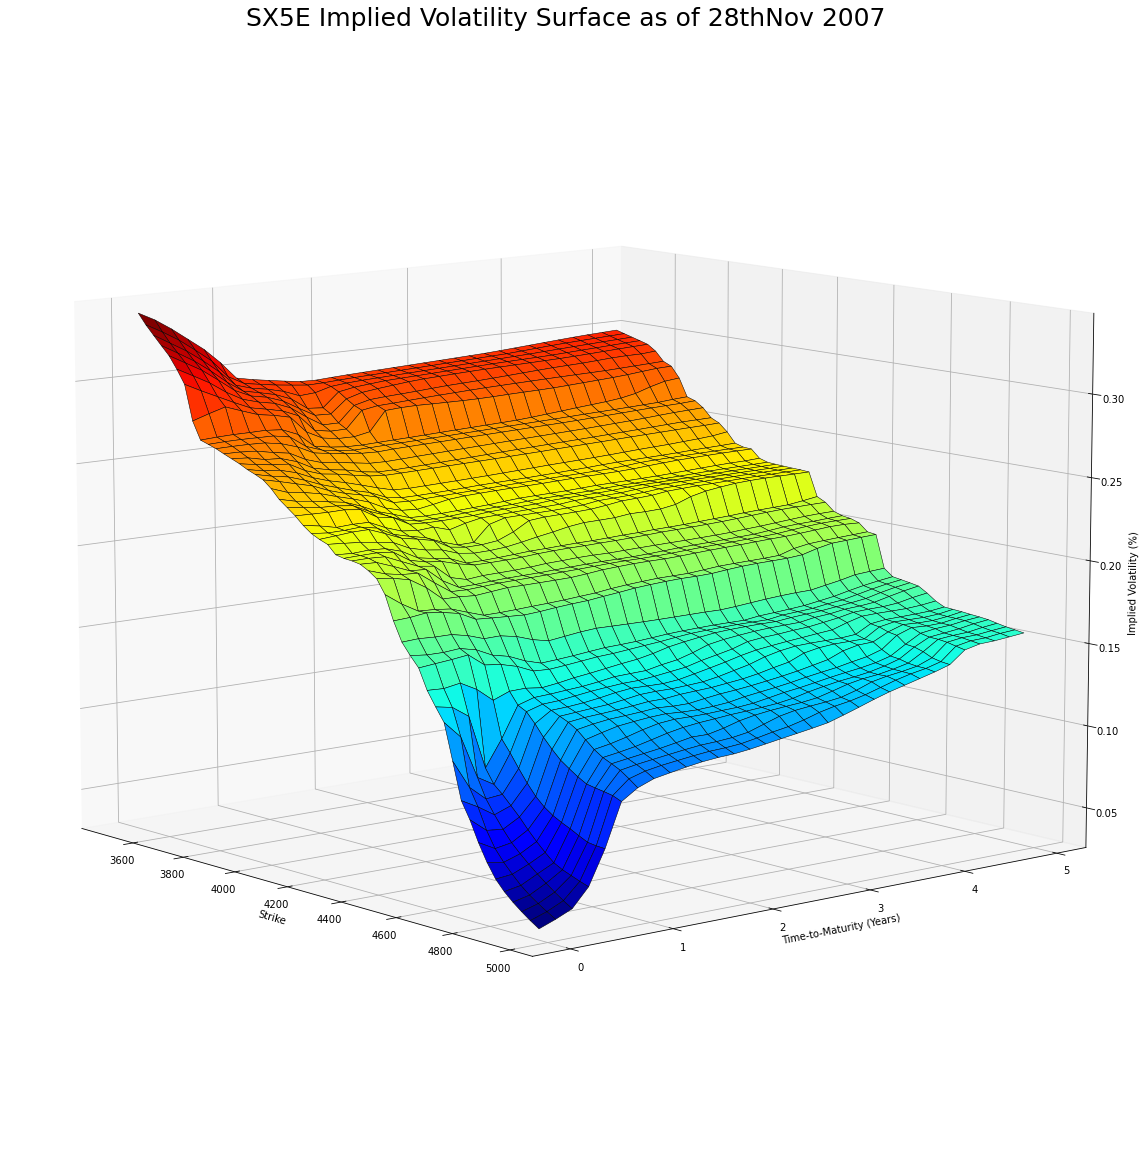

In [15]:
K = np.arange(3500, 5000, 30)
T = np.arange(0., 5., 0.16)

X, Y = np.meshgrid(K, T)

Z = np.zeros((K.shape[0], T.shape[0]))
for i in range(K.shape[0]):
    for j in range(T.shape[0]):
        k = K[i]
        t = T[j] 
        Z[i,j] = model.predict(np.array([[k, t]]))
Z = Z.T

fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title('SX5E Implied Volatility Surface as of 28thNov 2007', fontdict={'fontsize': 25, 'fontweight': 'medium'})
ax.set_xlabel('Strike')
ax.set_ylabel('Time-to-Maturity (Years)')
ax.set_zlabel('Implied Volatility (%)')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='jet', edgecolor='black', linewidth=0.5, antialiased=True)
ax.azim = -40
ax.dist = 10
ax.elev = 10